<a href="https://colab.research.google.com/github/JFrankVC/aprendizaje_profundo/blob/main/DL_Proyecto_MIDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name: *José Francisco Villanueva Cortés*
# Dossier: *742015*

In [160]:
# imports
import os
import time
import glob
import math
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt
import music21
import librosa
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence
from torch.nn.functional import softplus, binary_cross_entropy
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms, ops
from IPython.display import Image, Audio, display, clear_output
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tqdm import tqdm
import IPython.display as ipd
from librosa import display


In [2]:
# Utilities
WHITE = '\033[97m'
YELLOW = '\033[93m'
BLUE = '\033[94m'
GREEN = '\033[92m'
RED = '\033[91m'
RESET = '\033[0m'

checkpoint_load = True
training_mode = 'TEST'

In [3]:
# Connect drive to verify model storage
# Mount the Google Drive
# Allow access - check steps and methods in: https://neptune.ai/blog/google-colab-dealing-with-files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # if Colab root directory is shown, go to /content folder

Mounted at /content/drive


In [ ]:
#import tarfile
#tar = tarfile.open("/content/drive/MyDrive/Colab_DL/Data_DL/Nintendo/nesmdb_midi.tar")
#tar.extractall("/content/drive/MyDrive/Colab_DL/Data_DL/Nintendo/")

In [4]:
# How to install permanently non-preinstalled libraries
!pip install torcheval && touch /root/.ipython/profile_default/startup/00-first.py && echo "import torcheval" >> /root/.ipython/profile_default/startup/00-first.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.8 MB/s eta 0:00:00


In [5]:
!pip install pretty_midi && touch /root/.ipython/profile_default/startup/00-first.py && echo "import pretty_midi" >> /root/.ipython/profile_default/startup/00-first.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.9 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=1237597ce1a609f19ce182ce0427f15354c12a5ddb1a26b2c0b48e2267e6b8a8
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
import pretty_midi

In [6]:
# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

# Change the directory - Google Drive
path = "/content/drive/MyDrive/Colab_DL/Data_DL/Nintendo/nesmdb_midi"
os.chdir(path)

# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

Current working directory /content
Current working directory /content/drive/MyDrive/Colab_DL/Data_DL/Nintendo/nesmdb_midi


In [7]:
!ls

instruments.csv  test  train  valid


### Explore MIDI Data

In [157]:
# Example MIDI files from train folder
song_name_ex_1 = '393_Yoshi_01_02MushroomMusicA.mid'
song_name_ex_2 = '401_ZeldaII_TheAdventureofLink_11_12GameOver.mid'
song_name_ex_3 = '348_TheLegendofZelda_00_01TitleBGM.mid'
song_name = song_name_ex_3  # Selected song for data exploration

In [158]:
midi_data = pretty_midi.PrettyMIDI('train/'+song_name)

# If loading MIDI file fails, try
# pretty_midi.pretty_midi.MAX_TICK = 1e10

for instrument in midi_data.instruments:
  print('-' * 80)
  print(instrument.name.upper())
  print('# note events: {}'.format(len(instrument.notes)))
  print('# control change events: {}'.format(len(instrument.control_changes)))

--------------------------------------------------------------------------------
P1
# note events: 225
# control change events: 1461
--------------------------------------------------------------------------------
P2
# note events: 173
# control change events: 1000
--------------------------------------------------------------------------------
TR
# note events: 318
# control change events: 0
--------------------------------------------------------------------------------
NO
# note events: 312
# control change events: 0


<ipython-input-161-1705f6c6bd03>:6: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(piano_roll, y_axis='cqt_note', cmap=plt.cm.hot)


Text(0.5, 1.0, '348_TheLegendofZelda_00_01TitleBGM.mid')

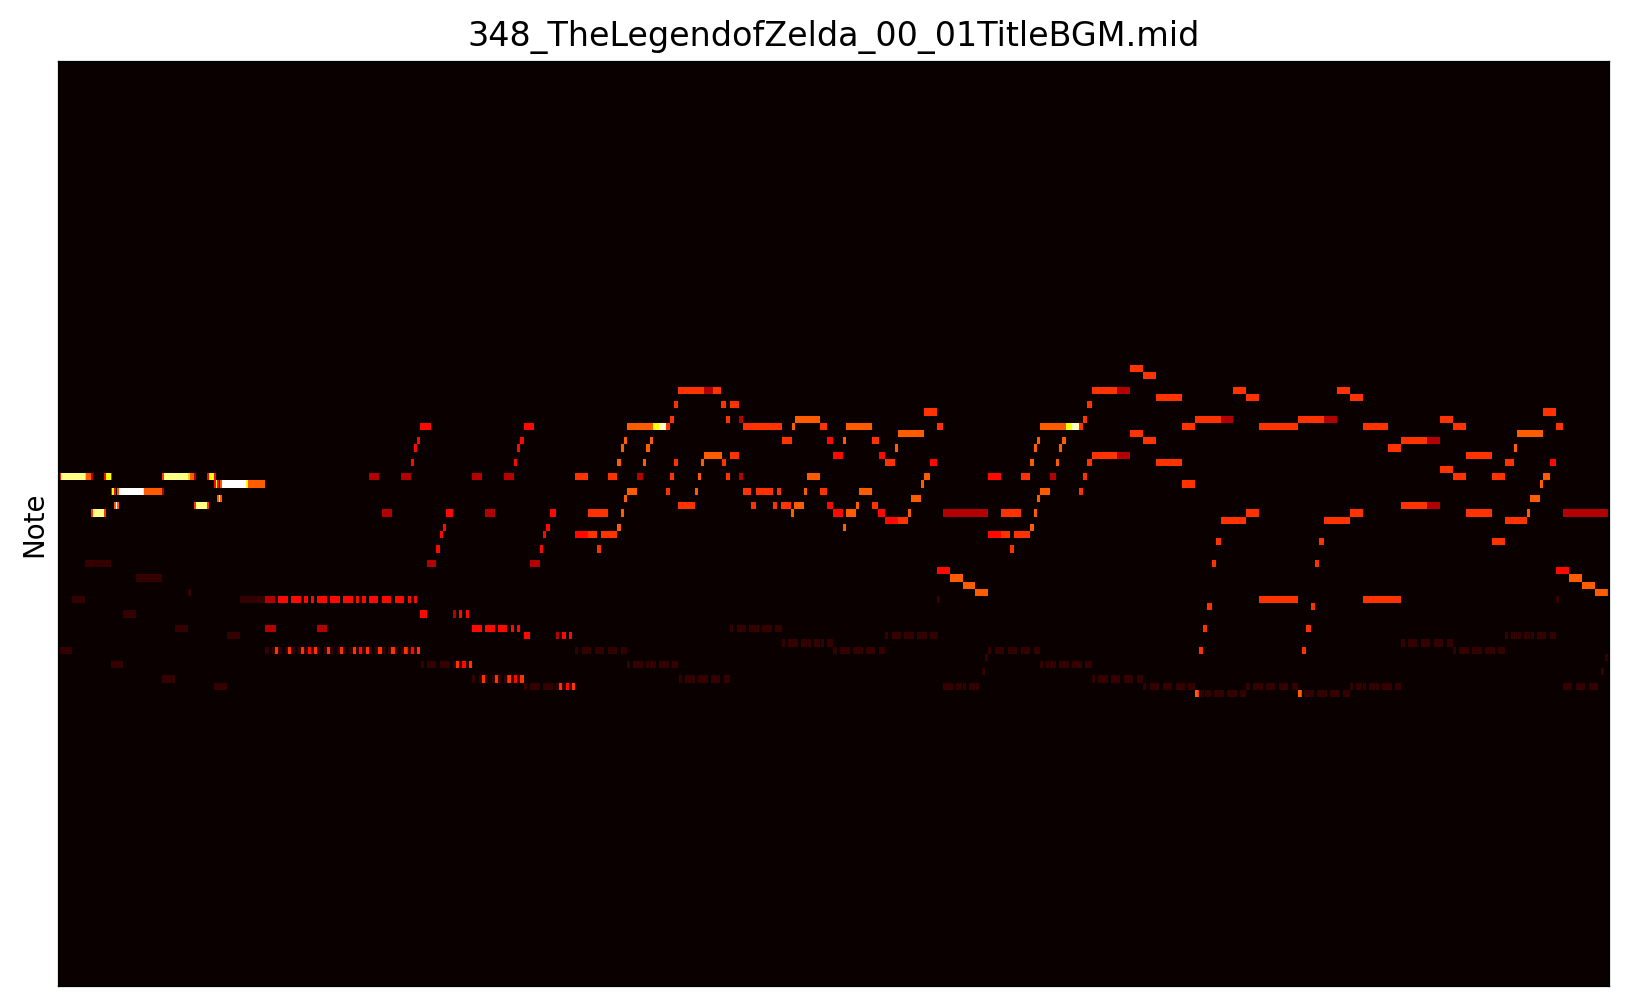

In [161]:
# Get piano roll from MIDI file
piano_roll = midi_data.get_piano_roll()

# Print spectrogram from piano roll
plt.figure(figsize=(10, 6))
display.specshow(piano_roll, y_axis='cqt_note', cmap=plt.cm.hot)
plt.title(song_name)

In [12]:
piano_roll.shape

(128, 7993)

In [13]:
# Get instruments in midi file
for instrument in midi_data.instruments:
    print(instrument)

Instrument(program=80, is_drum=False, name="p1")
Instrument(program=81, is_drum=False, name="p2")
Instrument(program=38, is_drum=False, name="tr")
Instrument(program=121, is_drum=True, name="no")


In [14]:
# For an instrument in midi file get pd dataframe
instrument_no = 0

instrument = midi_data.instruments[instrument_no]
instrument_piano_roll = instrument.get_piano_roll()

cols = ['start', 'end', 'pitch', 'velocity']

note_seq = []
for index, note in enumerate(instrument.notes):
    note_seq.append([note.start, note.end, note.pitch, note.velocity])

note_df = pd.DataFrame(note_seq, columns=cols)
note_df.head(10)

,start,end,pitch,velocity
0,0.083424,0.083469,70,4
1,0.083515,1.414603,70,7
2,1.414626,1.747347,70,4
3,1.747347,1.747392,65,4
4,1.747415,2.412902,65,7
5,2.412902,2.745714,70,6
6,2.745737,2.912086,68,6
7,2.912086,3.078503,66,8
8,3.078503,4.409660,68,8
9,4.409683,5.408005,68,4


In [15]:
note_df.shape

(225, 4)

In [16]:
# Creates np array from pd dataframe
note_seq_np = np.zeros((len(instrument.notes), 4))
for index, note in enumerate(instrument.notes):
    note_seq_np[index] = [note.start, note.end, note.pitch, note.velocity]

#note_seq_np

In [17]:
note_seq_np.shape

(225, 4)

<ipython-input-18-23e878431764>:17: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(encoded.T.values, y_axis='cqt_note', cmap=plt.cm.hot)


,C-1,C#-1,D-1,D#-1,E-1,F-1,F#-1,G-1,G#-1,A-1,...,A#8,B8,C9,C#9,D9,D#9,E9,F9,F#9,G9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


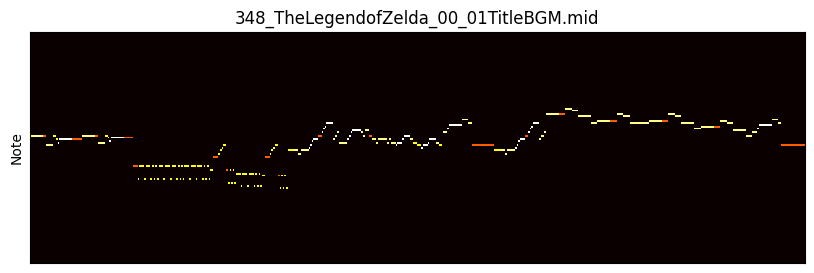

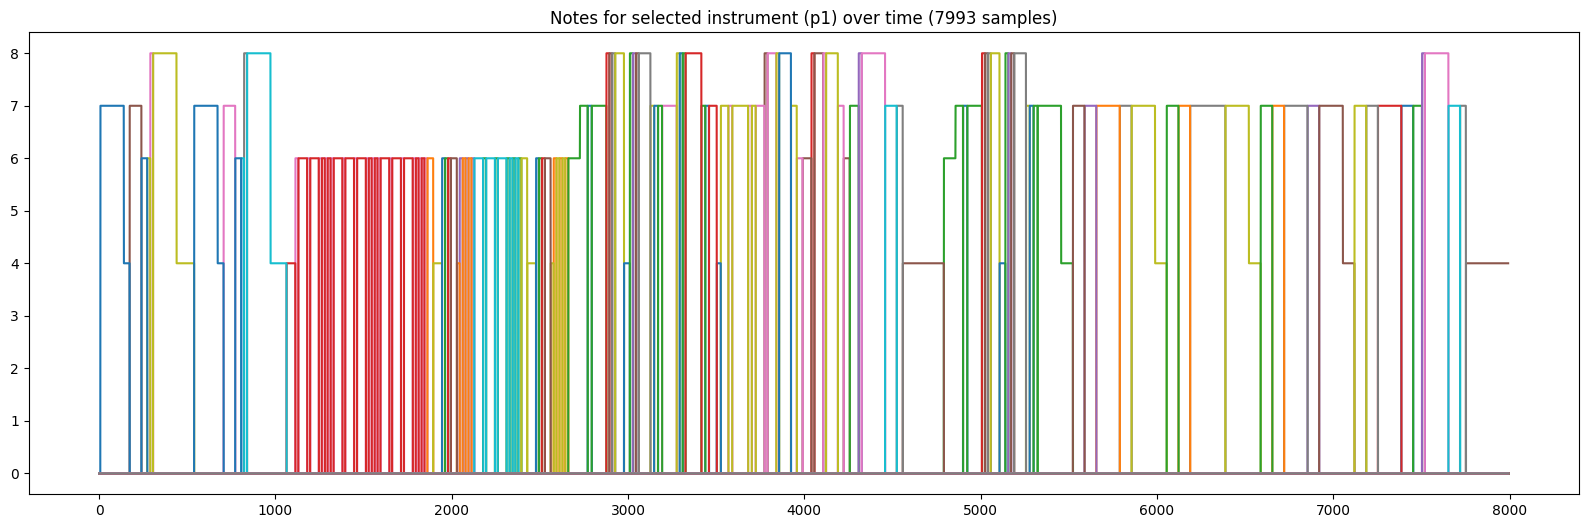

In [18]:
RANGE_NOTES = 128
columns = [pretty_midi.note_number_to_name(n) for n in range(0,RANGE_NOTES)]

def encode_dummies(instrument):
    """ Gonna cheat a little bit by transposing the instrument piano roll.
        However, that leaves us with a lot of blank space.
    """
    return pd.DataFrame(instrument.get_piano_roll().T, columns=columns)

encoded = encode_dummies(instrument)
# Get number of piano roll samples after encoding
SAMPLES = encoded.shape[0]
# Get intrument name
INSTRUMENT = instrument.name

plt.figure(figsize=(10, 3))
display.specshow(encoded.T.values, y_axis='cqt_note', cmap=plt.cm.hot)
plt.title(song_name)
encoded.plot(legend=False, figsize=(20, 6), title=f'Notes for selected instrument ({INSTRUMENT}) over time ({SAMPLES} samples)')

# What's the numbers on the y axis? Is this the velocity? Can maybe ignore this and code it as 1's
encoded.head()

In [19]:
encoded.shape

(7993, 128)

In [24]:
for i in range(128):
    #print(encoded.iloc[50][i])
    if encoded.iloc[7992][i] != 0.0:
        print(pretty_midi.note_number_to_name(i))

F4


<ipython-input-25-4edd078422ba>:8: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(trimmed.T.values, y_axis='cqt_note', cmap=plt.cm.hot)


,C-1,C#-1,D-1,D#-1,E-1,F-1,F#-1,G-1,G#-1,A-1,...,A#8,B8,C9,C#9,D9,D#9,E9,F9,F#9,G9
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


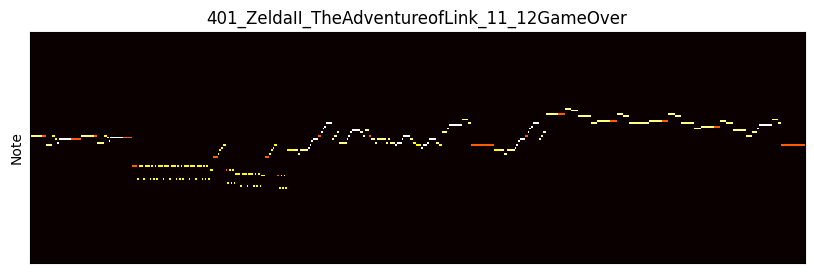

In [25]:
def trim_blanks(df):
    nonzero = df.apply(lambda s: s != 0)
    first_nonzero = df[nonzero].apply(pd.Series.first_valid_index).min()
    return df.iloc[int(first_nonzero):]

trimmed = trim_blanks(encoded)
plt.figure(figsize=(10, 3))
display.specshow(trimmed.T.values, y_axis='cqt_note', cmap=plt.cm.hot)
plt.title("401_ZeldaII_TheAdventureofLink_11_12GameOver")

trimmed.head()

In [26]:
trimmed.shape   # 128 notes

(7985, 128)

In [27]:
trimmed = trimmed.loc[:, (trimmed != 0).any(axis=0)]
trimmed.head()

,F2,F#2,G#2,A#2,C3,C#3,D#3,F3,A#3,C4,...,D5,D#5,E5,F5,F#5,G5,A5,A#5,C6,C#6
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
trimmed.shape   # trimming gives 30 notes

(7985, 30)

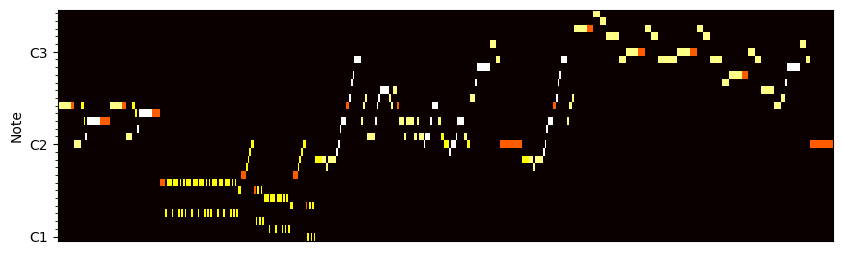

In [29]:
plt.figure(figsize=(10, 3))
display.specshow(trimmed.T.values, y_axis='cqt_note', cmap=plt.cm.hot)

### Simplyfy dataset - Create instruments CSV

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab_DL/Data_DL/Nintendo/nesmdb_midi"
TRAIN_DATA_PATH = DATA_PATH + "/train"
TEST_DATA_PATH = DATA_PATH + "/test"
VAL_DATA_PATH = DATA_PATH + "/val"
SEARCH_CRITERION = '**/*.mid'

midi_files = glob.glob(os.path.join(DATA_PATH, SEARCH_CRITERION), recursive=True)

In [ ]:
midi_files[-1]

'/content/drive/MyDrive/Colab_DL/Data_DL/Nintendo/nesmdb_midi/train/056_CircusCharlie_00_01JumpThroughtheWheelofFireGetontheBend.mid'

In [ ]:
# Save the filepath for a second pass loading the piano rolls for each instrument we will use
# DO NOT execute again if 'instruments' CSV file already exists
limit = -1

instrument_ary = [[]]
instrument_ary.append(['program', 'is_drum', 'name', 'filepath'])
# Only execute if files is not present in current folder
if not os.path.isfile('instruments.csv'):
# This might take a while...
    for index, file in enumerate(midi_files[:limit]):
        clear_output(wait=True)
        print("{}/{}: Loading and parsing {}.".format(index, len(midi_files), os.path.basename(file)))
        try:
            pm = pretty_midi.PrettyMIDI(file)
            instruments = pm.instruments

            for instrument in instruments:
                instrument_ary.append([instrument.program, instrument.is_drum, instrument.name.replace(';',''), file])
        except:
            # For now, just ignore files we can't load.
            continue

5276/5278: Loading and parsing 055_CircusCaper_25_18EndingTheme.mid.


In [ ]:
# Get dataframe of program instruments for each MIDI file
# Each row in df is a path for a songs
# File path can be the same for different rows given MIDI files can contain more than 1 instrument
# 'program' is the number of the instrument, mapped one to one to a 'name'
df = pd.DataFrame(data=instrument_ary, columns=["program", "is_drum", "name", "filepath"])
df = df.dropna()
df.head()

,program,is_drum,name,filepath
1,program,is_drum,name,filepath
2,81,False,p2,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
3,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
4,81,False,p2,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
5,38,False,tr,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...


In [ ]:
# Store dataframe from previous parsing into 'instruments' CSV file
file_name = 'instruments.csv'
df.to_csv(file_name, sep=';', encoding='utf-8')

In [ ]:
# Show the instrument with the most unique filepath values
df.groupby('program').nunique().sort_values('filepath', ascending=False)

,is_drum,name,filepath
program,,,
80,1,1,5044
81,1,1,4940
38,1,1,4647
121,1,1,3051
program,1,1,1


In [ ]:
def play_midi(midi_sample):
    fs = 44100
    synth = midi_sample.synthesize(fs=fs)
    return [synth], fs

In [ ]:
midi_data = pretty_midi.PrettyMIDI('train/393_Yoshi_01_02MushroomMusicA.mid')

In [ ]:
synth, fs = play_midi(midi_data)

In [ ]:
# Hear MIDI file
Audio(synth, rate=fs)

### Simplify dataset

In [64]:
# Read 'instruments' CSV file
instruments = pd.read_csv('instruments.csv', sep=';', index_col=0)
instruments.head()

,program,is_drum,name,filepath
1,program,is_drum,name,filepath
2,81,False,p2,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
3,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
4,81,False,p2,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
5,38,False,tr,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...


In [65]:
# Remove first row as it is the same as the names of columns
instruments = instruments.iloc[1:]
# Reset index starting at 1
instruments = instruments.reset_index(drop=True)
instruments.head()

,program,is_drum,name,filepath
0,81,False,p2,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
1,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
2,81,False,p2,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
3,38,False,tr,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
4,121,True,no,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...


Text(0.5, 1.0, 'Number of songs per instrument')

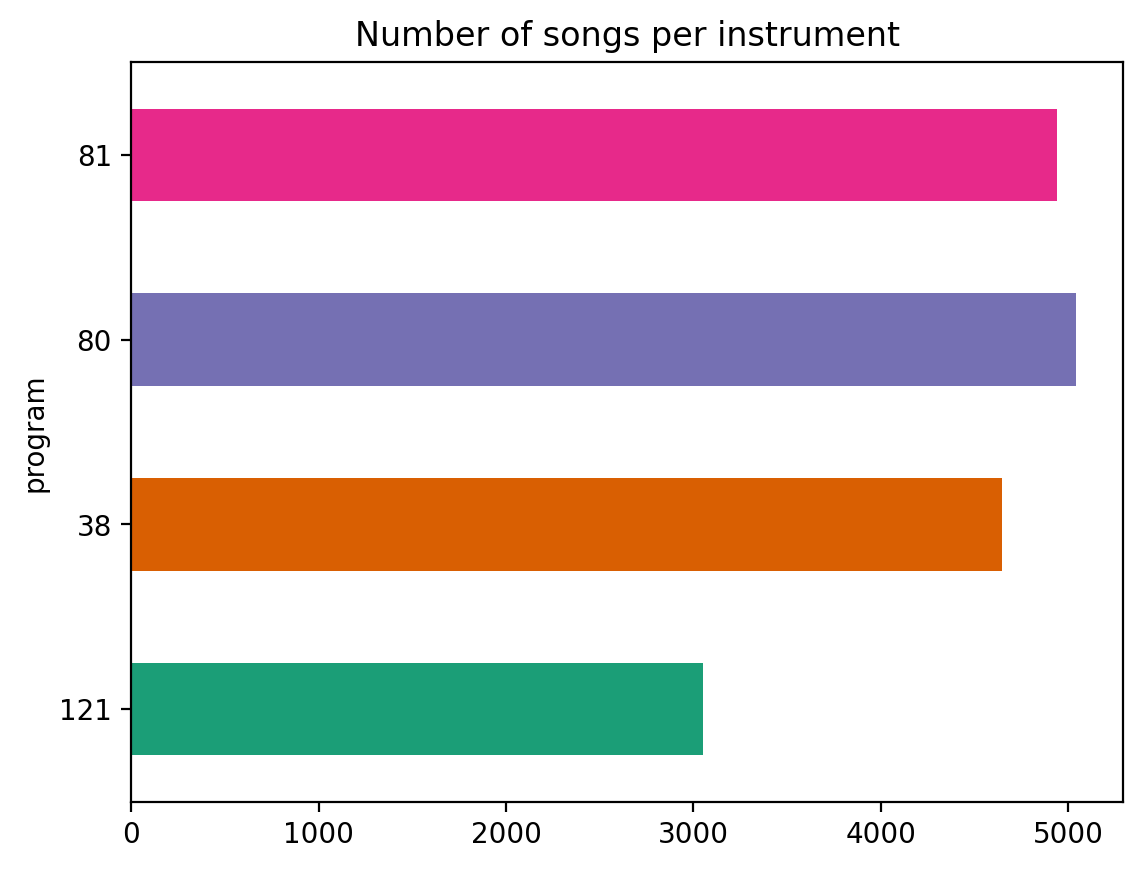

In [66]:
# Plot instruments and number of songs using that instrument
instruments.groupby('program').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(True)
plt.title("Number of songs per instrument")

In [67]:
instruments.shape

(17682, 4)

In [68]:
# Show the instrument with the most unique filepath values
grouped = instruments.groupby('program').nunique().sort_values('filepath', ascending=False)
grouped.head(n=10)

,is_drum,name,filepath
program,,,
80,1,1,5044
81,1,1,4940
38,1,1,4647
121,1,1,3051


Fro pervious step, it can be observed that instrument (program) 80 is the one with the most songs.

In [69]:
# Translate the program codes to instrument names
for program in grouped.head(n=10).index.values: # from first 10 songs
    print(pretty_midi.program_to_instrument_name(int(program)))

Lead 1 (square)
Lead 2 (sawtooth)
Synth Bass 1
Breath Noise


In [77]:
instruments[(instruments['program'] == '80')].head(n=10)

,program,is_drum,name,filepath
1,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
5,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
9,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
13,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
16,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
19,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
23,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
25,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
28,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
32,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...


In [79]:
pianos = instruments[(instruments['program'] == '80') & (instruments['name'].str.contains('p1', case=False))]
print(len(pianos))
pianos.head(n=10)

5044


,program,is_drum,name,filepath
1,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
5,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
9,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
13,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
16,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
19,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
23,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
25,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
28,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
32,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...


### Load MIDI files for selected instrument

In [90]:
note_columns = [pretty_midi.note_number_to_name(n) for n in range(0,128)]

,,C3,C#3,D3,D#3,E3,F3,F#3,G3,G#3,A3,...,D7,D#7,E7,F7,F#7,G7,G#7,A7,A#7,B7
piano_roll_name,timestep,,,,,,,,,,,,,,,,,,,,,


In [ ]:
def encode_dummies(instrument, sampling_freq):
    """ Gonna cheat a little bit by transposing the instrument piano roll.
        However, that leaves us with a lot of blank space.
        Coercing to type uint8, since the max velocity is 127, and there are also only 128 notes. uint8 goes to 255.
        Saves memory
    """
    pr = instrument.get_piano_roll(fs=sampling_freq).astype('uint8').T
    return pd.DataFrame(pr, columns=note_columns)

In [115]:
def trim_blanks(df):
    """
        Remove the first period of no activity (fast forward to where the first note begins for this instrument)
    """
    nonzero = df.apply(lambda s: s != 0)
    nonzeroes = df[nonzero].apply(pd.Series.first_valid_index)
    first_nonzero = nonzeroes.min()
    #if first_nonzero is pd.np.nan:
    if first_nonzero is np.nan:
        return None
    return df.iloc[int(first_nonzero):]

In [ ]:
"""
    Create a pandas to store the piano rolls in.
    It'll look a bit like this:

    |   Index     | t | C0 |...| C10 |
    |Song_name_3:0| 0 | 40 |...| 0   |
    |             | 1 | 40 |...| 0   |
    |             |...|... |...| ... |
    |             | N | 40 |...| 0   |
    |Song_name_3:1| 0 | 40 |...| 0   |
    |             |...|... |...| ... |
    |             | N | 40 |...| 0   |
    |Song_name_4:0| 0 | 40 |...| 0   |
    |             |...|... |...| ... |
    |             | N | 40 |...| 0   |

"""
saved_columns = [pretty_midi.note_number_to_name(n) for n in range(48,108)]
piano_rolls = pd.DataFrame(columns=['piano_roll_name', 'timestep'] + saved_columns)
piano_rolls = piano_rolls.set_index(['piano_roll_name', 'timestep'])
piano_rolls.head()

In [91]:
len(saved_columns)

60

In [55]:
# Chops off the upperbound and lowerbound of zeros
# The lower bound note is set a C, which might make it easier
# to make the MIDI play in the same key.
def chopster(dframe):
    # Figure out range of frame (0-128)
    df_max = dframe.max(axis = 0)

    dframe.drop(labels=[pretty_midi.note_number_to_name(n) for n in range(108,128)], axis=1, inplace=True)
    dframe.drop(labels=[pretty_midi.note_number_to_name(n) for n in range(0,48)], axis=1, inplace=True)
    return dframe

In [56]:
# Non-zero values changed to 1's
def minister(dframe):
    return dframe.where(dframe<1, 1)

In [57]:
# Removes chords and turns them into melody
def arpster(dframe):
    # Count amount of notes being played at once.
    note_amount = np.asarray(dframe.astype(bool).sum(axis=1))
    i = 0

    # Slide through whole MIDI
    while i < dframe.shape[0]:
        # Check if note is single
        if note_amount[i] == 1:
            i += 1
            continue
        elif note_amount[i] > 1:
            hits = 0
            hit_index = []
            # Calculates the amount of notes being played
            for j in range(dframe.shape[1]):
                if dframe.iloc[i,j] == 1:
                    hit_index.append(j)
                    hits += 1
                    if hits == note_amount[i]:
                        break

            length = 0

            # Removes all notes such that chords are turned into arpeggios.
            # Ensures that all values in hit_index are the same as ones in
            # dframe row.
            while False not in (dframe.iloc[i+length, hit_index] == 1).values:
                for k in range(len(hit_index)):
                    if k != (length % hits):
                        dframe.iloc[i+length, hit_index[k]] = 0
                length += 1
                if len(note_amount) <= i+length or note_amount[i+length-1] != note_amount[i+length]:
                    break

            # Skip ahead to next note
            i += length

        # Maybe a case where we count ithe amount of silent steps going ahead
        elif note_amount[i] == 0:
            i += 1
            continue

    return dframe

In [58]:
# Chops up into desired window size.
# and maybe saves them to csv in this step?
# frame_size: amount of measures pr input
def cutster(dframe, frame_size, undesired_silence):
    # Chop up if the window size fits the music

    # Check if frame size is greater than MIDI length
    # Pad with zeros
    if frame_size > dframe.shape[0]/16:
        return dframe

    note_amount = np.asarray(dframe.astype(bool).sum(axis=1))
    zero_amount = 0

    df_dictionary = {}
    dict_index = 0

    divider = 0
    i = 0
    while i < len(note_amount):
        # Cuts out silent measures if greater than undesired_silence
        if zero_amount/16 > undesired_silence and note_amount[i] != 0:
            drop_amount = [j for j in range(i-zero_amount,i)]
            dframe.drop(drop_amount, inplace=True)
            note_amount = np.delete(note_amount, drop_amount)
            i -= zero_amount-1
            zero_amount = 0

        elif note_amount[i] != 0:
            if zero_amount != 0:
                zero_amount = 0
            i += 1
        # Count sequential zeros
        elif note_amount[i] == 0:
            zero_amount += 1
            i += 1

    return dframe

In [59]:
# Add desired amount of padding to
# all MIDI files such that they contain
# the same amount of dimensions.
def padster(dframe):
    # Find MIDI piece with most keys used
    # Pad all others such they fit the dimensions
    return dframe.fillna(0)

In [61]:
# DISCLAIMER:
# This file is inspired by Nick Kelly by his article on tranposing MIDI files.
# http://nickkellyresearch.com/python-script-transpose-midi-files-c-minor/

# Transpose MIDI to same key (C major or A minor)
def transposer(midi_file):
    midi_array = midi_file.split('/')

    # converting everything into the key of C major or A minor
    # Major conversion
    majors = dict([("A-", 4),("G#", 4),("A", 3),("A#", 2),("B-", 2),("B", 1),("C", 0),("C#", -1),("D-", -1),("D", -2),("D#", -3),("E-", -3),("E", -4),("F", -5),("F#", 6),("G-", 6),("G", 5)])
    # Minor conversion
    minors = dict([("G#", 1), ("A-", 1),("A", 0),("A#", -1),("B-", -1),("B", -2),("C", -3),("C#", -4),("D-", -4),("D", -5),("D#", 6),("E-", 6),("E", 5),("F", 4),("F#", 3),("G-", 3),("G", 2)])

    score = music21.converter.parse(midi_file)
    key = score.analyze('key')
    if key.mode == "major":
        halfSteps = majors[key.tonic.name]

    elif key.mode == "minor":
        halfSteps = minors[key.tonic.name]

    return halfSteps

In [89]:
pianos = instruments[(instruments['program'] == '80') & (instruments['name'].str.contains('p1', case=False))]
print(len(pianos))
pianos.head(n=10)

5044


,program,is_drum,name,filepath
1,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
5,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
9,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
13,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
16,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
19,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
23,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
25,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
28,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
32,80,False,p1,/content/drive/MyDrive/Colab_DL/Data_DL/Ninten...


In [99]:
pianos['filepath'][0:-1]

1        /content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
5        /content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
9        /content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
13       /content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
16       /content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
                               ...                        
17663    /content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
17666    /content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
17670    /content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
17673    /content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
17675    /content/drive/MyDrive/Colab_DL/Data_DL/Ninten...
Name: filepath, Length: 5043, dtype: object

In [167]:
start = 0
limit = 2000
skip = [1201]   # No skip
file_name = 'piano_rolls.csv'
piano_rolls.to_csv(file_name, sep=';', encoding='utf-8')

# This might take a while...
for i, _file in enumerate(pianos['filepath'][start:limit]):
    if i in skip:
        print("Skipping {}...".format(i))
        continue

    clear_output(wait=True)
    song_name = os.path.basename(_file)
    print("{}/{}: {}.".format(i, len(pianos), song_name))
    try:
        semi_shift = transposer(_file)
        pm = pretty_midi.PrettyMIDI(_file)
        print("Loaded into memory, processing...")
        """
            Here we calculate the amount of seconds per sixteenth note, by taking the second beat of the song
            (which is the same as the difference in seconds between the first and second beat),
            and convert it to the sampling frequency format that pretty_midi expects.
        """
        sampling_freq = 1/ (pm.get_beats()[1]/4)
    except Exception as e:
        # For now, just ignore files we can't load.
        print("Ignoring song {}: {}".format(song_name, e))
        continue
    for j, instrument in enumerate(pm.instruments):
        print("Instrument {}: {}".format(j, instrument.name))
        # Hardcoded for now:
        if instrument.name == 'p1':
            """
                Generate a unique top level index per song and instrument in this song,
                if it has multiples of the same kind.
            """
            for note in instrument.notes:
                note.pitch += semi_shift

            try:
                df = encode_dummies(instrument, sampling_freq).fillna(value=0) # Fill invalid values
            except Exception as e:
                # Something is really wrong if this fails. Means the piano roll is bad - don't use this track
                print("Encountered exception for song {}, instrument {}: {}".format(song_name, instrument.name, e))
                continue

            print("One hot encoded")
            # chop before doing anything else to conserve memory
            df = chopster(df)
            print("Chopped to relevant notes only")

            df = trim_blanks(df)
            print("Fast forwarded to first note playing")
            if df is None:
                # We've got an empty track
                continue

            df = minister(df)
            print("Reduced velocity to on/off")

            df = arpster(df)
            print("Arpeggiated chords")

            # ensures that files with more than 1 note pr timestep is not added to the dataset.
            if np.amax(np.asarray(df.astype(bool).sum(axis=1))) > 1:
                continue
                # raise Exception('More than one key pressed at timestep {0}'.format(np.unique(ar = note_amount, return_index = True, return_counts = True)[1][2:]))

            df.reset_index(inplace=True, drop=True)
            #new_df = cutster(df, 8, 1)
#            df.reset_index(drop=True)

            top_level_index = "{}_{}:{}".format(song_name, i, j)
            df['timestep'] = df.index
            df['piano_roll_name'] = top_level_index
            df = df.set_index(['piano_roll_name', 'timestep'])
            df.to_csv(file_name, sep=';', mode='a', encoding='utf-8', header=False)

1999/5044: 345_TheGuardianLegend_03_04BossTheme1.mid.
Loaded into memory, processing...
Instrument 0: p1
One hot encoded
Chopped to relevant notes only
Fast forwarded to first note playing
Reduced velocity to on/off
Arpeggiated chords
Instrument 1: p2
Instrument 2: tr
Instrument 3: no


In [168]:
df

C3  C#3  D3  D#3  \
piano_roll_name                                  timestep                     
345_TheGuardianLegend_03_04BossTheme1.mid_1999:0 0          0    0   0    0   
                                                 1          0    0   0    0   
                                                 2          0    0   0    0   
                                                 3          0    0   0    0   
                                                 4          0    0   0    0   
...                                                        ..  ...  ..  ...   
                                                 182        0    0   0    0   
                                                 183        0    0   0    0   
                                                 184        0    0   0    0   
                                                 185        0    0   0    0   
                                                 186        0    0   0    0   

                                                           E3  F3  F#3  G3  \
piano_roll_name                                  timestep                    
345_TheGuardianLegend_03_04BossTheme1.mid_1999:0 0          0   0    0   0   
                                                 1          0   0    0   0   
                                                 2          0   0    0   0   
                                                 3          0   0    0   0   
                                                 4          0   0    0   0   
...                                                        ..  ..  ...  ..   
                                                 182        0   0    0   0   
                                                 183        0   0    0   0   
                                                 184        0   0    0   1   
                                                 185        0   0    0   0   
                                                 186        0   0    0   0   

                                                           G#3  A3  ...  D7  \
piano_roll_name                                  timestep           ...       
345_TheGuardianLegend_03_04BossTheme1.mid_1999:0 0           0   1  ...   0   
                                                 1           0   0  ...   0   
                                                 2           0   0  ...   0   
                                                 3           0   1  ...   0   
                                                 4           0   0  ...   0   
...                                                        ...  ..  ...  ..   
                                                 182         0   0  ...   0   
                                                 183         0   0  ...   0   
                                                 184         0   0  ...   0   
                                                 185         0   0  ...   0   
                                                 186         0   0  ...   0   

                                                           D#7  E7  F7  F#7  \
piano_roll_name                                  timestep                     
345_TheGuardianLegend_03_04BossTheme1.mid_1999:0 0           0   0   0    0   
                                                 1           0   0   0    0   
                                                 2           0   0   0    0   
                                                 3           0   0   0    0   
                                                 4           0   0   0    0   
...                                                        ...  ..  ..  ...   
                                                 182         0   0   0    0   
                                                 183         0   0   0    0   
                                                 184         0   0   0    0   
                                                 185         0   0   0    0   
                                        

In [169]:
rolls = pd.read_csv("piano_rolls.csv", sep=';', index_col=['piano_roll_name', 'timestep'])
print(rolls.head())
print(rolls.index.levels[0])
#rolls = padster(rolls)

                                                             C3  C#3  D3  D#3  \
piano_roll_name                                    timestep                     
396_YsIII_WanderersfromYs_03_04TradingTownofRed... 0          0    0   0    0   
                                                   1          0    0   0    0   
                                                   2          0    0   0    0   
                                                   3          0    0   0    0   
                                                   4          0    0   0    0   

                                                             E3  F3  F#3  G3  \
piano_roll_name                                    timestep                    
396_YsIII_WanderersfromYs_03_04TradingTownofRed... 0          0   0    0   0   
                                                   1          0   0    0   0   
                                                   2          0   0    0   0   
                                

In [170]:
rolls.head()

C3  C#3  D3  D#3  \
piano_roll_name                                    timestep                     
396_YsIII_WanderersfromYs_03_04TradingTownofRed... 0          0    0   0    0   
                                                   1          0    0   0    0   
                                                   2          0    0   0    0   
                                                   3          0    0   0    0   
                                                   4          0    0   0    0   

                                                             E3  F3  F#3  G3  \
piano_roll_name                                    timestep                    
396_YsIII_WanderersfromYs_03_04TradingTownofRed... 0          0   0    0   0   
                                                   1          0   0    0   0   
                                                   2          0   0    0   0   
                                                   3          0   0    0   0   
                                                   4          0   0    0   0   

                                                             G#3  A3  ...  D7  \
piano_roll_name                                    timestep           ...       
396_YsIII_WanderersfromYs_03_04TradingTownofRed... 0           0   0  ...   0   
                                                   1           0   0  ...   0   
                                                   2           0   0  ...   0   
                                                   3           0   0  ...   0   
                                                   4           0   0  ...   0   

                                                             D#7  E7  F7  F#7  \
piano_roll_name                                    timestep                     
396_YsIII_WanderersfromYs_03_04TradingTownofRed... 0           0   0   0    0   
                                                   1           0   0   0    0   
                                                   2           0   0   0    0   
                                                   3           0   0   0    0   
                                                   4           0   0   0    0   

                                                             G7  G#7  A7  A#7  \
piano_roll_name                                    timestep                     
396_YsIII_WanderersfromYs_03_04TradingTownofRed... 0          0    0   0    0   
                                                   1          0    0   0    0   
                                                   2          0    0   0    0   
                                                   3          0    0   0    0   
                                                   4          0    0   0    0   

                                                             B7  
piano_roll_name                                    timestep      
396_YsIII_WanderersfromYs_03_04TradingTownofRed... 0          0  
                                                   1          0  
                                                   2          0  
                                                   3          0  
                                                   4          0  

[5 rows x 60 columns]

In [171]:
first = rolls.loc['396_YsIII_WanderersfromYs_03_04TradingTownofRedmont.mid_0:0'].T
#display.specshow(first.values, y_axis='cqt_note', cmap=plt.cm.hot)

In [172]:
rolls = rolls.loc[:, (rolls != 0).any(axis=0)]
rolls.tail(n=16)

C3  C#3  D3  D#3  \
piano_roll_name                                  timestep                     
345_TheGuardianLegend_03_04BossTheme1.mid_1999:0 171        0    0   0    0   
                                                 172        0    0   0    0   
                                                 173        0    0   0    0   
                                                 174        0    0   0    0   
                                                 175        0    0   0    0   
                                                 176        0    0   0    0   
                                                 177        0    0   0    0   
                                                 178        0    0   0    0   
                                                 179        0    0   0    0   
                                                 180        0    0   0    0   
                                                 181        0    0   0    0   
                                                 182        0    0   0    0   
                                                 183        0    0   0    0   
                                                 184        0    0   0    0   
                                                 185        0    0   0    0   
                                                 186        0    0   0    0   

                                                           E3  F3  F#3  G3  \
piano_roll_name                                  timestep                    
345_TheGuardianLegend_03_04BossTheme1.mid_1999:0 171        0   0    0   0   
                                                 172        0   0    0   0   
                                                 173        0   0    0   0   
                                                 174        0   0    0   0   
                                                 175        0   0    0   0   
                                                 176        0   0    0   0   
                                                 177        0   0    0   1   
                                                 178        0   0    0   0   
                                                 179        0   0    0   0   
                                                 180        0   0    0   0   
                                                 181        0   0    0   0   
                                                 182        0   0    0   0   
                                                 183        0   0    0   0   
                                                 184        0   0    0   1   
                                                 185        0   0    0   0   
                                                 186        0   0    0   0   

                                                           G#3  A3  ...  D7  \
piano_roll_name                                  timestep           ...       
345_TheGuardianLegend_03_04BossTheme1.mid_1999:0 171         0   0  ...   0   
                                                 172         0   0  ...   0   
                                                 173         0   0  ...   0   
                                                 174         0   0  ...   0   
                                                 175         0   0  ...   0   
                                                 176         0   0  ...   0   
                                                 177         0   0  ...   0   
                                                 178         0   0  ...   0   
                                                 179         0   0  ...   0   
                                                 180         0   0  ...   0   
                                                 181         0   0  ...   0   
                                                 182         0   0  ...   0   
                                                 183         0   0  ...   0   
                                              

### Utila Dataset

In [140]:
class MidiBuilder():
    """Build a MIDI from a piano roll sample"""

    def __init__(self, midi_start=48, midi_end=108):
        """
        Args:
            midi_start (int): The first midi note in the dataset
            midi_end (int): The last midi note in the dataset
        """
        self.dtypes = {'piano_roll_name': 'object', 'timestep': 'uint32'}
        self.column_names = [pretty_midi.note_number_to_name(n) for n in range(midi_start, midi_end)]
        for column in self.column_names:
            self.dtypes[column] = 'uint8'


    def midi_from_piano_roll(self, sample, tempo = 120):
        """
            We're taking some assumptions here to reconstruct the midi.
        """
        piano_roll = pd.DataFrame(sample, columns=self.column_names, dtype='uint8')

        program = 0
        velocity = int(100)
        bps = tempo / 60
        sps = bps * 4 # sixteenth notes per second

        # Create a PrettyMIDI object
        piano_midi = pretty_midi.PrettyMIDI()

        piano = pretty_midi.Instrument(program=program)
        # Iterate over note names, which will be converted to note number later
        for idx in piano_roll.index:
            for note_name in piano_roll.columns:
                #print(note_name)

                # Check if the note is activated at this timestep
                if piano_roll.iloc[idx][note_name] == 1.:
                    # Retrieve the MIDI note number for this note name
                    note_number = pretty_midi.note_name_to_number(note_name)

                    note_start = idx/sps # 0 if tempo = 60
                    note_end = (idx+1)/sps # 0.25

                    # Create a Note instance, starting according to the timestep * 16ths, ending one sixteenth later
                    # TODO: Smooth this a bit by using lookahead
                    note = pretty_midi.Note(
                        velocity=velocity, pitch=note_number, start=note_start, end=note_end)
                    # Add it to our instrument
                    piano.notes.append(note)
        # Add the instrument to the PrettyMIDI object
        piano_midi.instruments.append(piano)
        return piano_midi

        # Write out the MIDI data
        #piano_midi.write('name.mid')

    def plot_midi(self, midi_sample):
        display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)

    def play_midi(self, midi_sample):
        fs = 44100
        synth = midi_sample.synthesize(fs=fs)
        return [synth], fs

In [141]:
class BarTransform():

    def __init__(self, bars=1, note_count=60):
        self.split_size = bars*16
        self.note_count = note_count

    def get_sections(self, sample_length):
        return math.ceil(sample_length/ self.split_size)

    def __call__(self, sample):
        sample_length = len(sample)

        # Pad the sample with 0's if there's not enough to create equal splits into n bars
        leftover = sample_length % self.split_size
        if leftover != 0:
            padding_size = self.split_size - leftover
            padding = np.zeros((padding_size, self.note_count))
            sample = np.append(sample, padding, axis=0)


        sections = self.get_sections(sample_length)
        # Split into X equal sections
        split_list = np.array_split(sample, indices_or_sections=sections)


        return split_list

In [142]:
class MidiDataset(Dataset):
    """Pre-processed MIDI dataset."""

    def __init__(self, csv_file, transform, midi_start=48, midi_end=108):
        """
        Args:
            csv_file (string): Path to the csv file with piano rolls per song.
            transform (callable): Transform to be applied on a sample, is expected to implement "get_sections".
            midi_start (int): The first midi note in the dataset
            midi_end (int): The last midi note in the dataset
        """

        dtypes = {'piano_roll_name': 'object', 'timestep': 'uint32'}
        column_names = [pretty_midi.note_number_to_name(n) for n in range(midi_start, midi_end)]
        for column in column_names:
            dtypes[column] = 'uint8'

        self.piano_rolls = pd.read_csv(csv_file, sep=';', index_col=['piano_roll_name', 'timestep'], dtype=dtypes)
        self.transform = transform

        self.init_dataset()

    def init_dataset(self):
        """
            Sets up an array containing a pd index (the song name) and the song section,
            ie. [("Song Name:1", 0), ("Song Name:1", 1), ("Song Name:1", 2)]
            for use in indexing a specific section
        """
        indexer = self._get_indexer()

        self.index_mapper = []
        for i in indexer:
            split_count = self.transform.get_sections(len(self.piano_rolls.loc[i].values))
            for j in range(0, split_count):
                self.index_mapper.append((i, j))


    def __len__(self):
        return len(self.index_mapper)

    def get_mem_usage(self):
        """
            Returns the memory usage in MB
        """
        return self.piano_rolls.memory_usage(deep=True).sum() / 1024**2

    def _get_indexer(self):
        """
            Get an indexer that treats each first level index as a sample.
        """
        return self.piano_rolls.index.get_level_values(0).unique()

    def __getitem__(self, idx):
        """
            Our frame is multi-index, so we're thinking each song is a single sample,
            and getting the individual bars is a transform of that sample?
        """
        song_name, section = self.index_mapper[idx]

        # Add a column for silences
        piano_rolls = self.piano_rolls.loc[song_name].values
        silence_col = np.zeros((piano_rolls.shape[0], 1))
        piano_rolls_with_silences = np.append(piano_rolls, silence_col, axis=1)

        # Transform the sample (including padding)
        sample = piano_rolls_with_silences.astype('float')
        sample = self.transform(sample)[section]

        # Fill in 1's for the silent rows
        empty_rows = ~sample.any(axis=1)
        if len(sample[empty_rows]) > 0:
            sample[empty_rows, -1] = 1.

        sample = {'piano_rolls': sample}

        return sample

### Model VAE

In [173]:
builder = MidiBuilder()

cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


NOTESPERBAR=16 #total notes in one bar

totalbars=16 #total bars as input
NUM_PITCHES=60+1 # all possible notes to play +1 for silences

TOTAL_NOTES=NOTESPERBAR*totalbars

num_features=NUM_PITCHES #size of input feature vector

batch_size = 64 #actual batchsize

TEACHER_FORCING=True #not used but it will be needed

#### Load Data

In [174]:
transform = BarTransform(bars=totalbars, note_count=NUM_PITCHES)#configures number of input bars
csv_file_p1 = 'piano_rolls.csv'

midi_dataset = MidiDataset(csv_file=csv_file_p1, transform = transform) #imports dataset

midi_dataset.get_mem_usage()

random_seed = 42

test_split = .2
shuffle = True

if random_seed is not None:
    np.random.seed(random_seed)

dataset_size = len(midi_dataset)           #number of musics on dataset
test_size = int(test_split * dataset_size) #test size length
train_size = dataset_size - test_size      #train data length

train_dataset, test_dataset = random_split(midi_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=4)#, sampler=train_sampler)
test_loader = DataLoader(test_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=4)#, sampler=test_sampler)

print("Train size: {}, Test size: {}".format(train_size, test_size))

Train size: 2398, Test size: 599


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Model

In [175]:
# define size variables
input_size = NUM_PITCHES

enc_hidden_size=256 #hidden size of encoder
conductor_hidden_size=256 #hidden size of decoder

decoders_hidden_size=64 #hidden size of decoder
decoders_initial_size=32 #decoder input size

n_layers_conductor=2 #not being used rn cuz number of layers is incorrect
n_layers_decoder=3 #not being used rn cuz number of layers is incorrect

latent_features=64 #latent space dimension

sequence_length = 16 #notes per decoder

dropout_rate = 0.2

In [176]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features,teacher_forcing, eps_i):
        super(VariationalAutoencoder, self).__init__()

        self.teacher_forcing = teacher_forcing
        self.eps_i = eps_i

        self.latent_features = latent_features

        #data goes into bidirectional encoder
        self.encoder = torch.nn.LSTM(
                batch_first = True,
                input_size = input_size,
                hidden_size = enc_hidden_size,
                num_layers = 1,
                bidirectional = True)

        #encoded data goes onto connect linear layer. inputs must be*2 because LSTM is bidirectional
        #output must be 2*latentspace because it needs to be split into miu and sigma right after.
        self.encoderOut = nn.Linear(in_features=enc_hidden_size*2, out_features=latent_features*2)

        #after being converted data goes through a fully connected layer
        self.linear_z = nn.Linear(in_features=latent_features, out_features=decoders_initial_size)

        self.dropout= nn.Dropout(p=dropout_rate)

        self.worddropout = nn.Dropout2d(p=dropout_rate)

        # Define the conductor and note decoder
        self.conductor = nn.LSTM(decoders_initial_size, decoders_initial_size, num_layers=1,batch_first=True)
        self.decoder = nn.LSTM(NUM_PITCHES+decoders_initial_size, decoders_initial_size, num_layers=1,batch_first=True)

        # Linear note to note type (classes/pitches)
        self.linear = nn.Linear(decoders_initial_size, NUM_PITCHES)


    #used to initialize the hidden layer of the encoder to zero before every batch
    def init_hidden(self, batch_size):
        #must be 2 x batch x hidden_size because its a bi-directional LSTM
        init = torch.zeros(2, batch_size, enc_hidden_size, device=device)
        c0 = torch.zeros(2, batch_size, enc_hidden_size, device=device)

        #2 because has 2 layers
        #n_layers_conductor
        init_conductor = torch.zeros(1, batch_size, decoders_initial_size, device=device)
        c_condunctor = torch.zeros(1, batch_size, decoders_initial_size, device=device)

        return init,c0,init_conductor,c_condunctor

    # Coin toss to determine whether to use teacher forcing on a note(Scheduled sampling)
    # Will always be True for eps_i = 1.
    def use_teacher_forcing(self):
        with torch.no_grad():
            tf = np.random.rand(1)[0] <= self.eps_i
        return tf

    def set_scheduled_sampling(self, eps_i):
        self.eps_i = eps_i

    def forward(self, x):
        batch_size = x.size(0)

        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)

        the_input = torch.cat([note,x],dim=1)

        outputs = {}

        #creates hidden layer values
        h0,c0,hconductor,cconductor = self.init_hidden(batch_size)

        x = self.worddropout(x)

        #resets encoder at the beginning of every batch and gives it x
        x, hidden = self.encoder(x, ( h0,c0))

        #x=self.dropout(x)

        #goes from 4096 to 1024
        x = self.encoderOut(x)

        #x=self.dropout(x)

        # Split encoder outputs into a mean and variance vector
        mu, log_var = torch.chunk(x, 2, dim=-1)

        # Make sure that the log variance is positive
        log_var = softplus(log_var)

        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)

        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, 1, self.latent_features)

            if cuda:
                epsilon = epsilon.cuda()

        #setting sigma
        sigma = torch.exp(log_var*2)

        #generate z - latent space
        z = mu + epsilon * sigma

        #decrese space
        z = self.linear_z(z)

        #z=self.dropout(z)

        #make dimensions fit (NOT SURE IF THIS IS ENTIRELY CORRECT)
        #z = z.permute(1,0,2)

        #DECODER ##############

        conductor_hidden = (hconductor,cconductor)

        counter=0

        notes = torch.zeros(batch_size,TOTAL_NOTES,NUM_PITCHES,device=device)

        # For the first timestep the note is the embedding
        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)

        # Go through each element in the latent sequence
        for i in range(16):
            embedding, conductor_hidden = self.conductor(z[:,i,:].view(batch_size,1, -1), conductor_hidden)

            if self.use_teacher_forcing():

                 # Reset the decoder state of each 16 bar sequence
                decoder_hidden = (torch.randn(1,batch_size, decoders_initial_size,device=device), torch.randn(1,batch_size, decoders_initial_size,device=device))

                embedding = embedding.expand(batch_size, NOTESPERBAR, embedding.shape[2])

                e = torch.cat([embedding,the_input[:,range(i*16,i*16+16),:]],dim=-1)

                notes2, decoder_hidden = self.decoder(e, decoder_hidden)

                aux = self.linear(notes2)
                aux = torch.softmax(aux, dim=2);

                #generates 16 notes per batch at a time
                notes[:,range(i*16,i*16+16),:]=aux;
            else:
                 # Reset the decoder state of each 16 bar sequence
                decoder_hidden = (torch.randn(1,batch_size, decoders_initial_size,device=device), torch.randn(1,batch_size, decoders_initial_size,device=device))

                for _ in range(sequence_length):
                    # Concat embedding with previous note

                    e = torch.cat([embedding, note], dim=-1)
                    e = e.view(batch_size, 1, -1)

                    # Generate a single note (for each batch)
                    note, decoder_hidden = self.decoder(e, decoder_hidden)

                    aux = self.linear(note)
                    aux = torch.softmax(aux, dim=2);

                    notes[:,counter,:]=aux.squeeze();

                    note=aux

                    counter=counter+1


        outputs["x_hat"] = notes
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var

        return outputs

In [177]:
net = VariationalAutoencoder(latent_features, TEACHER_FORCING, eps_i = 1)

In [178]:
# Transfer model to GPU if available
if cuda:
    net = net.cuda()

In [179]:
# Verify model parameters are in gpu
for p in net.parameters():
    print(p.is_cuda)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


#### Optimizer

In [180]:
def ELBO_loss(y, t, mu, log_var, weight):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error:
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    sigma = torch.exp(log_var*2)
    n_mu = torch.Tensor([0])
    n_sigma = torch.Tensor([1])
    if cuda:
        n_mu = n_mu.cuda()
        n_sigma = n_sigma.cuda()

    p = Normal(n_mu, n_sigma)
    q = Normal(mu, sigma)

    #The method signature is P and Q, but might need to be reversed to calculate divergence of Q with respect to P
    kl_div = kl_divergence(q, p)

    # In the case of the KL-divergence between diagonal covariance Gaussian and
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    #kl = -weight * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=(1,2))

    # Combining the two terms in the evidence lower bound objective (ELBO)
    # mean over batch
    ELBO = torch.mean(likelihood) - (weight*torch.mean(kl_div)) # add a weight to the kl using warmup

    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl_div.mean(),weight*kl_div.mean() # mean instead of sum

In [181]:
# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

#### Training

#### Differences in decay strategies

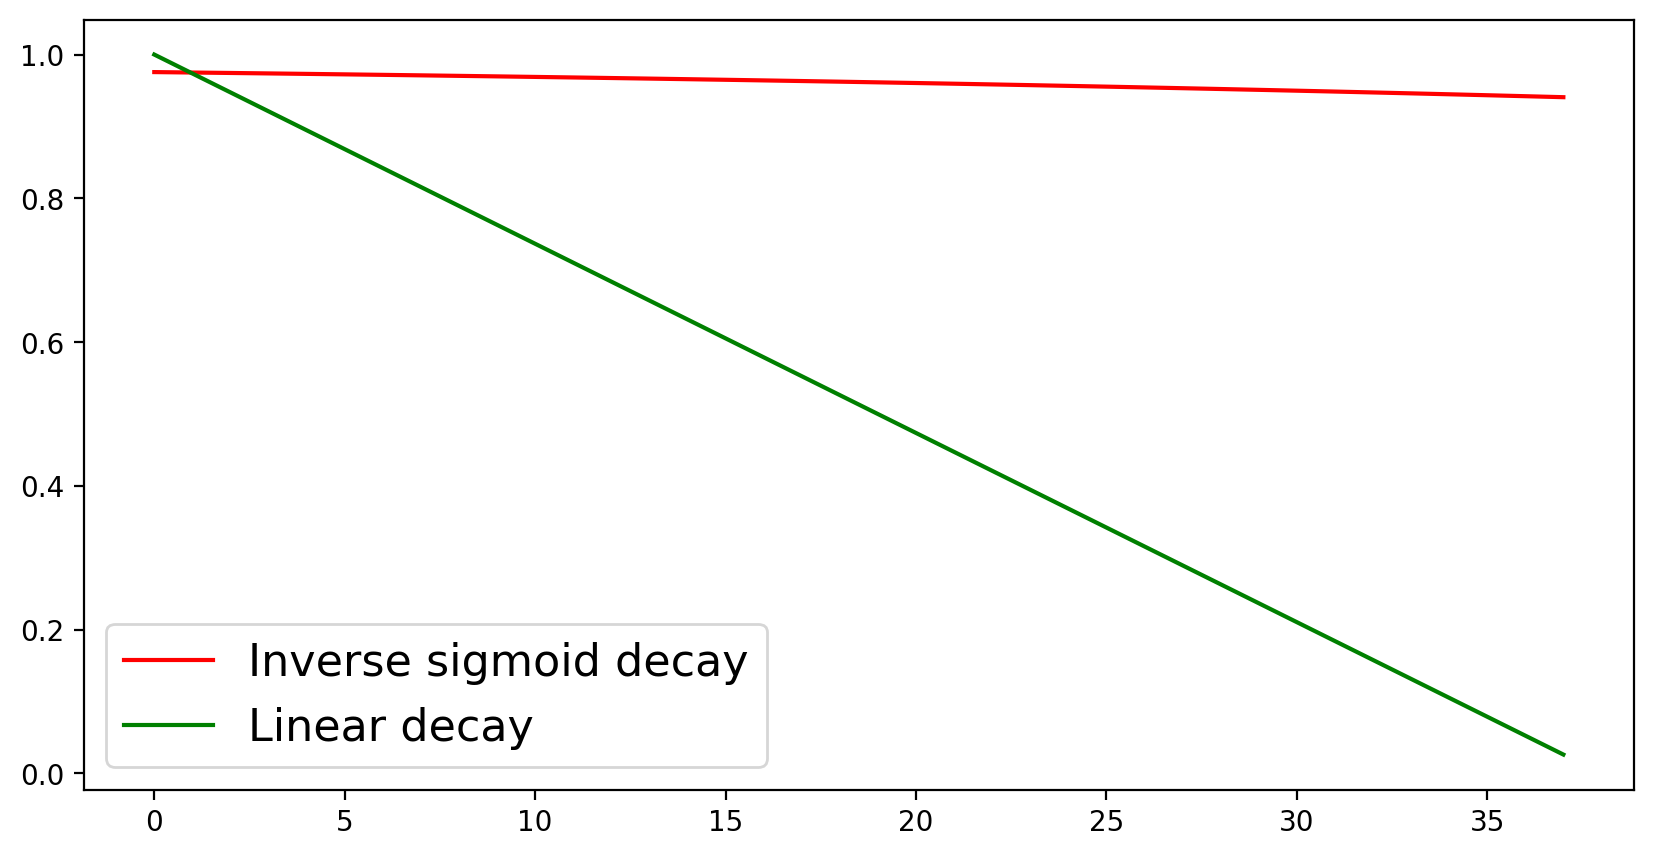

In [182]:
scheduled_decay_rate = 40

def lin_decay(i, mineps=0):
    return np.max([mineps, 1 - (1/len(train_loader))*i])

def inv_sigmoid_decay(i, rate=40):
    return rate/(rate + np.exp(i/rate))

eps = []
for i in range(len(train_loader)):
    eps_i = inv_sigmoid_decay(i, rate=scheduled_decay_rate)
    eps.append(eps_i)


eps2 = []
for i in range(len(train_loader)):
    eps_i = lin_decay(i, 0)
    eps2.append(eps_i)

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(eps, color="red")
ax.plot(eps2, color="green")
ax.legend(['Inverse sigmoid decay', 'Linear decay'], prop={'size': 16})

#### Warmup for training

Estimated time until completion: 16.67 hours / 1000.00 minutes/ 60000.00 seconds


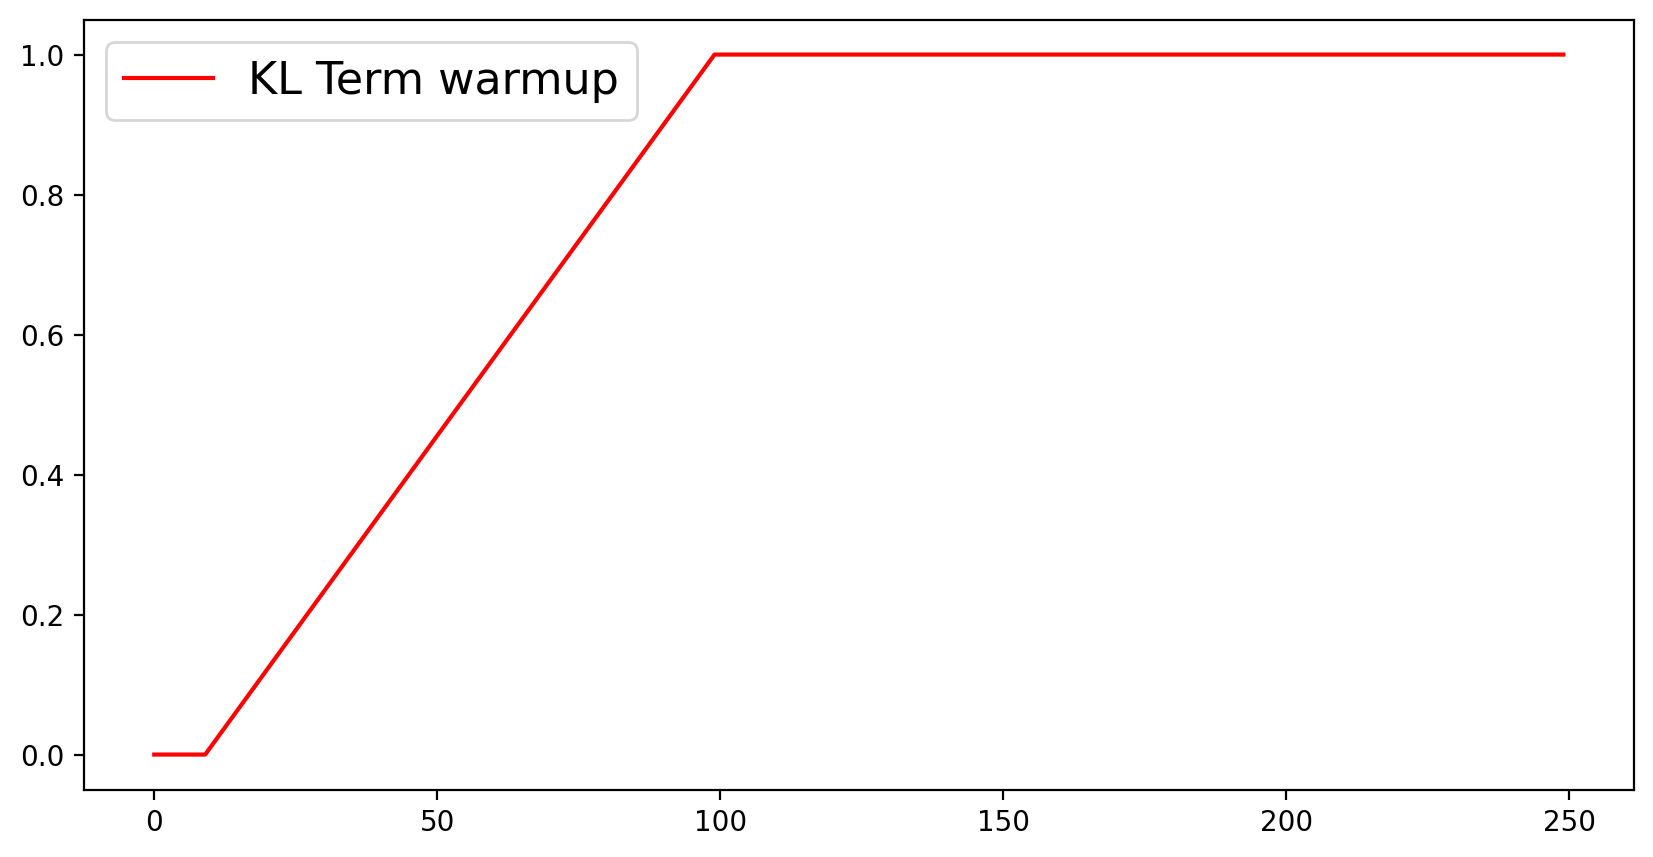

In [185]:
# 3 = ~12 minutes
#num_epochs = 200
#warmup_epochs= 90
#pre_warmup_epochs = 10
num_epochs = 250
warmup_epochs= 90
pre_warmup_epochs = 10

warmup_lerp = 1/warmup_epochs

if warmup_epochs > num_epochs - pre_warmup_epochs:
    warmup_epochs=num_epochs - pre_warmup_epochs


# Plot how the warmup looks
kl_w = 0
kls = []
for e in range(num_epochs):
    if e >= pre_warmup_epochs:
        kl_w = kl_w + warmup_lerp
        if kl_w > 1:
            kl_w=1.

    kls.append(kl_w)

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(kls, color="red")
ax.legend(['KL Term warmup'], prop={'size': 16})

est_time = 4*num_epochs
print("Estimated time until completion: {:.2f} hours / {:.2f} minutes/ {:.2f} seconds".format(est_time/60, est_time, est_time*60))

#### Train

In [187]:
tmp_img = "tmp_vae_out.png"

warmup_w=0

eps_i = 1
use_scheduled_sampling = False

train_loss, valid_loss = [], []
train_kl, valid_kl,train_klw = [], [],[]

start = time.time()

print("Training epoch {}".format(0))
#epochs loop
for epoch in range(num_epochs):

    batch_loss, batch_kl,batch_klw = [], [],[]
    net.train()

    for i_batch, sample_batched in enumerate(train_loader):
        #if i_batch == 10:
        #    break
        x = sample_batched['piano_rolls']

        x = x.type('torch.FloatTensor')

        #if i_batch%10==0:
        #    print("batch:",i_batch)

        x = Variable(x)

        # This is an alternative way of putting
        # a tensor on the GPU
        x = x.to(device)

        ## Calc the sched sampling rate:
        if epoch >= pre_warmup_epochs and use_scheduled_sampling:
            eps_i = inv_sigmoid_decay(i_batch, rate=scheduled_decay_rate)

        net.set_scheduled_sampling(eps_i)

        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']

        elbo, kl,kl_w = loss_function(x_hat, x, mu, log_var, warmup_w)

        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()

        batch_loss.append(elbo.item())
        batch_kl.append(kl.item())
        batch_klw.append(kl_w.item())
    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))
    train_klw.append(np.mean(batch_klw))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()

        # Just load a single batch from the test loader
        x = next(iter(test_loader))
        x = Variable(x['piano_rolls'].type('torch.FloatTensor'))

        x = x.to(device)

        net.set_scheduled_sampling(1.) # Please use teacher forcing for validations
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]

        elbo, kl,klw = loss_function(x_hat, x, mu, log_var, warmup_w)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()

        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())

    if epoch >= pre_warmup_epochs:
        warmup_w = warmup_w + warmup_lerp
        if warmup_w > 1:
            warmup_w=1.

    if epoch == 0:
        continue

    # -- Plotting --
    f, axarr = plt.subplots(2, 1, figsize=(10, 10))


    # Loss
    ax = axarr[0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch+1), train_loss, color="black")
    ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])


    # KL / reconstruction
    ax = axarr[1]

    ax.set_title("Kullback-Leibler Divergence")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KL divergence')


    ax.plot(np.arange(epoch+1), train_kl, color="black")
    ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")
    ax.plot(np.arange(epoch+1), train_klw, color="blue", linestyle="--")
    ax.legend(['Training', 'Validation','Weighted'])

    print("Epoch: {}, {} seconds elapsed".format(epoch, time.time() - start))

    plt.savefig(tmp_img)
    plt.close(f)
    ipd.display(Image(filename=tmp_img))

    clear_output(wait=True)

    os.remove(tmp_img)

end_time = time.time() - start
print("Finished. Time elapsed: {} seconds".format(end_time))

Finished. Time elapsed: 1858.0635206699371 seconds


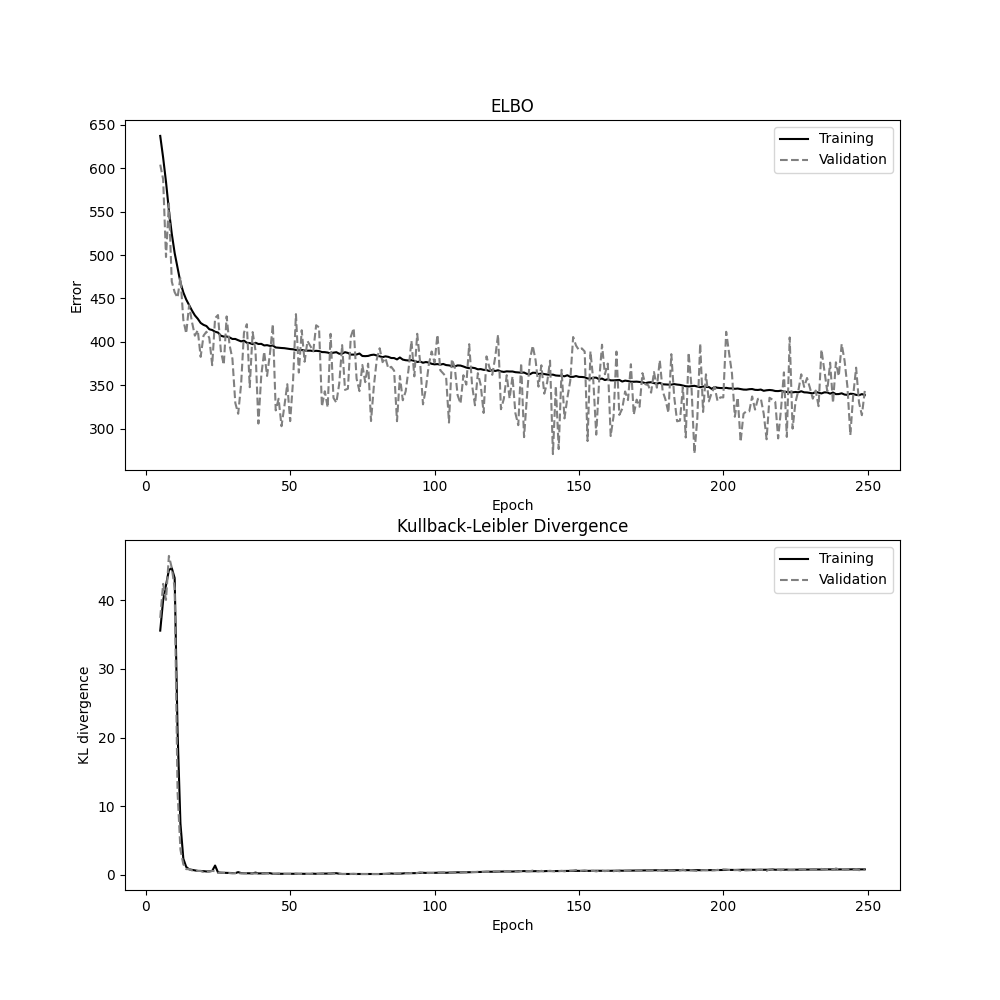

Time elapsed: 1858.0635206699371 seconds
-----
Final KL. Train: 0.7920905947685242, Validation: 0.7668744921684265
Final loss. Train: 338.77269222861844, Validation: 343.5496826171875


In [218]:
### Plot metrics
skip = 5
save_img = os.path.join("midi","kl_elbo.png")
if skip > num_epochs:
    print("Can't skip more than epochs run.")
    skip = 0

f, axarr = plt.subplots(2, 1, figsize=(10, 10))

# Loss
ax = axarr[0]
ax.set_title("ELBO")
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')

ax.plot(np.arange(skip, epoch+1), train_loss[skip:], color="black")
ax.plot(np.arange(skip, epoch+1), valid_loss[skip:], color="gray", linestyle="--")
ax.legend(['Training', 'Validation'])

# KL / reconstruction
ax = axarr[1]

ax.set_title("Kullback-Leibler Divergence")
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')


ax.plot(np.arange(skip, epoch+1), train_kl[skip:], color="black")
ax.plot(np.arange(skip, epoch+1), valid_kl[skip:], color="gray", linestyle="--")
ax.legend(['Training', 'Validation'])

plt.savefig(save_img)
plt.close(f)
ipd.display(Image(filename=save_img))

print("Time elapsed: {} seconds".format(end_time))

print("-----")

print("Final KL. Train: {}, Validation: {}".format(train_kl[-1], valid_kl[-1]))
print("Final loss. Train: {}, Validation: {}".format(train_loss[-1], valid_loss[-1]))

#### Show reconstructions

<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyq

Midi: 49 is all silent


<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyq

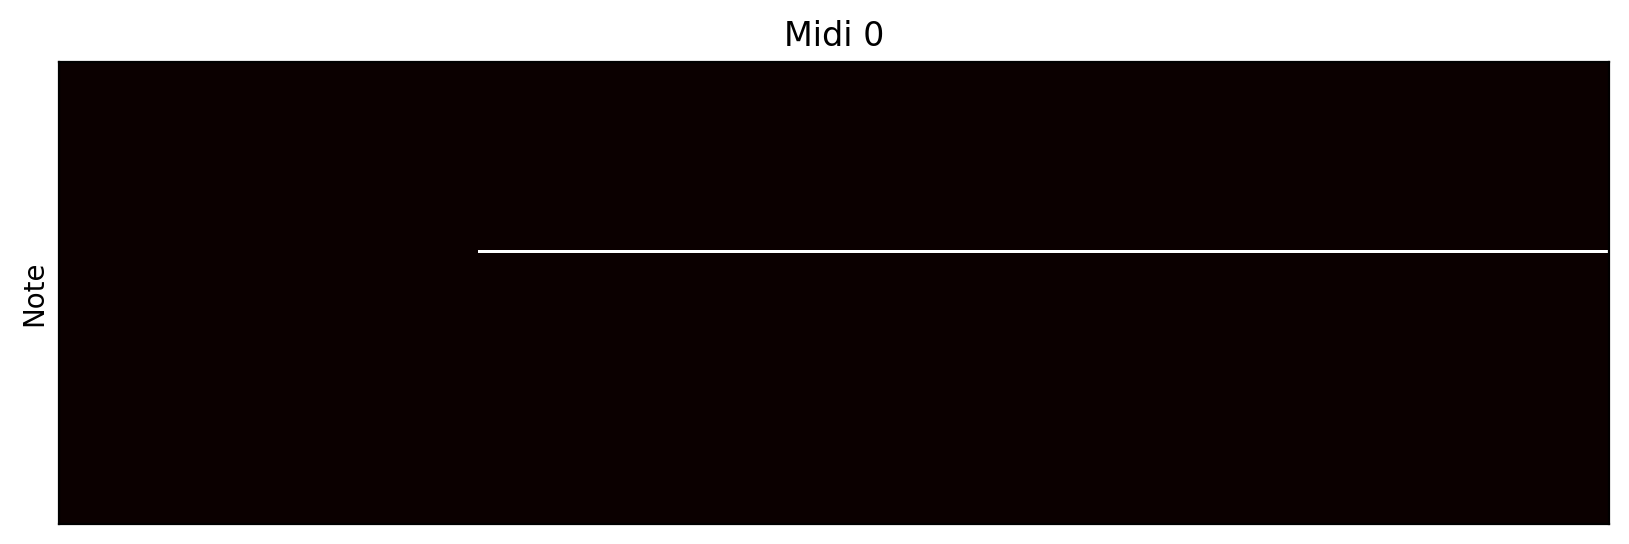

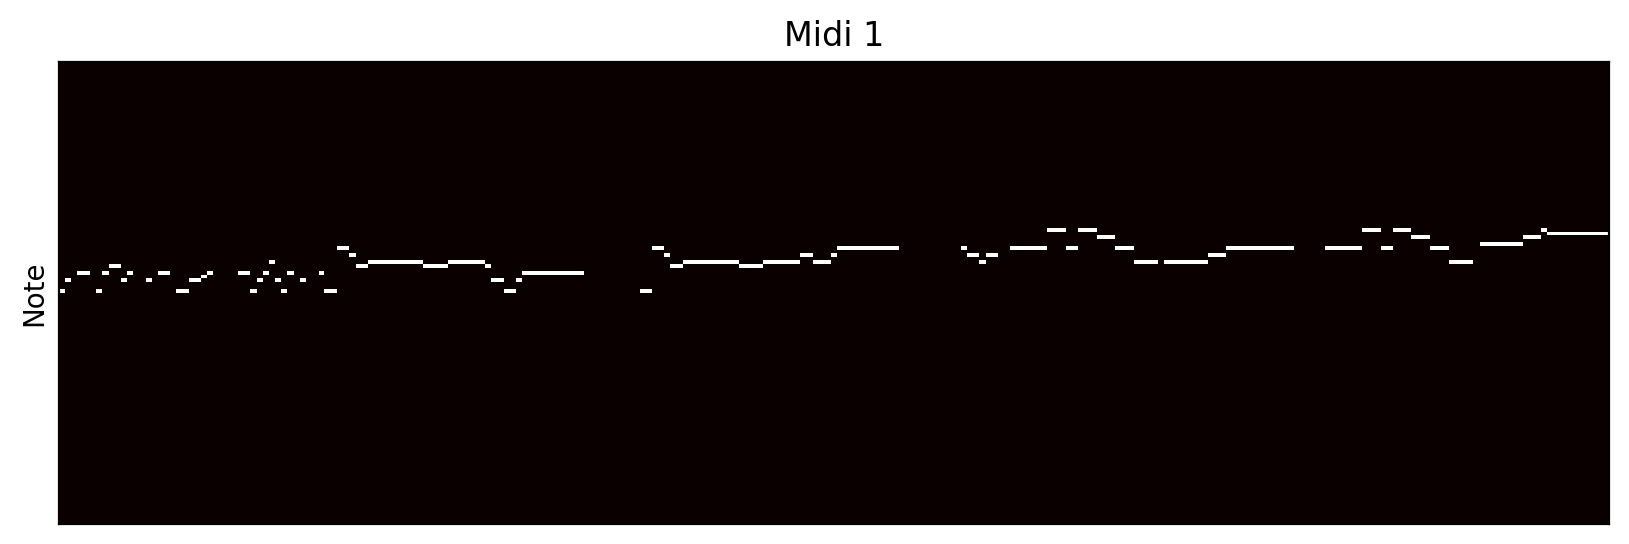

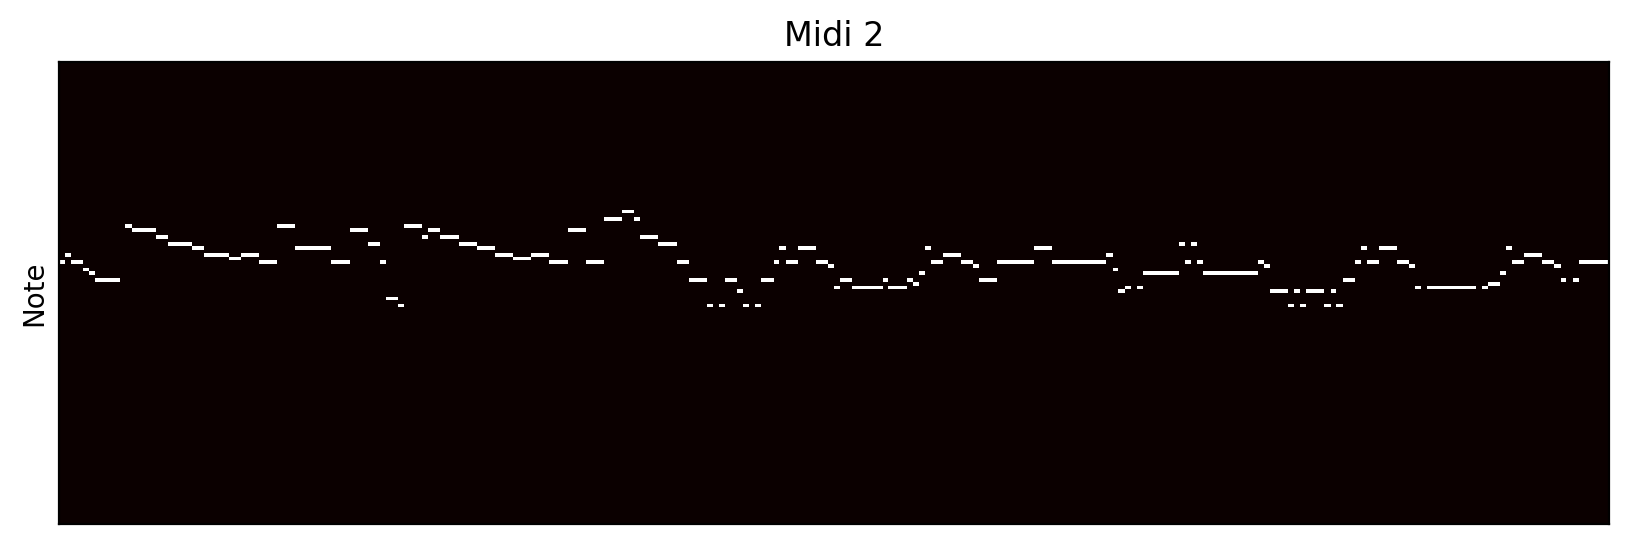

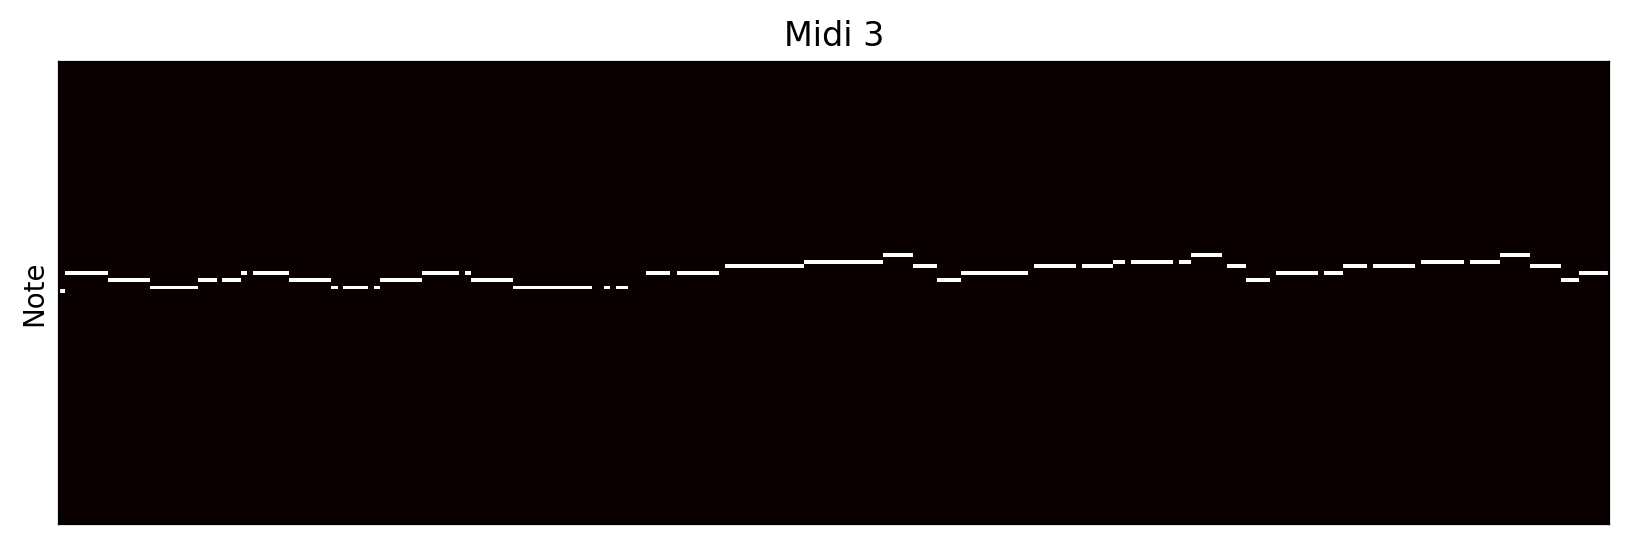

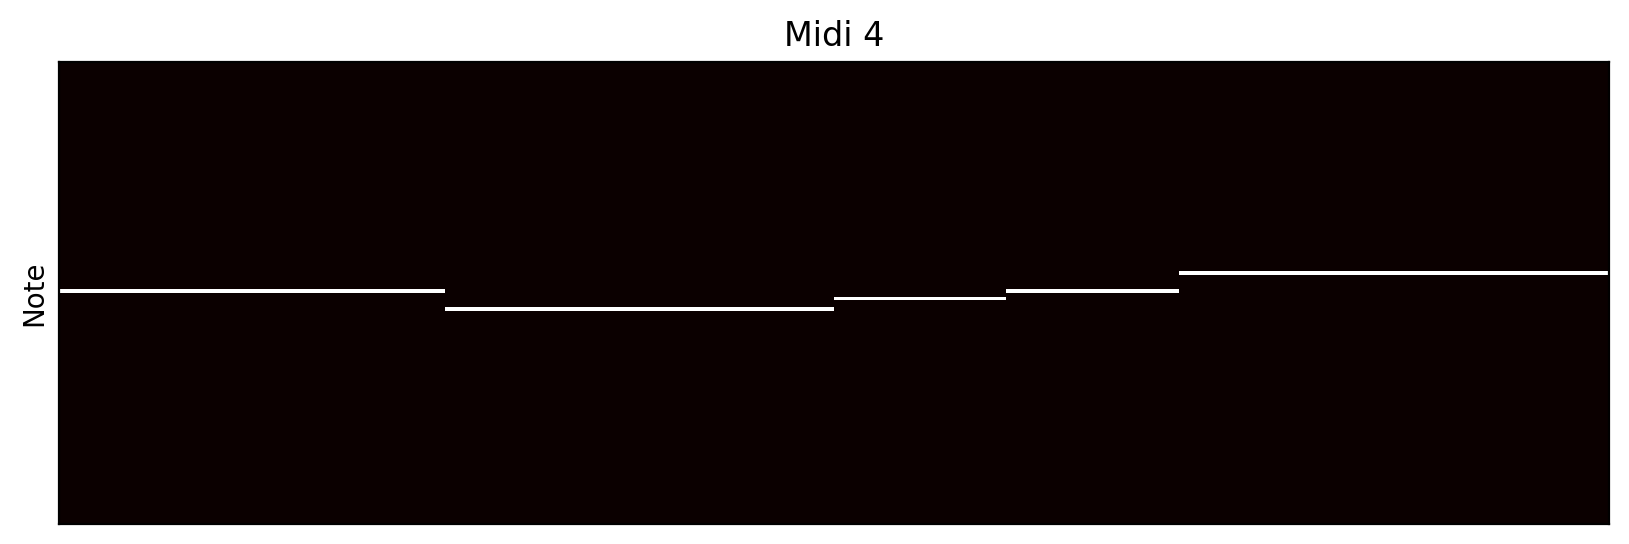

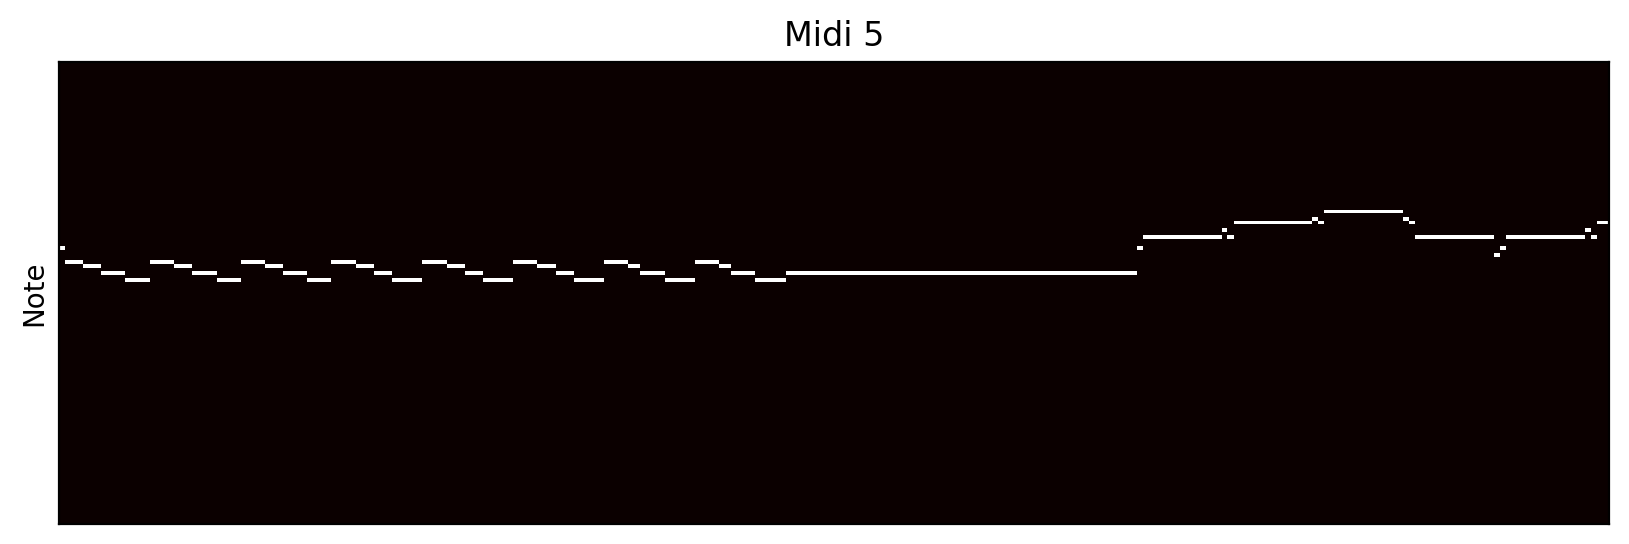

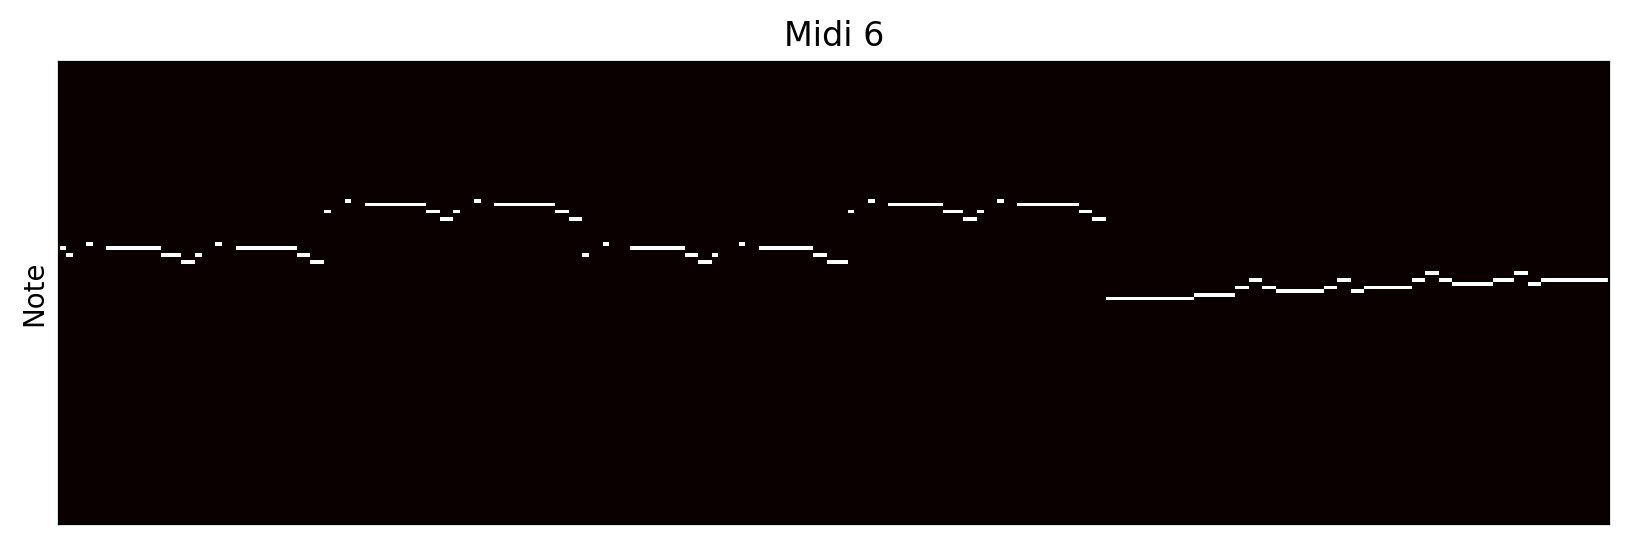

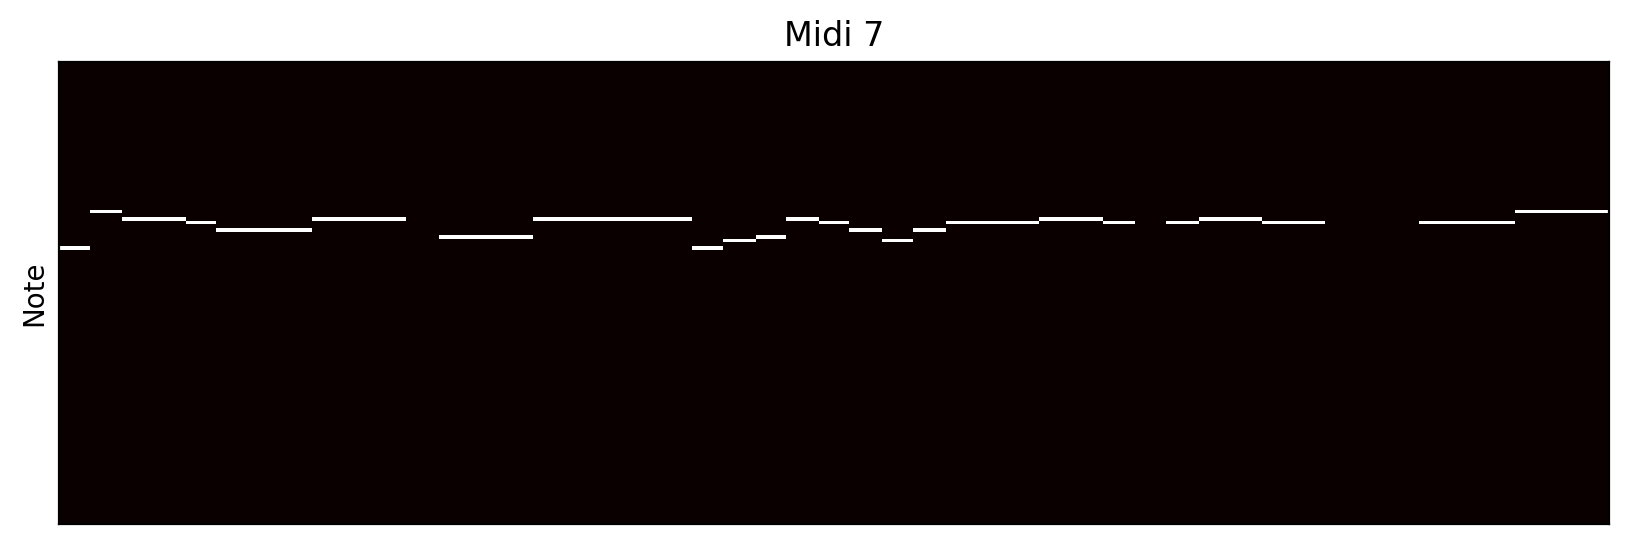

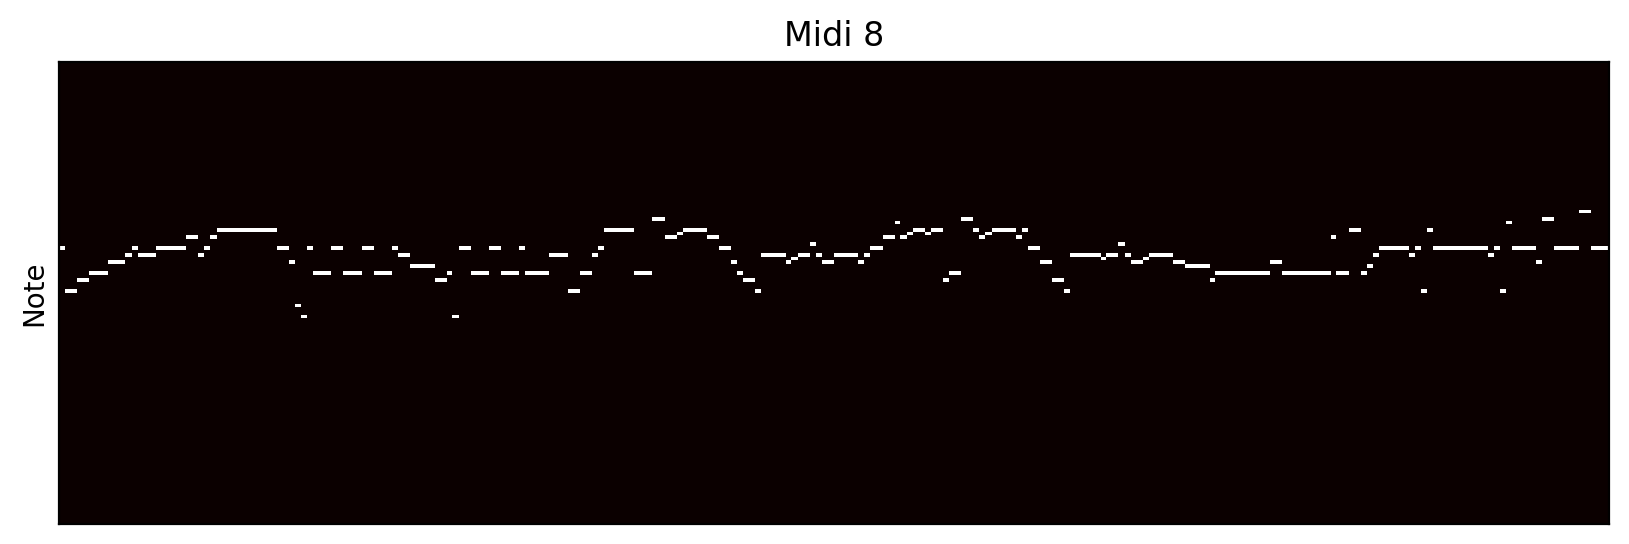

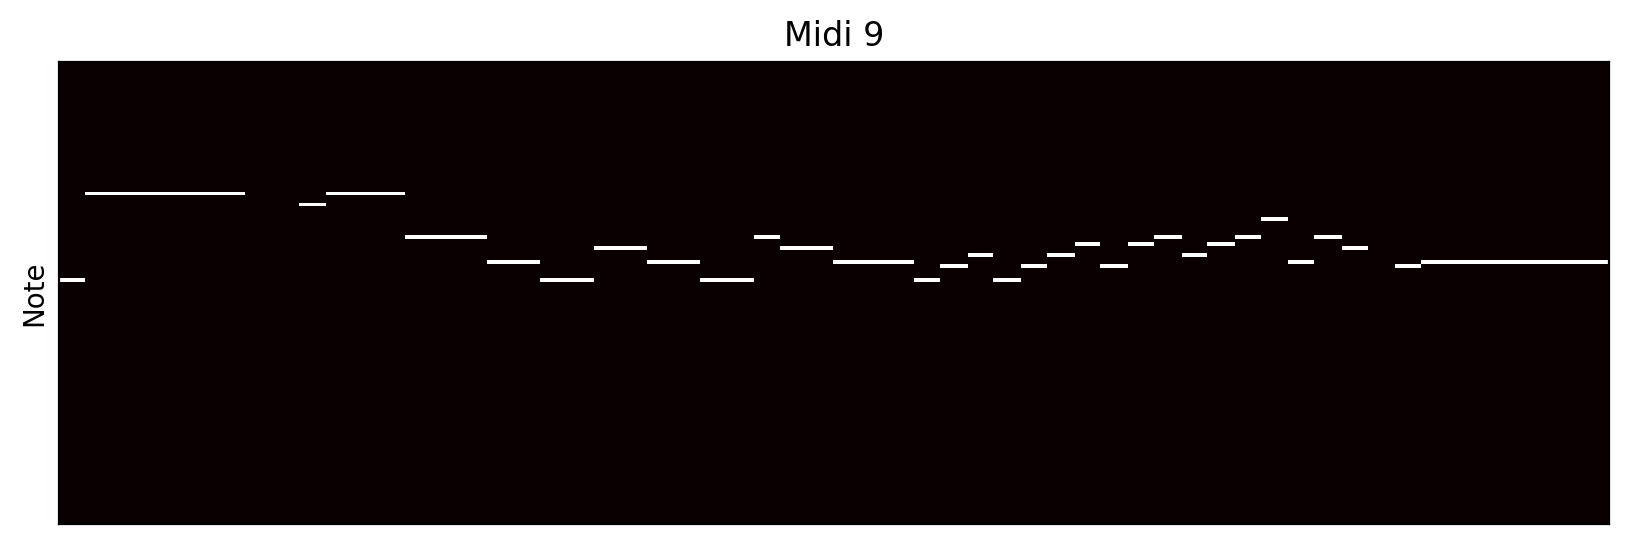

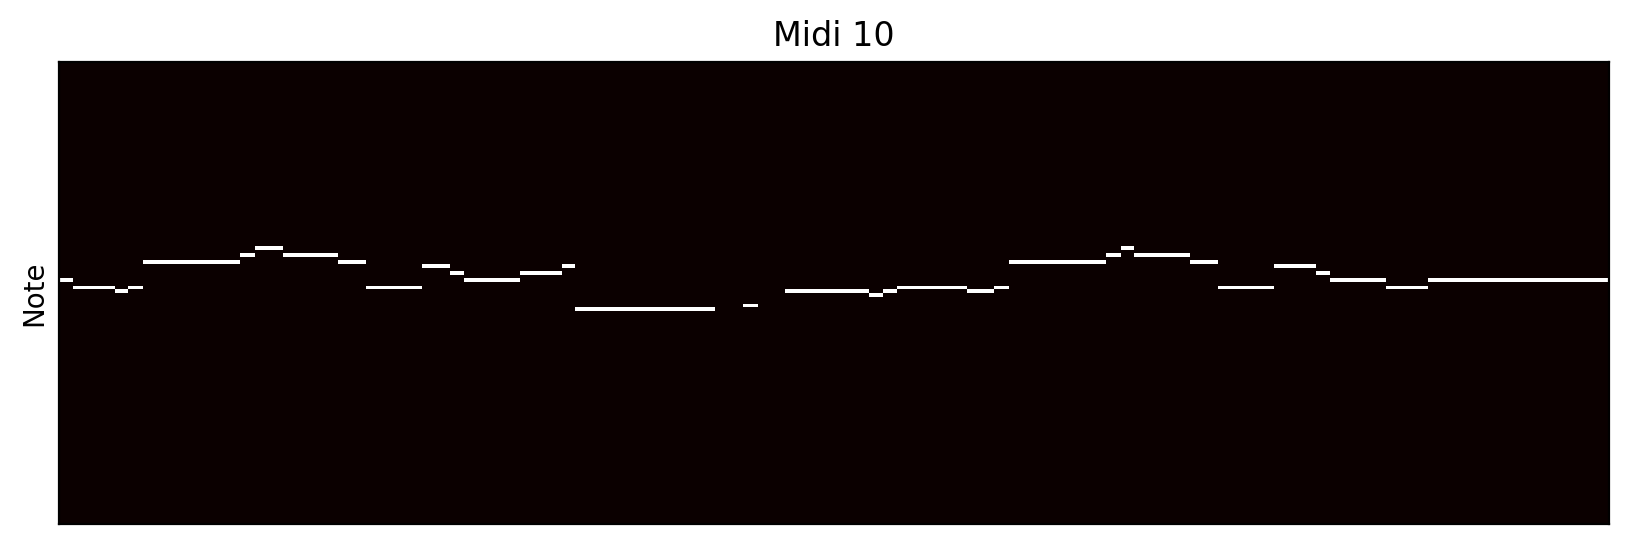

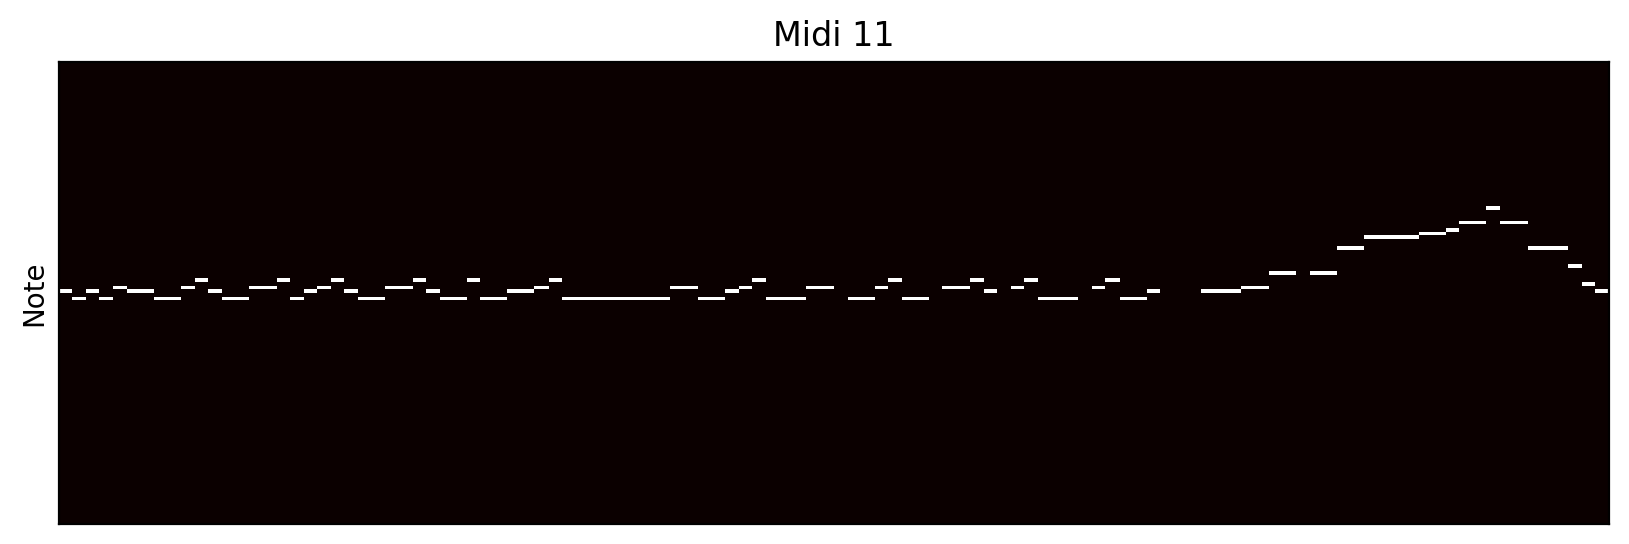

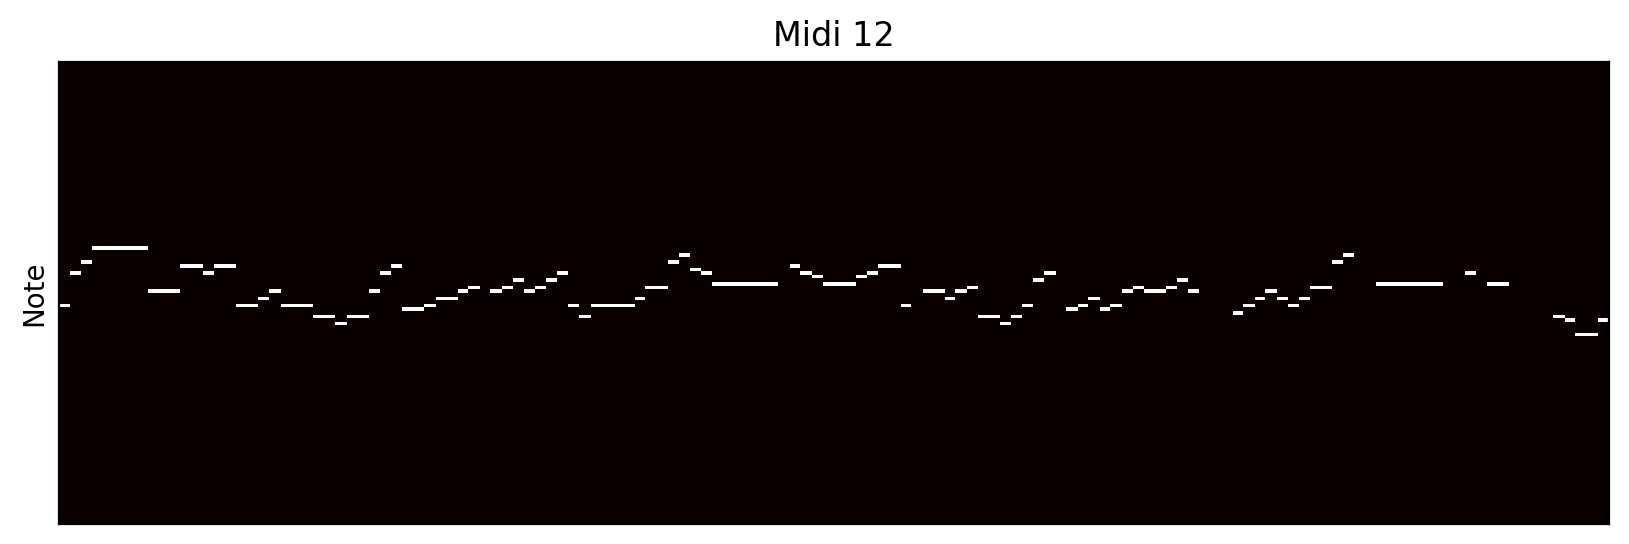

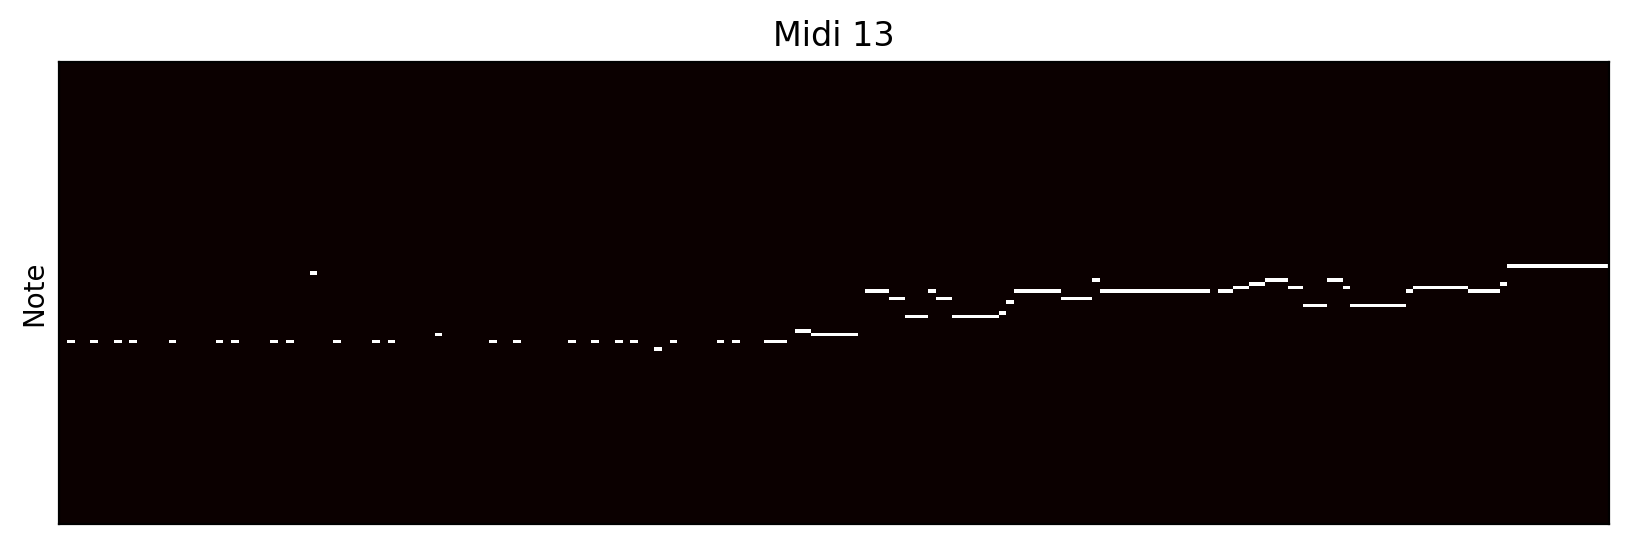

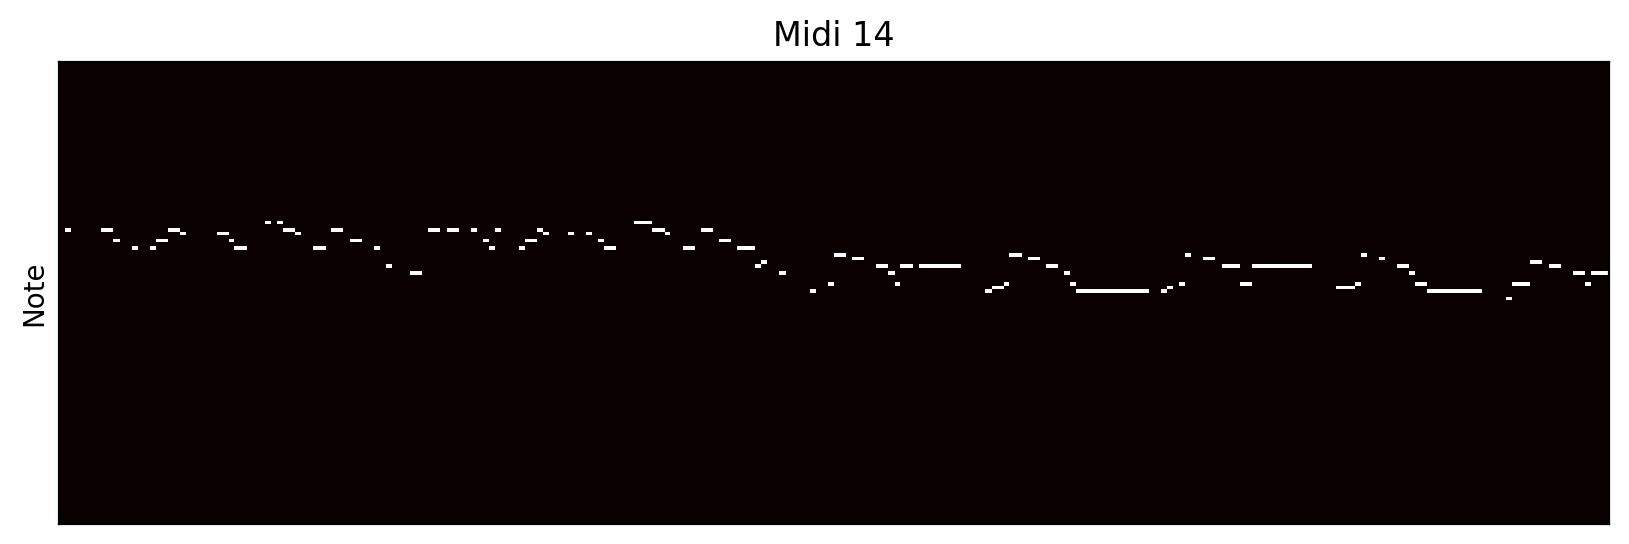

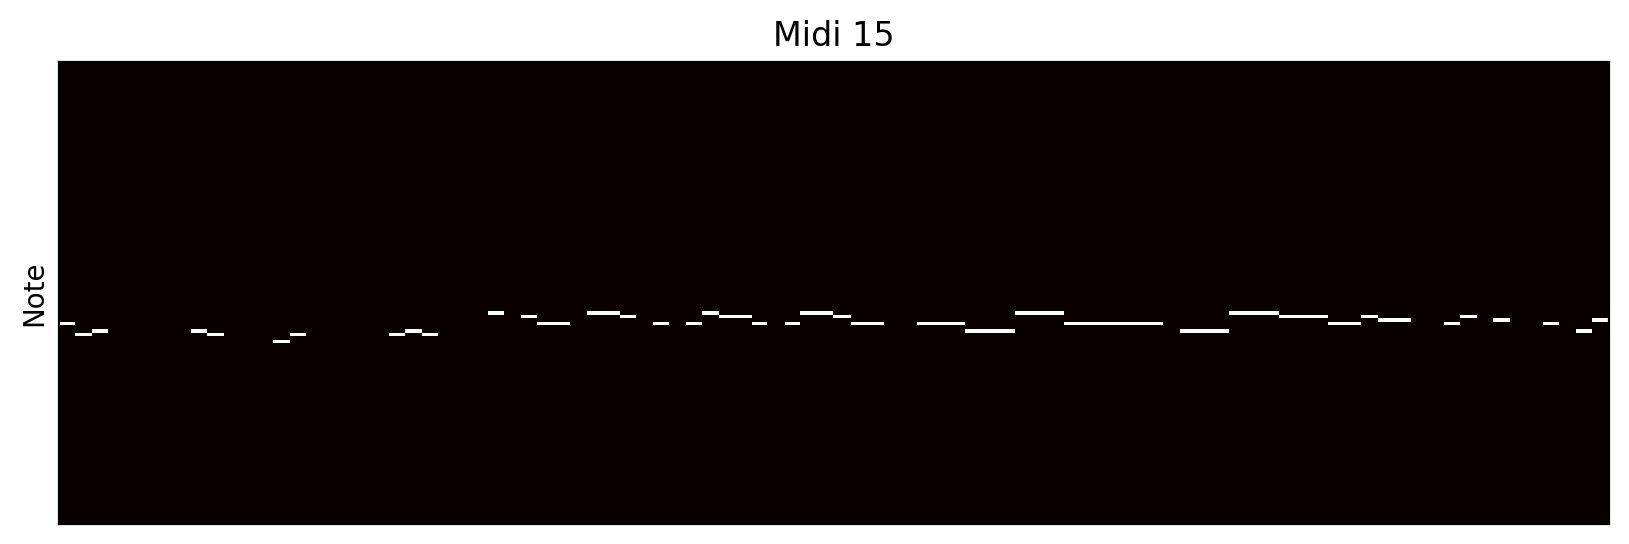

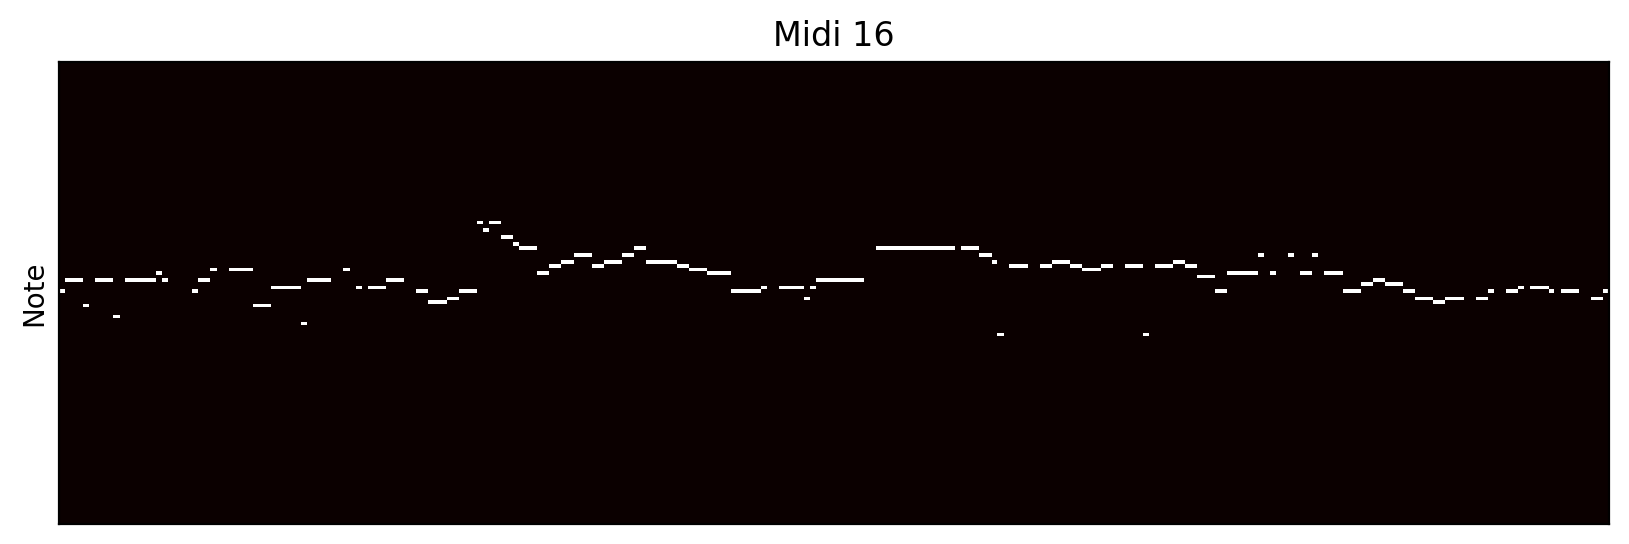

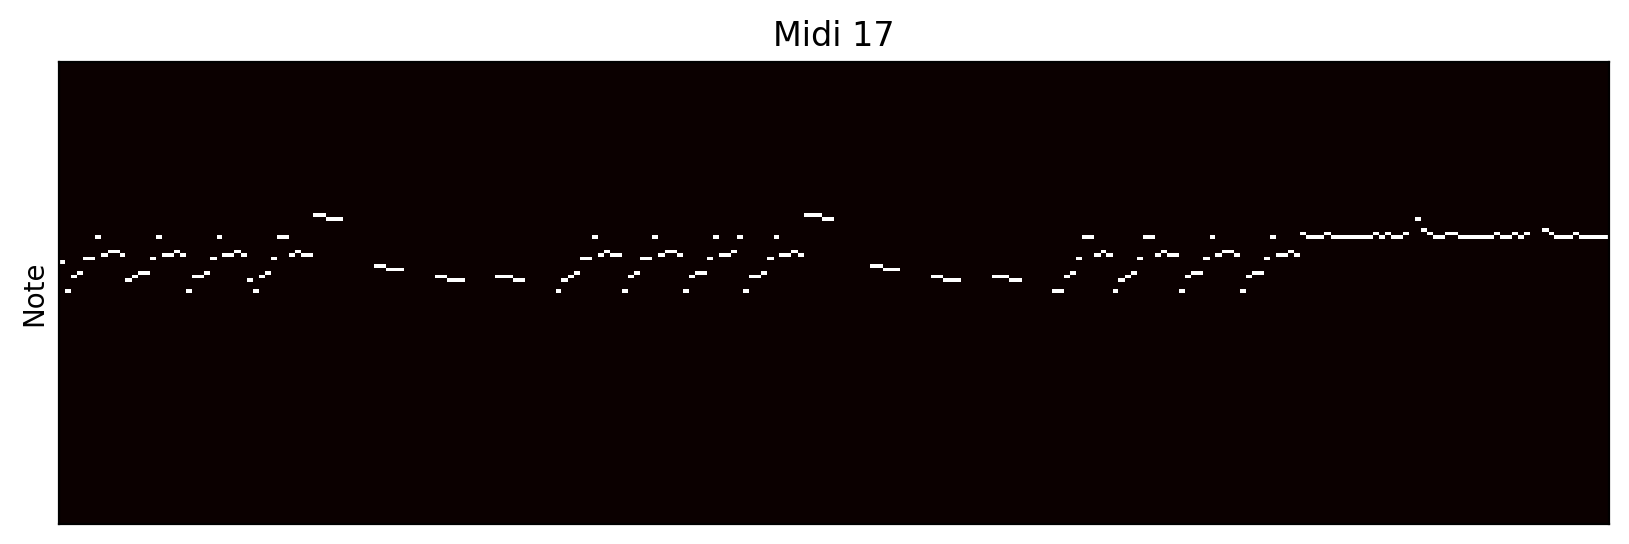

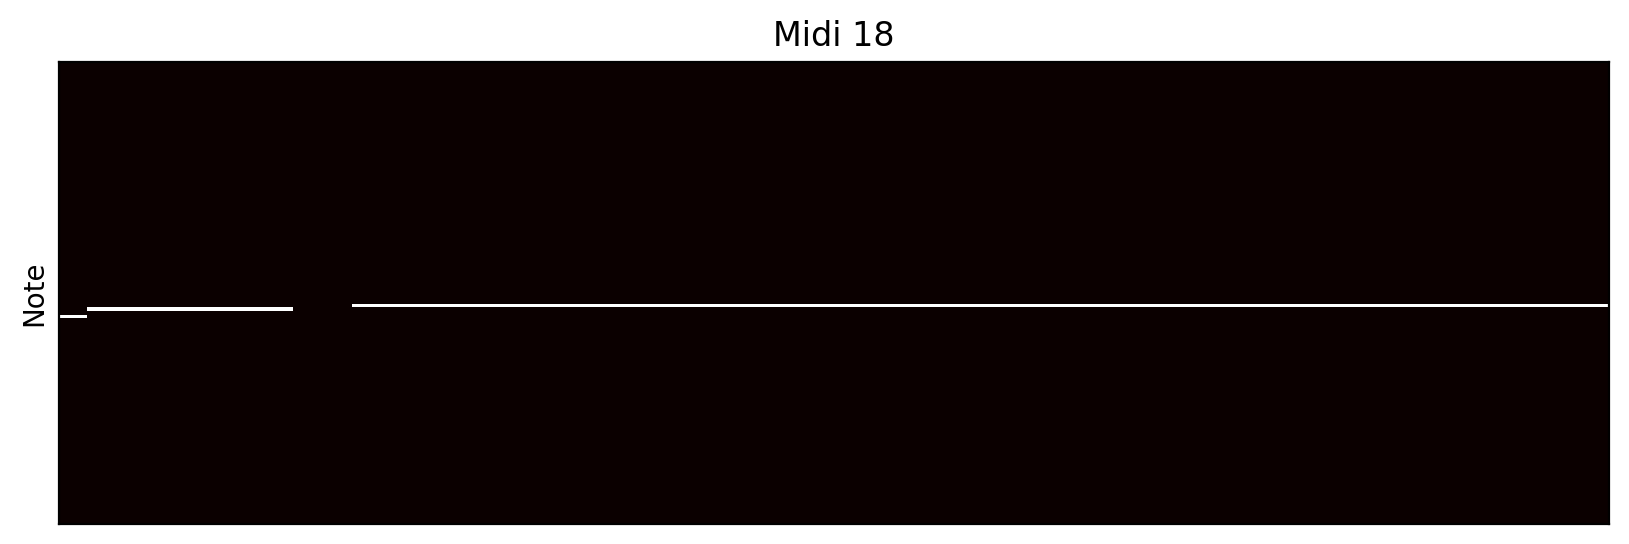

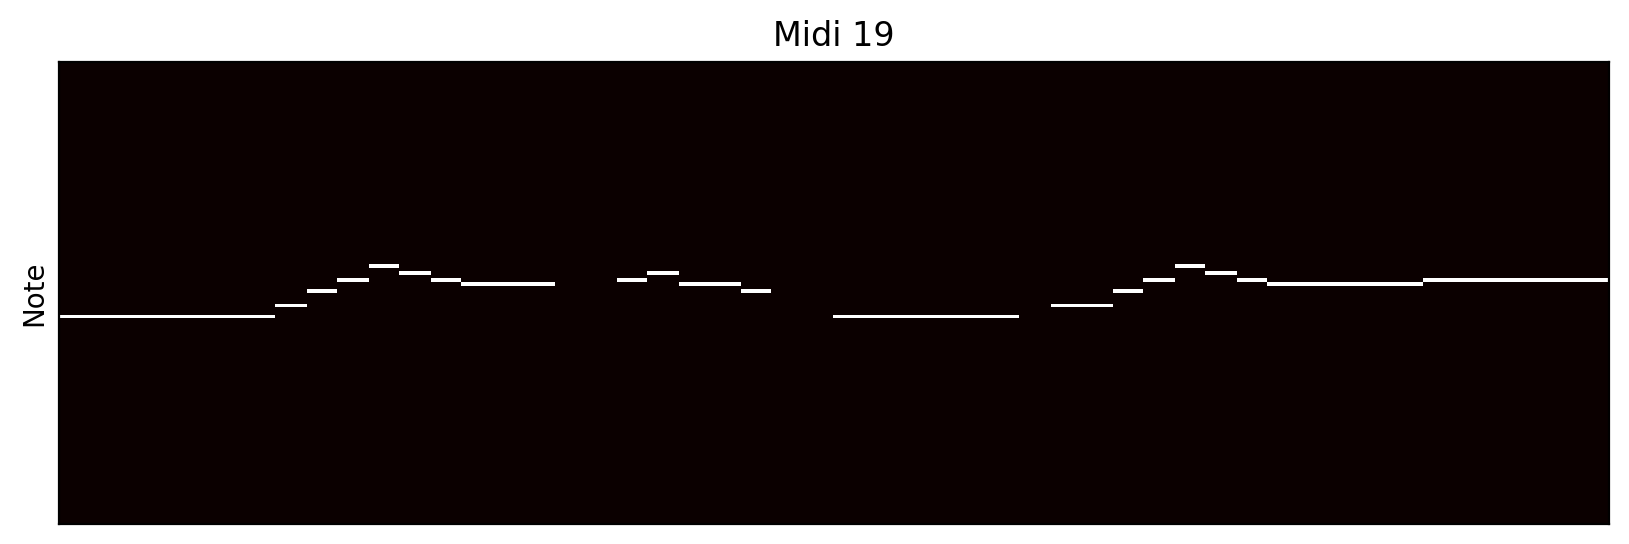

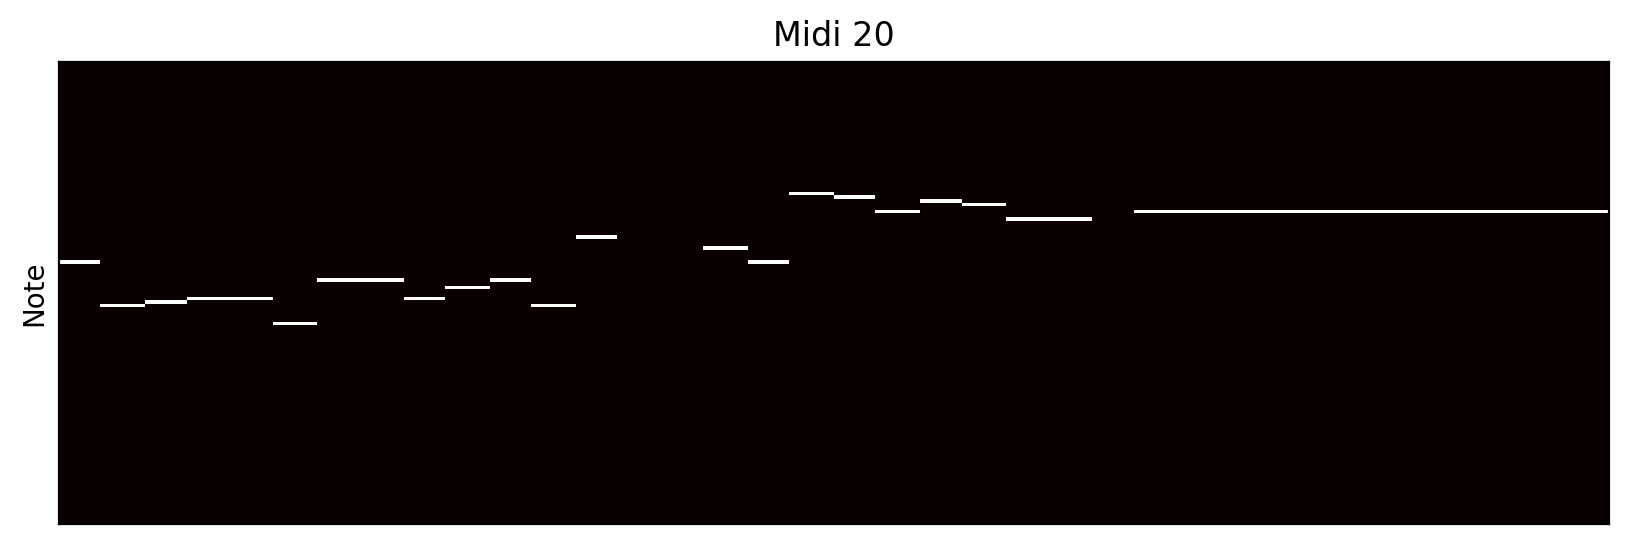

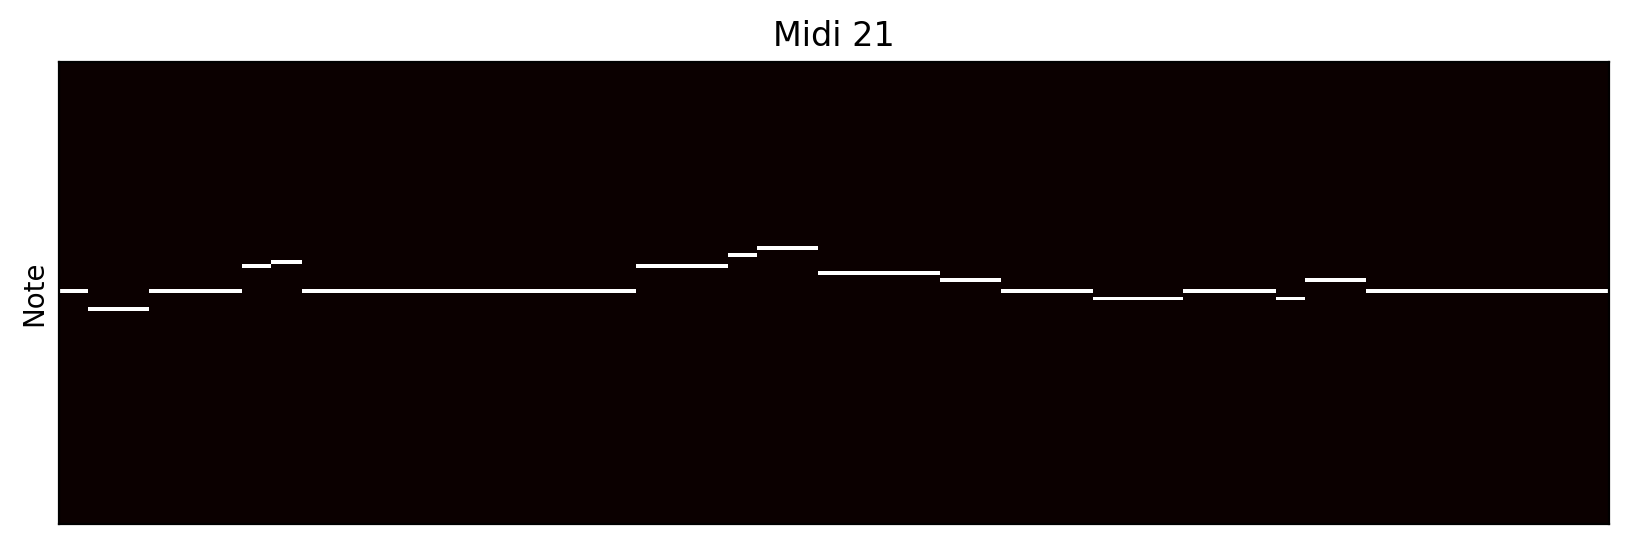

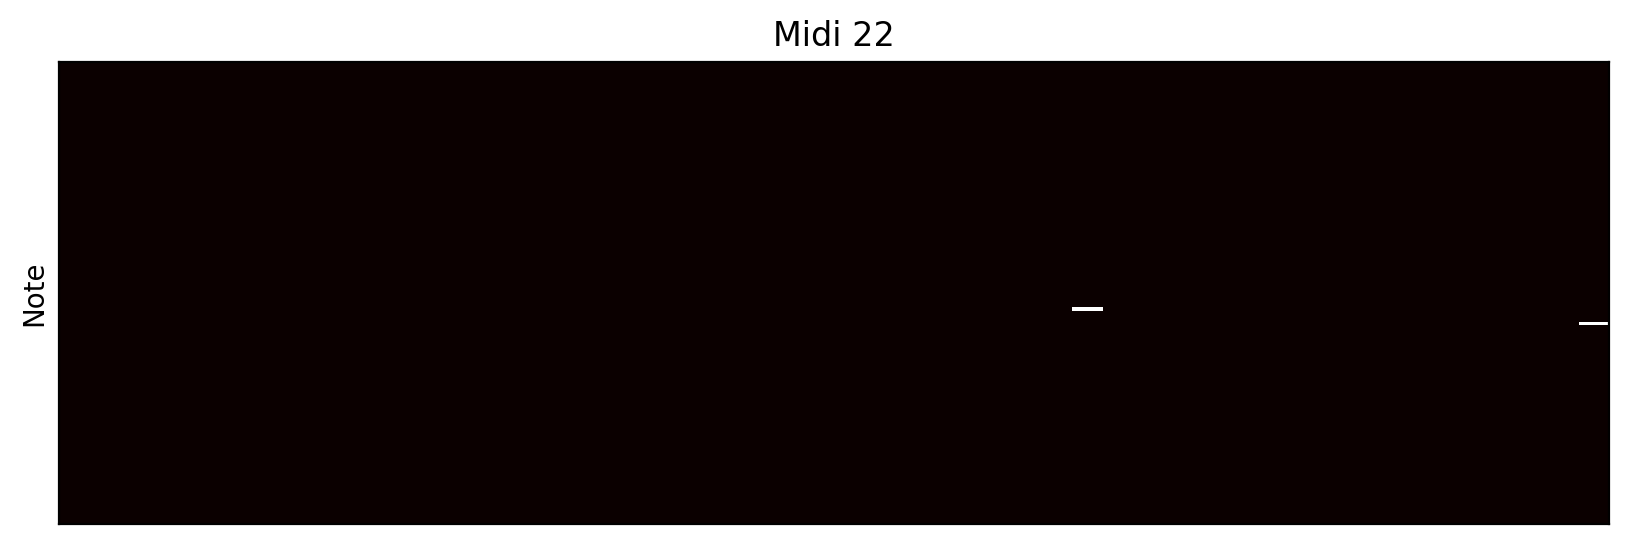

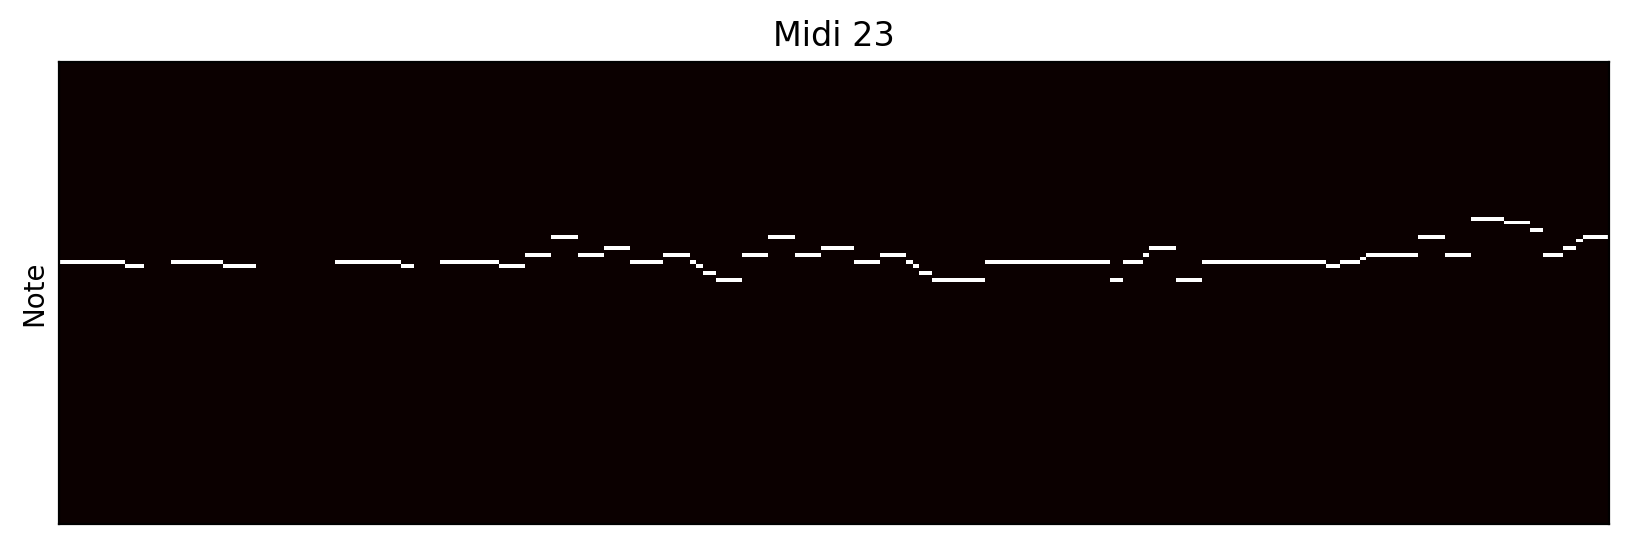

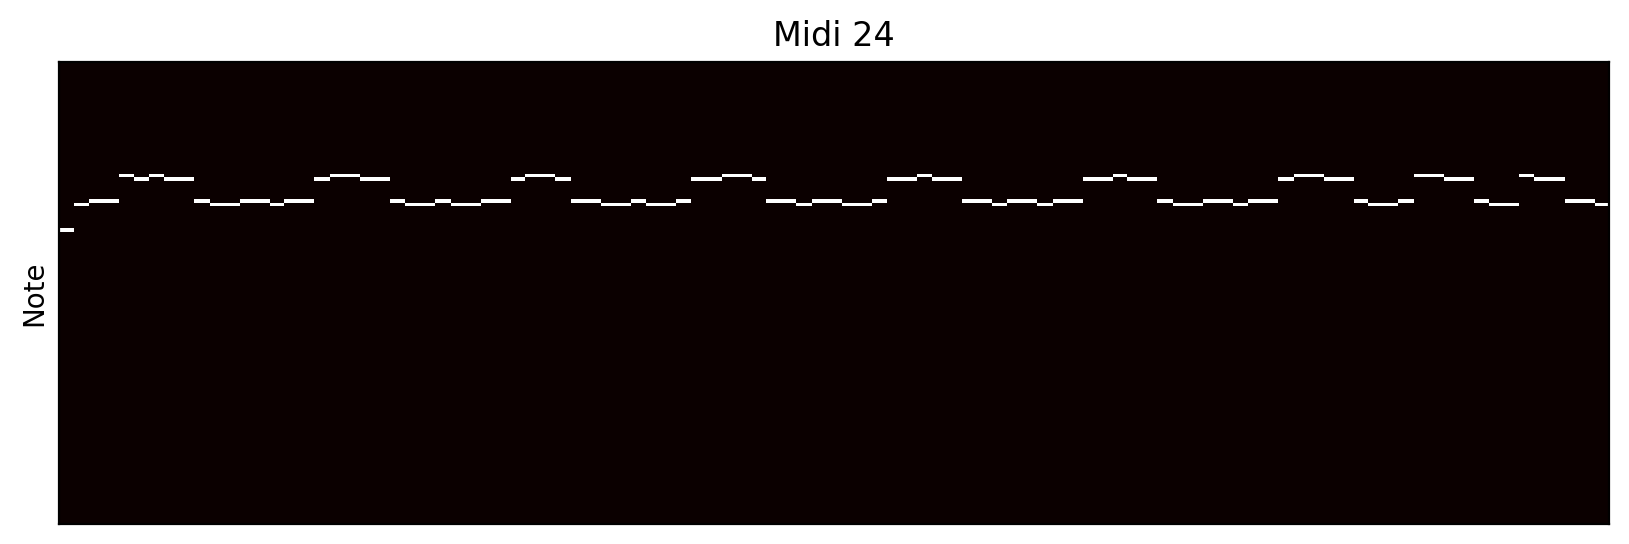

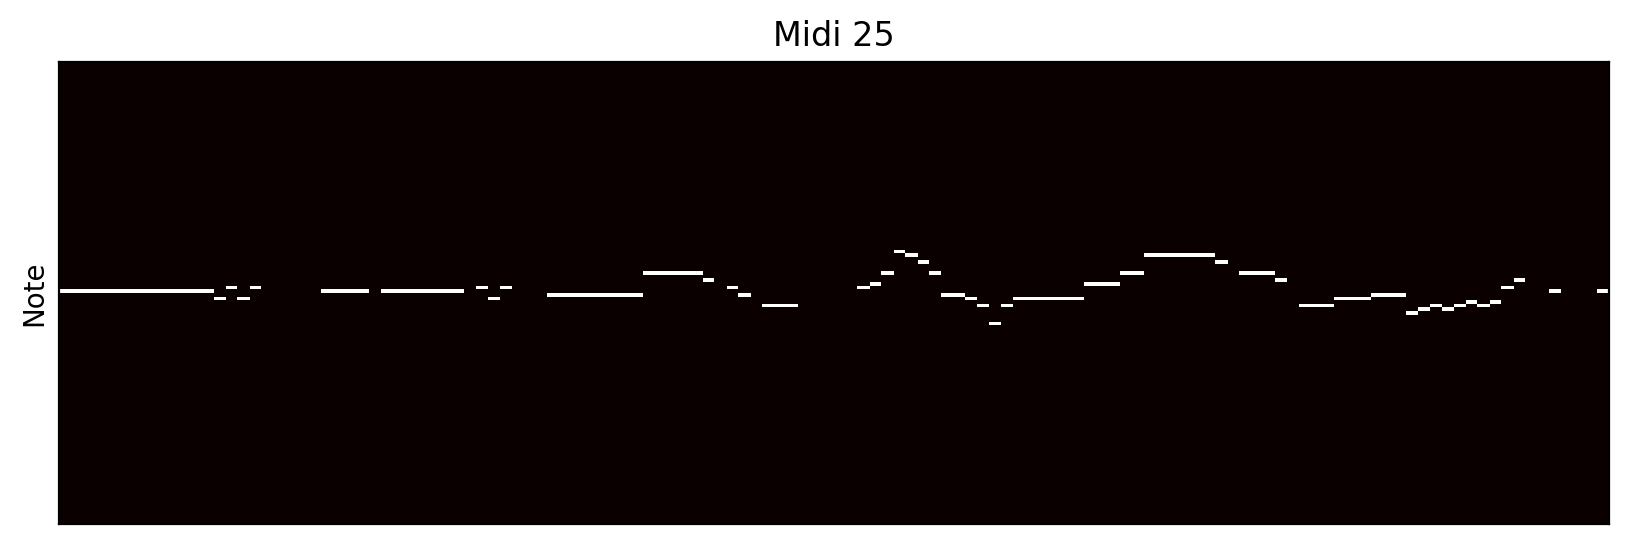

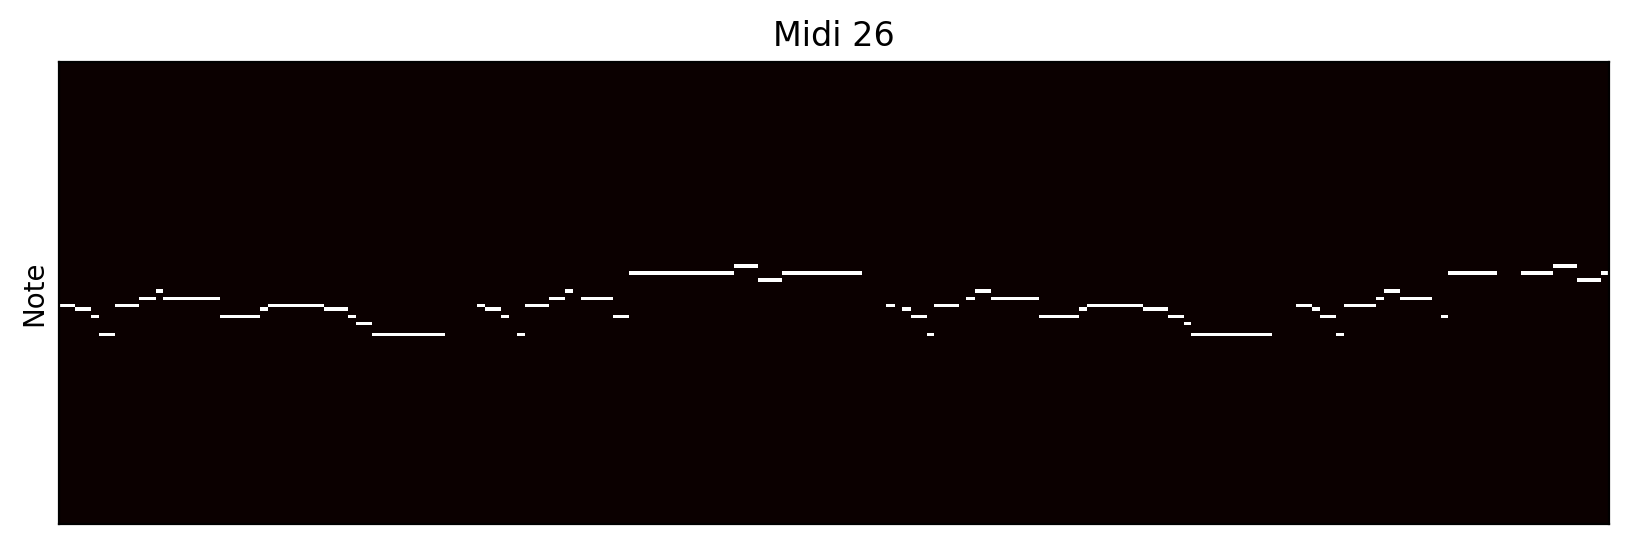

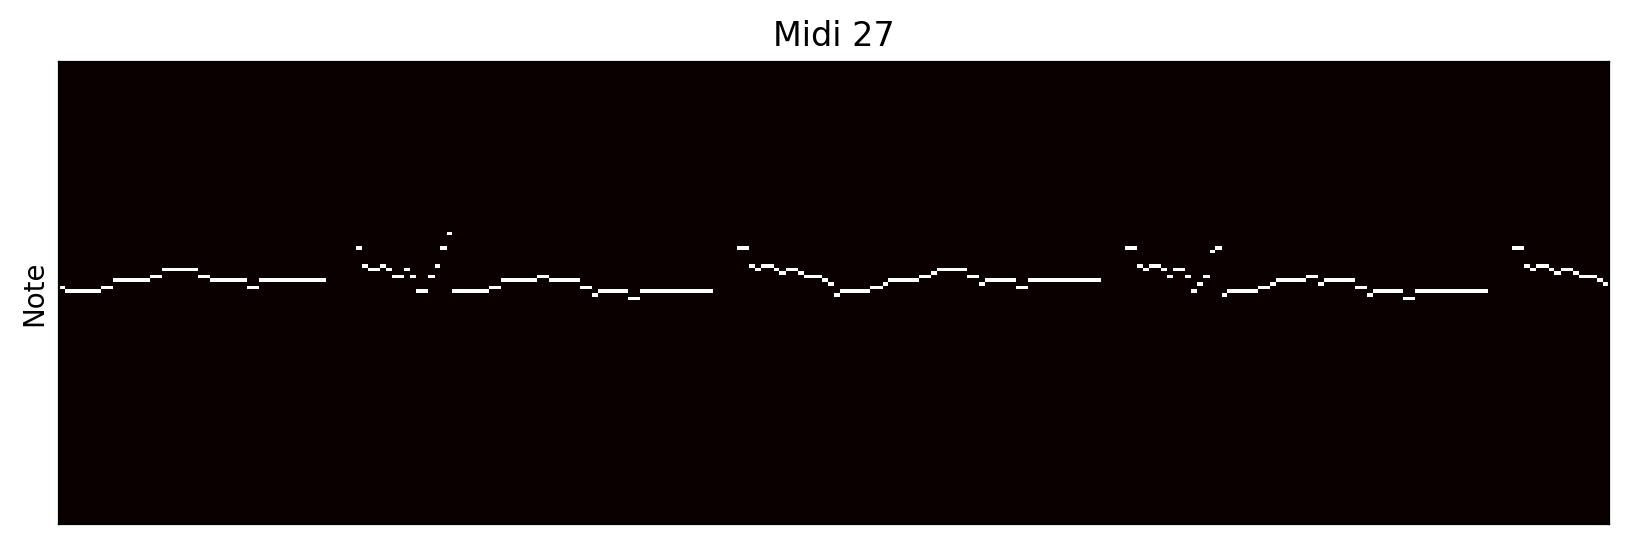

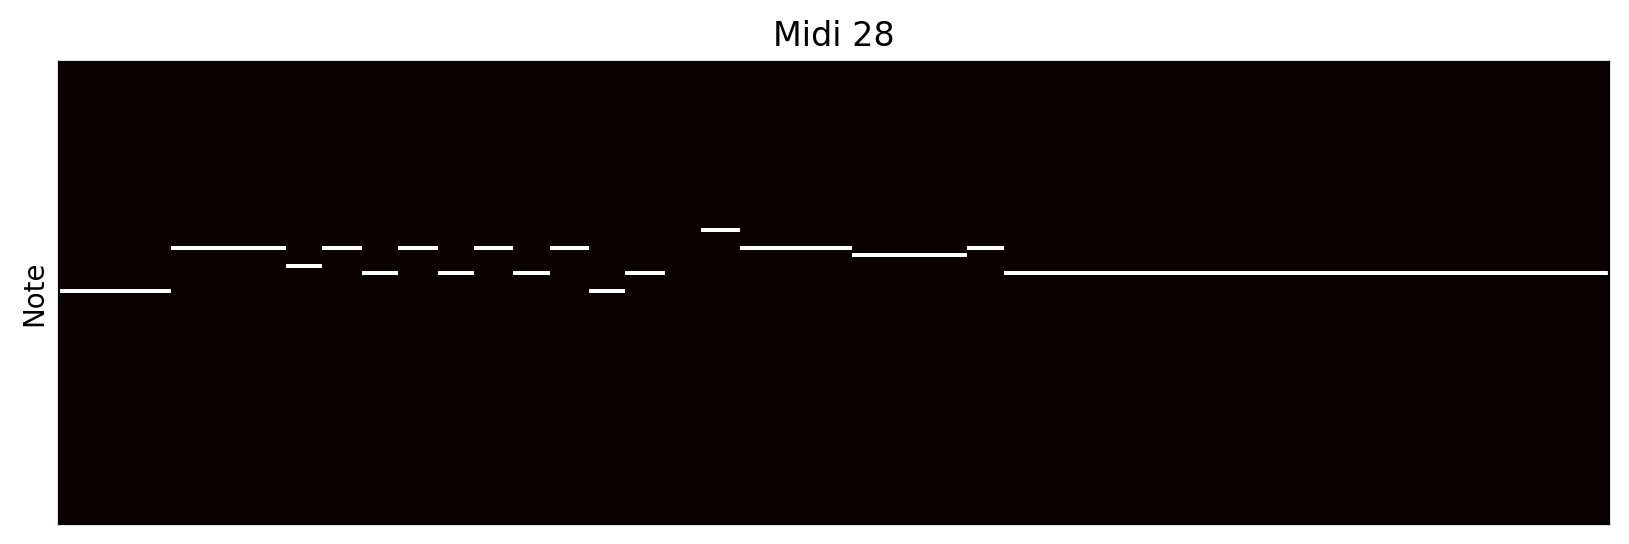

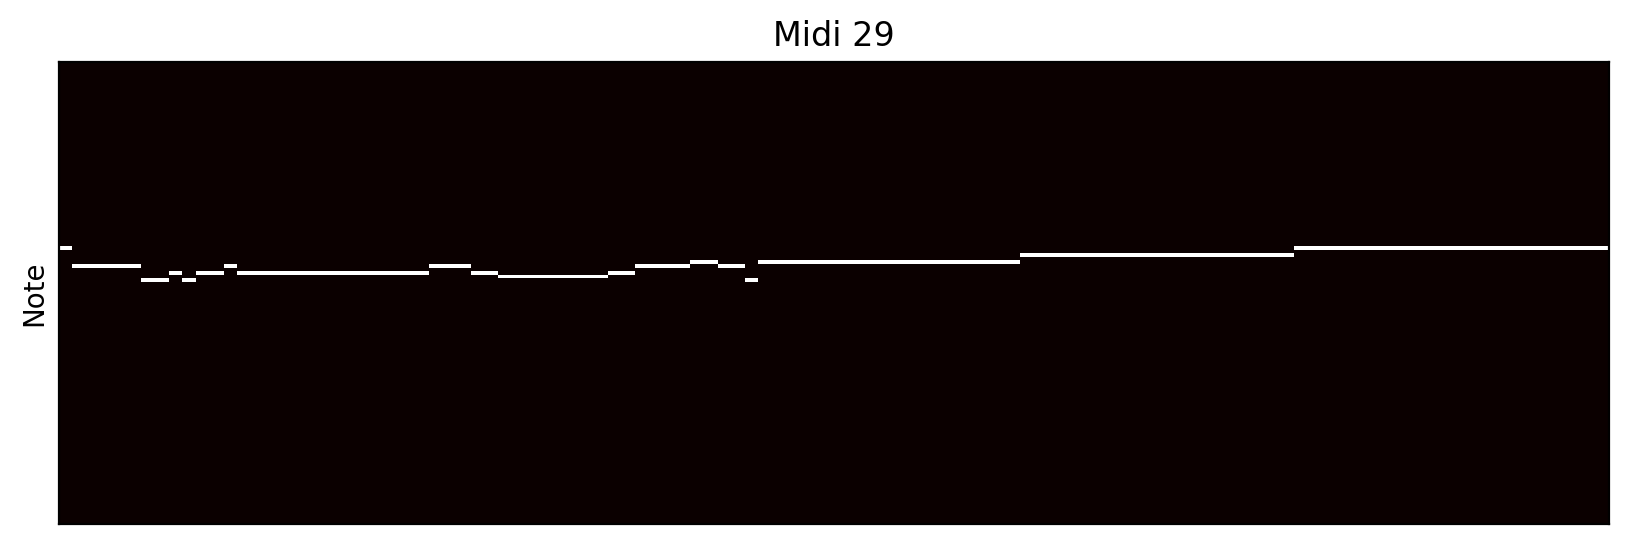

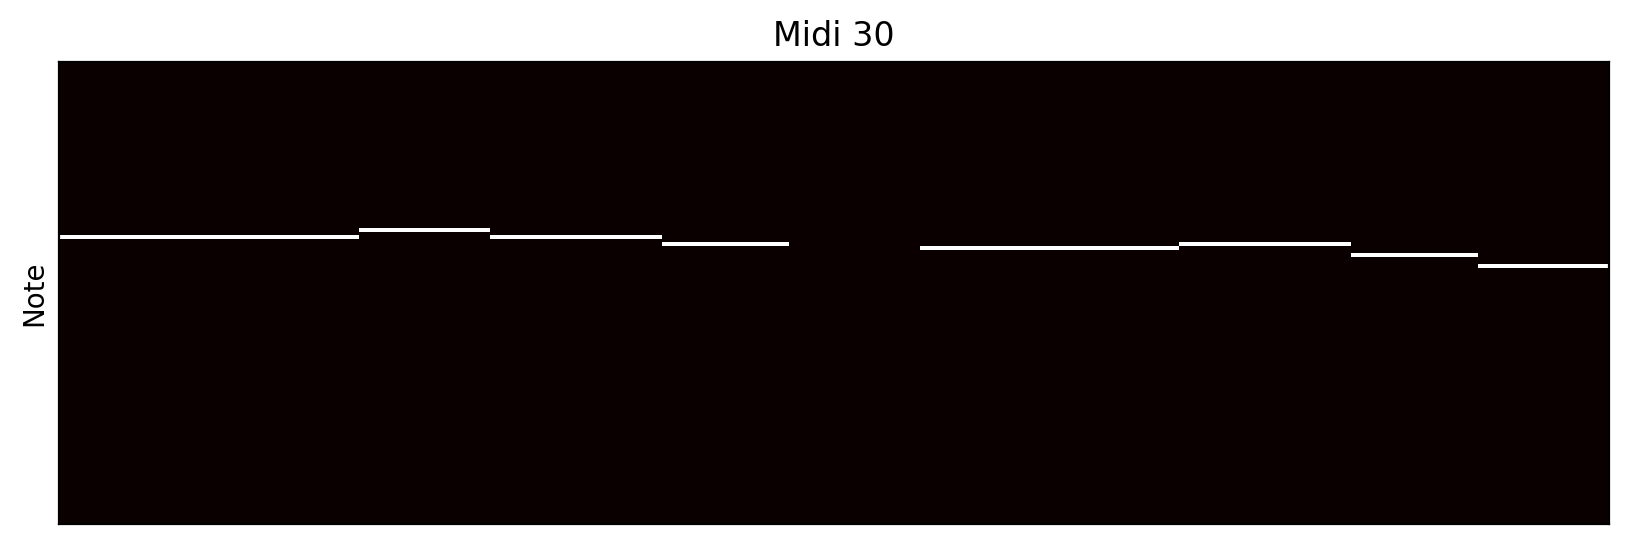

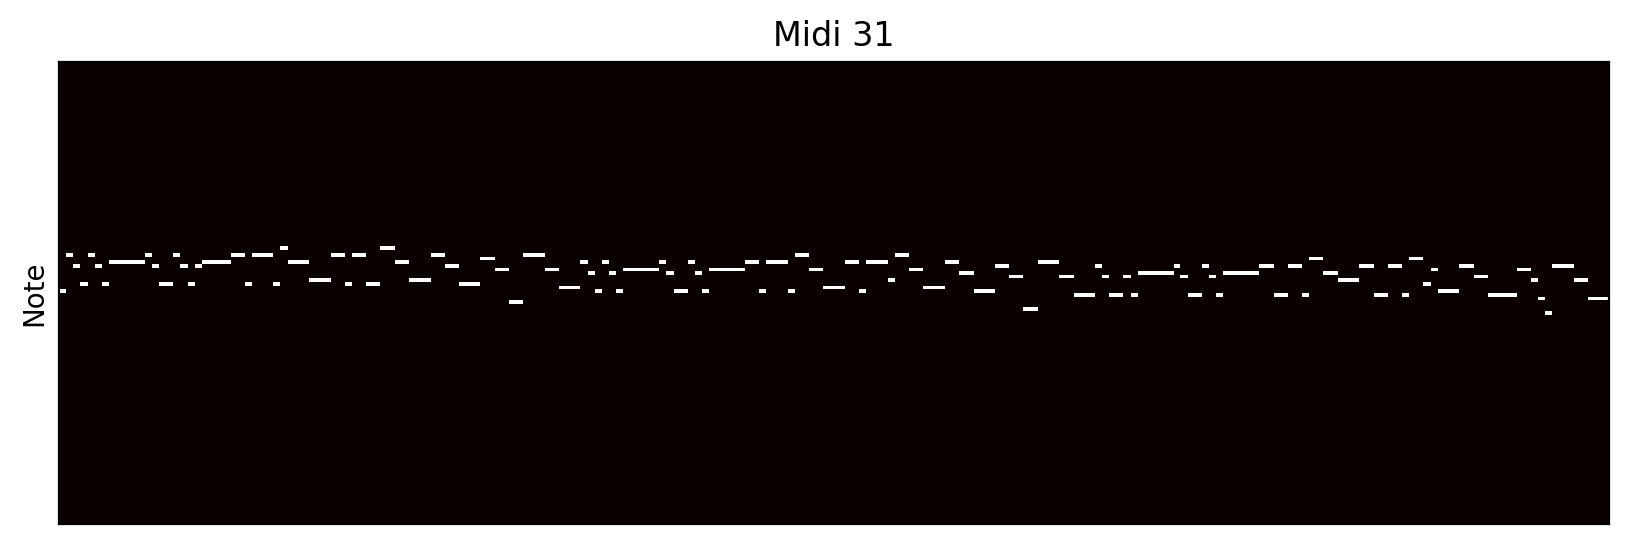

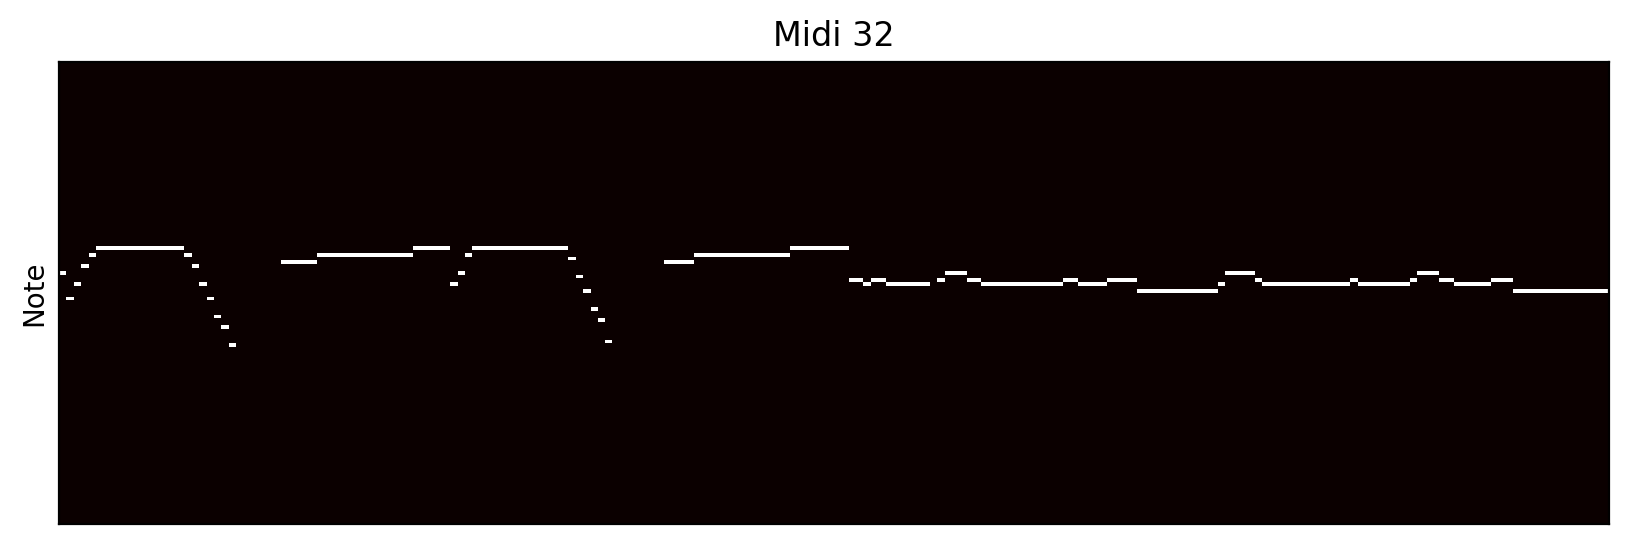

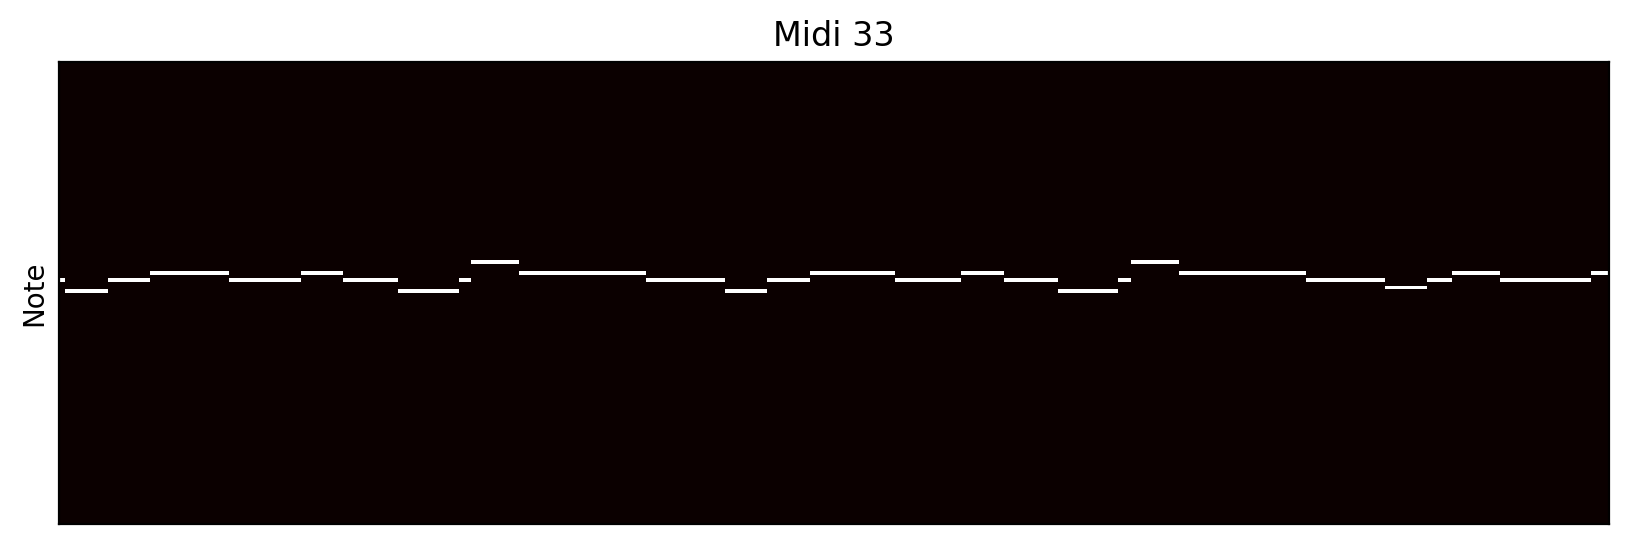

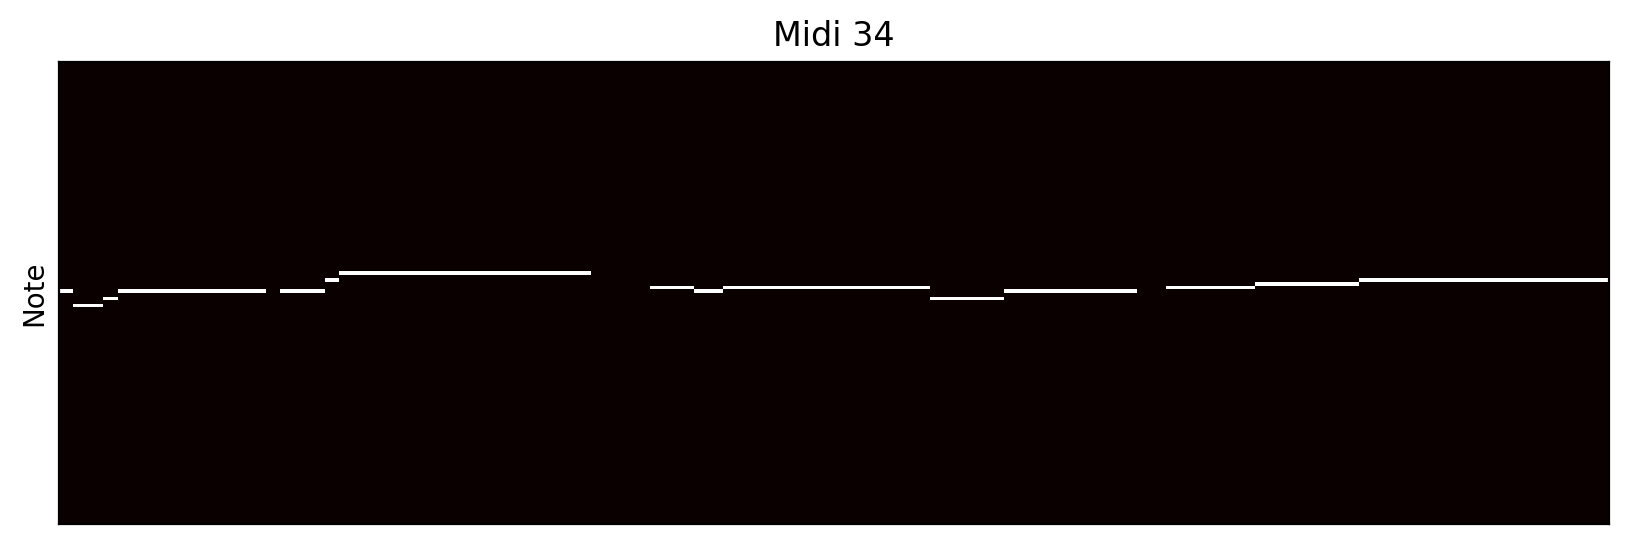

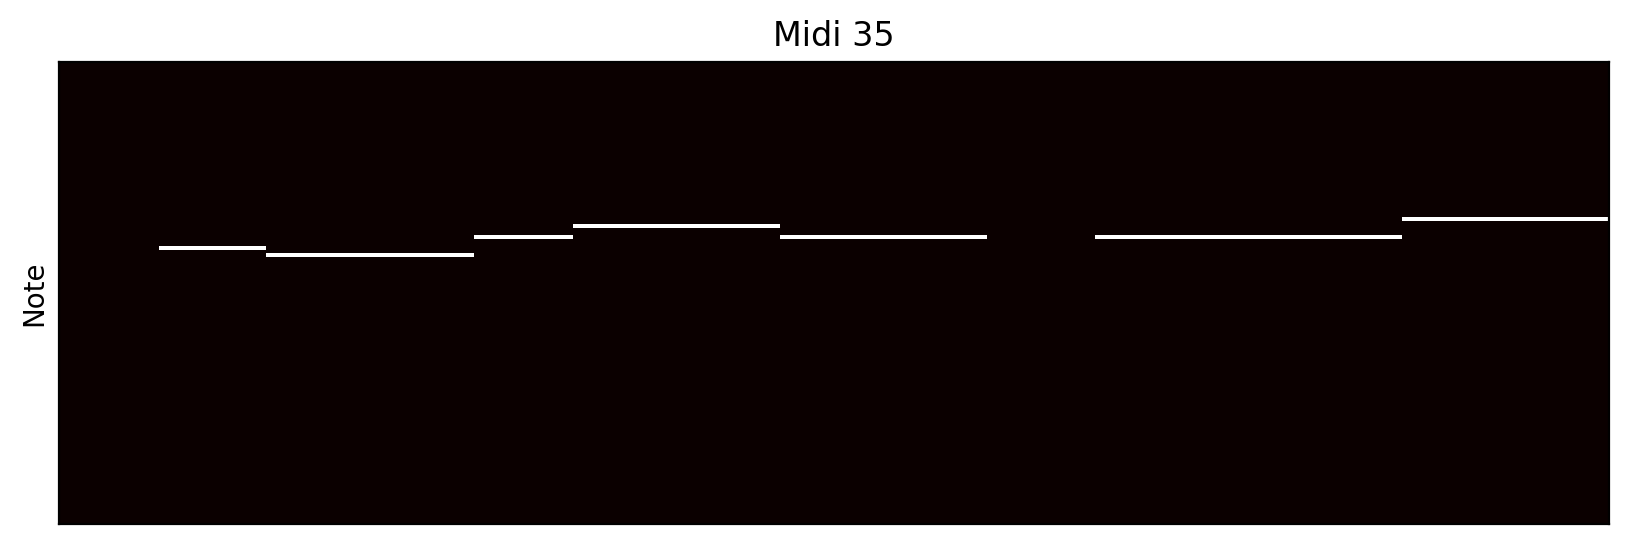

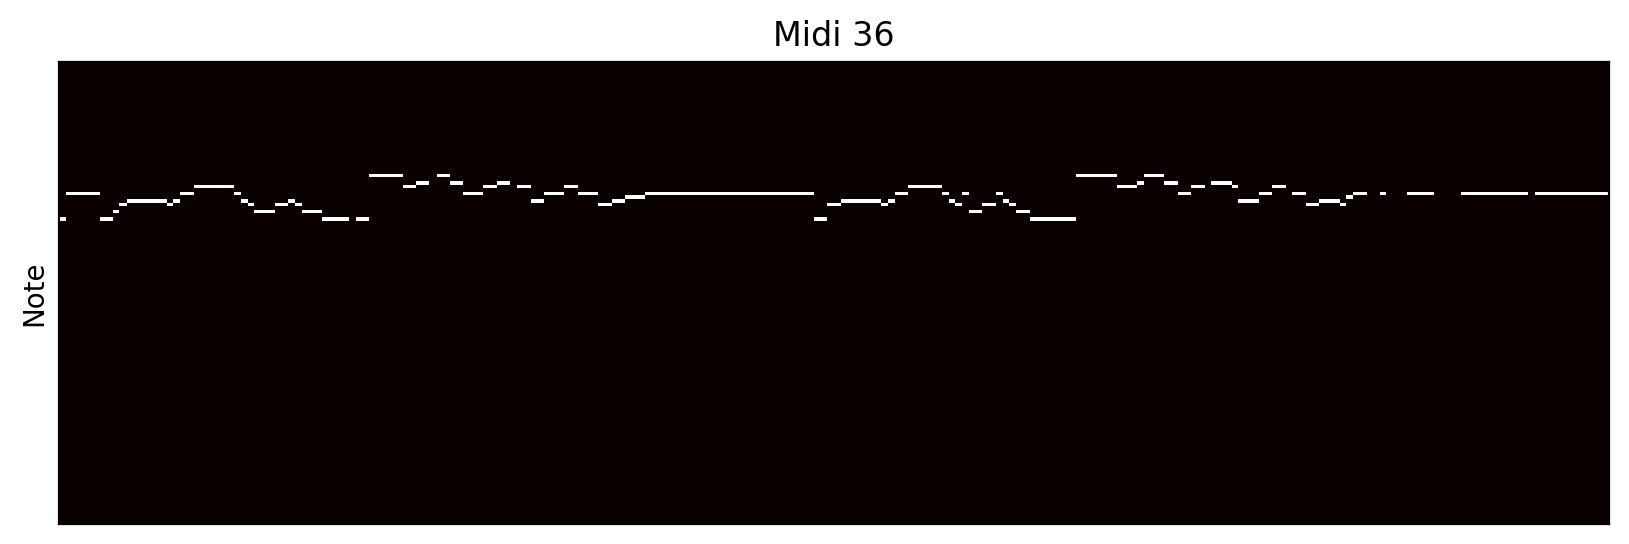

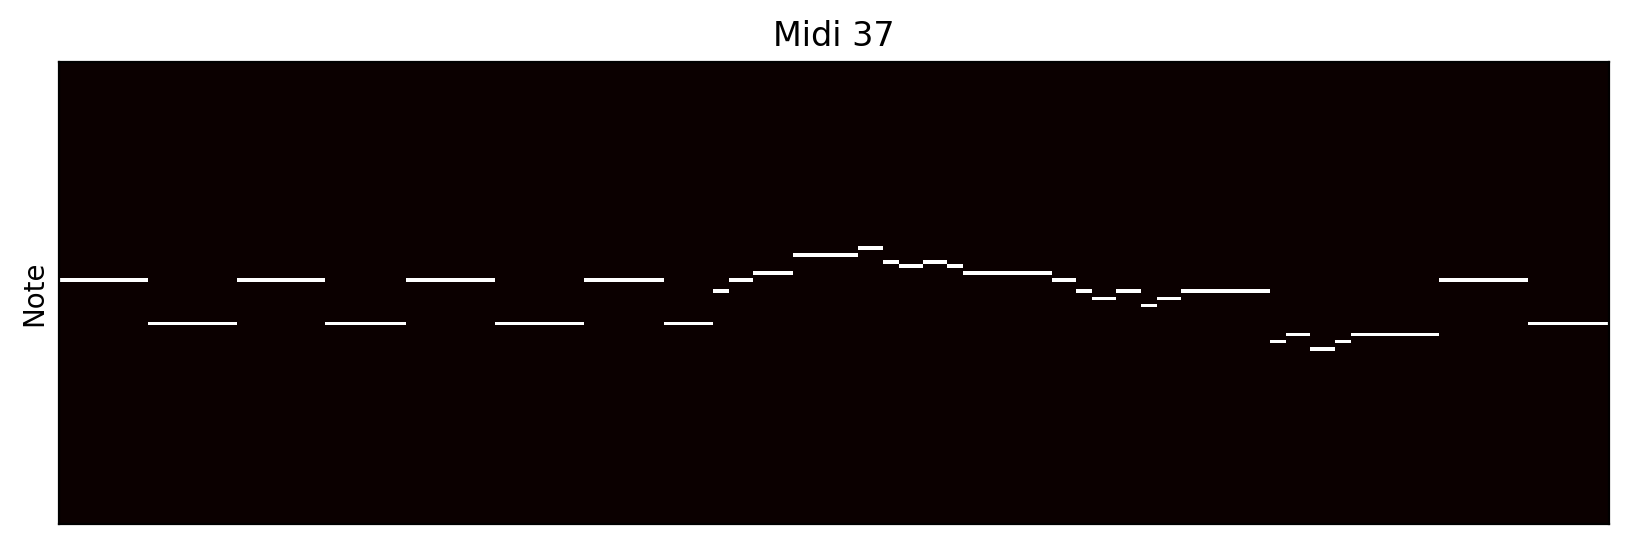

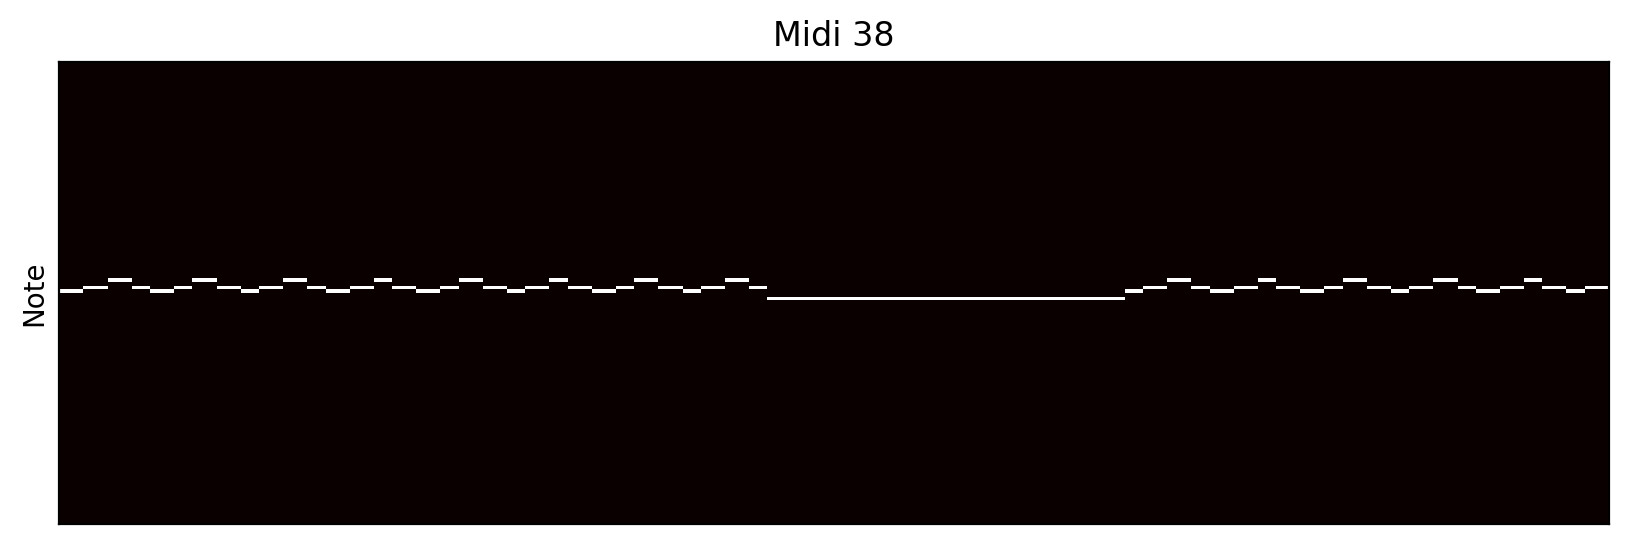

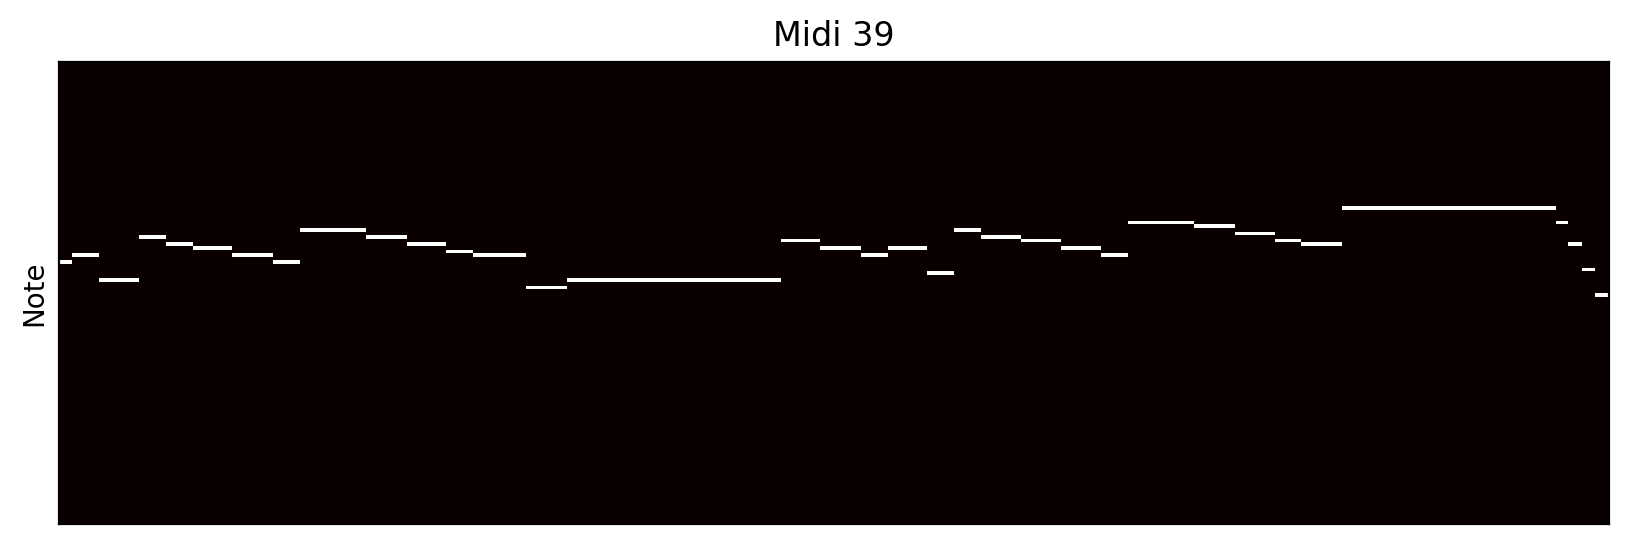

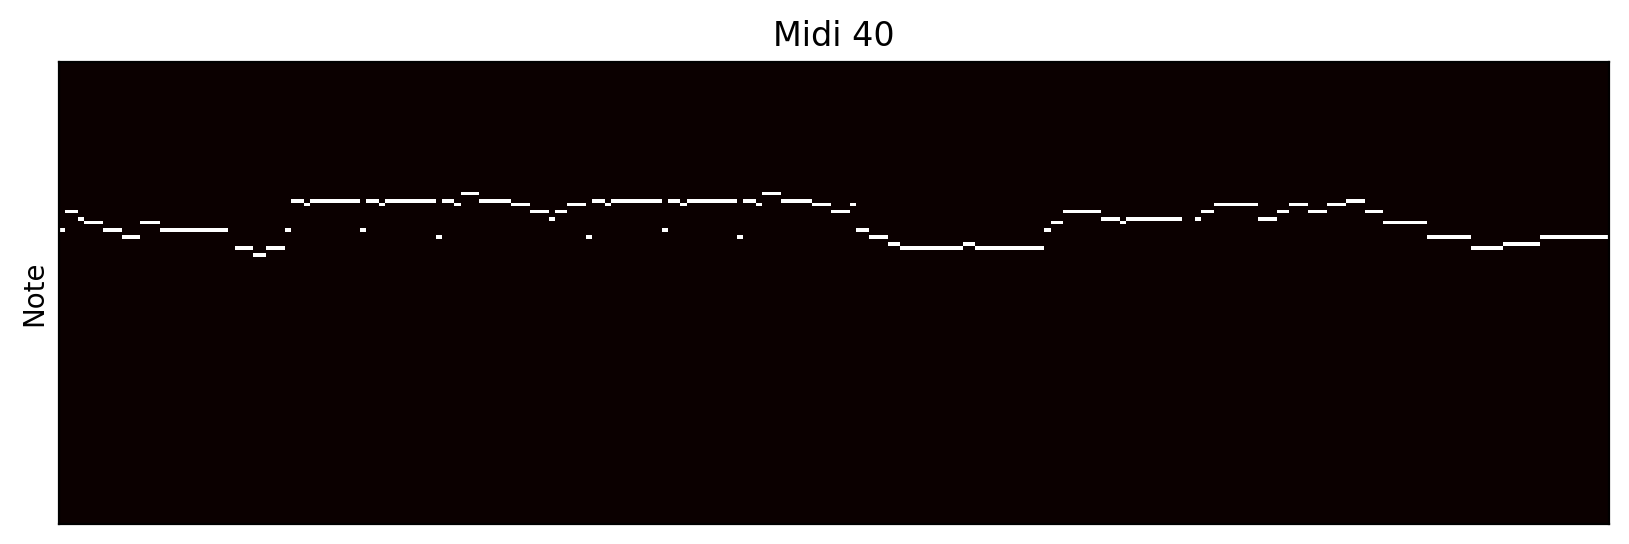

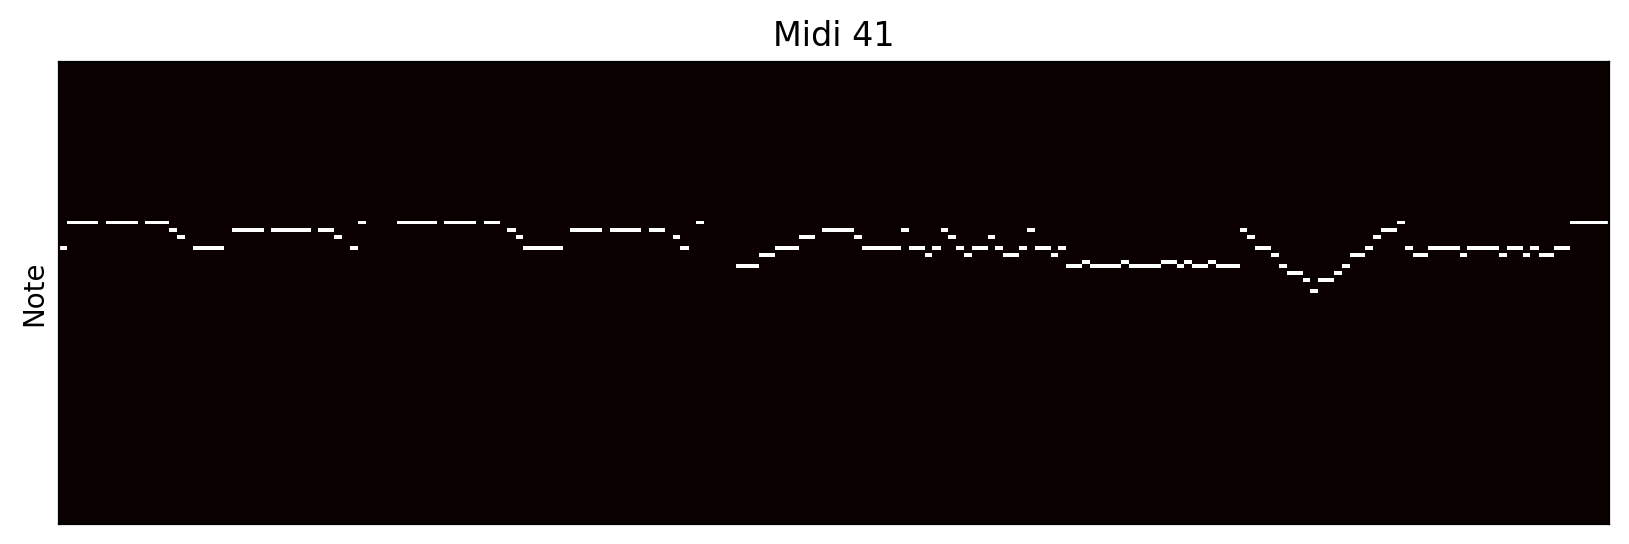

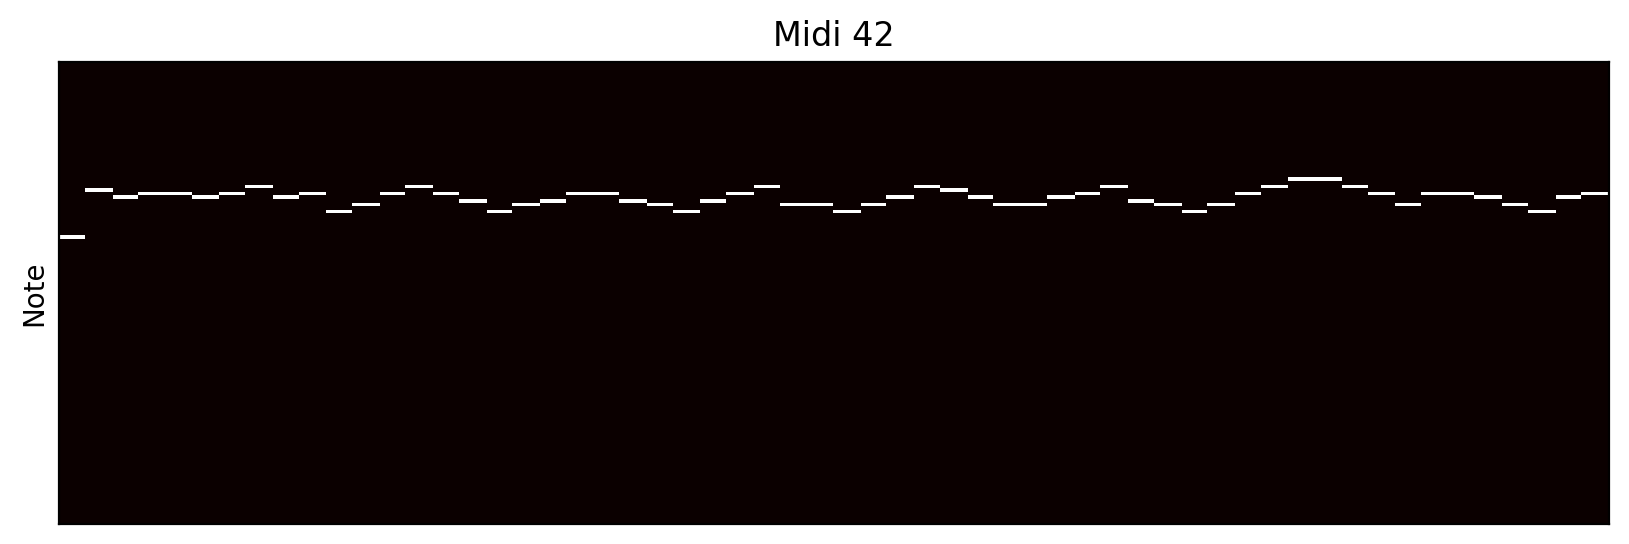

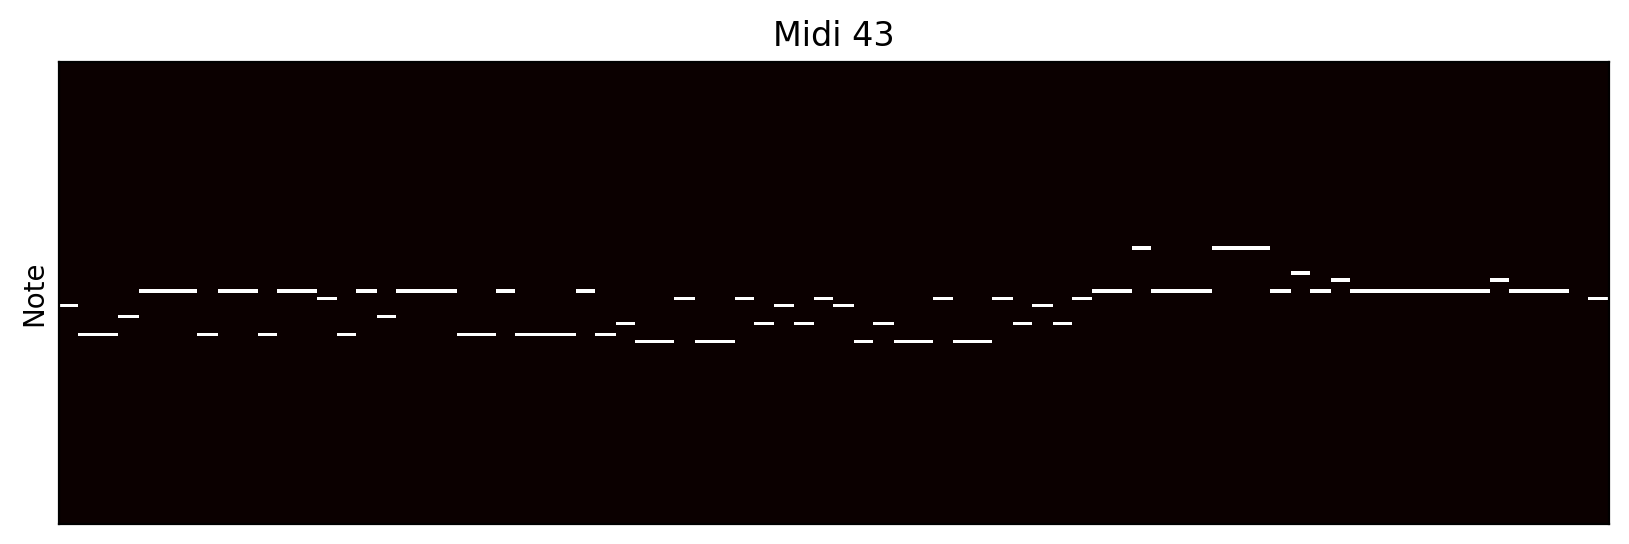

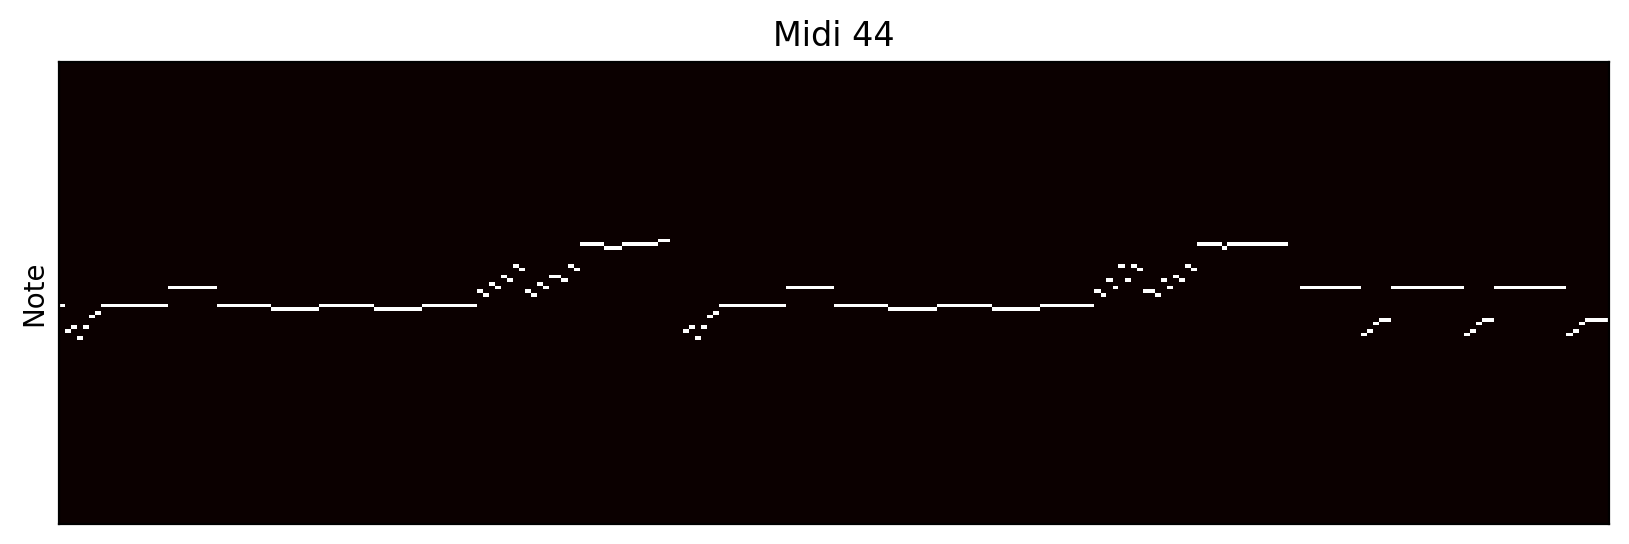

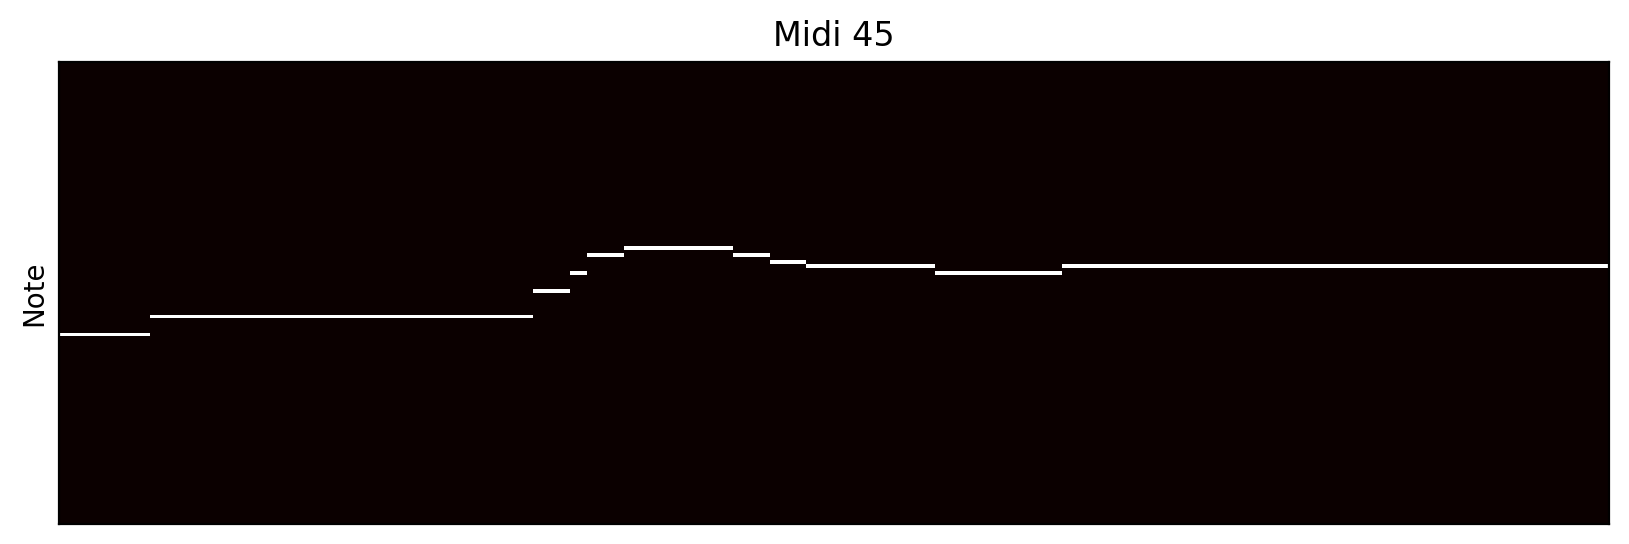

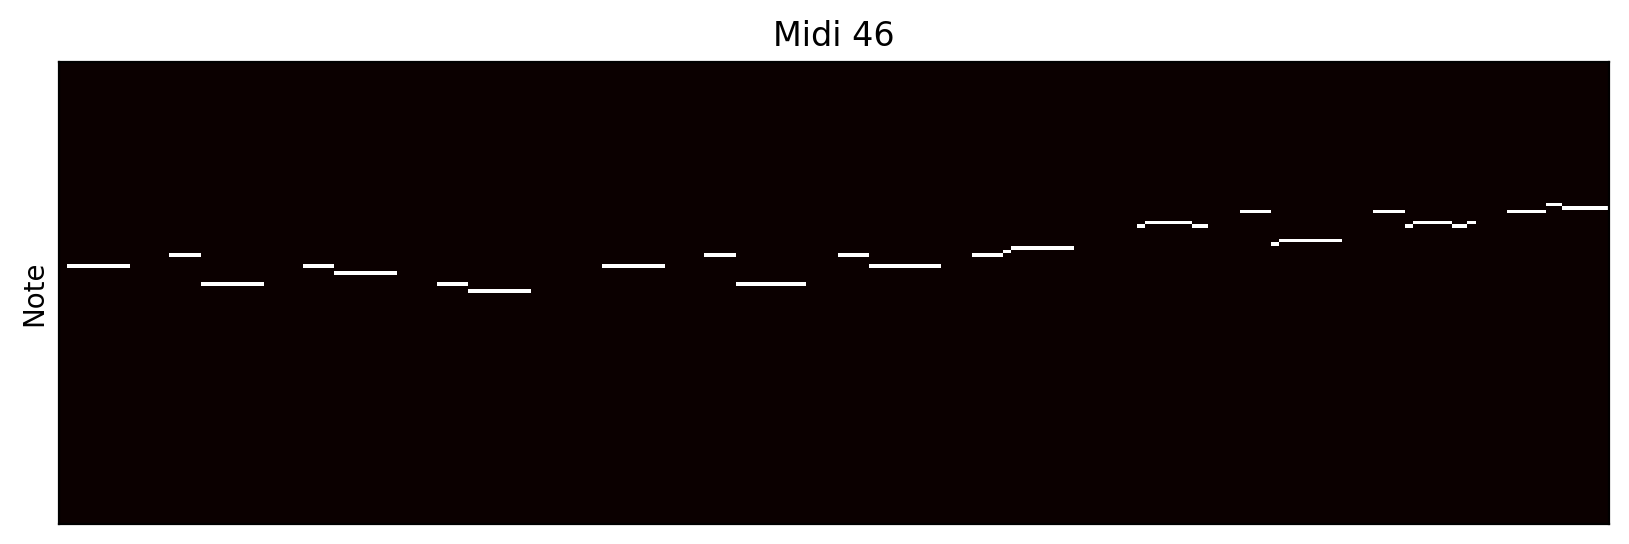

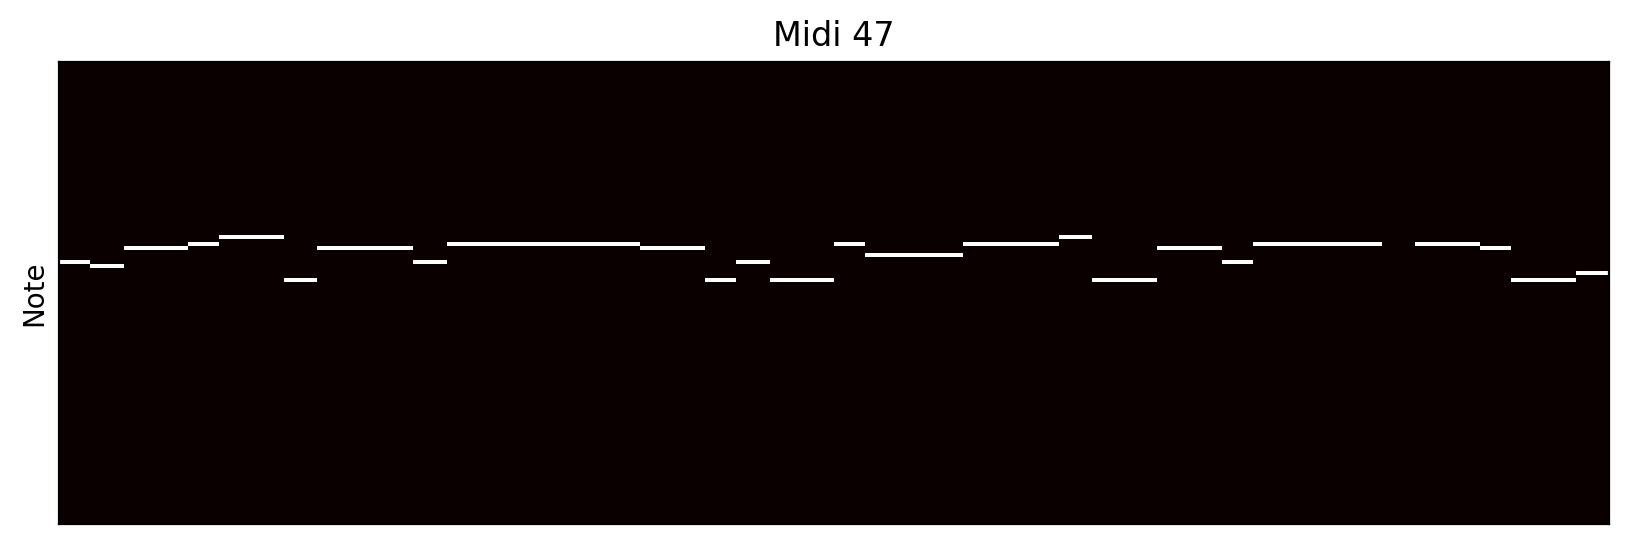

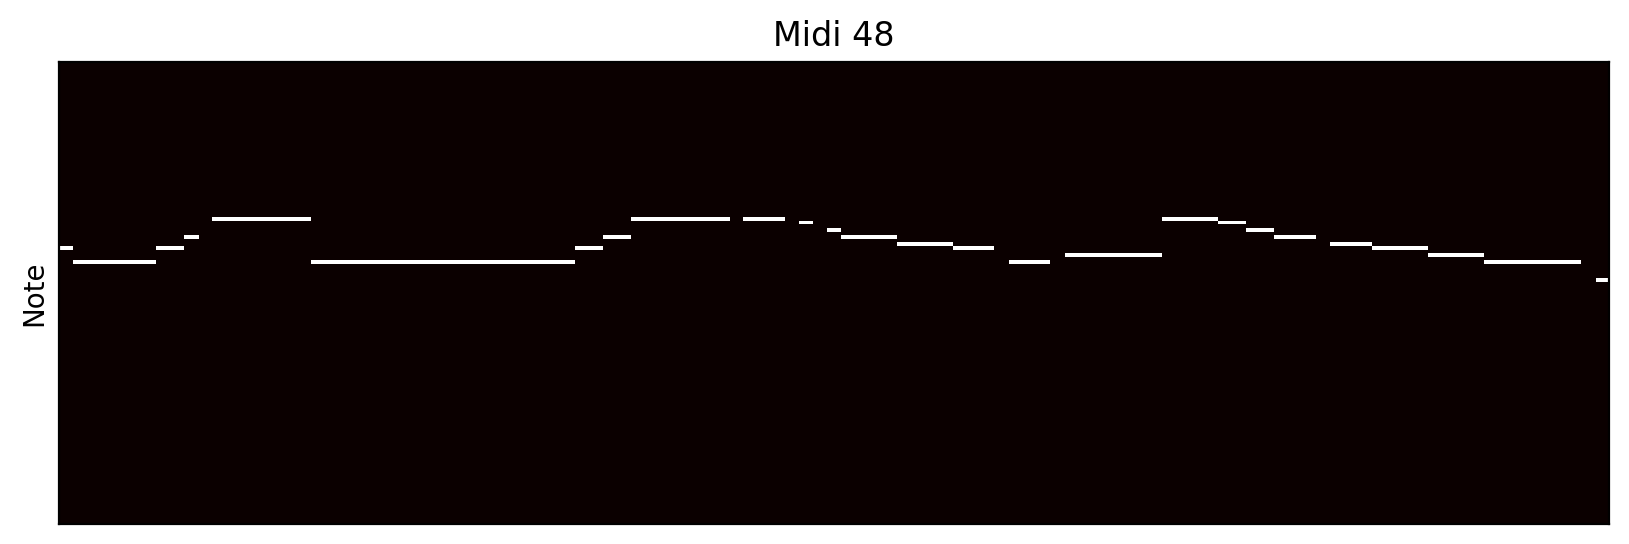

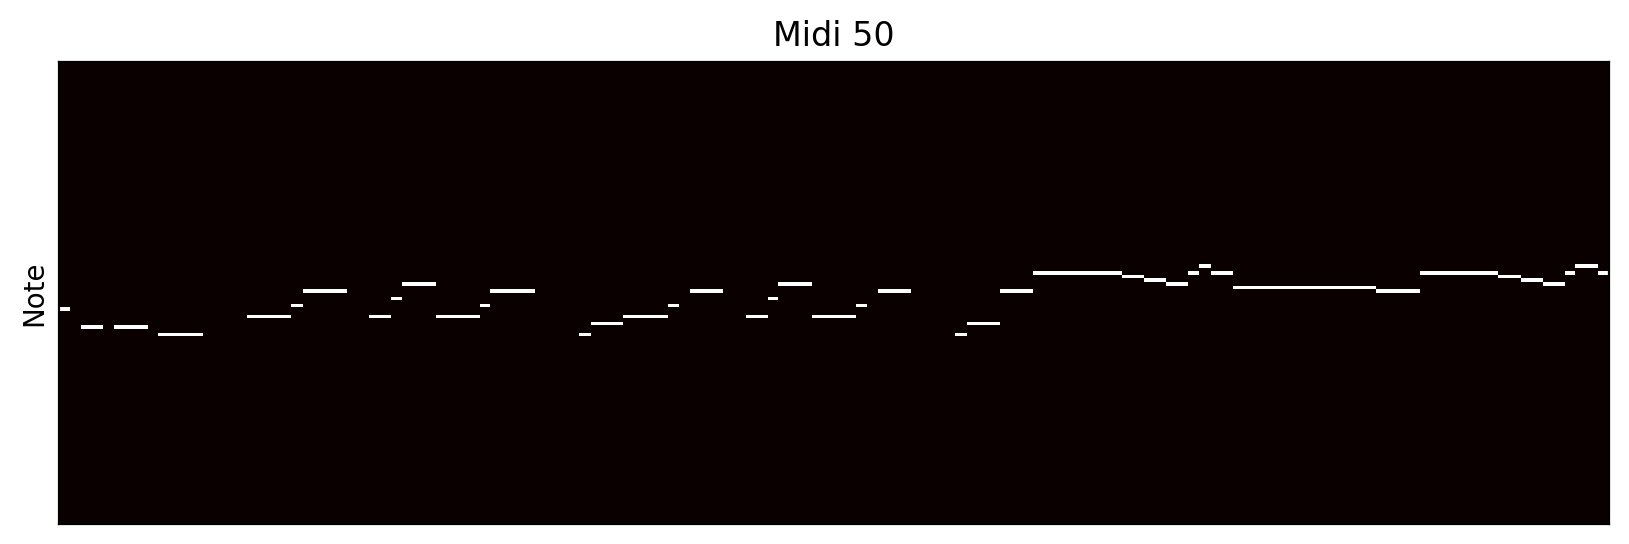

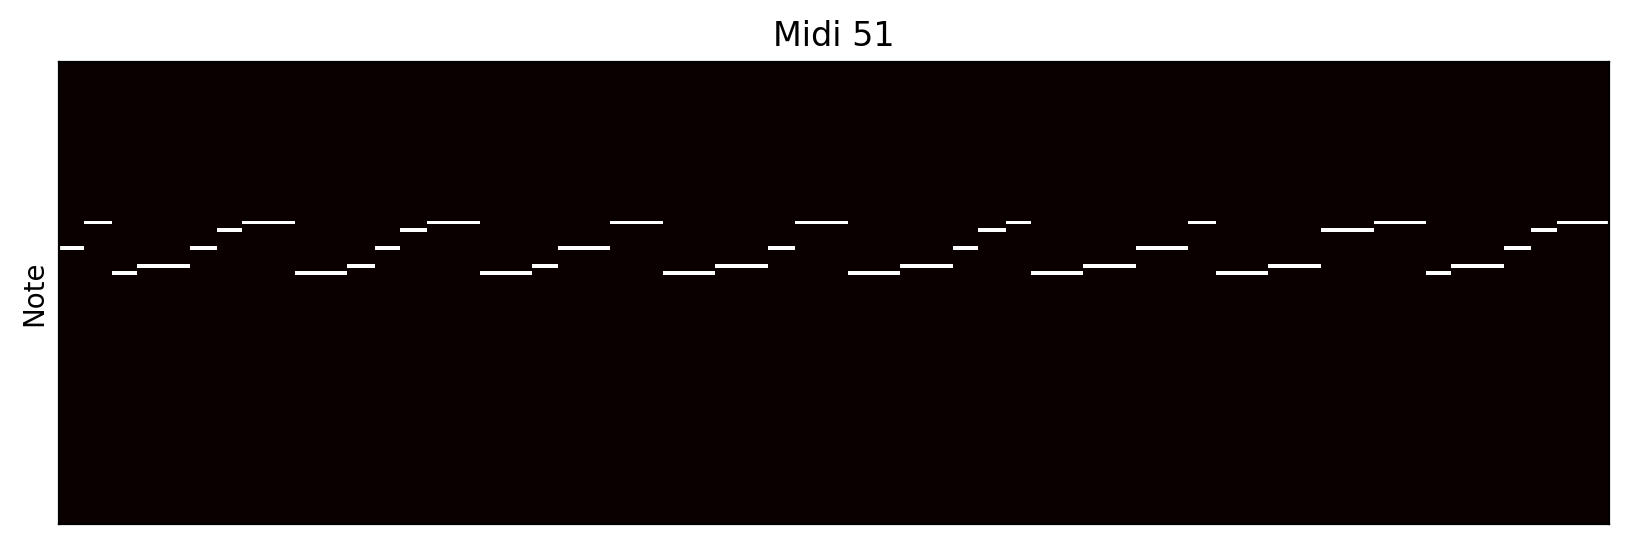

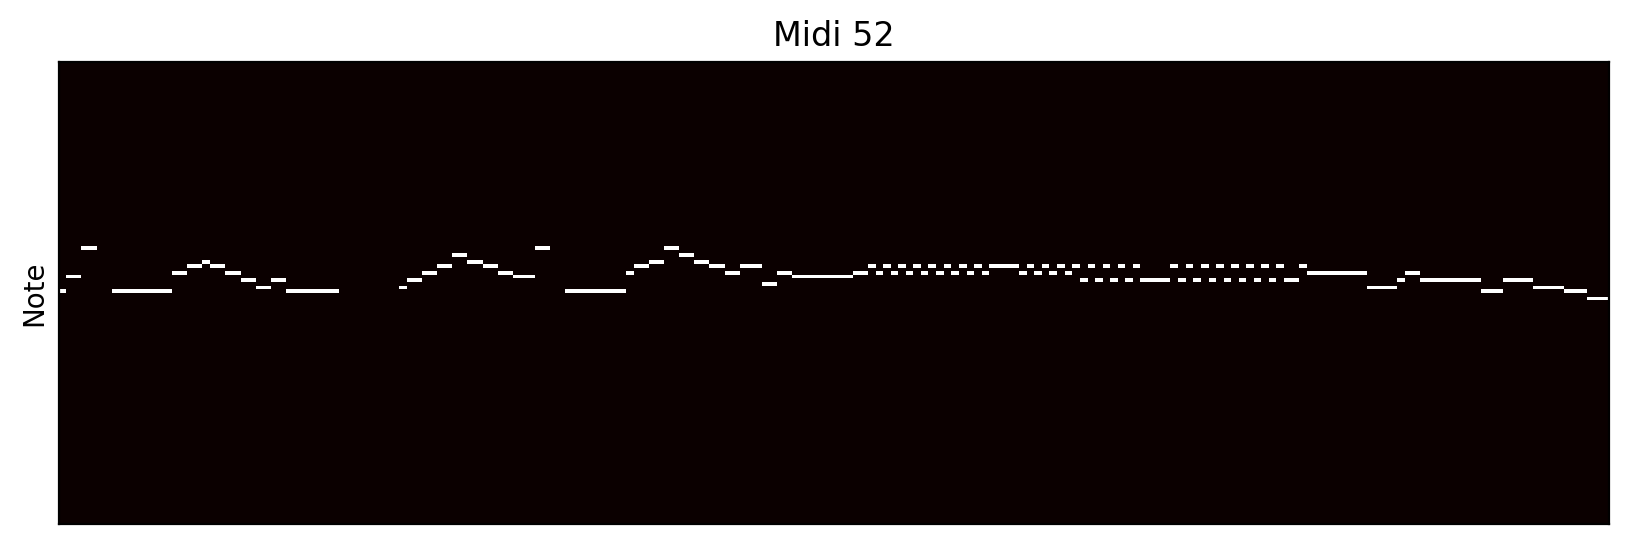

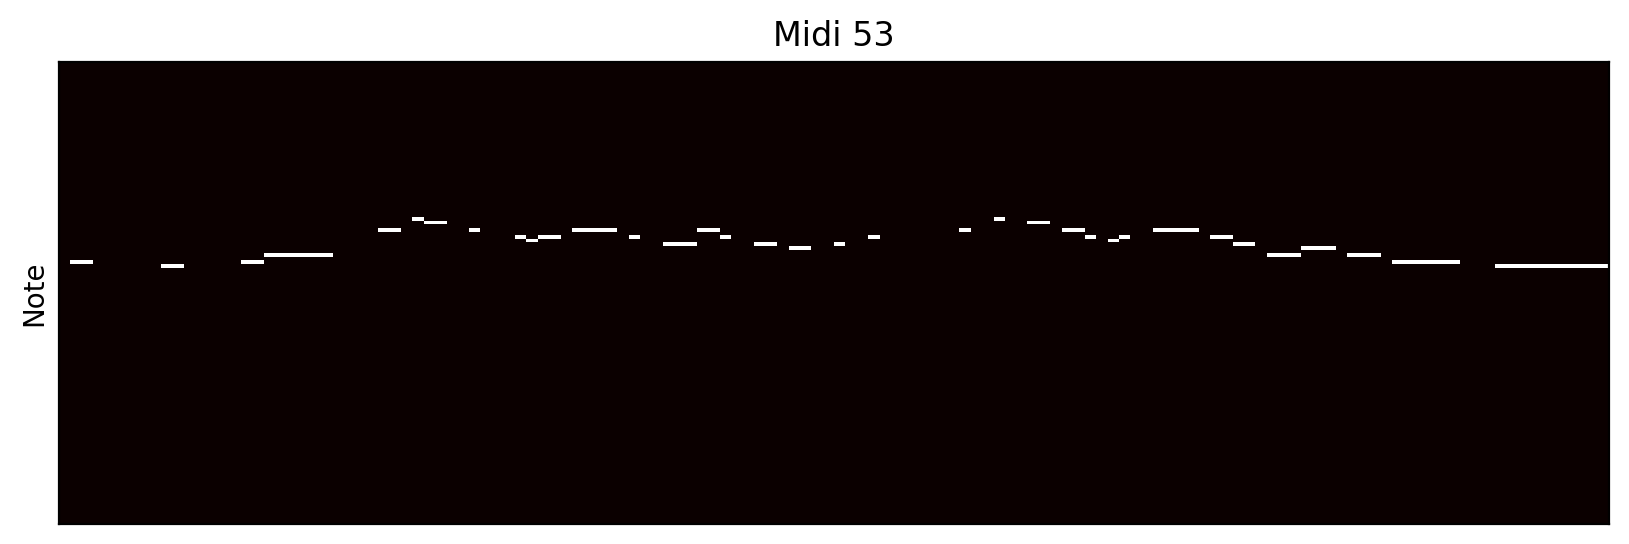

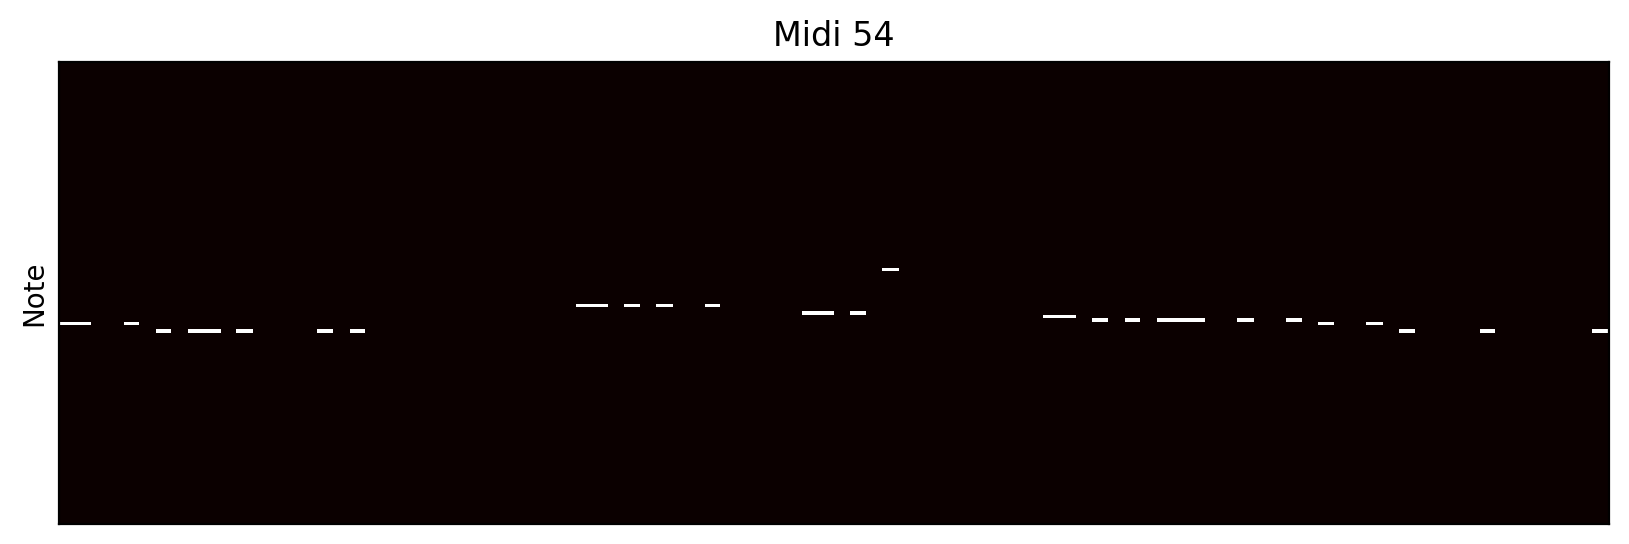

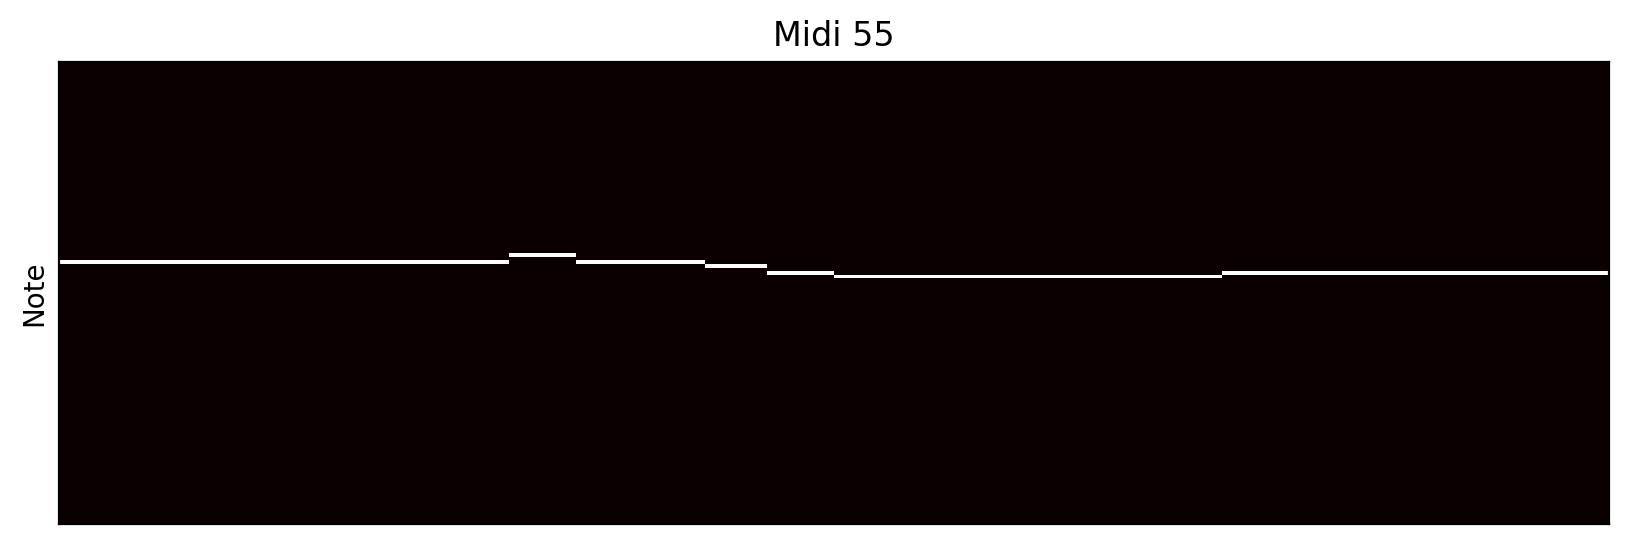

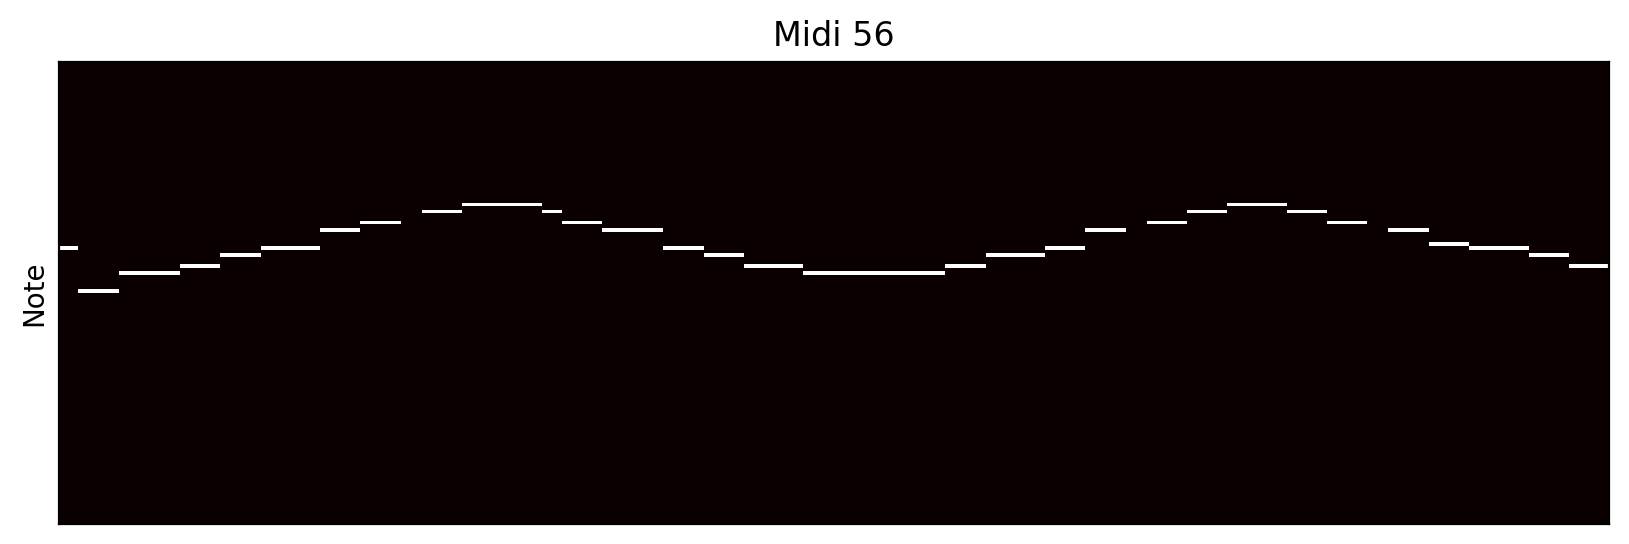

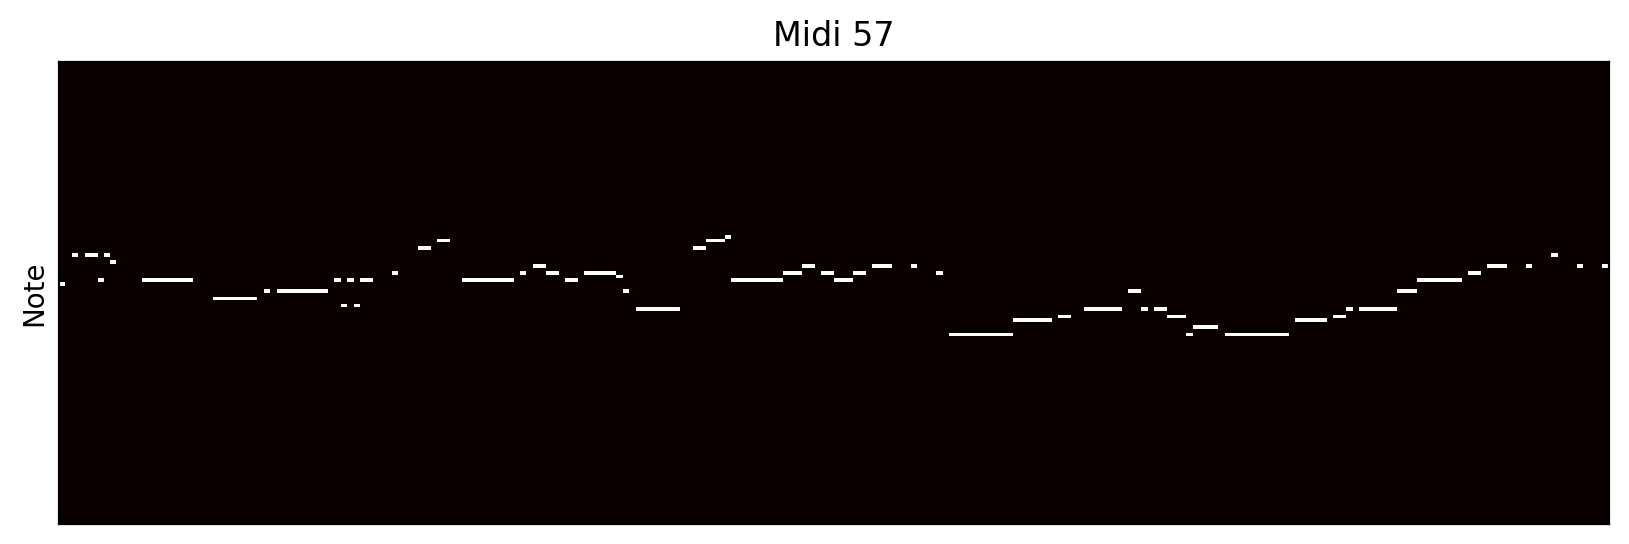

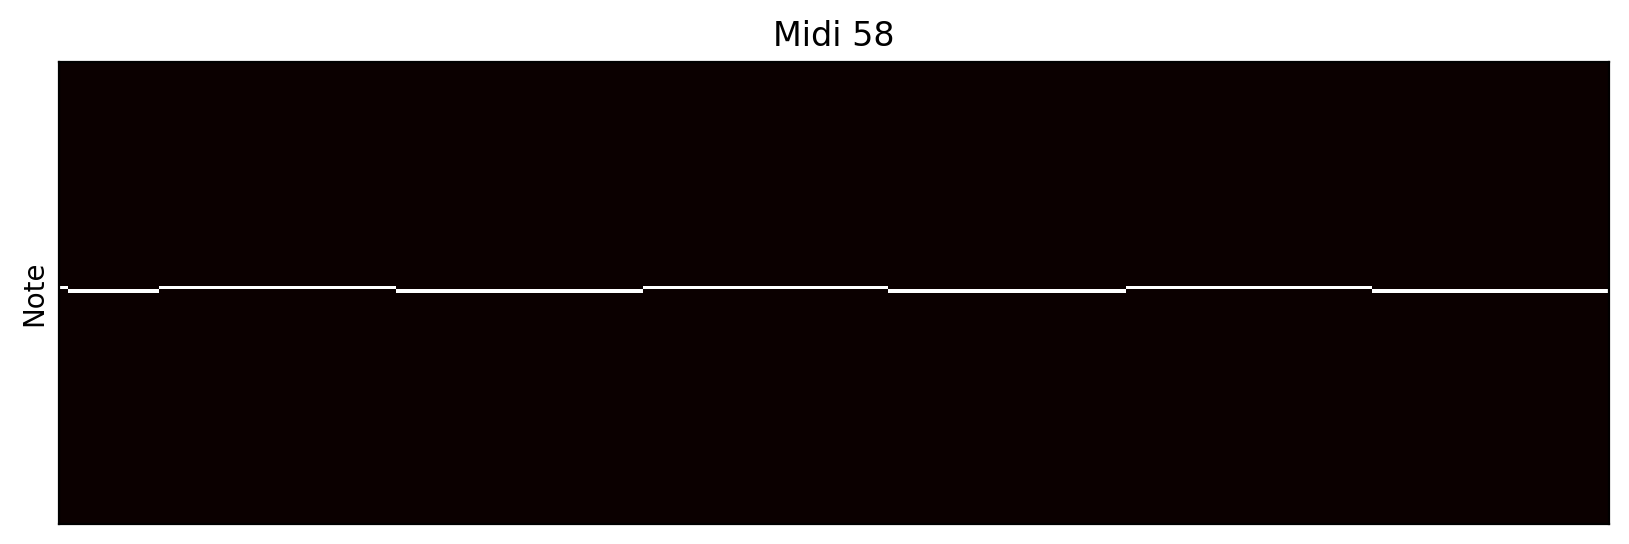

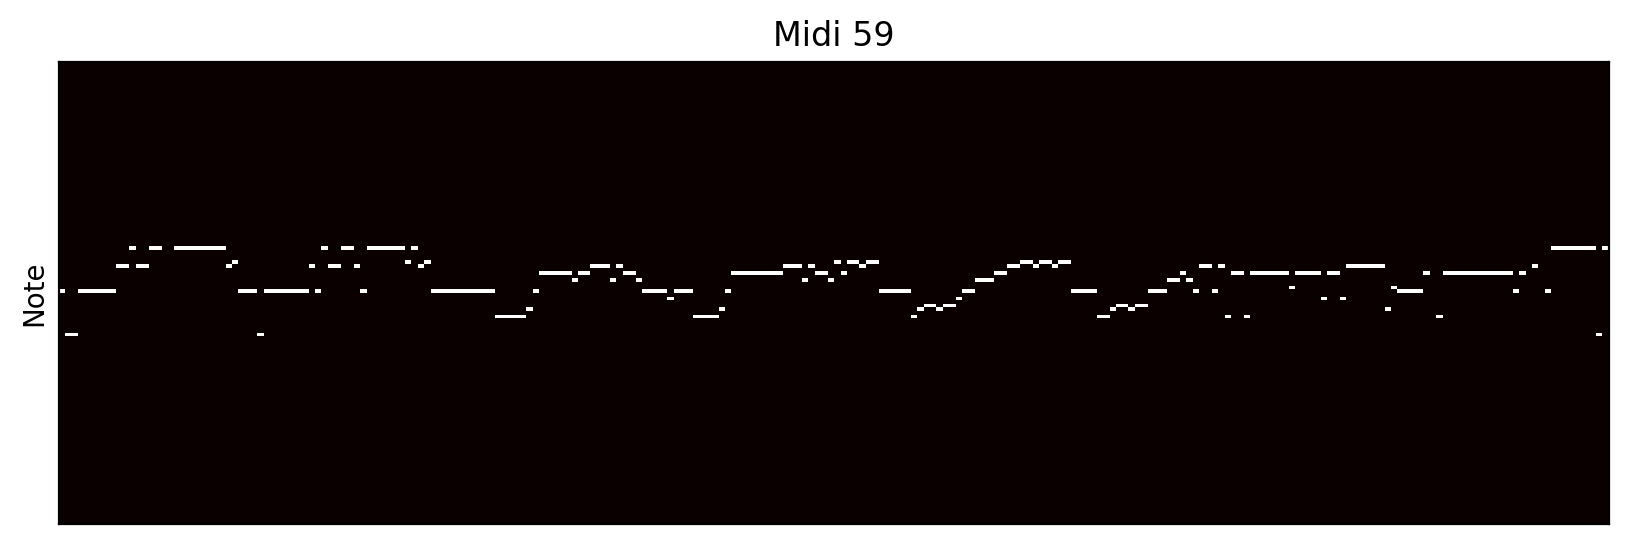

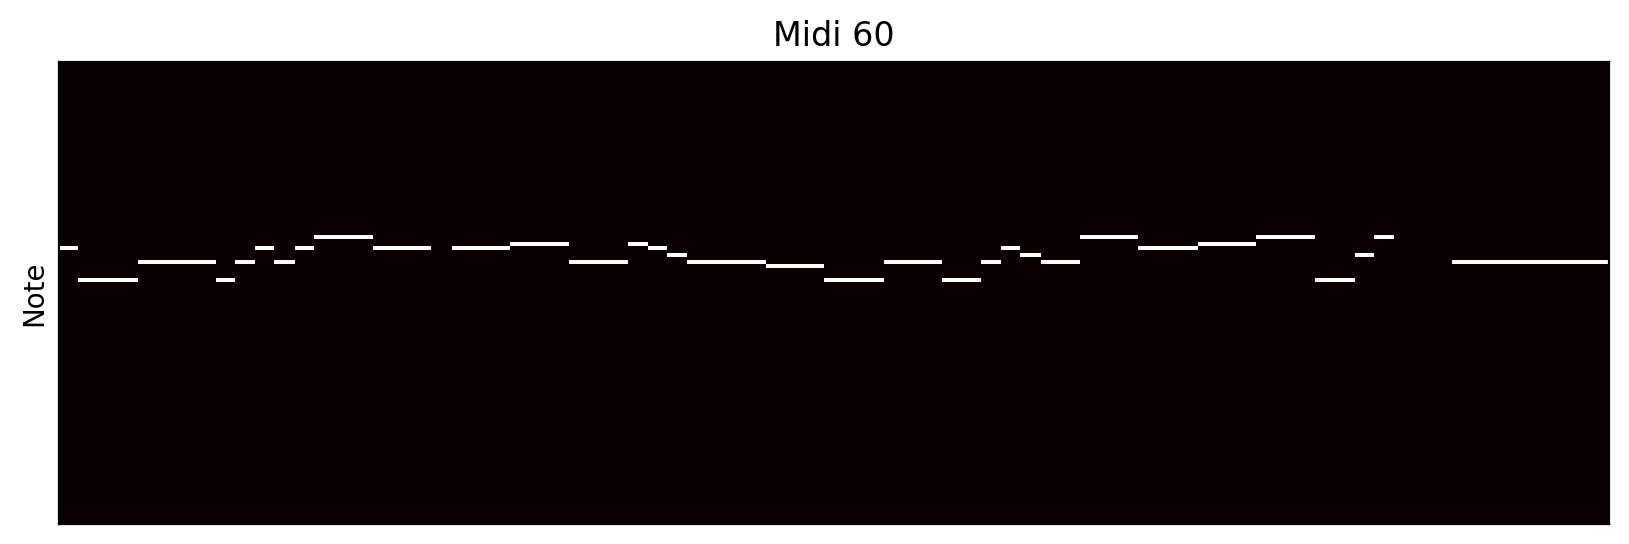

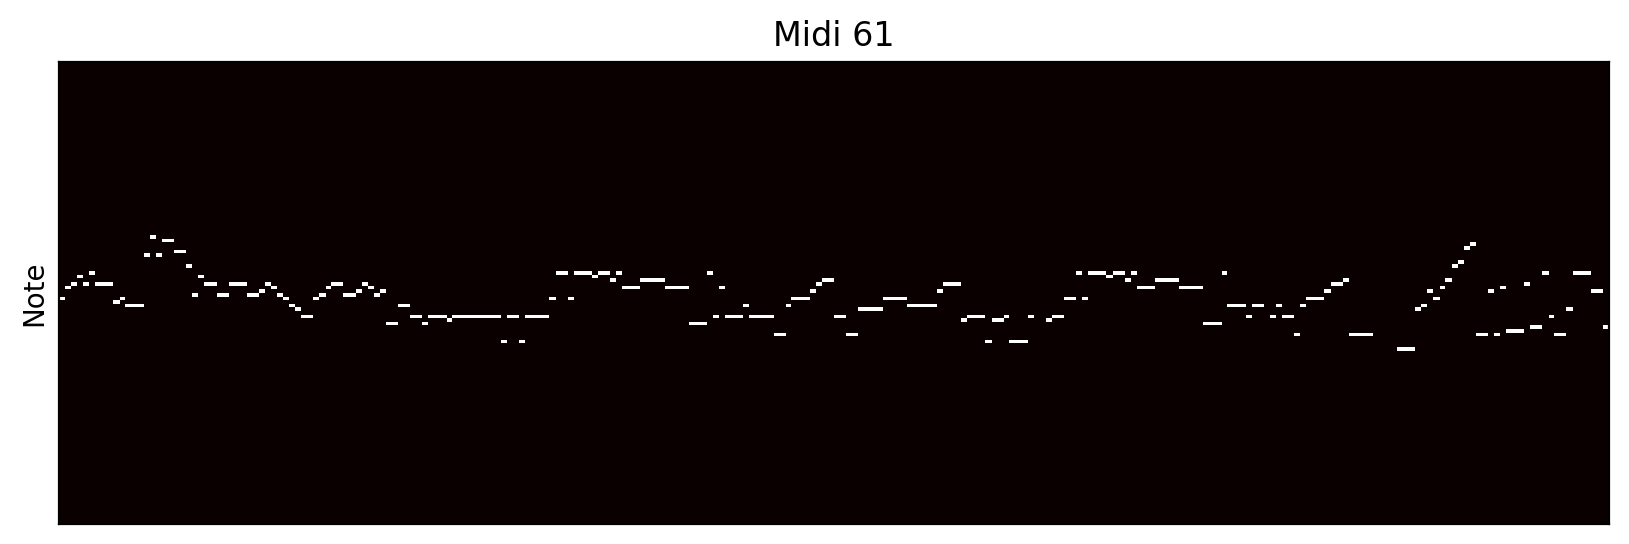

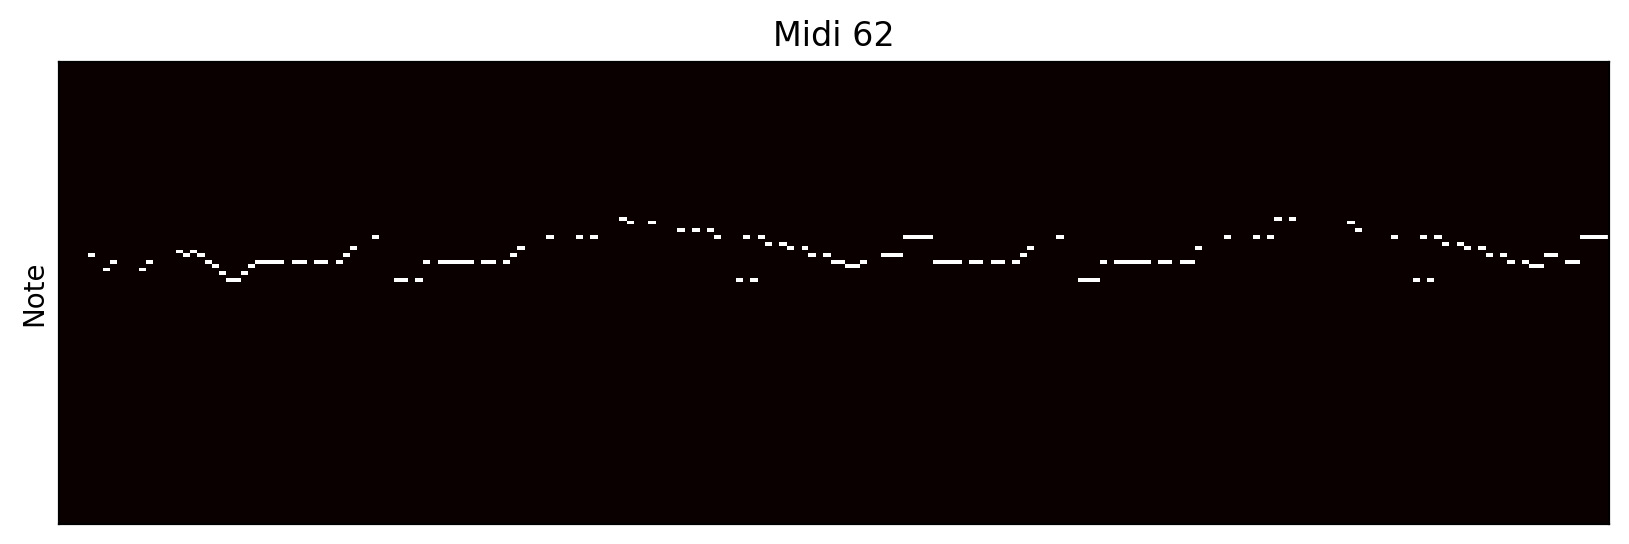

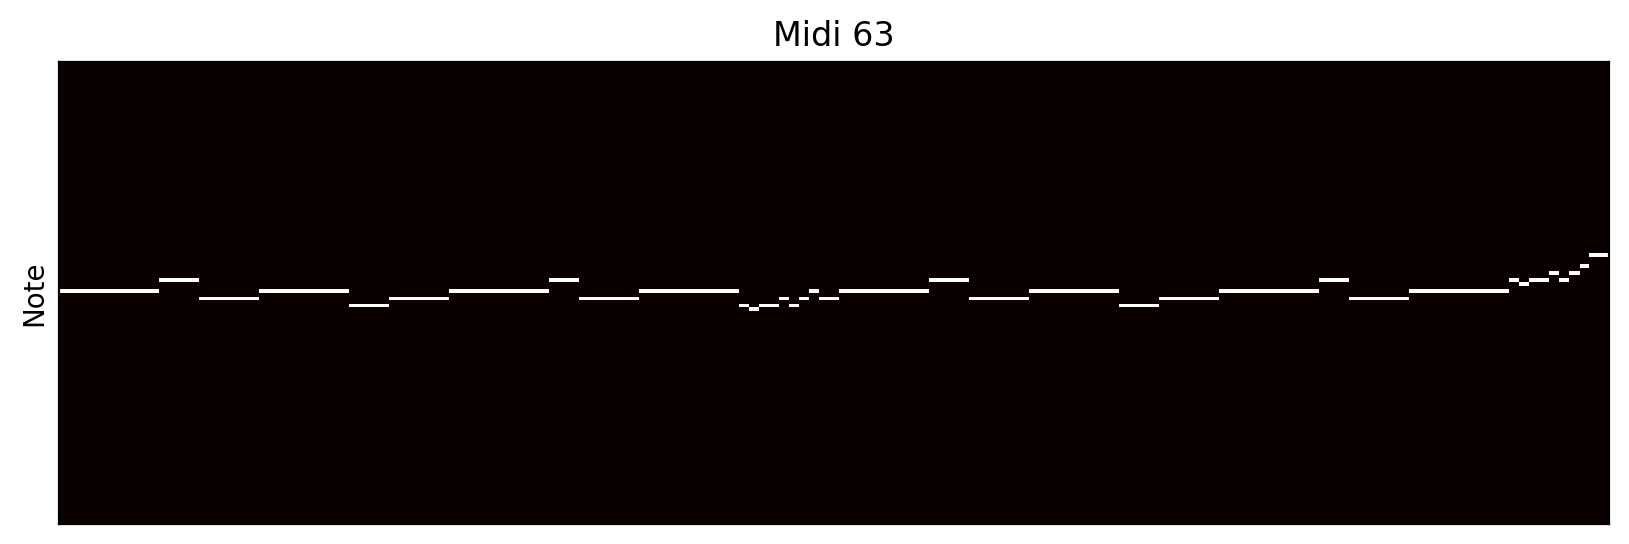

In [188]:
if not os.path.exists('midi'):
    os.makedirs('midi')

x_hat_np = x_hat.detach().numpy()
x_hat_np.shape
for i, seq in enumerate(x_hat_np):
    row_maxes = seq.max(axis=1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)

    if np.all(midi_out[:,-1]):
        print("Midi: {} is all silent".format(i))
        continue

    np.savetxt("midi/csv_midi_out_{}.csv".format(i), midi_out, delimiter=";")

    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Midi {}".format(i))

    builder.plot_midi(midi)
    plt.savefig("midi/img_midi_{}.png".format(i))

    midi.write('midi/{}.mid'.format(i))

    #synth, rate = builder.play_midi(midi)
    #Audio(synth, rate=rate)

#### Compare originals

<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyq

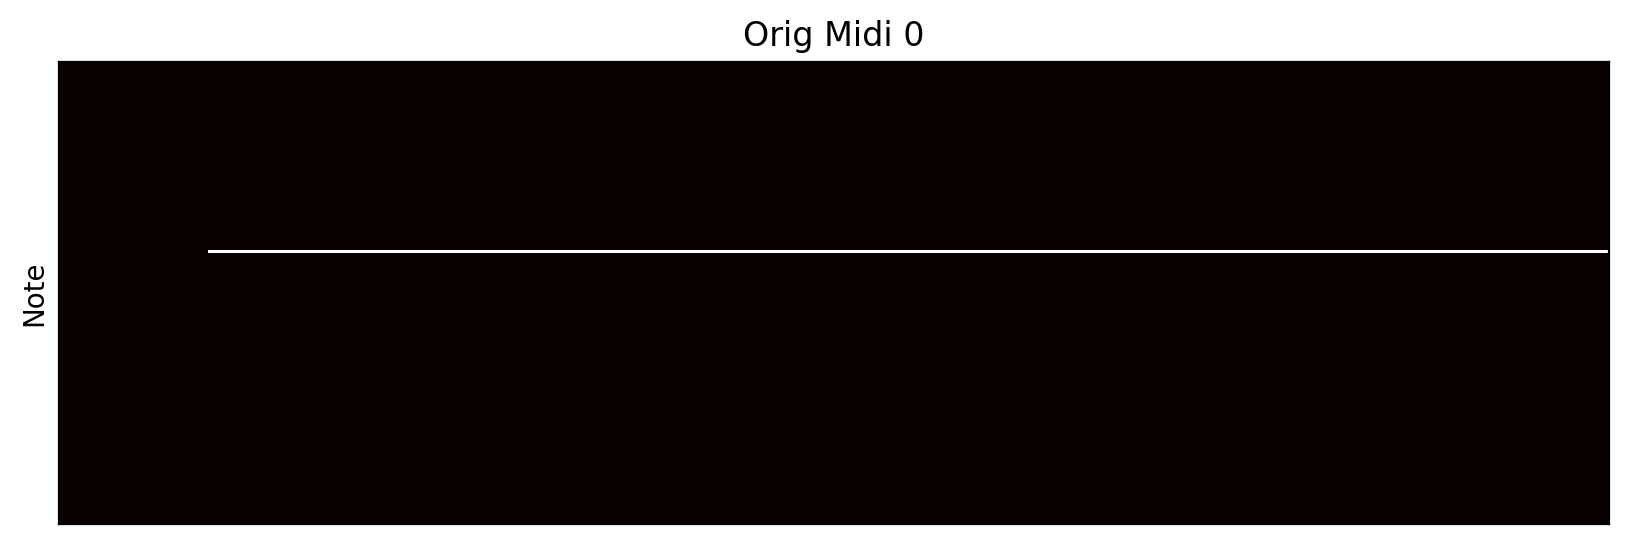

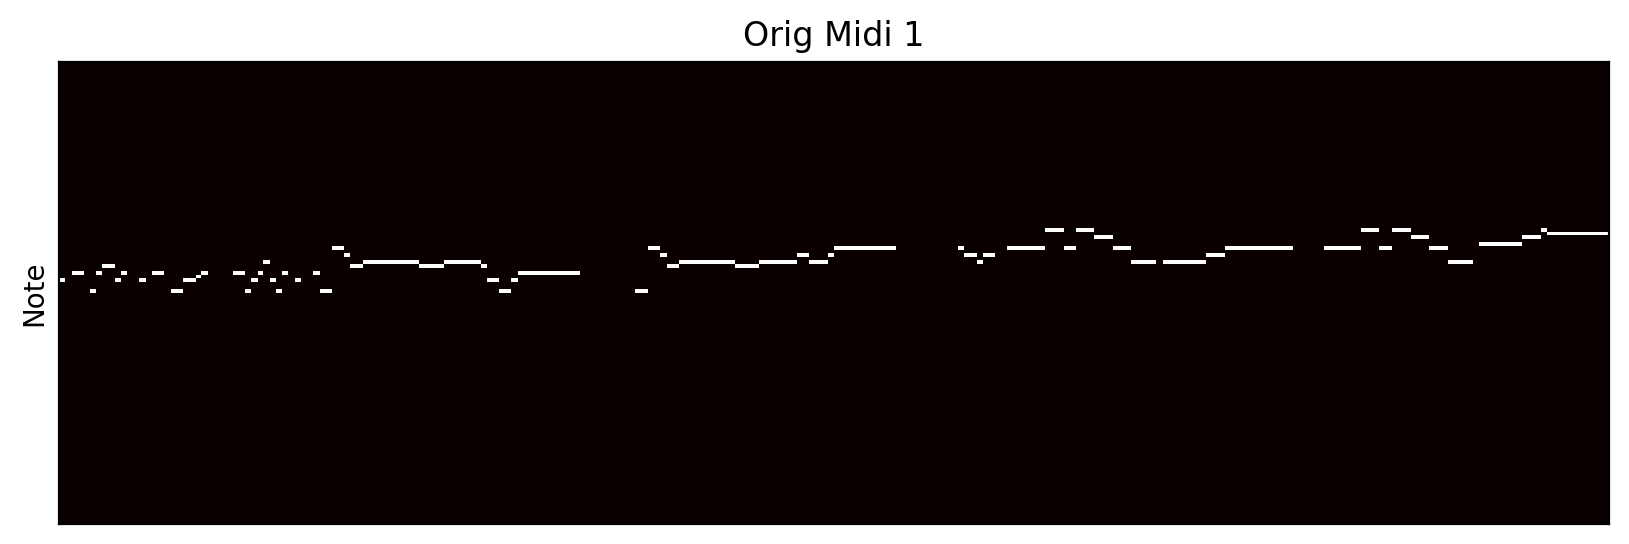

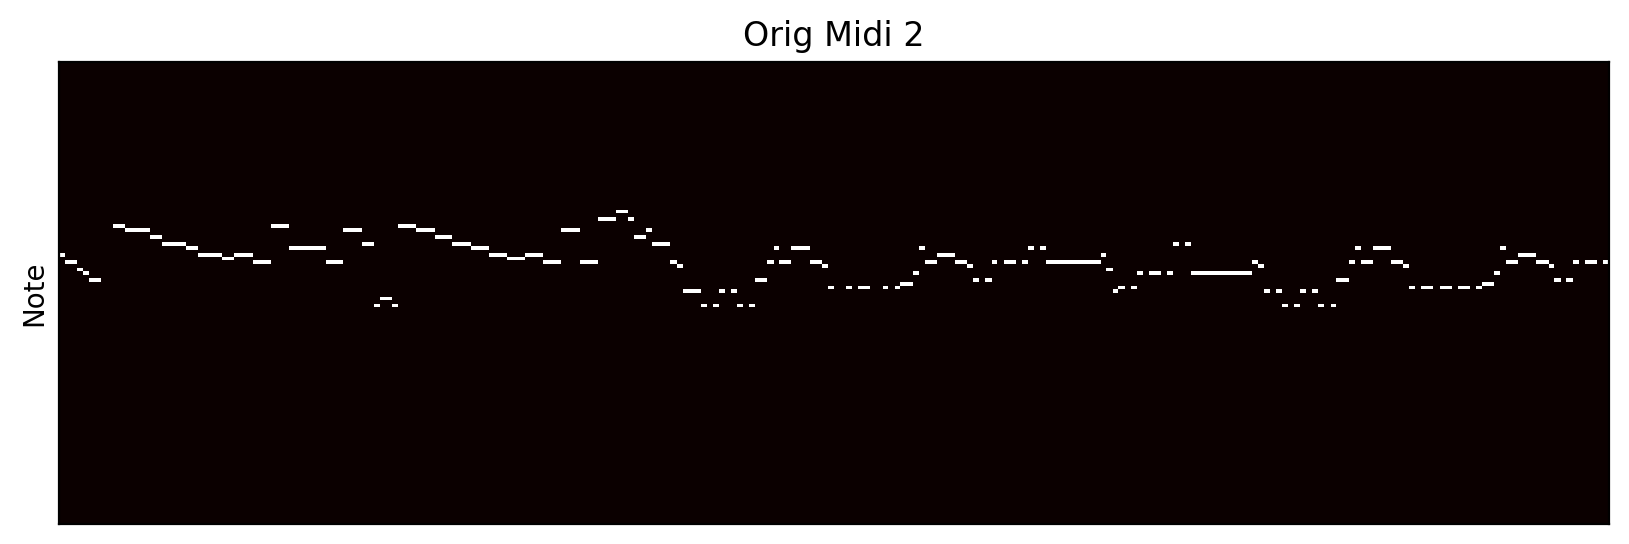

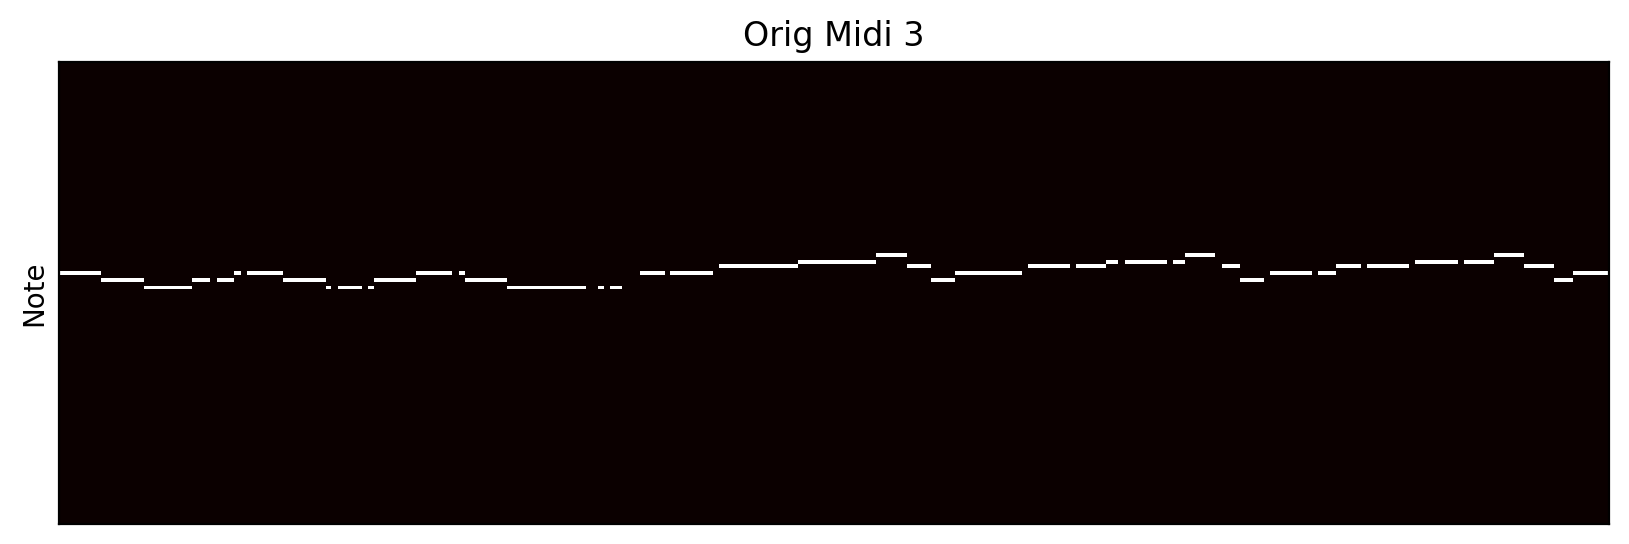

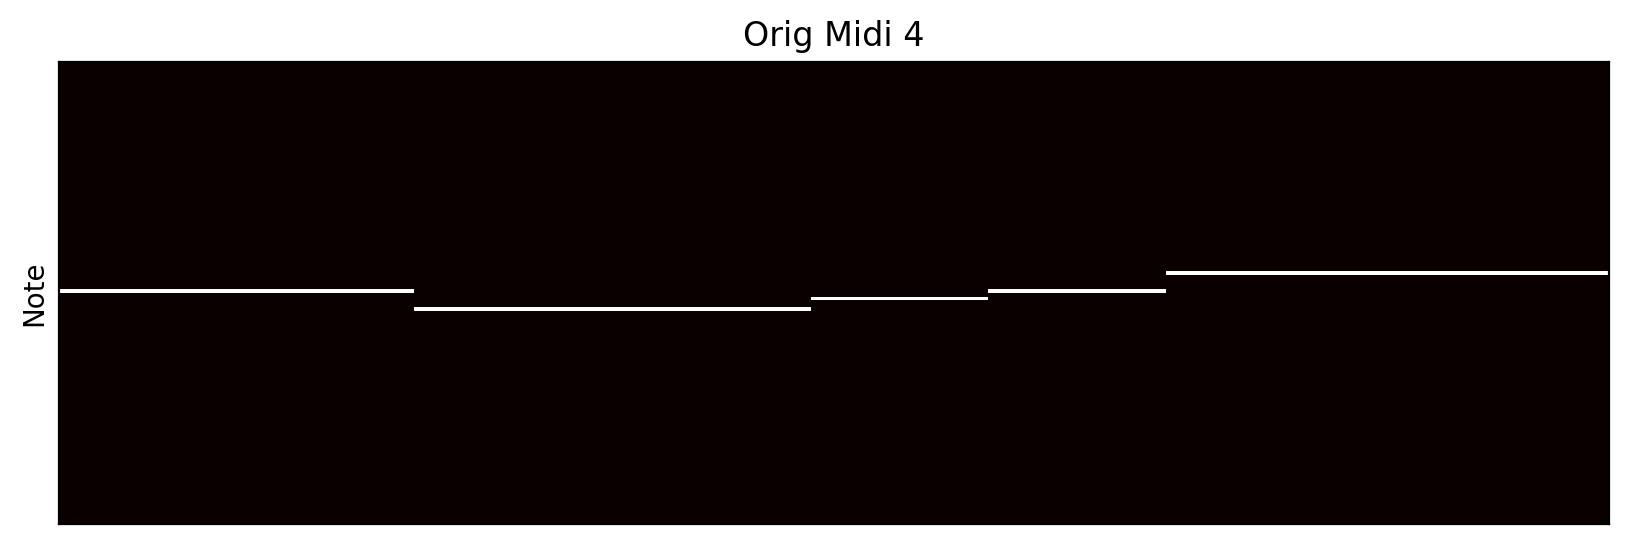

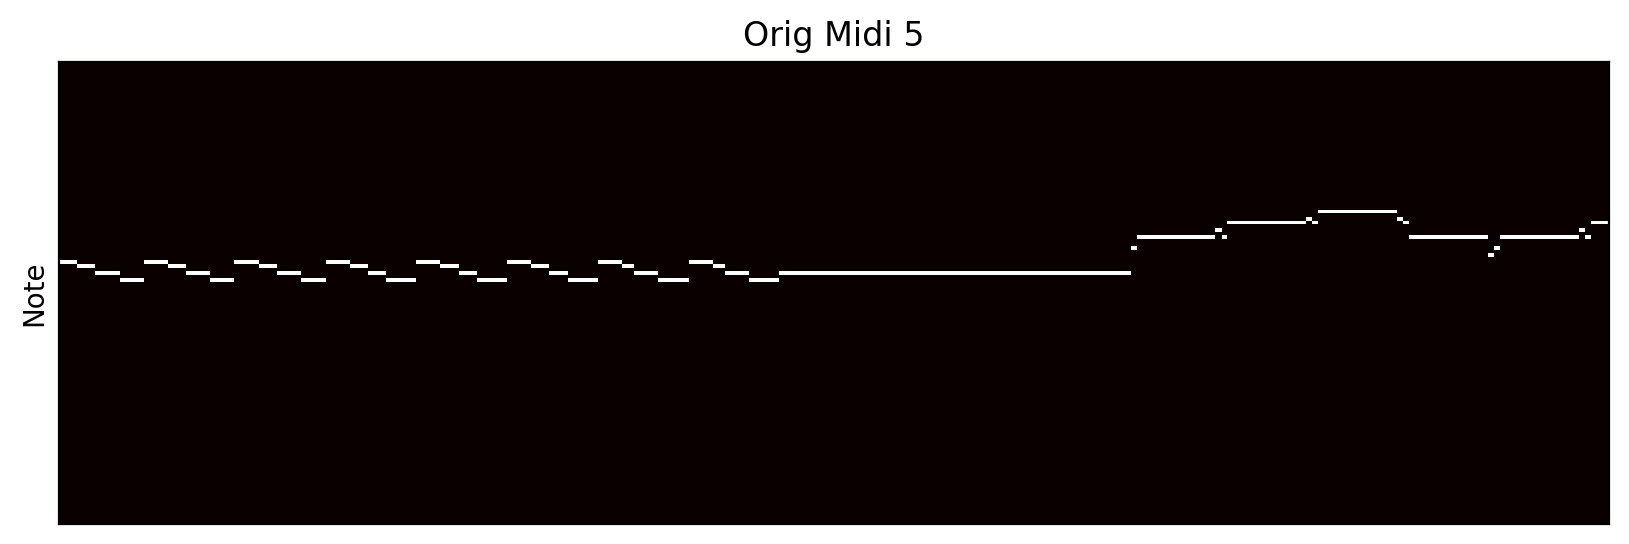

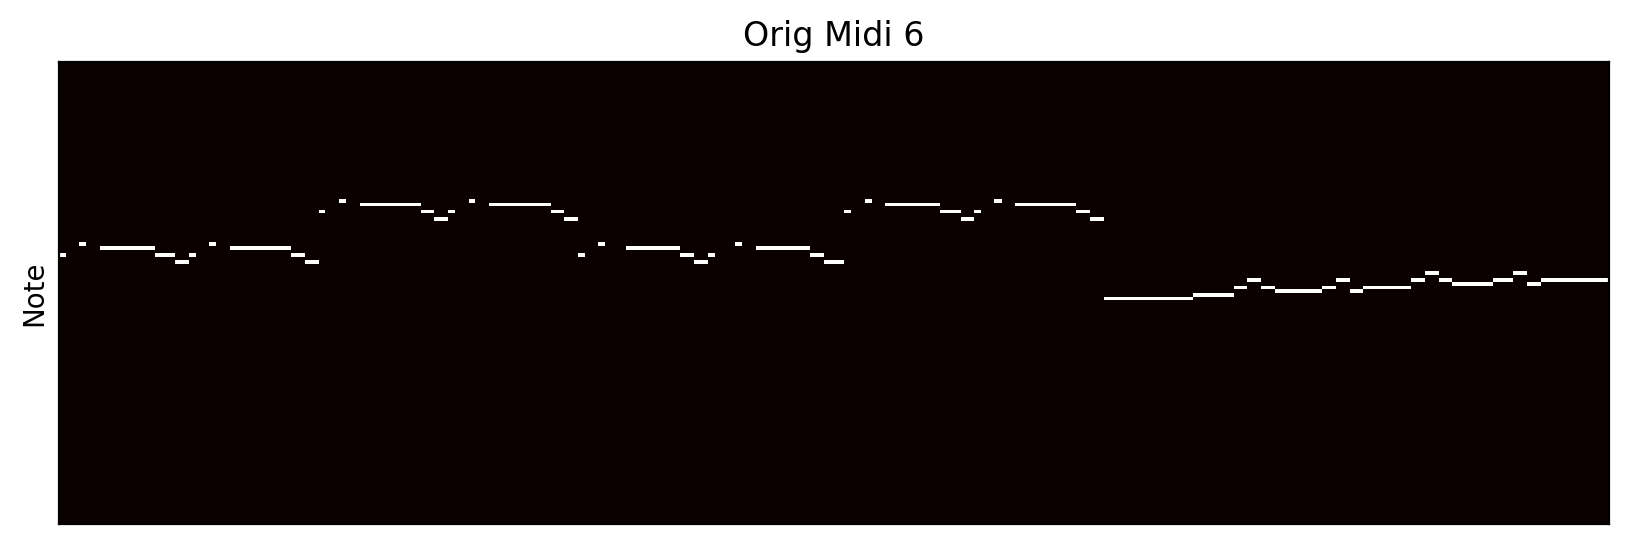

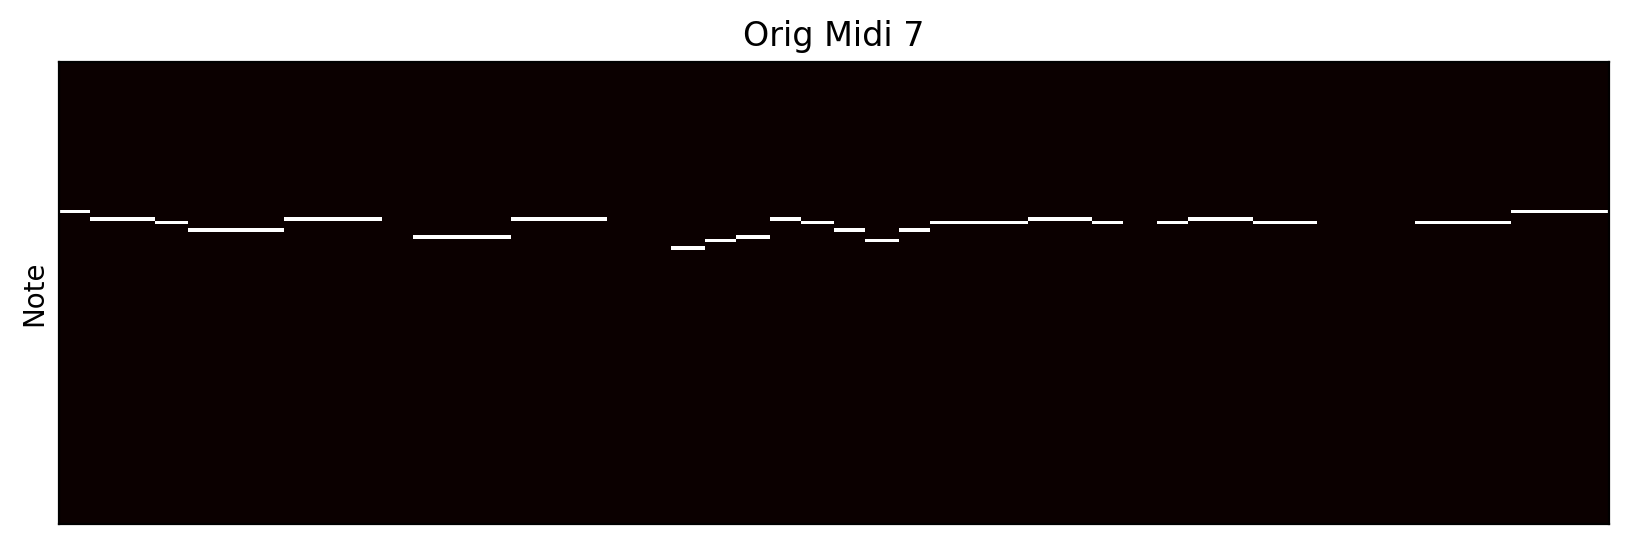

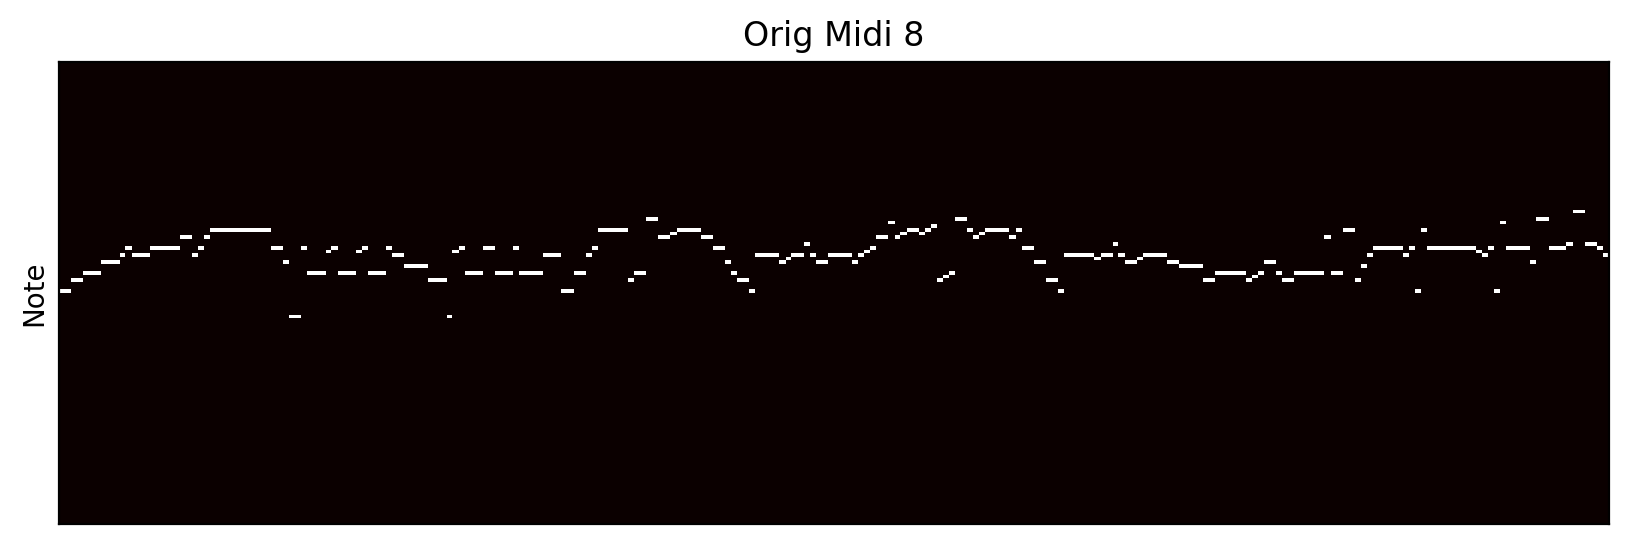

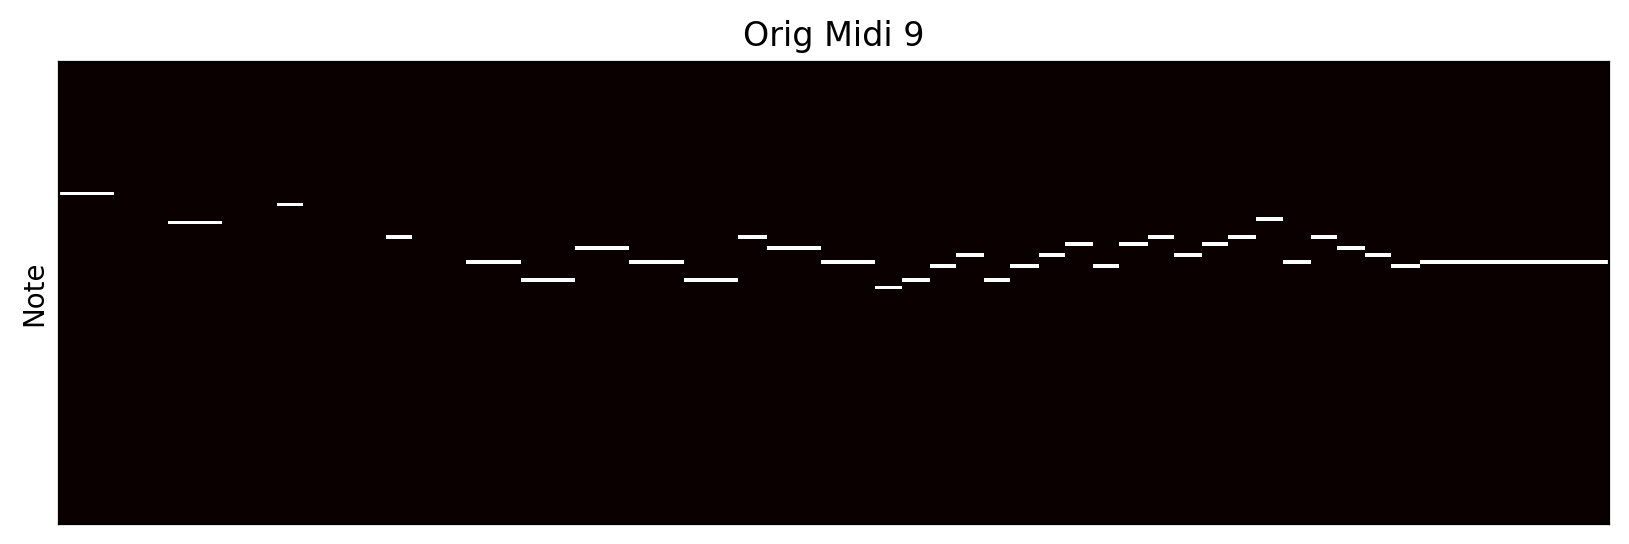

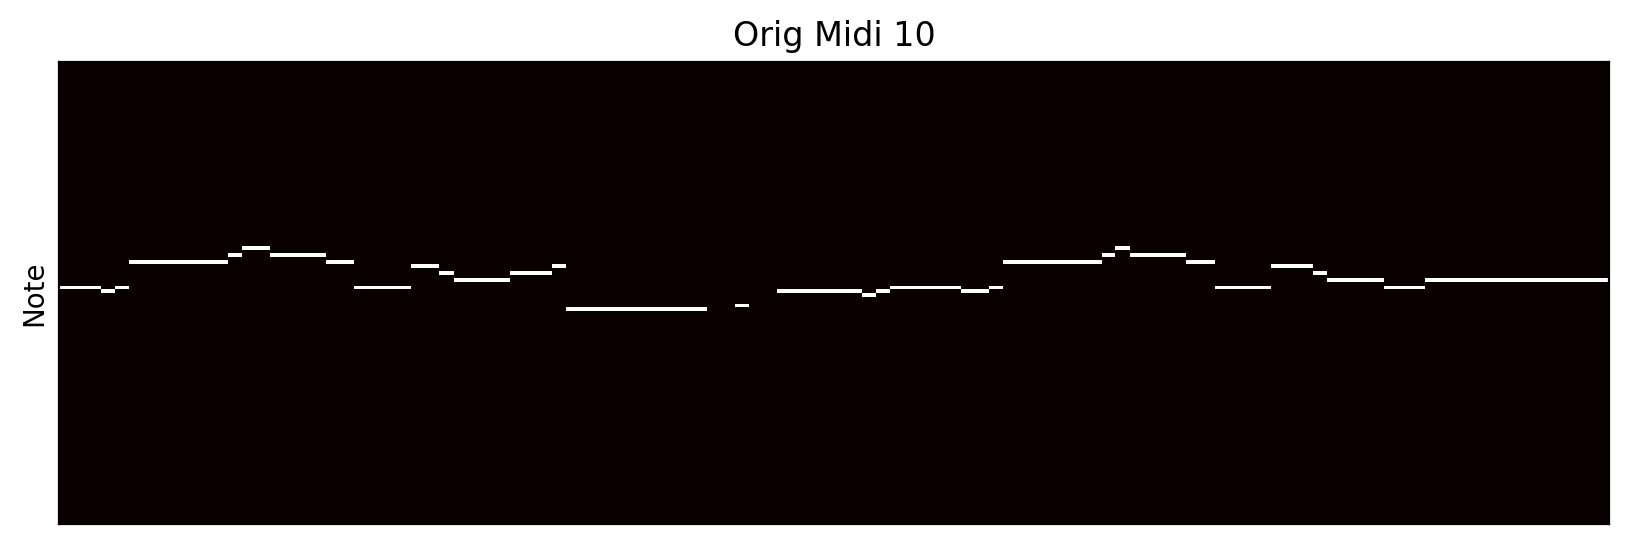

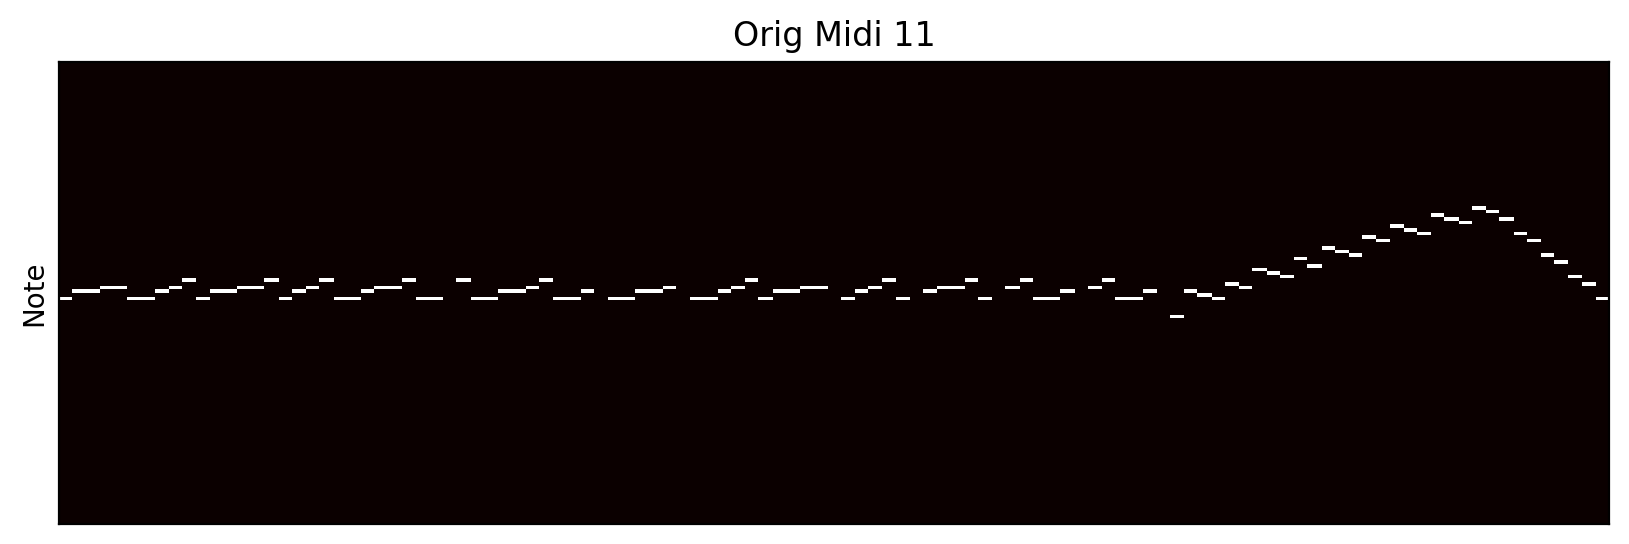

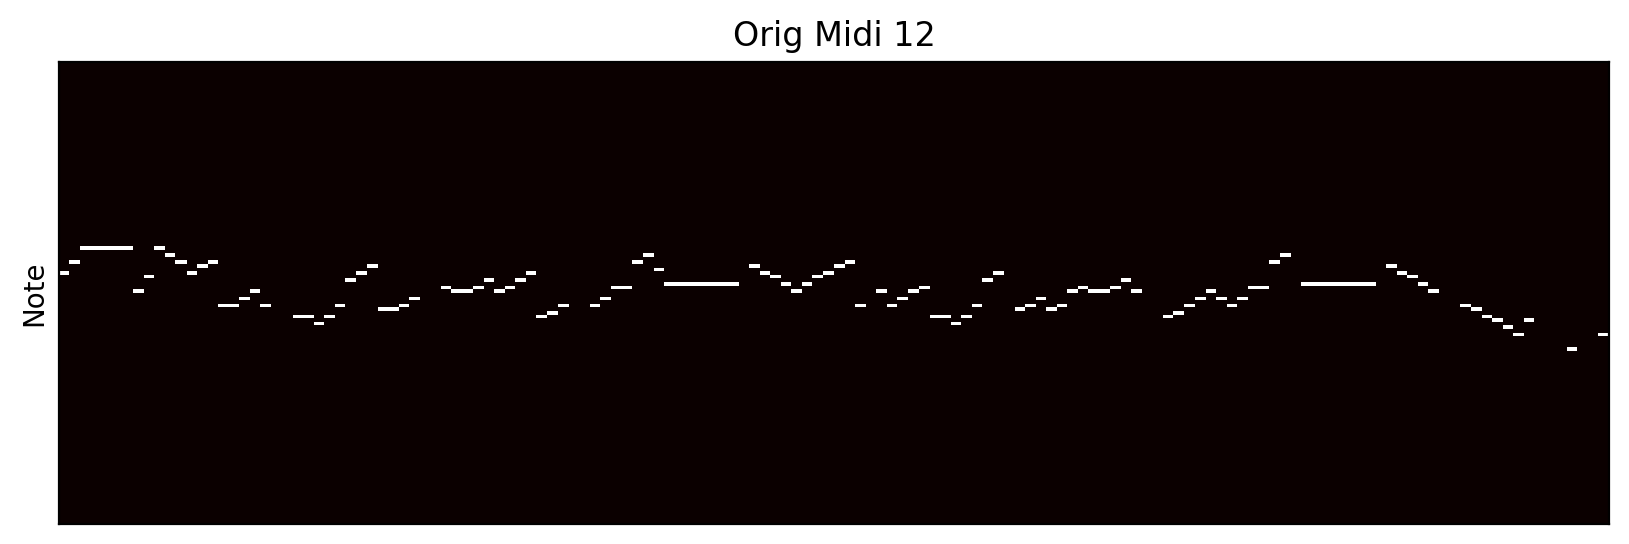

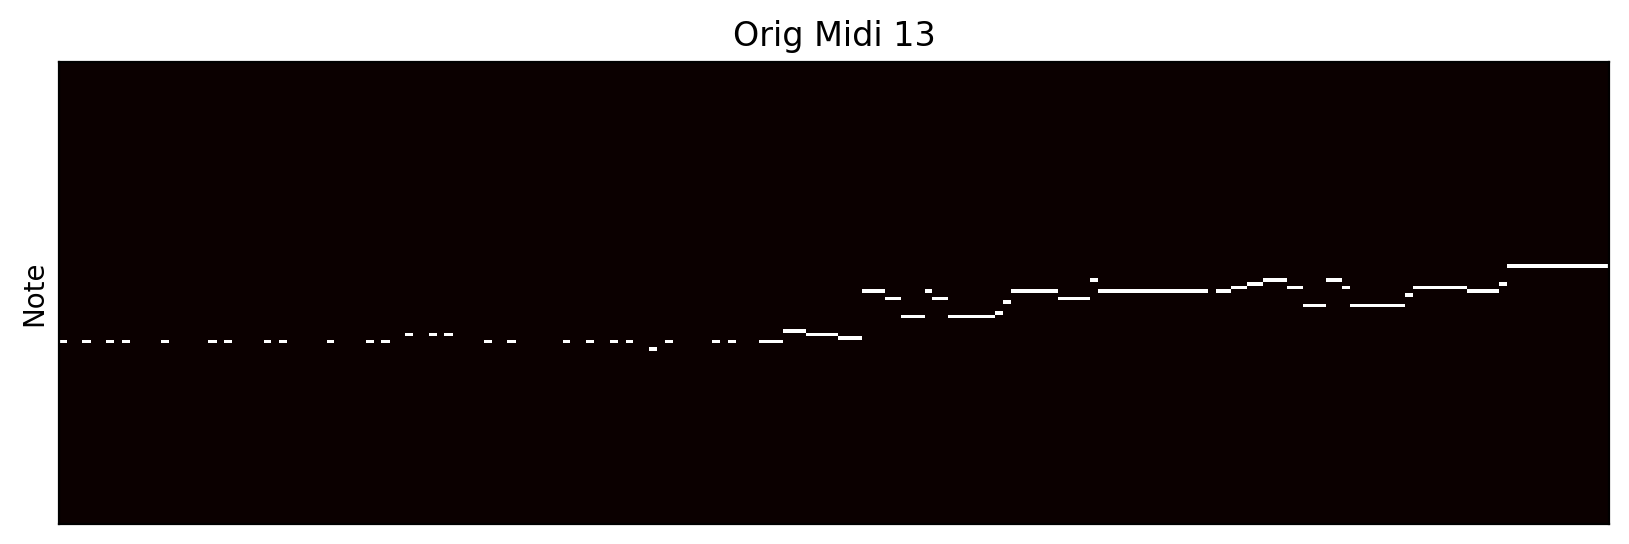

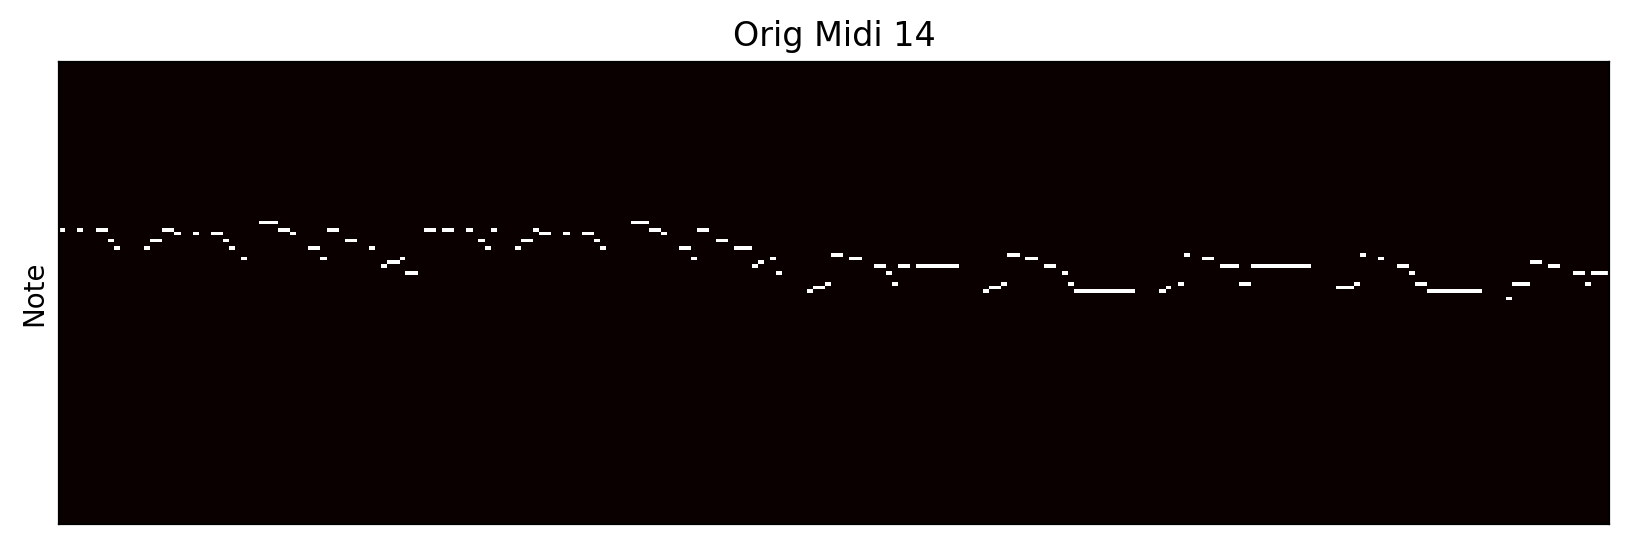

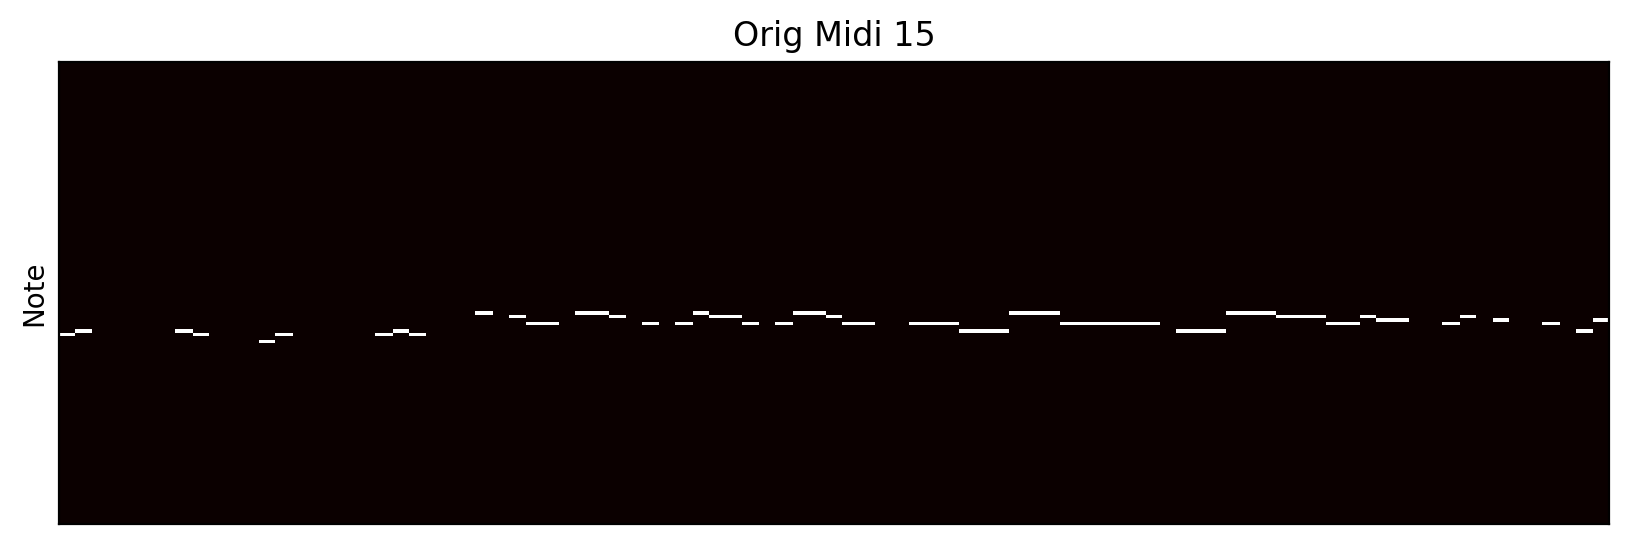

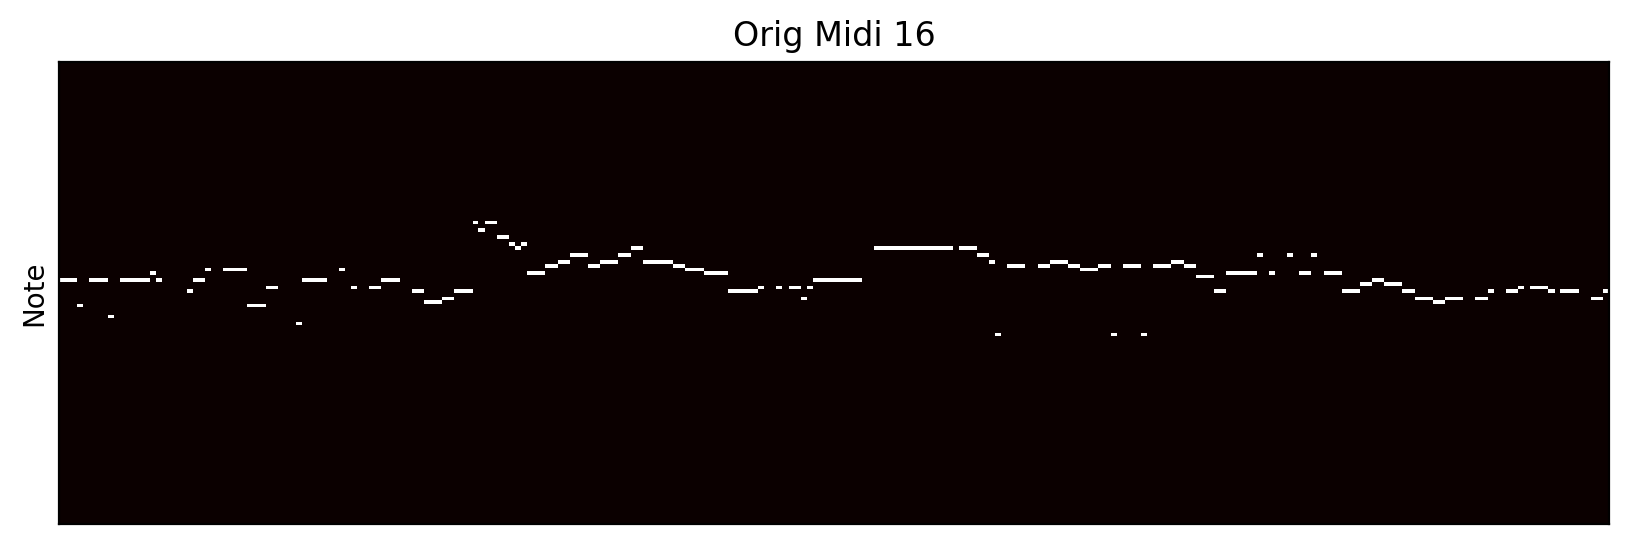

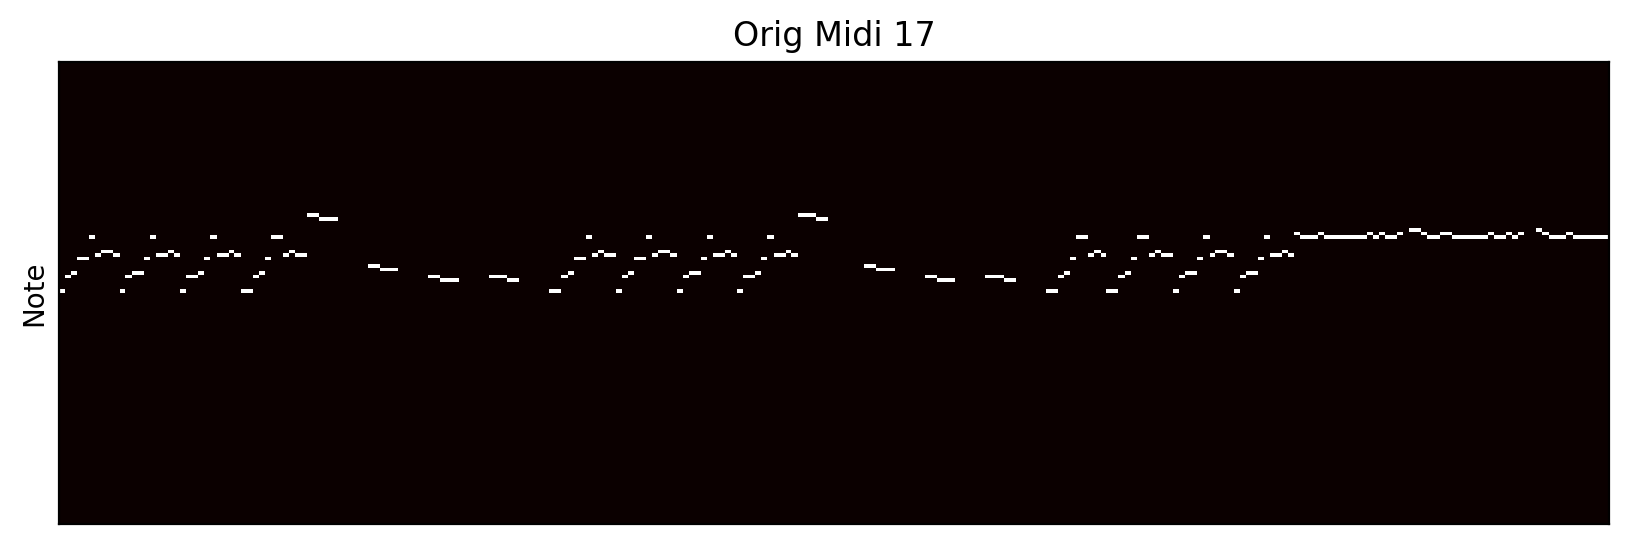

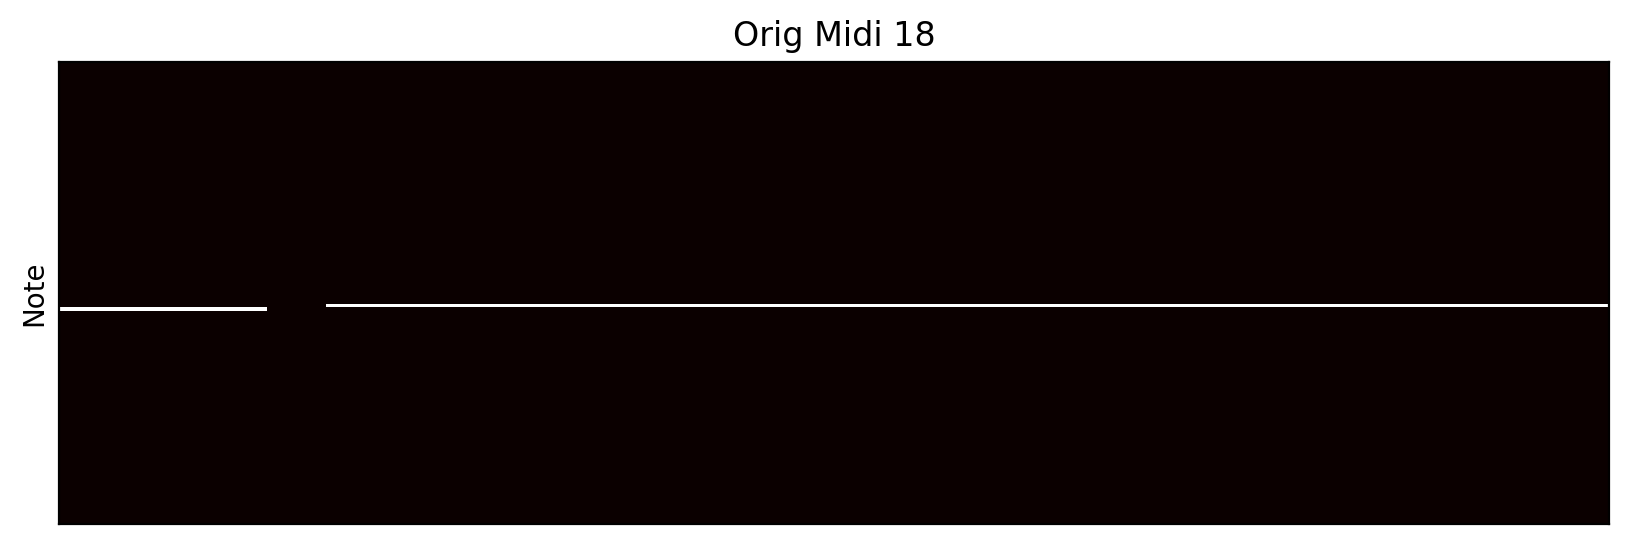

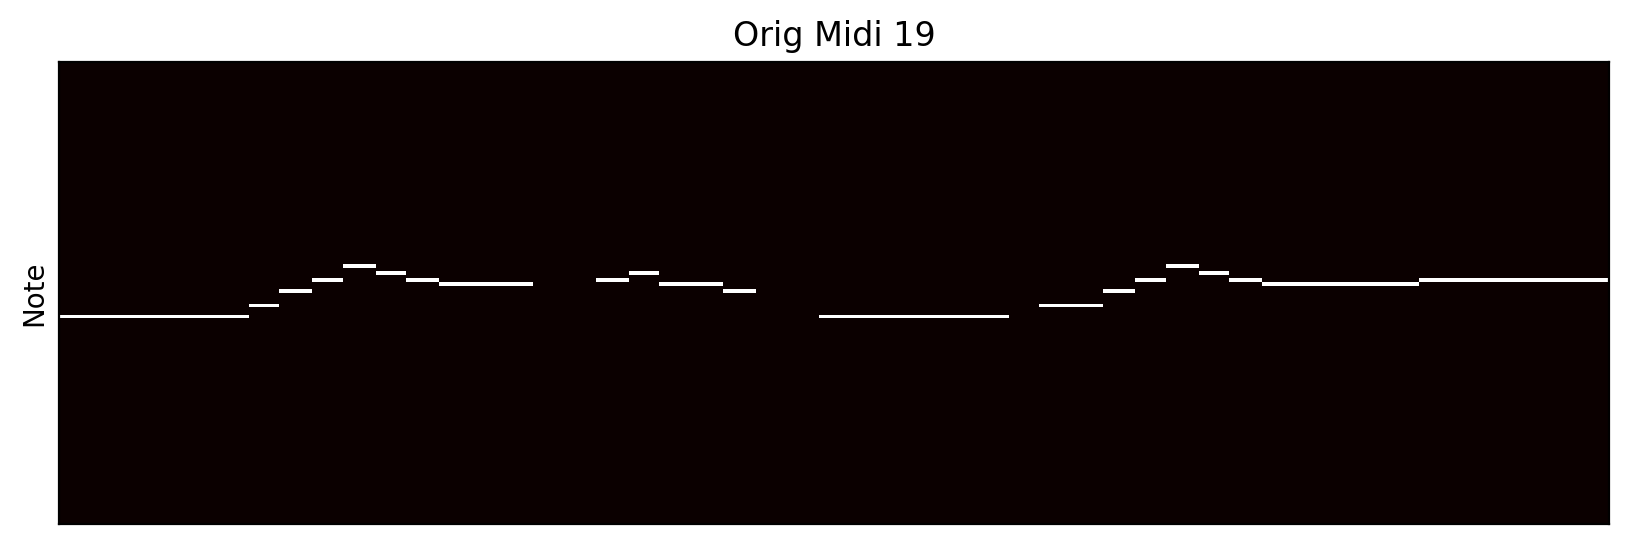

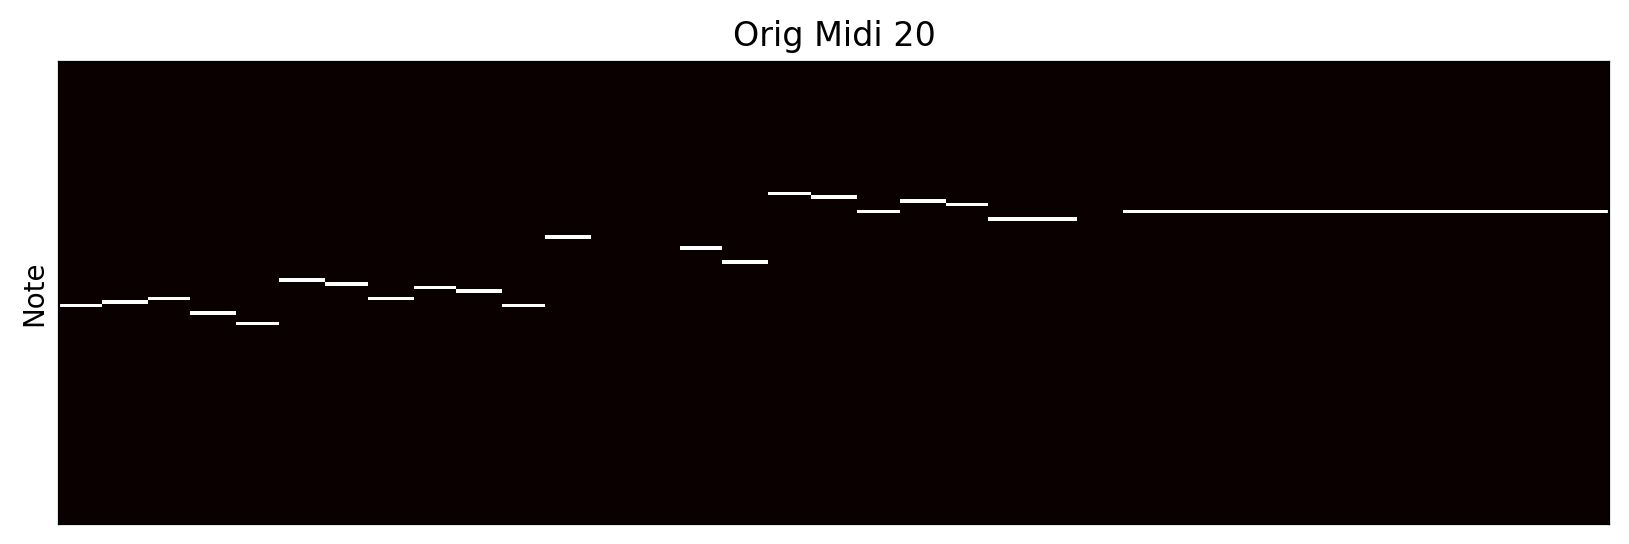

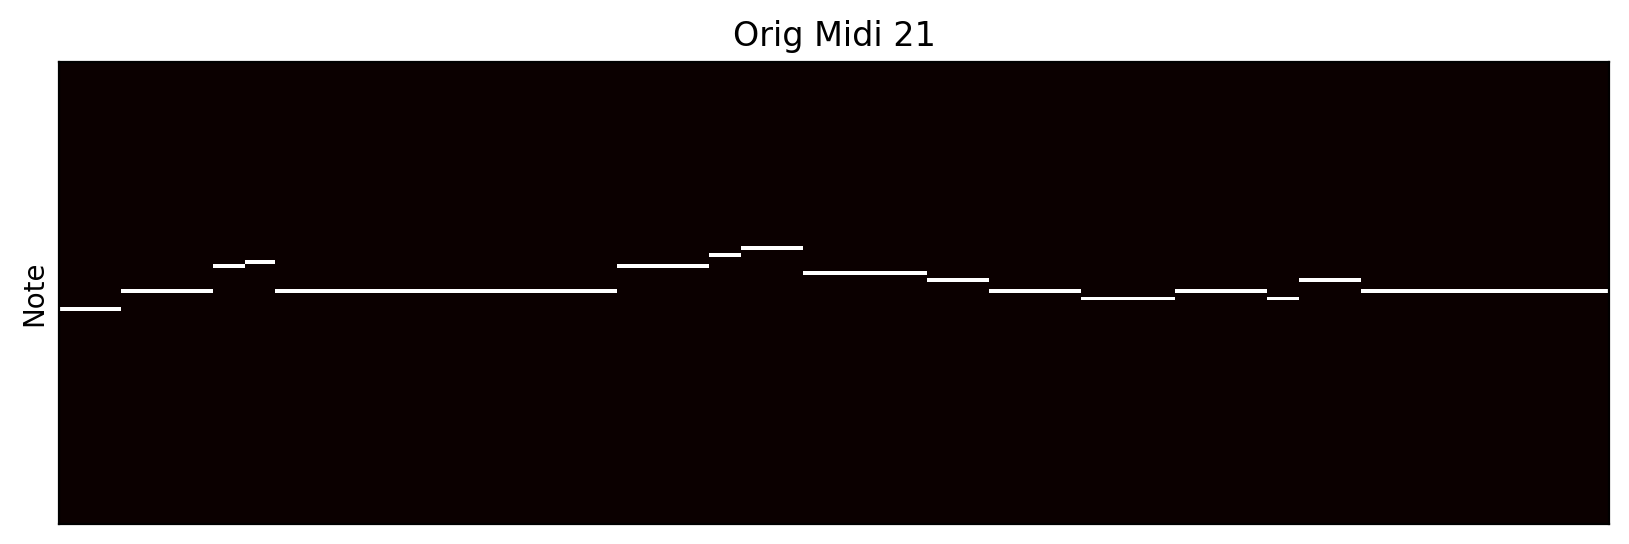

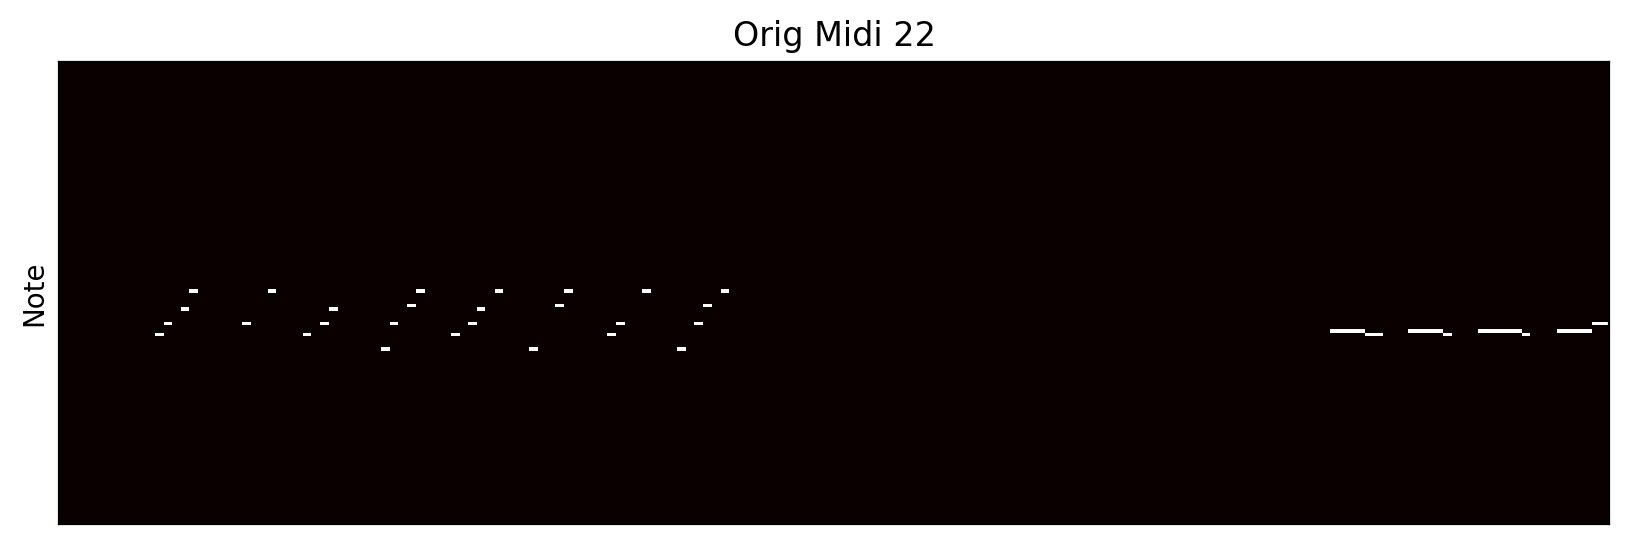

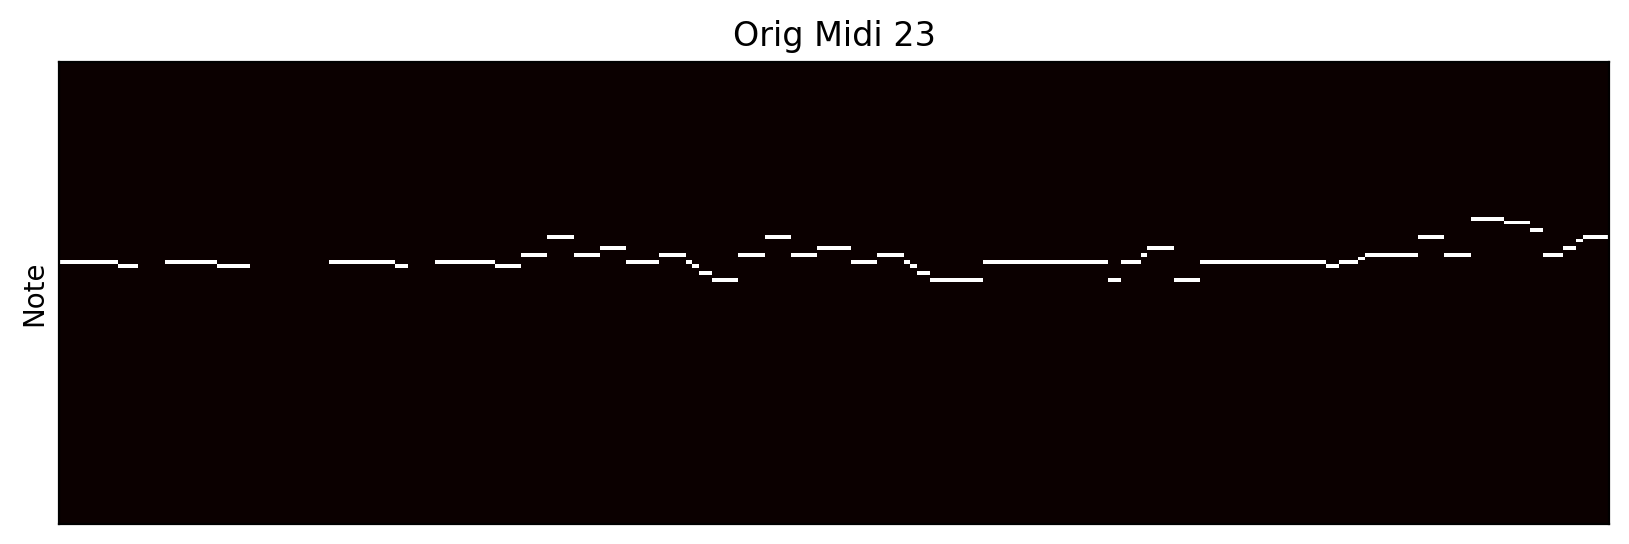

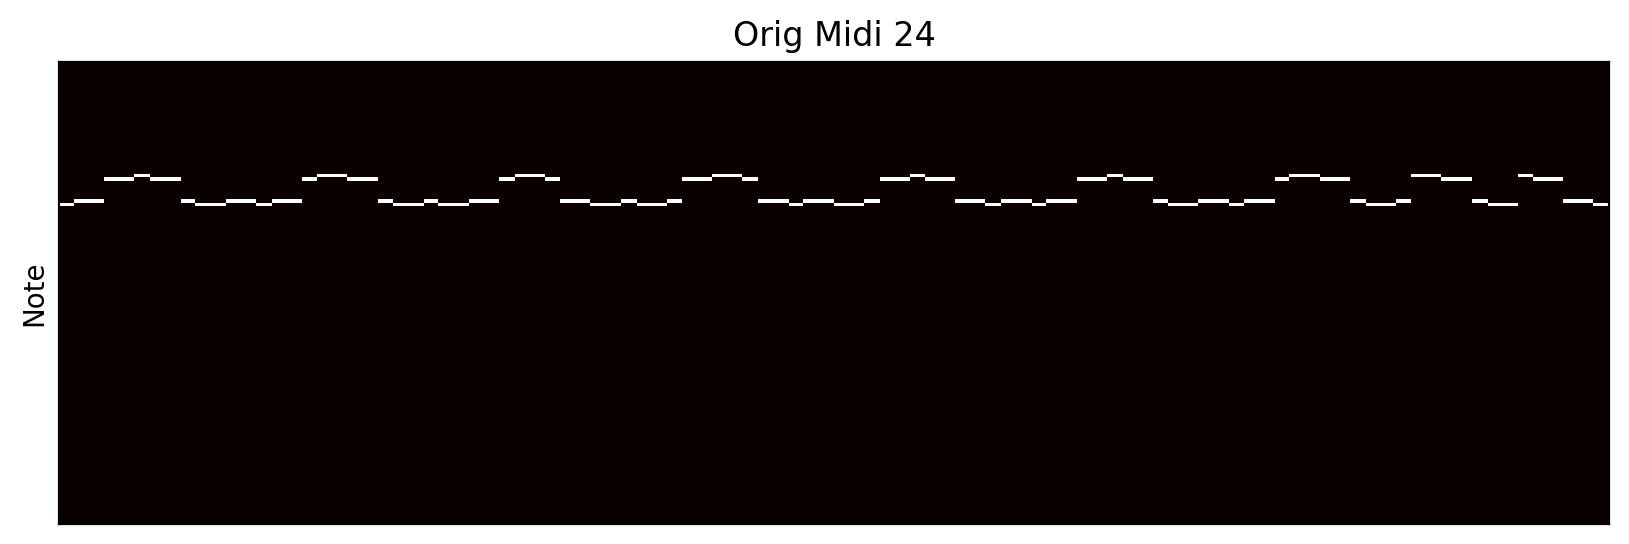

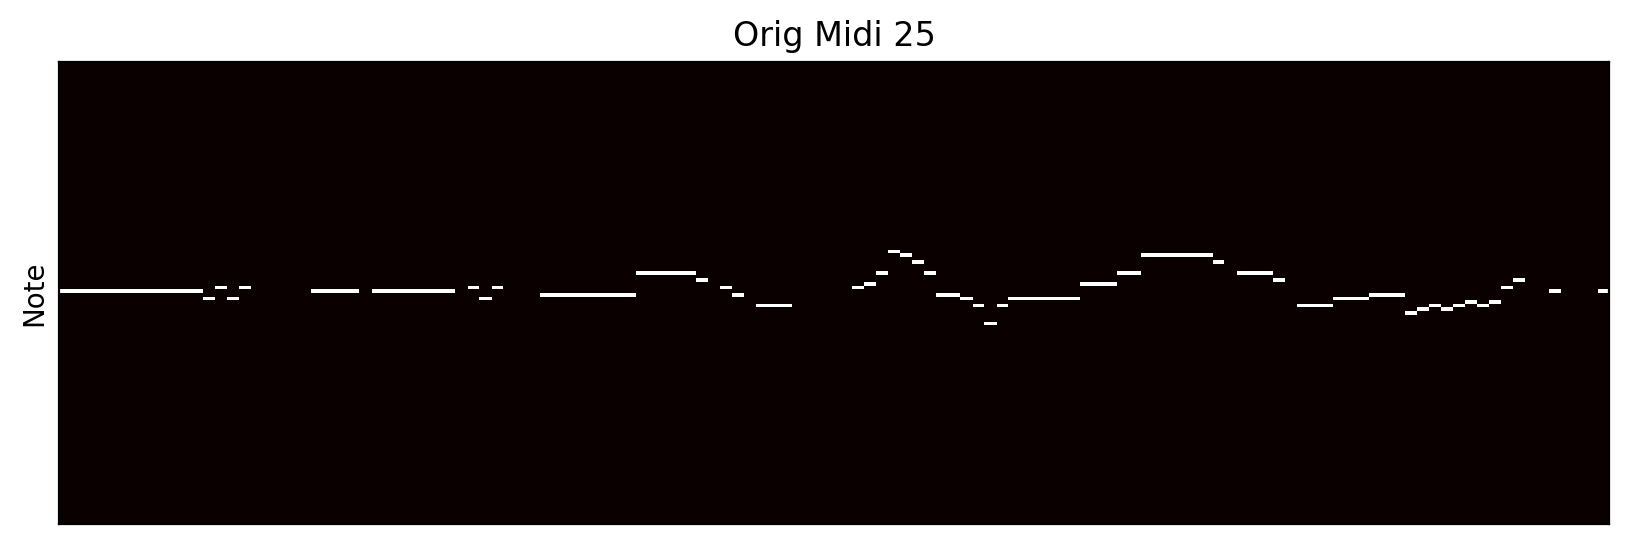

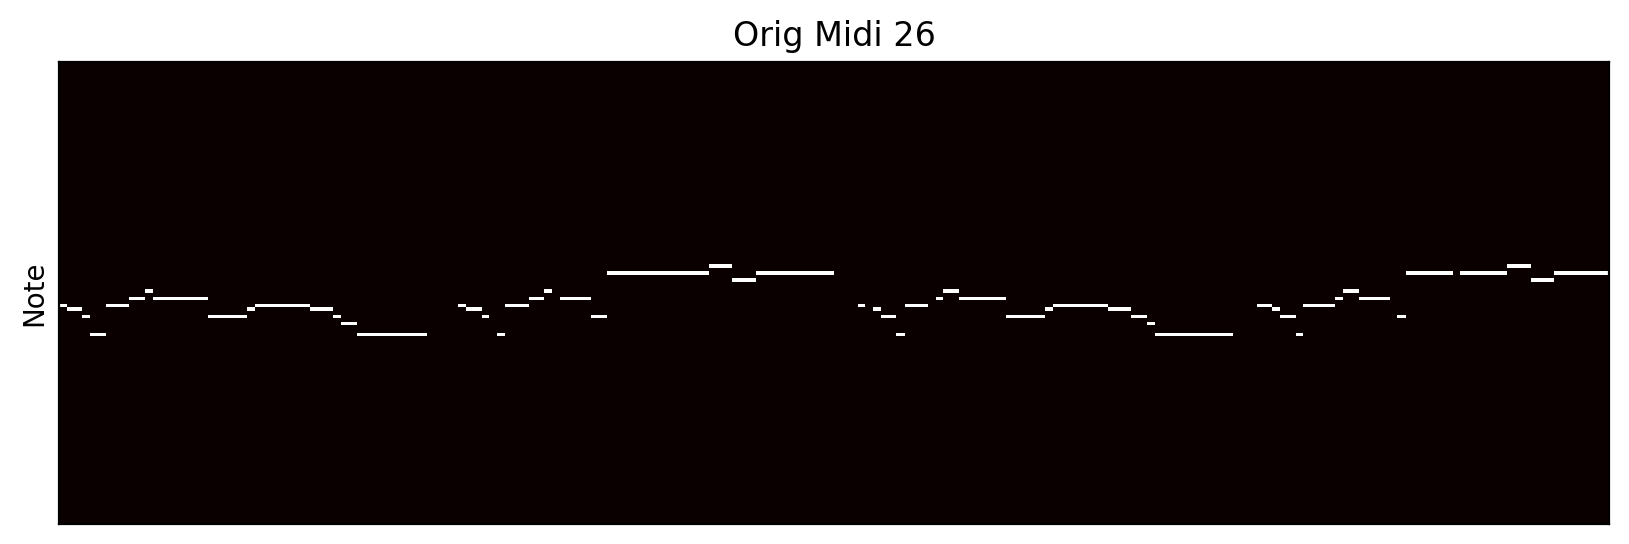

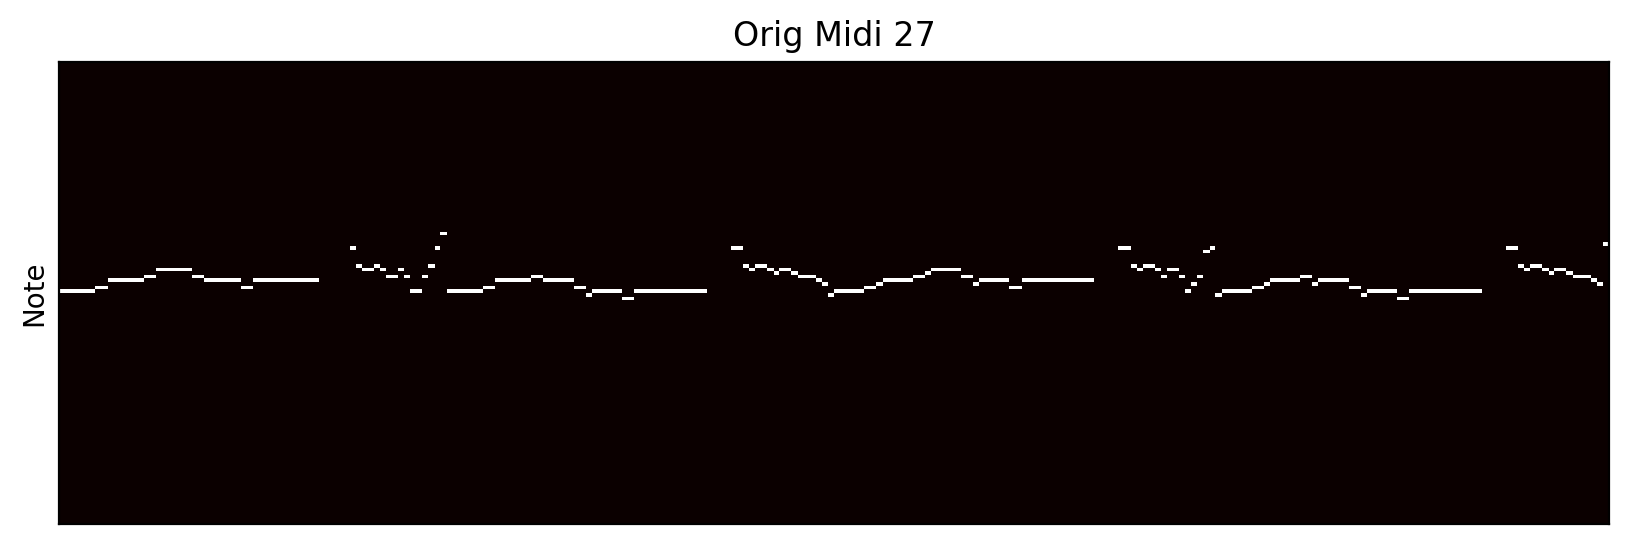

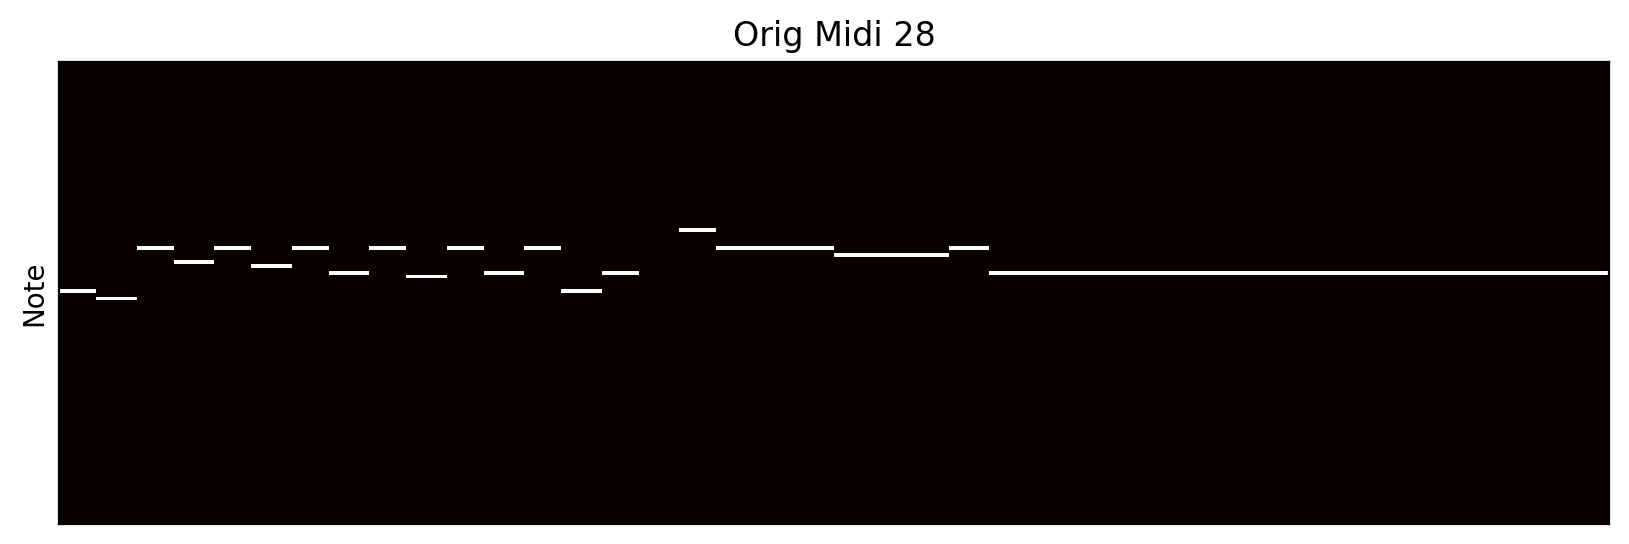

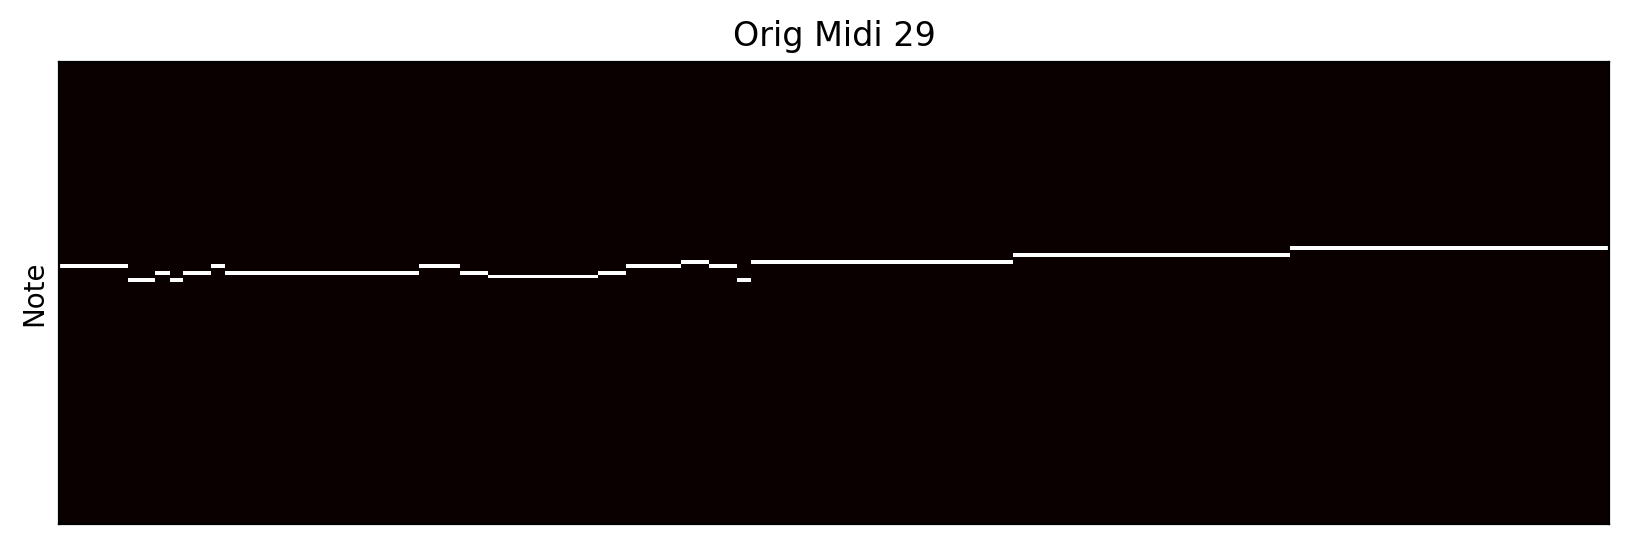

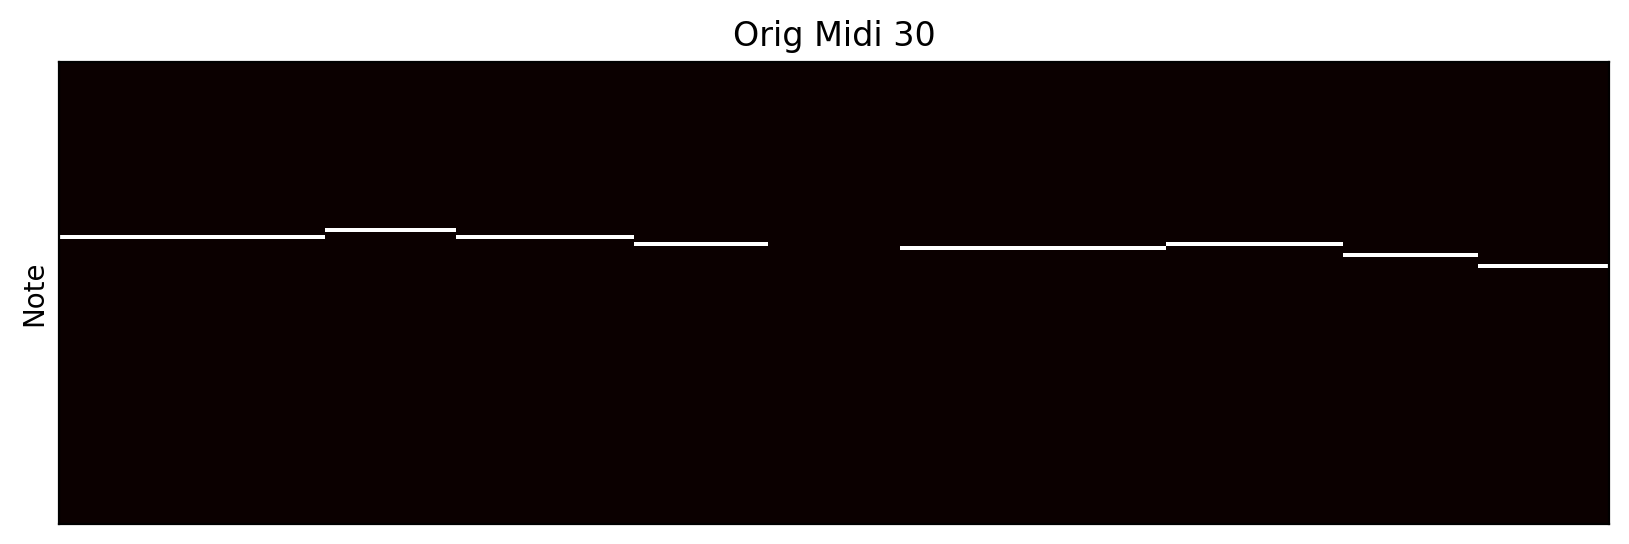

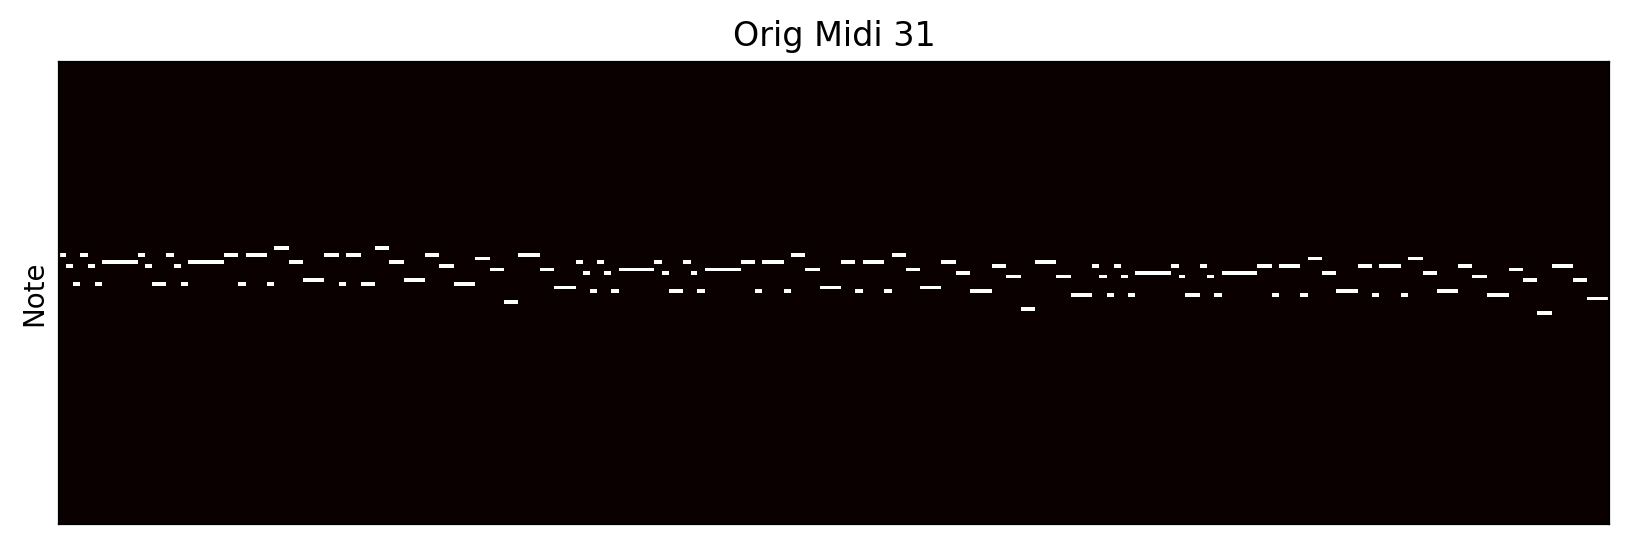

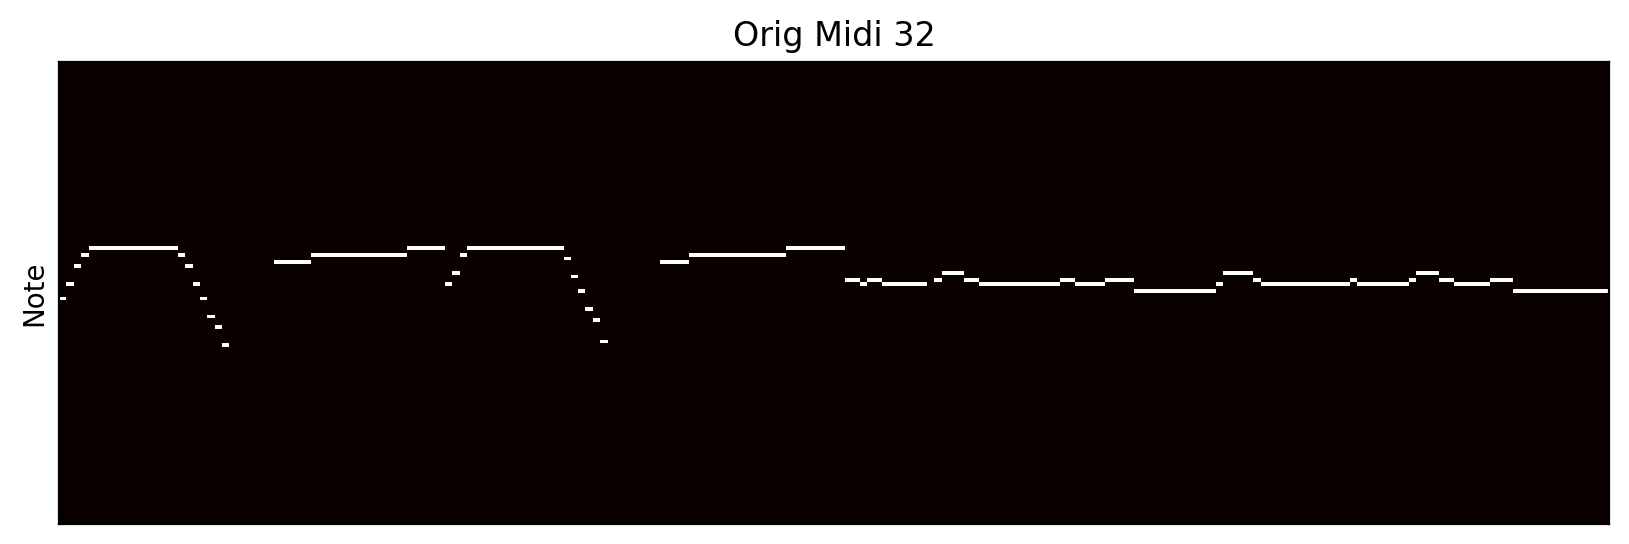

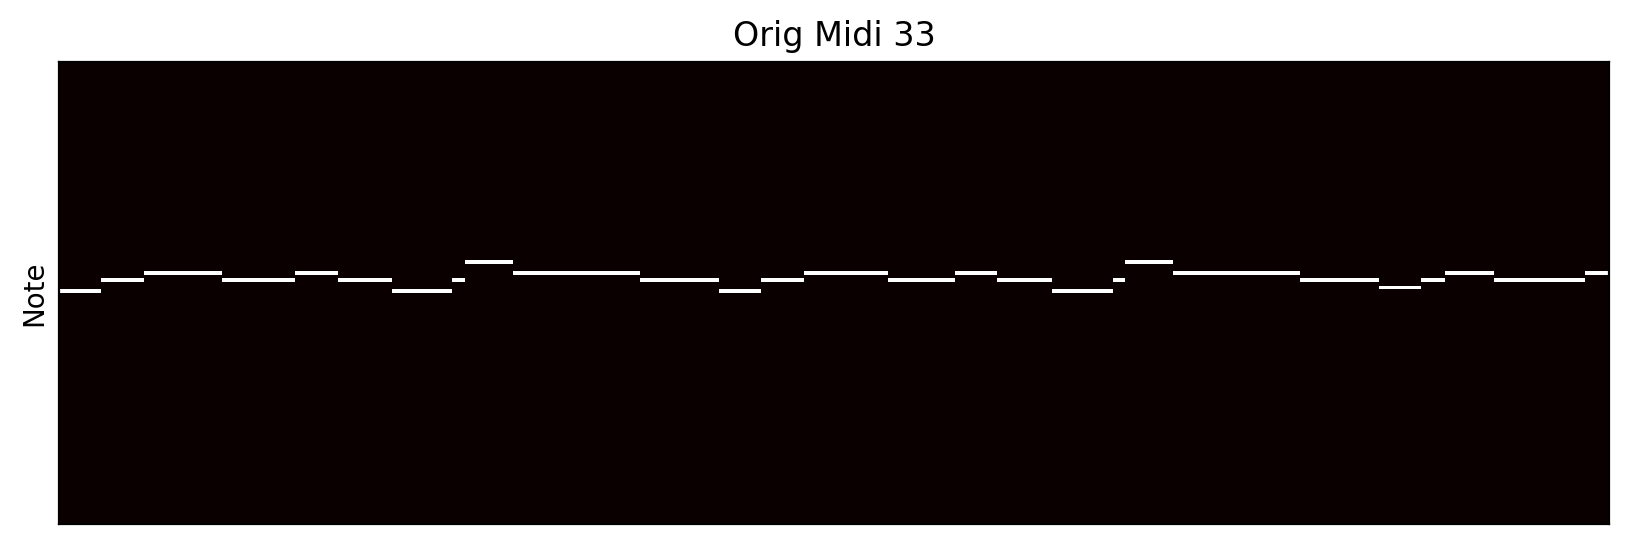

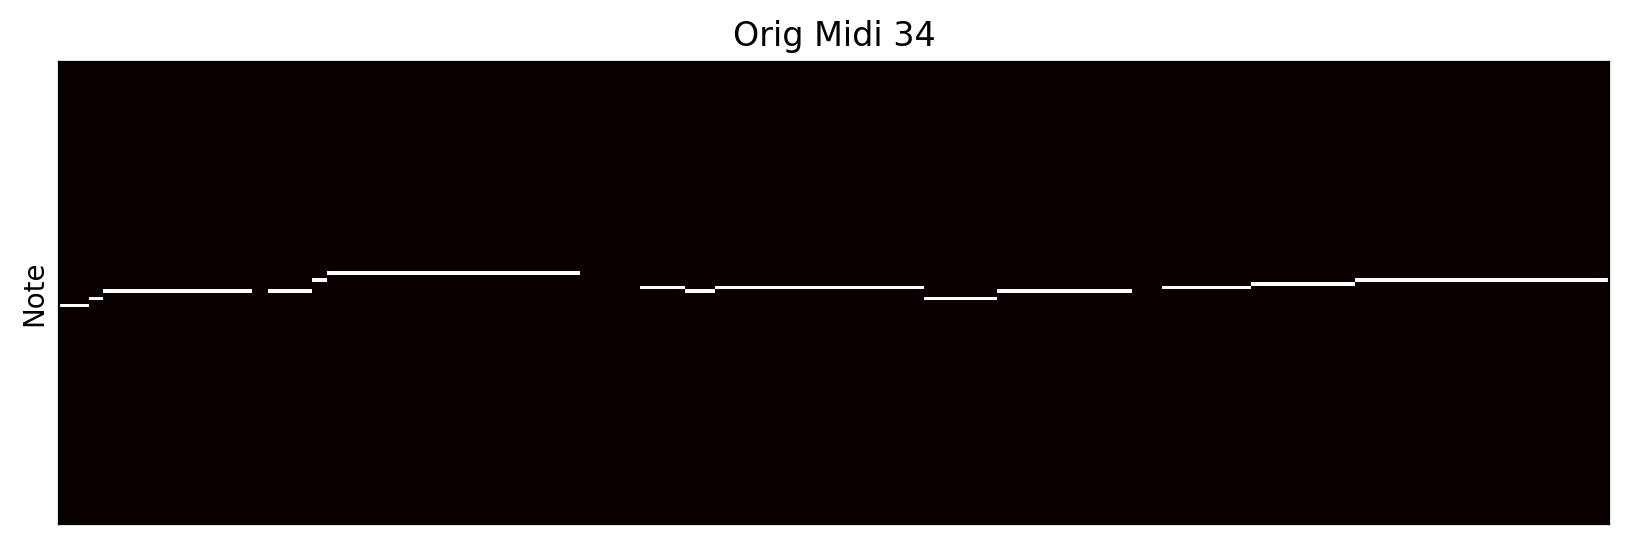

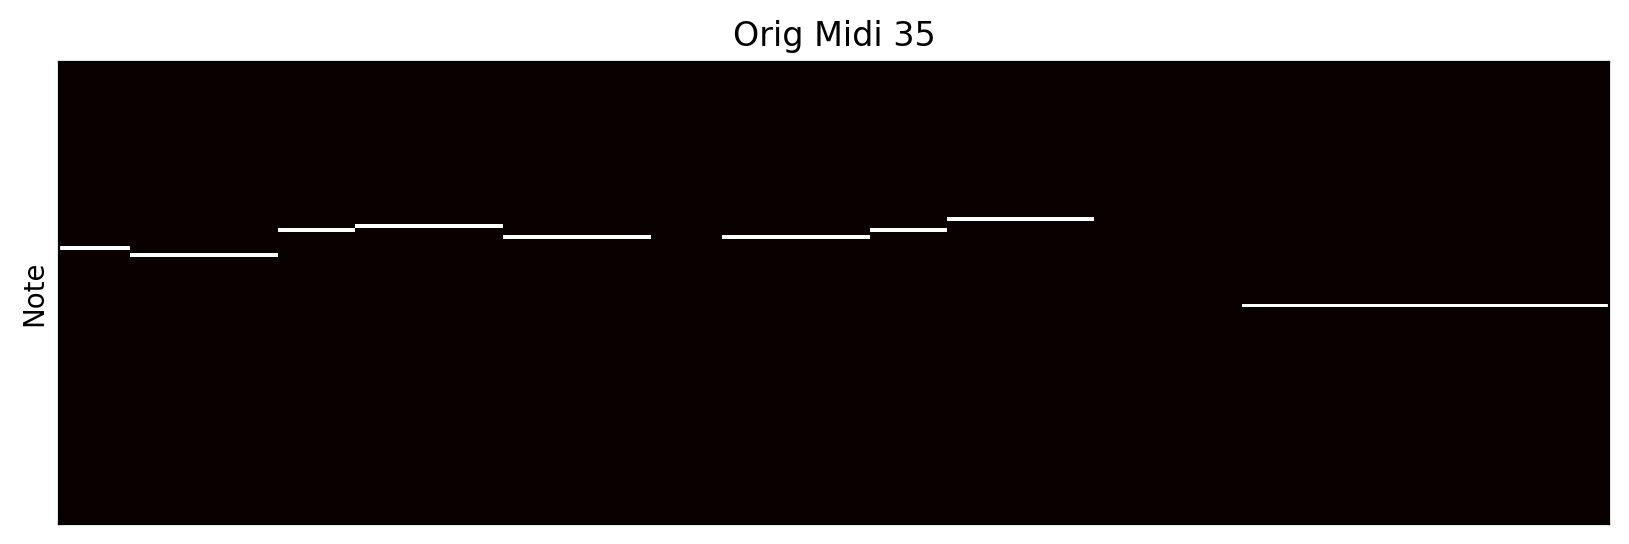

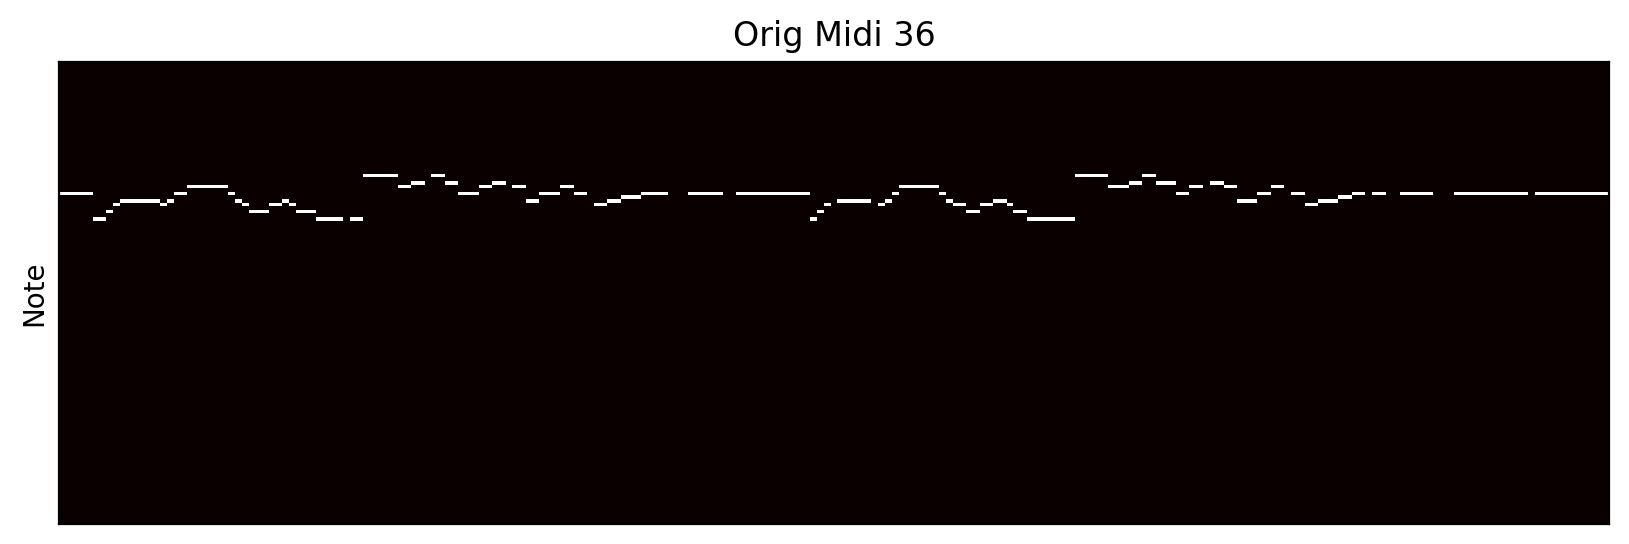

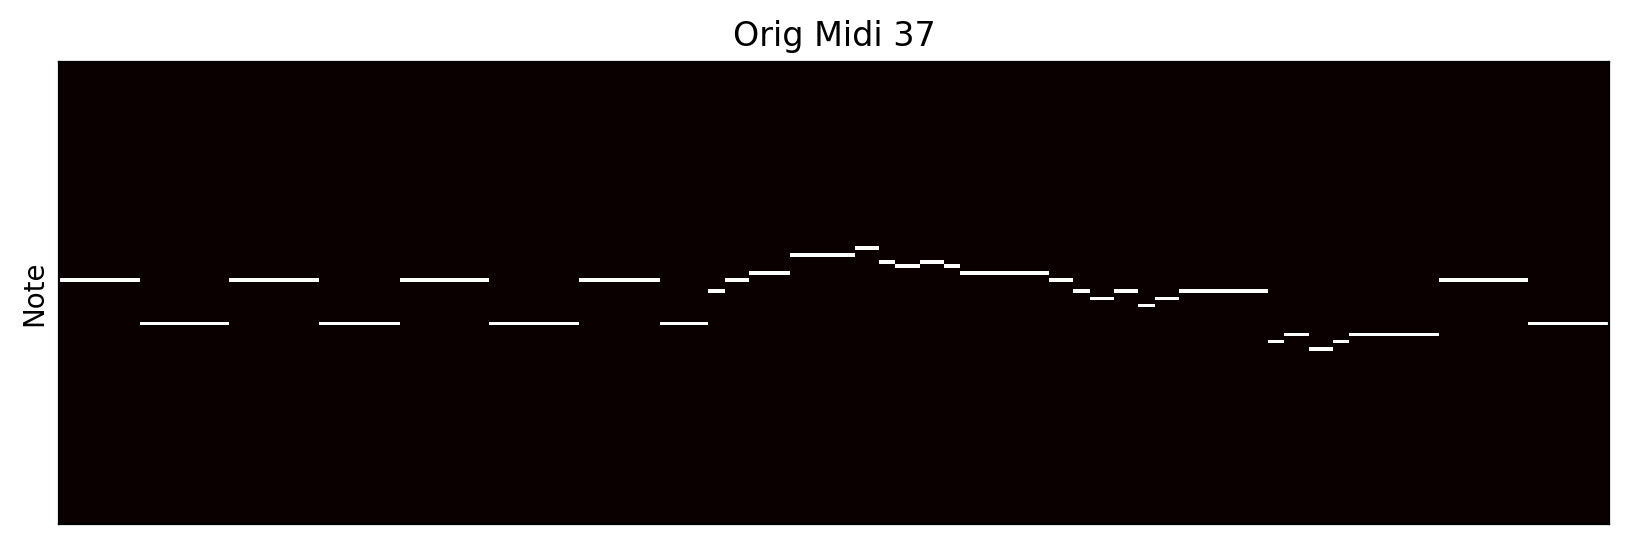

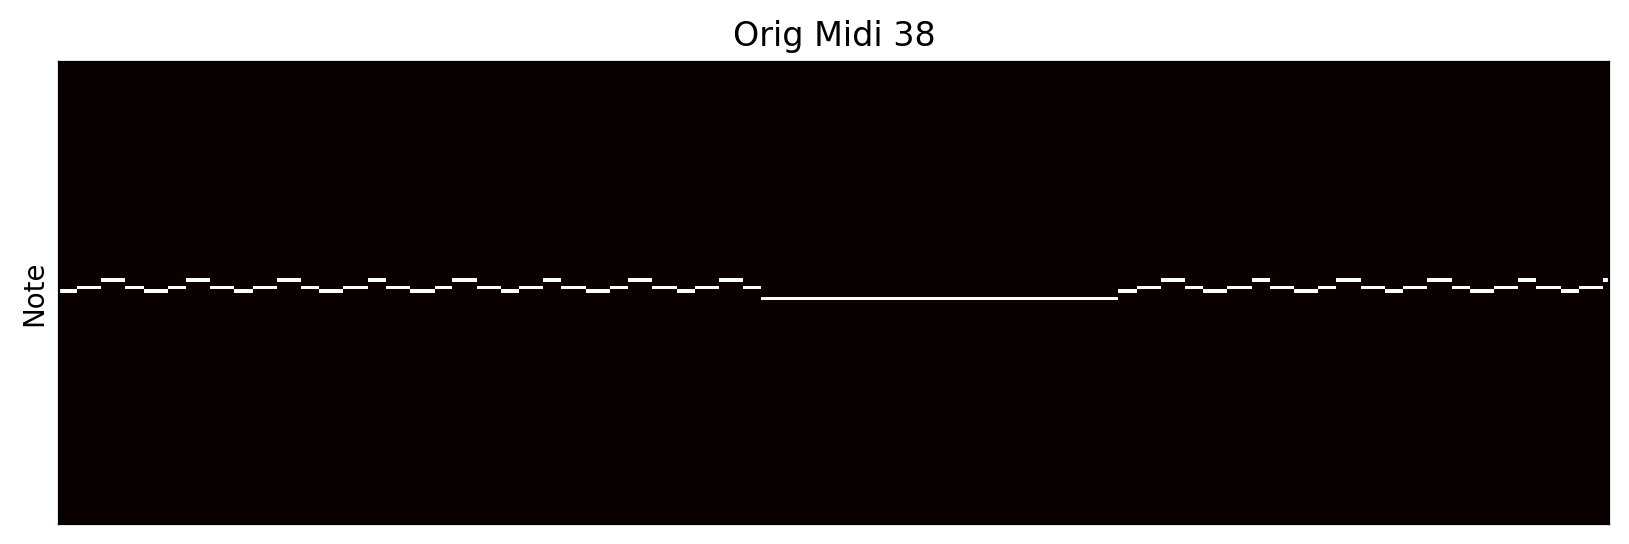

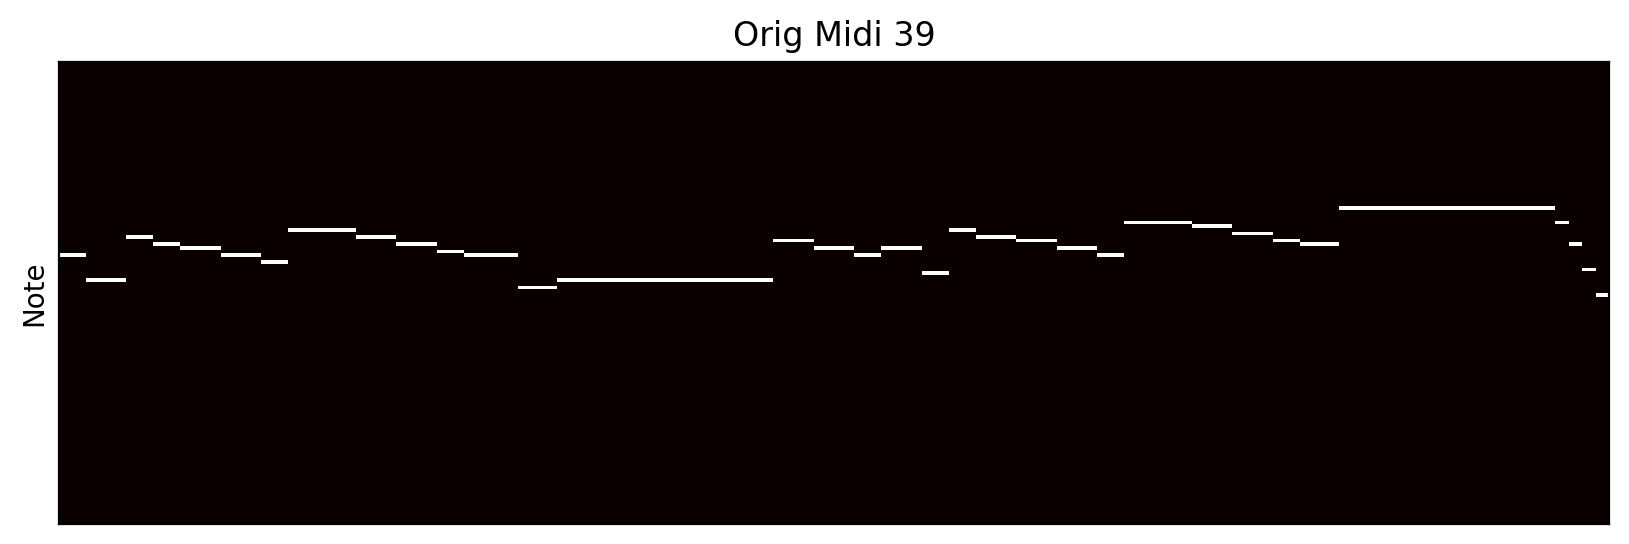

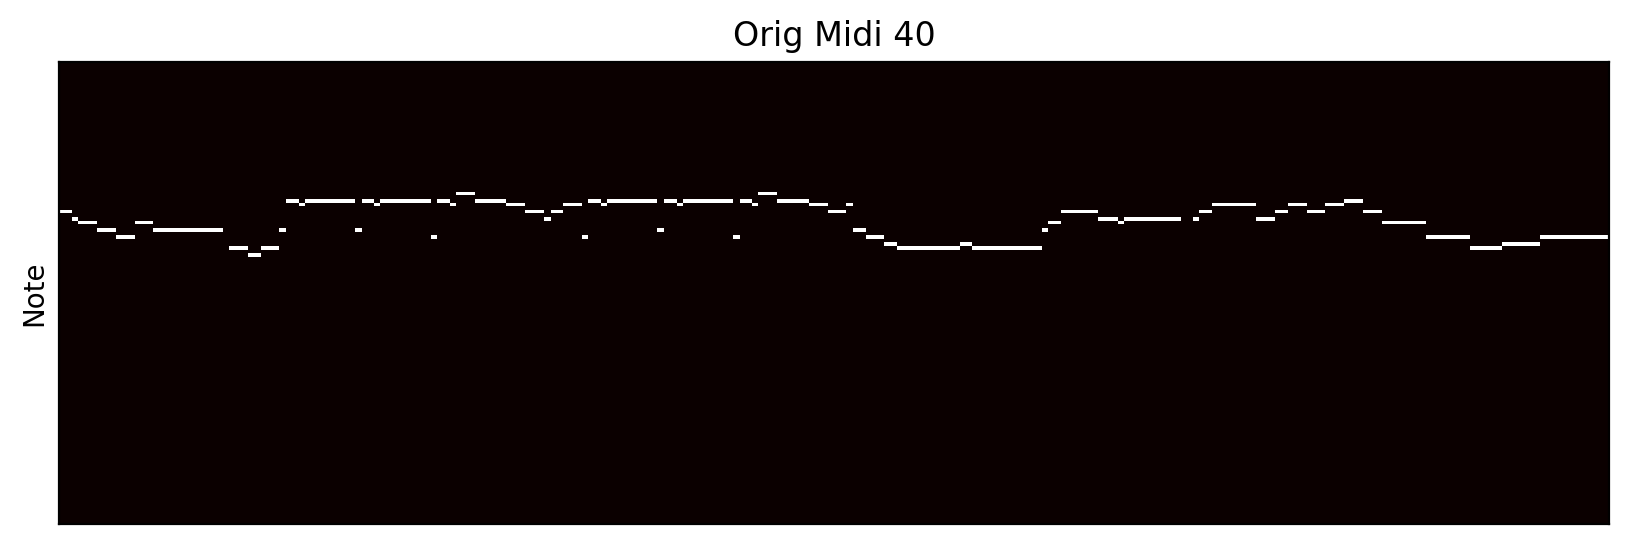

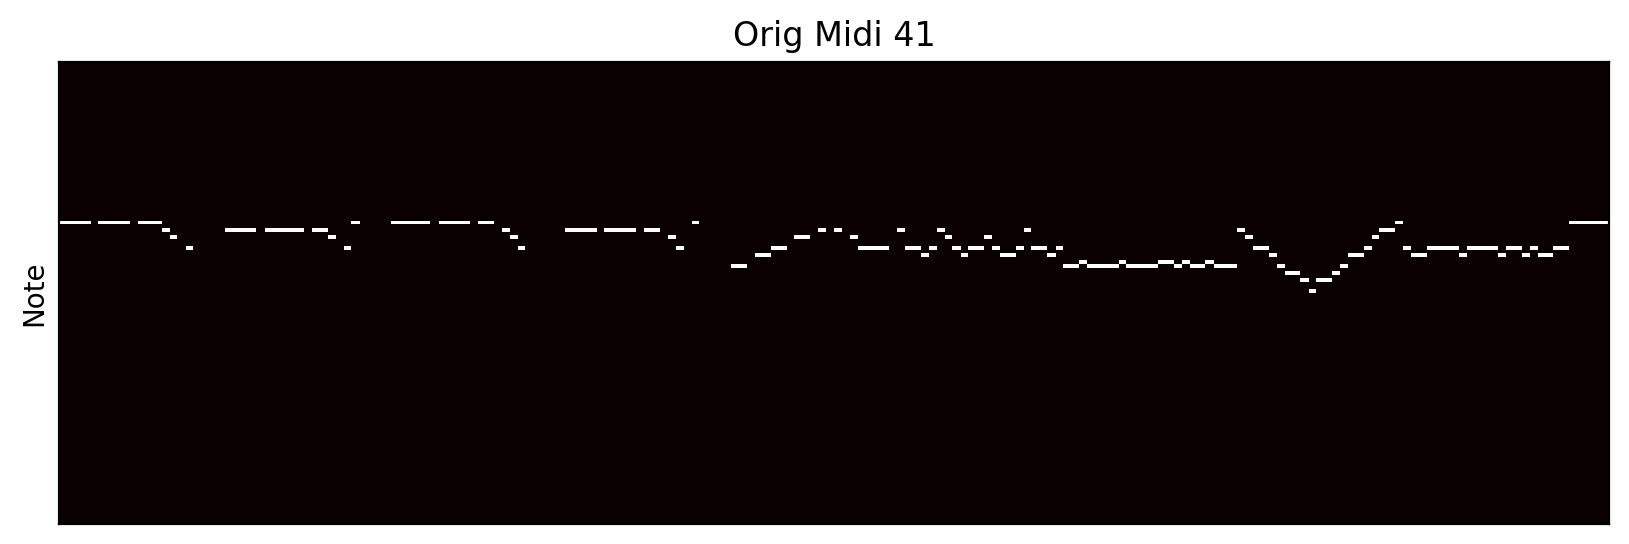

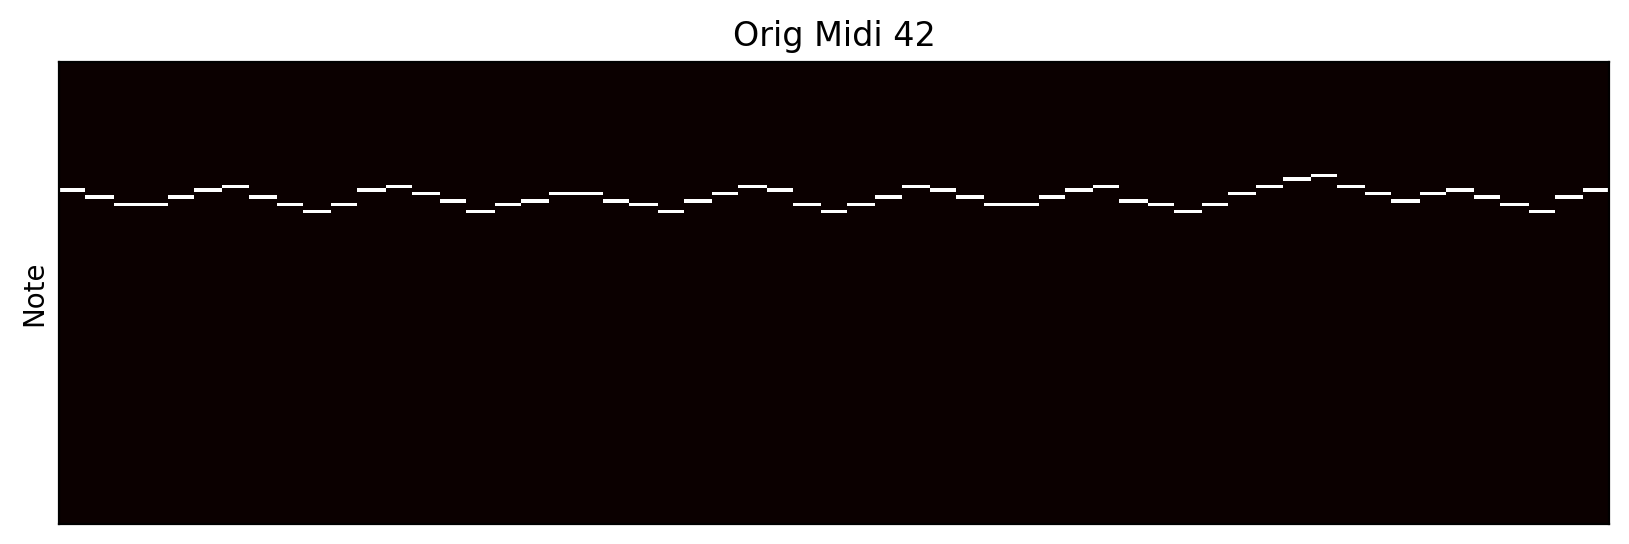

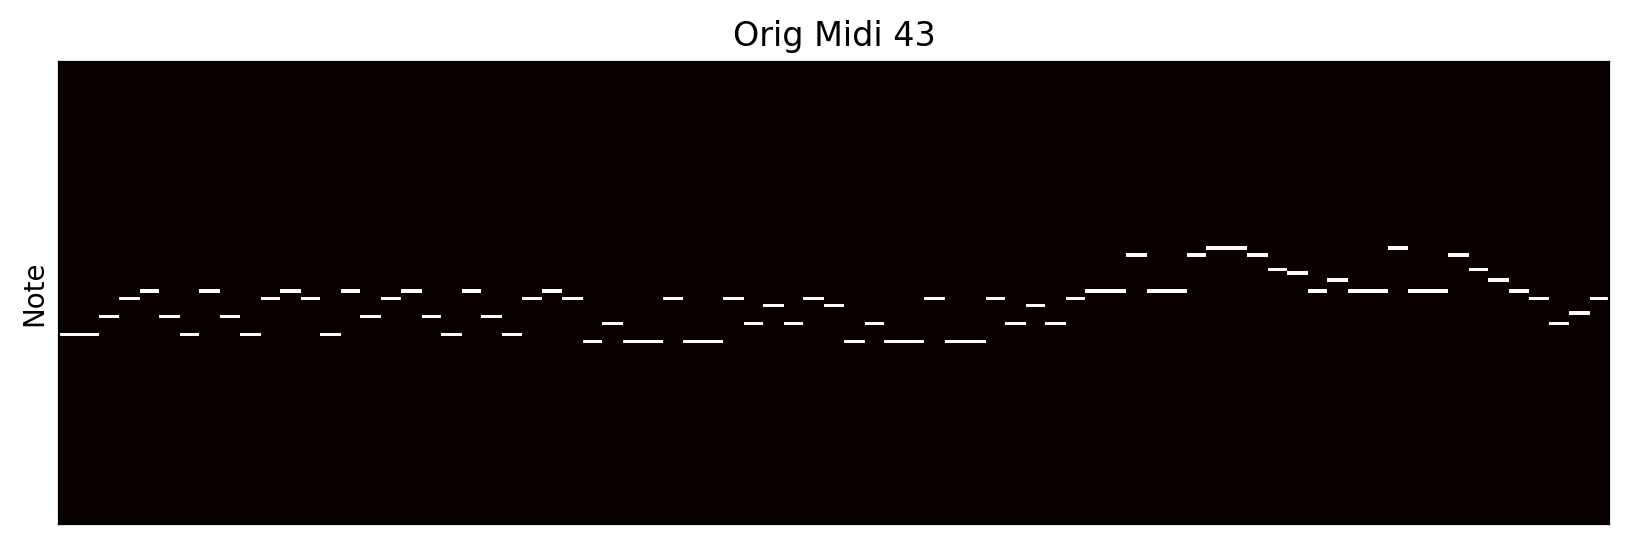

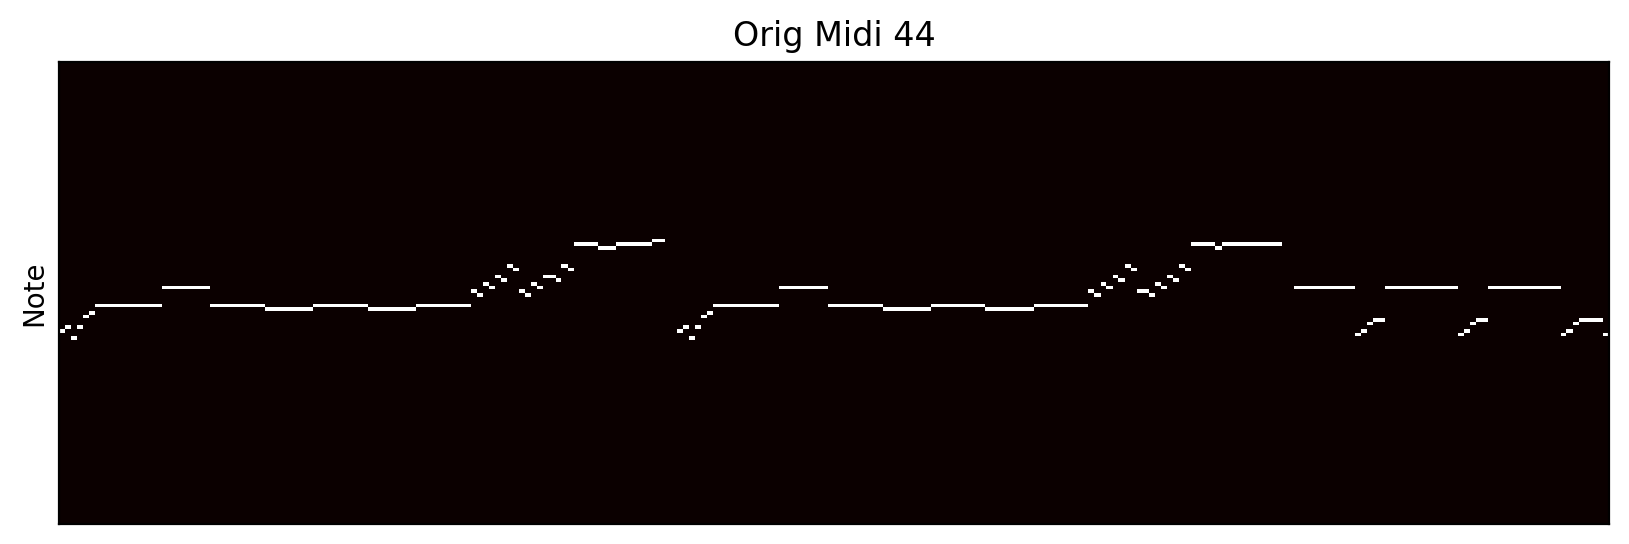

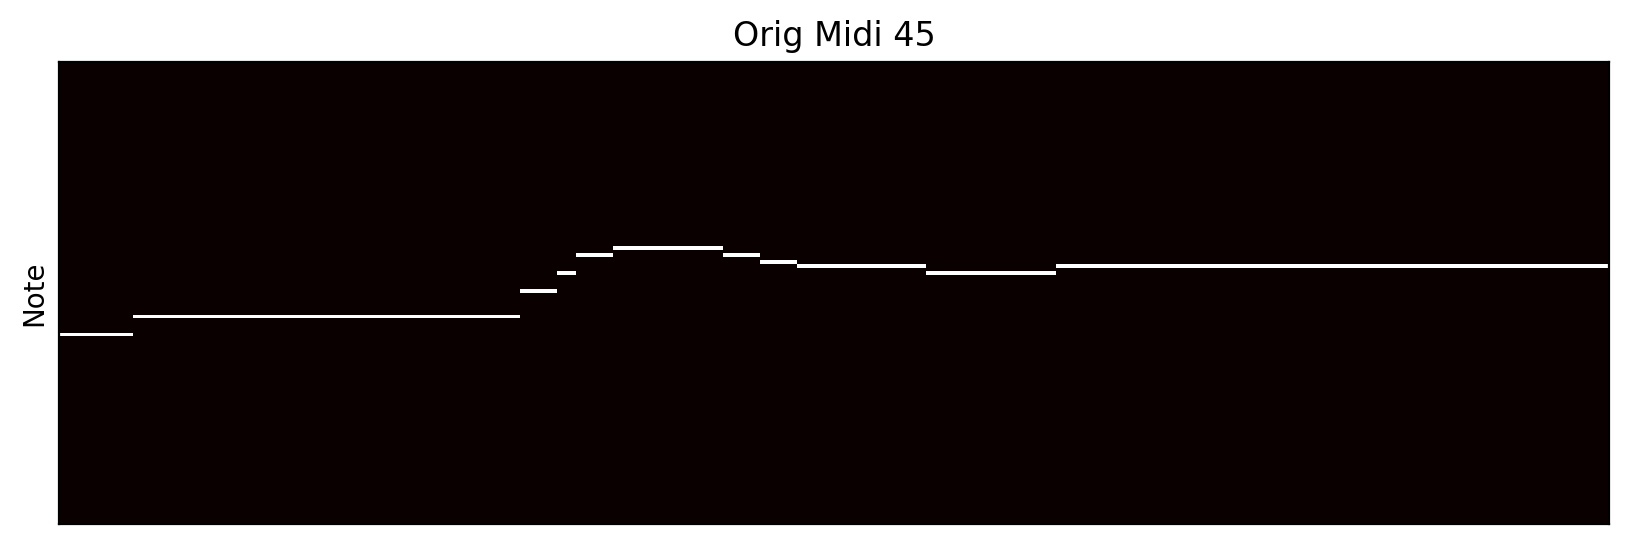

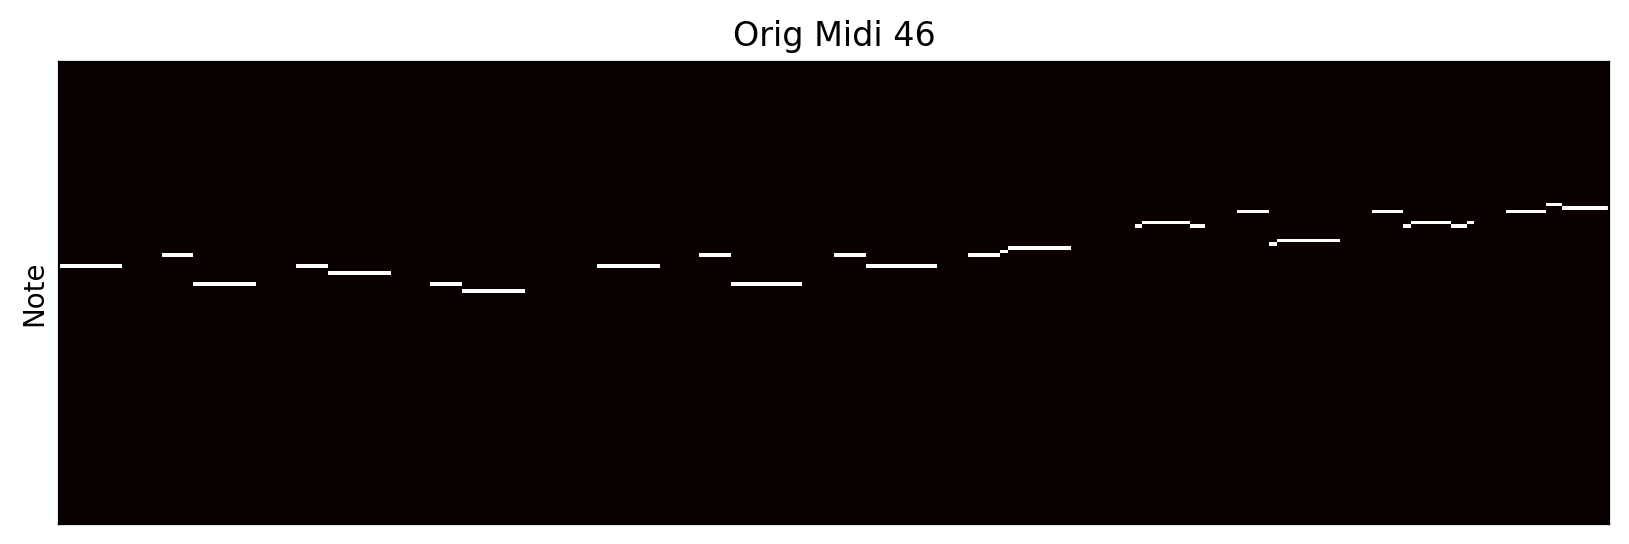

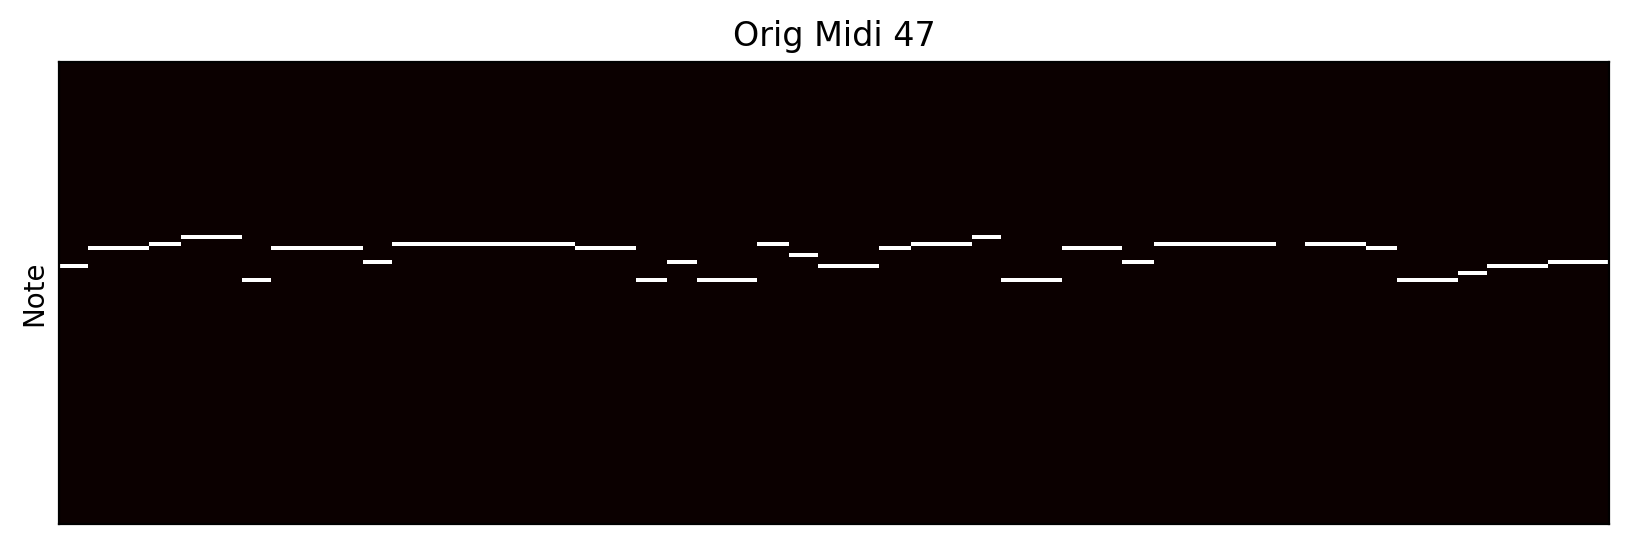

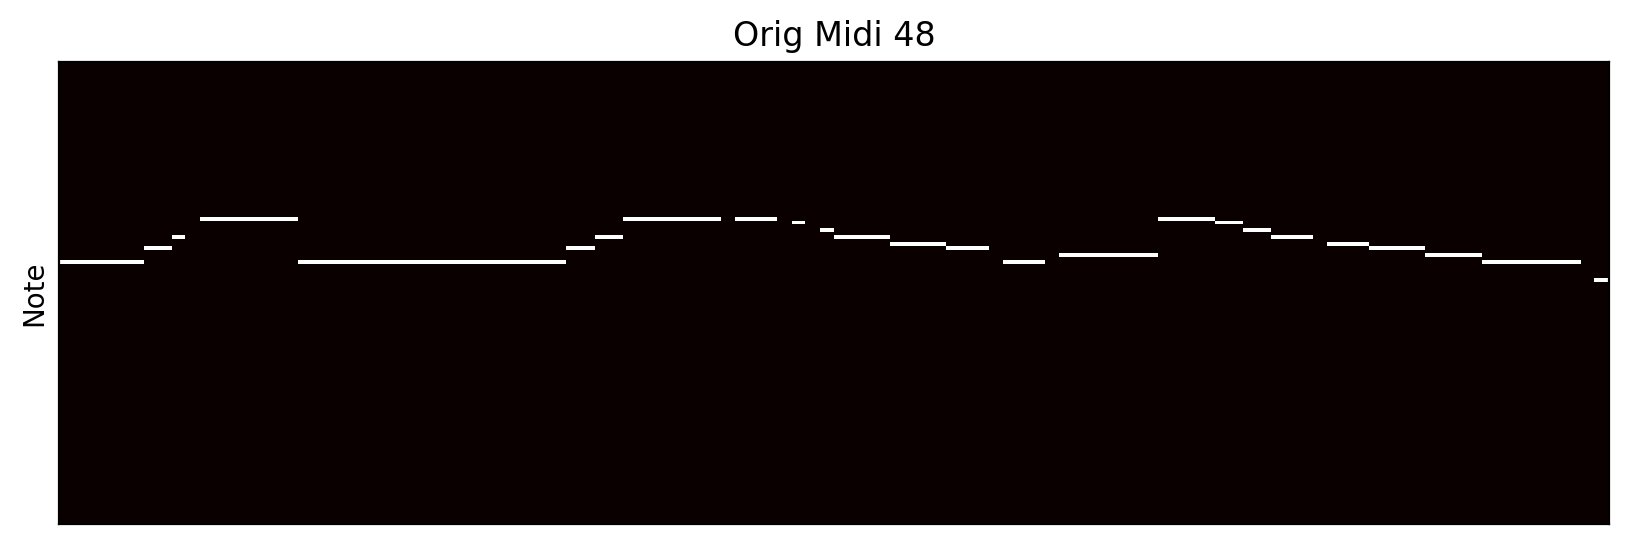

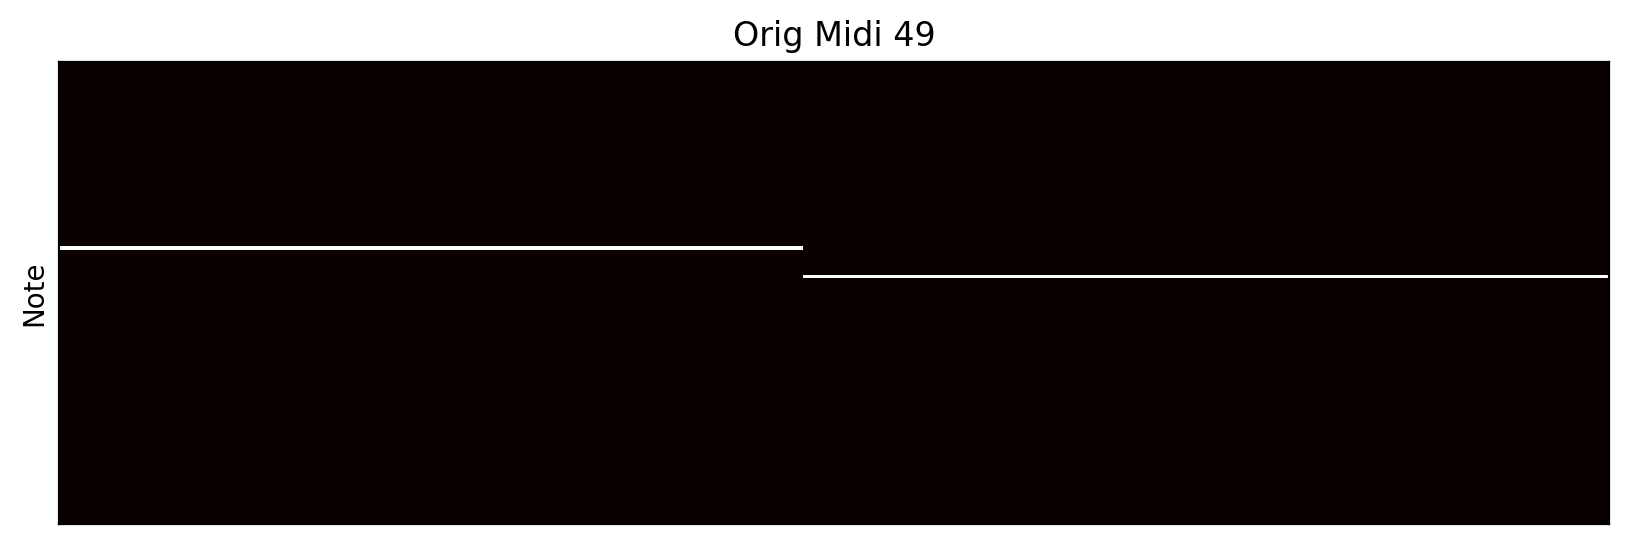

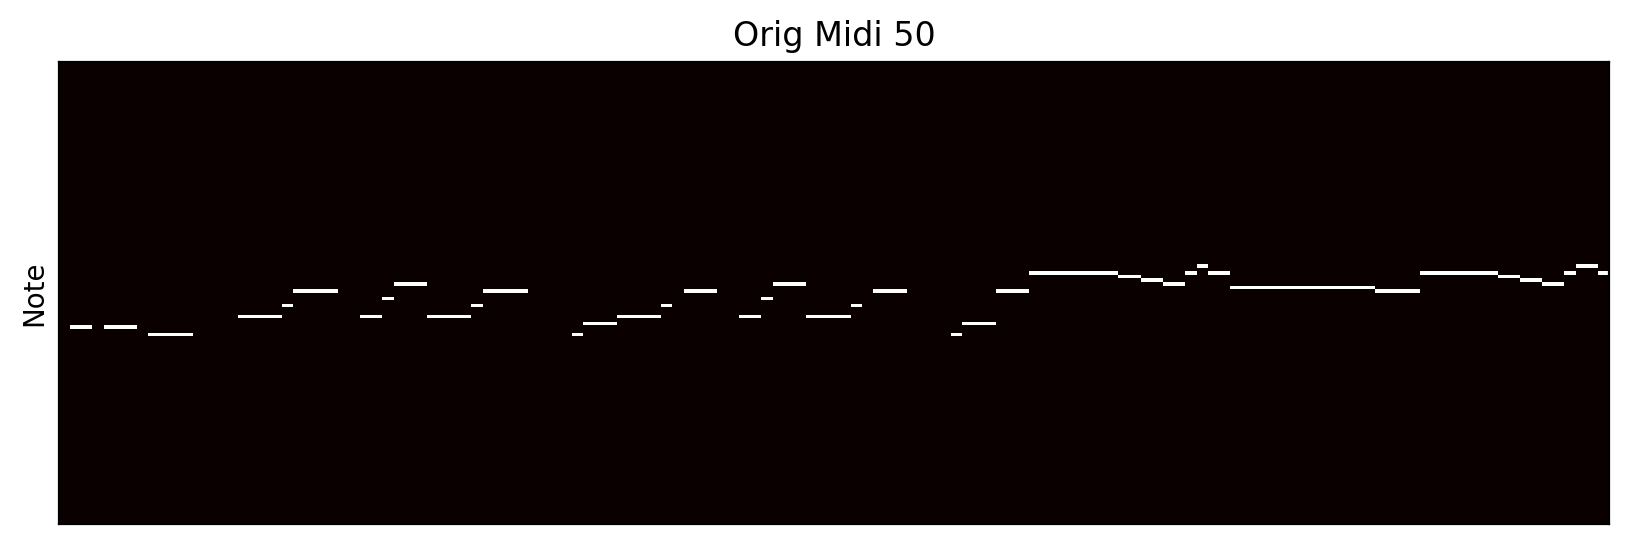

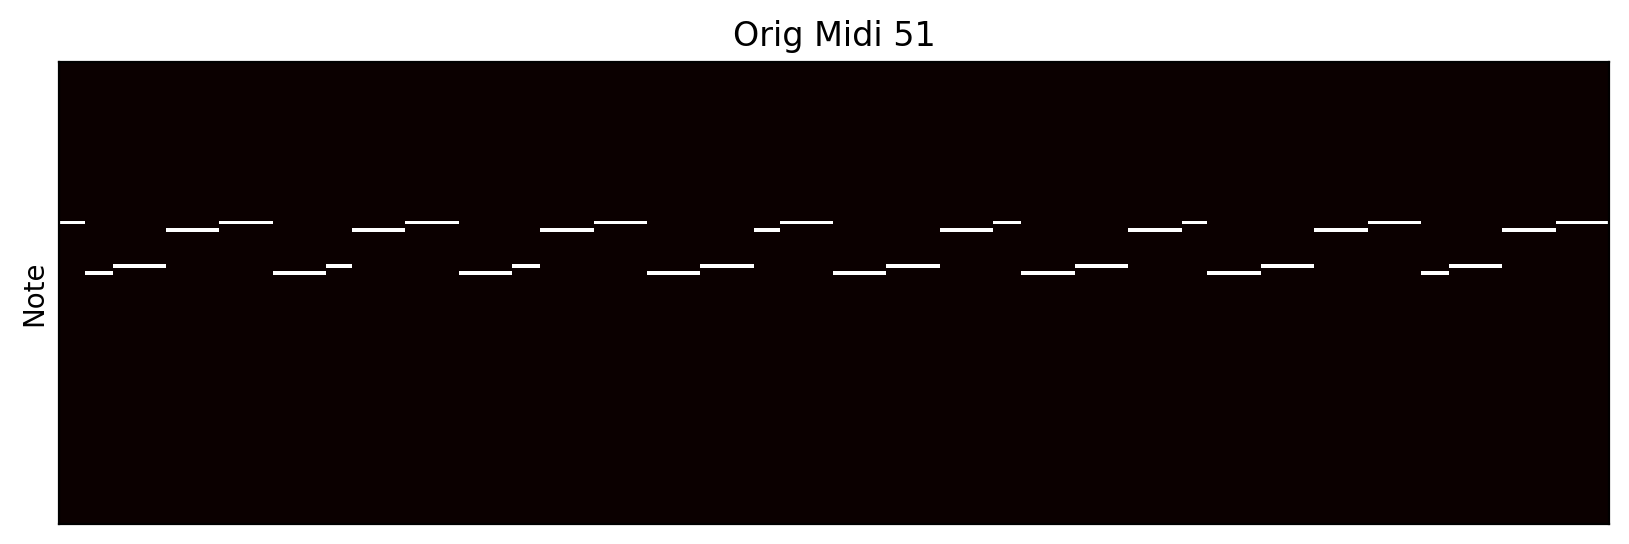

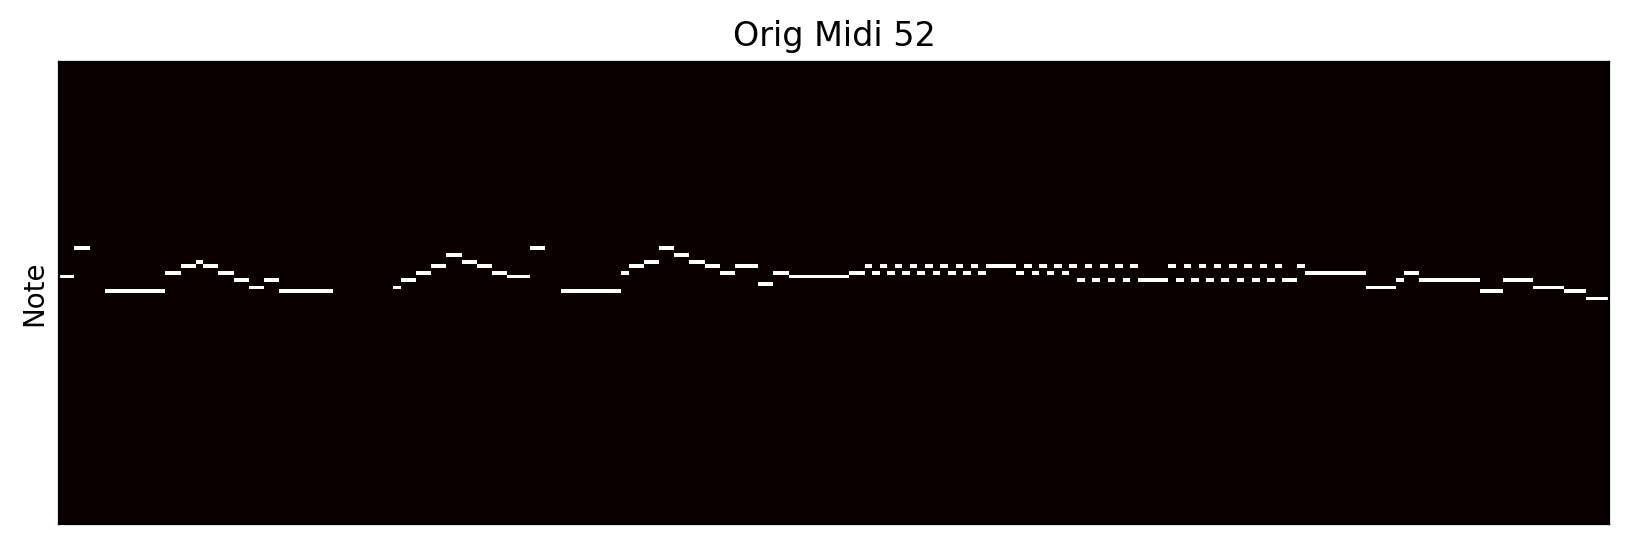

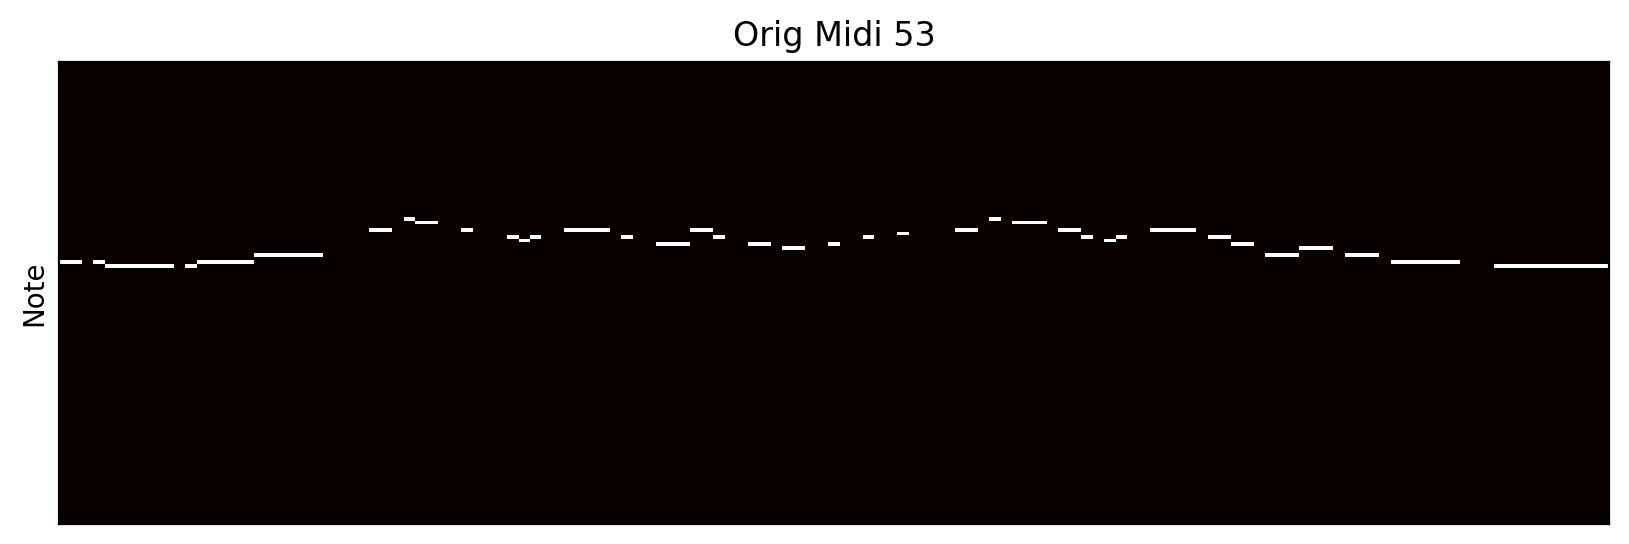

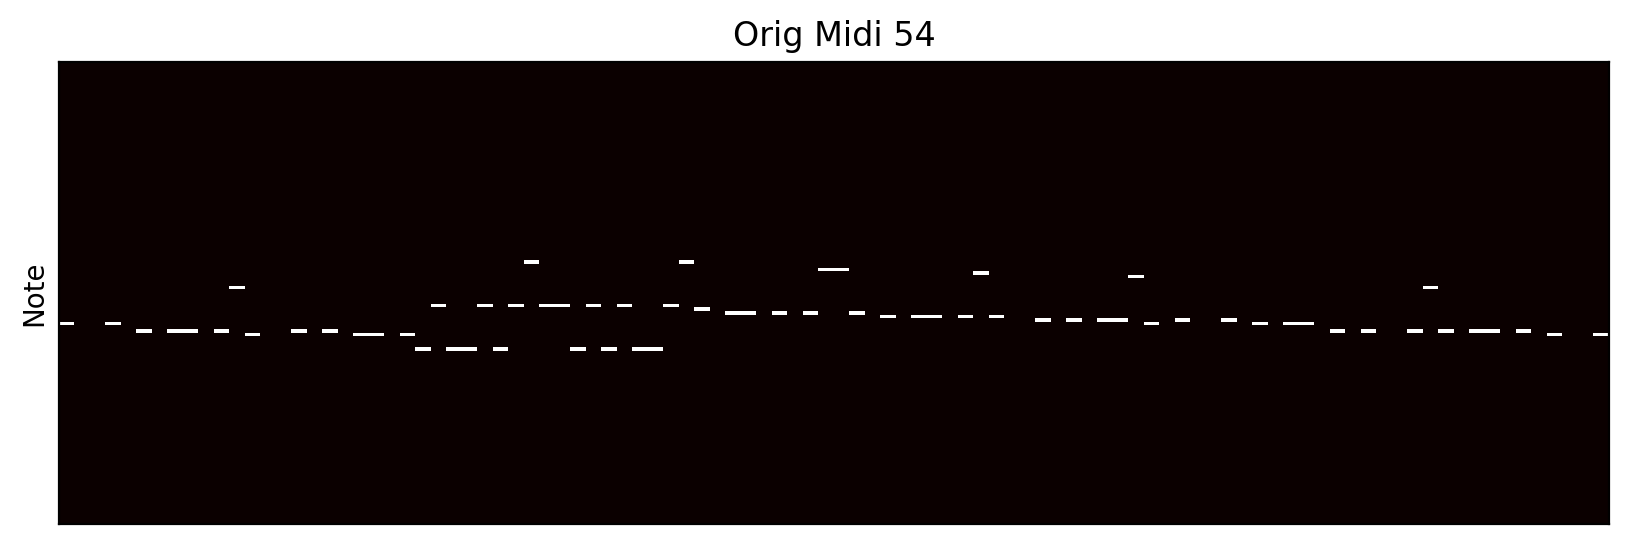

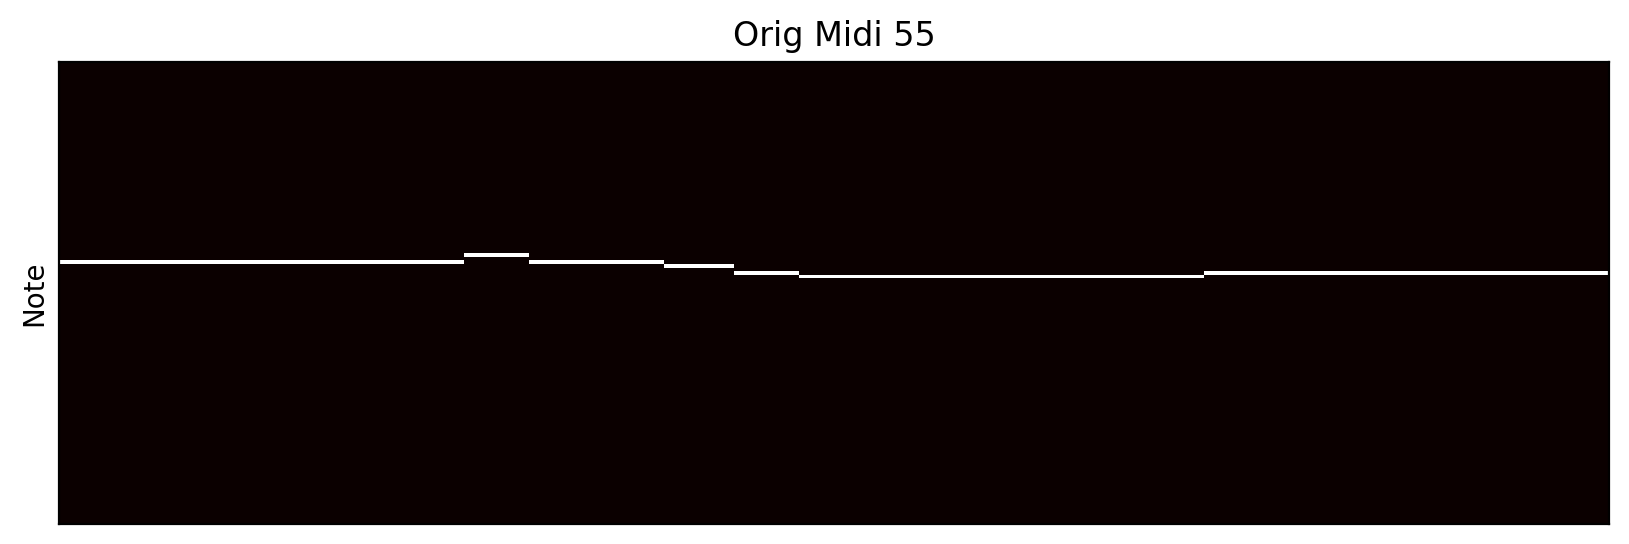

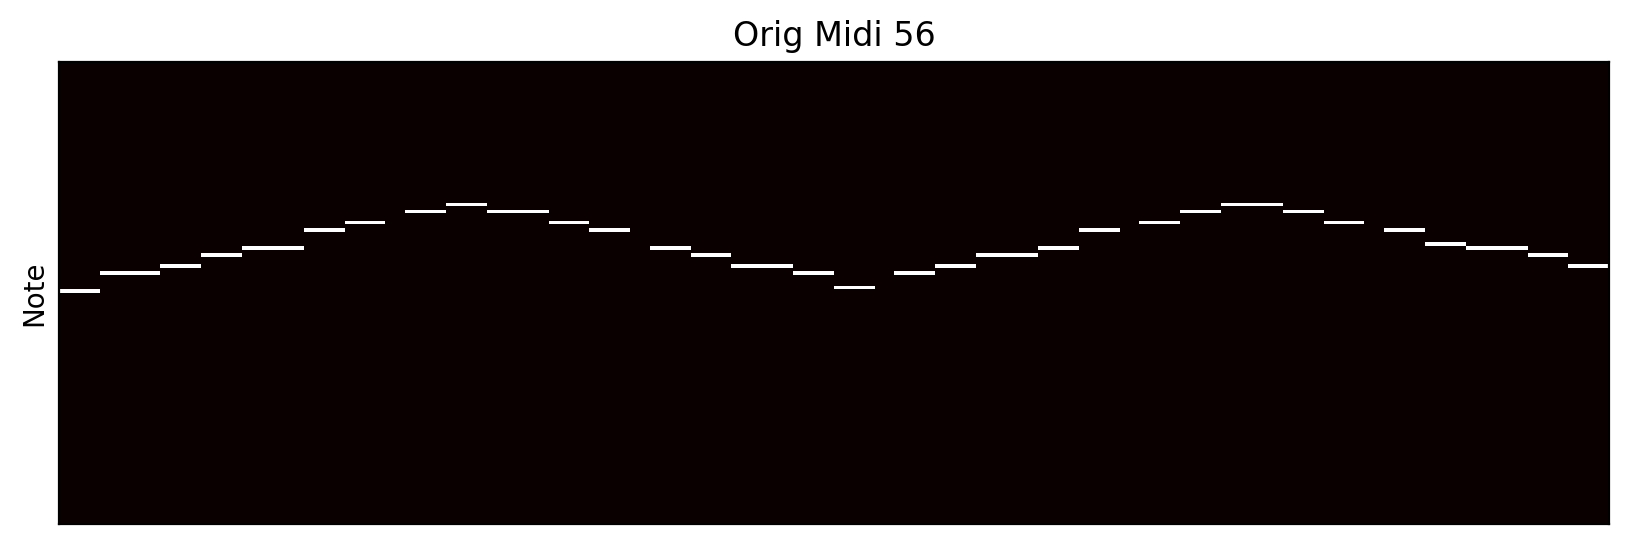

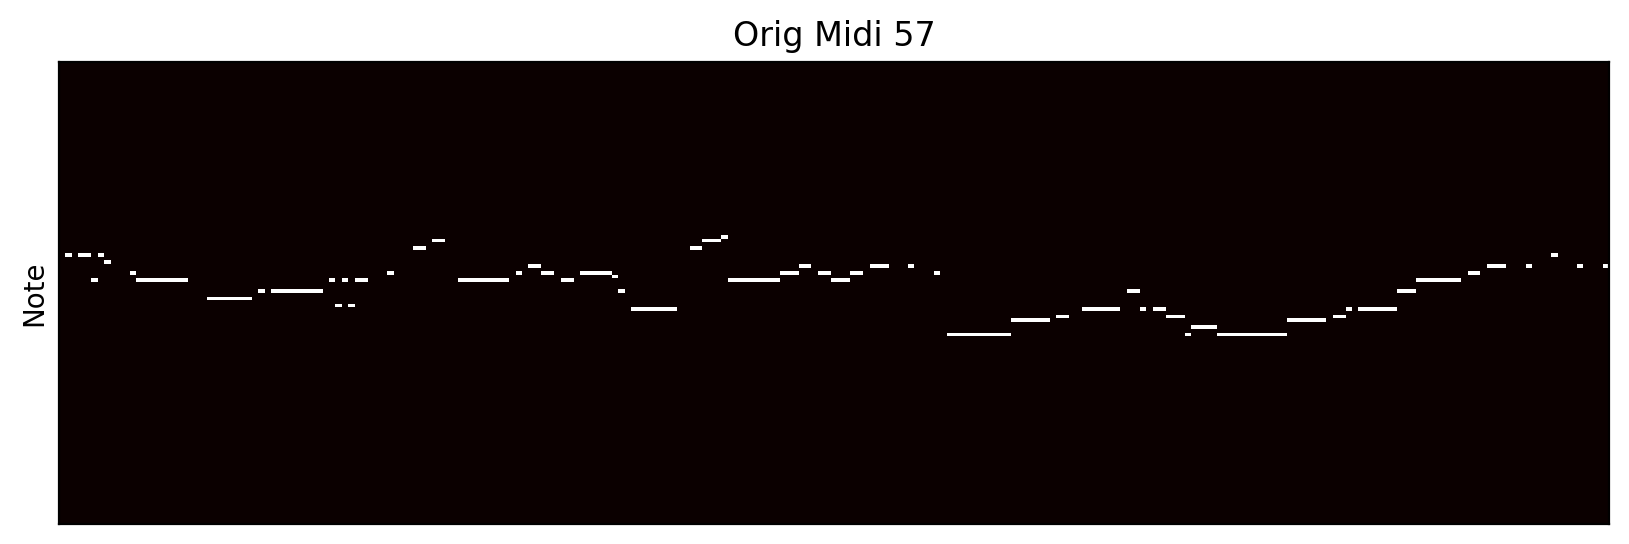

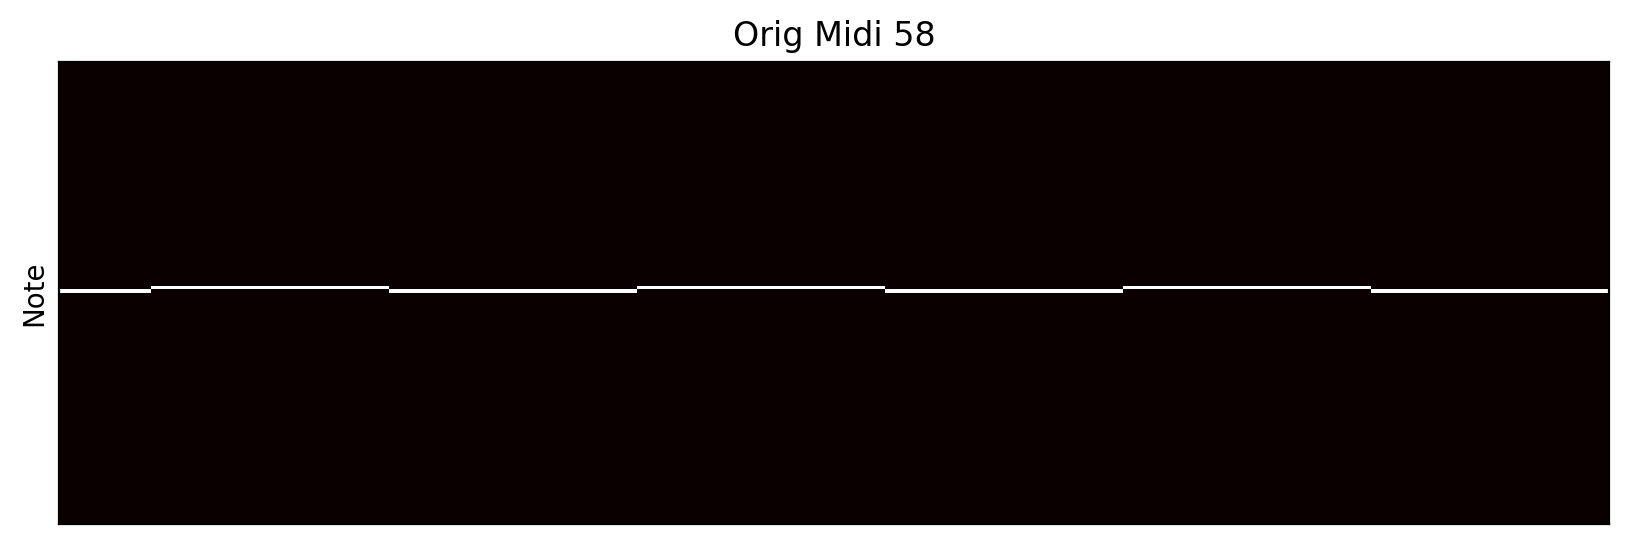

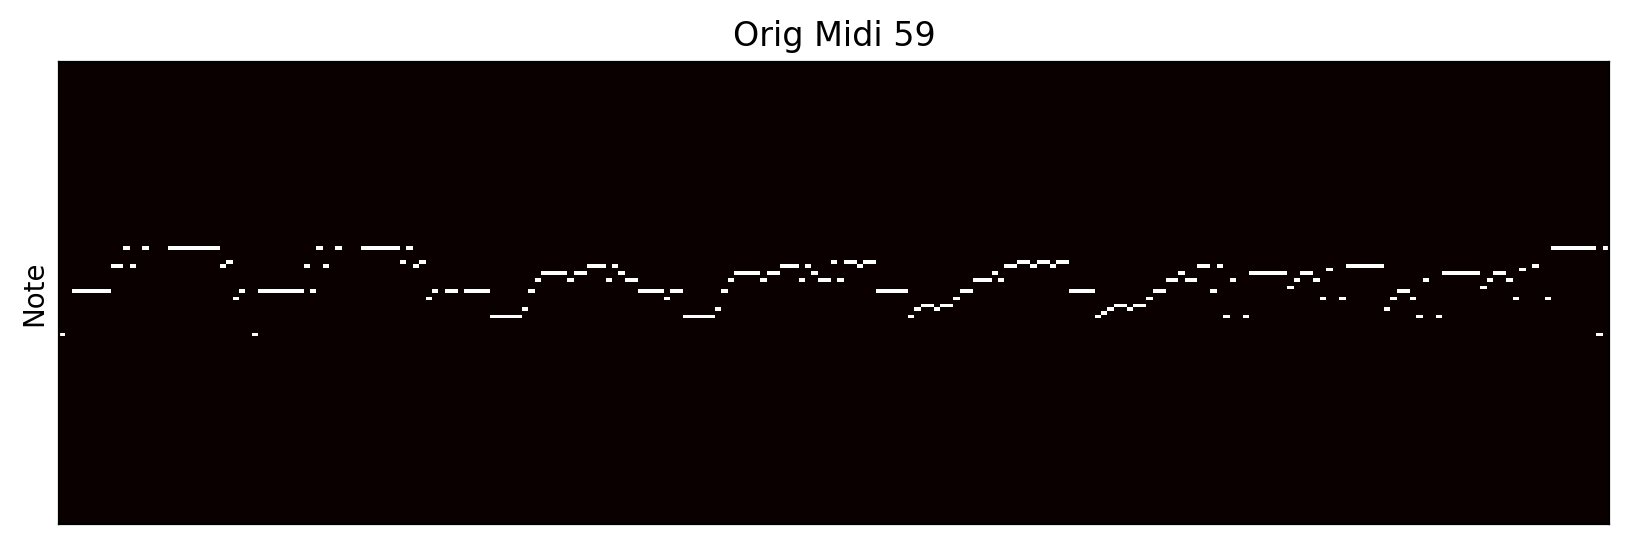

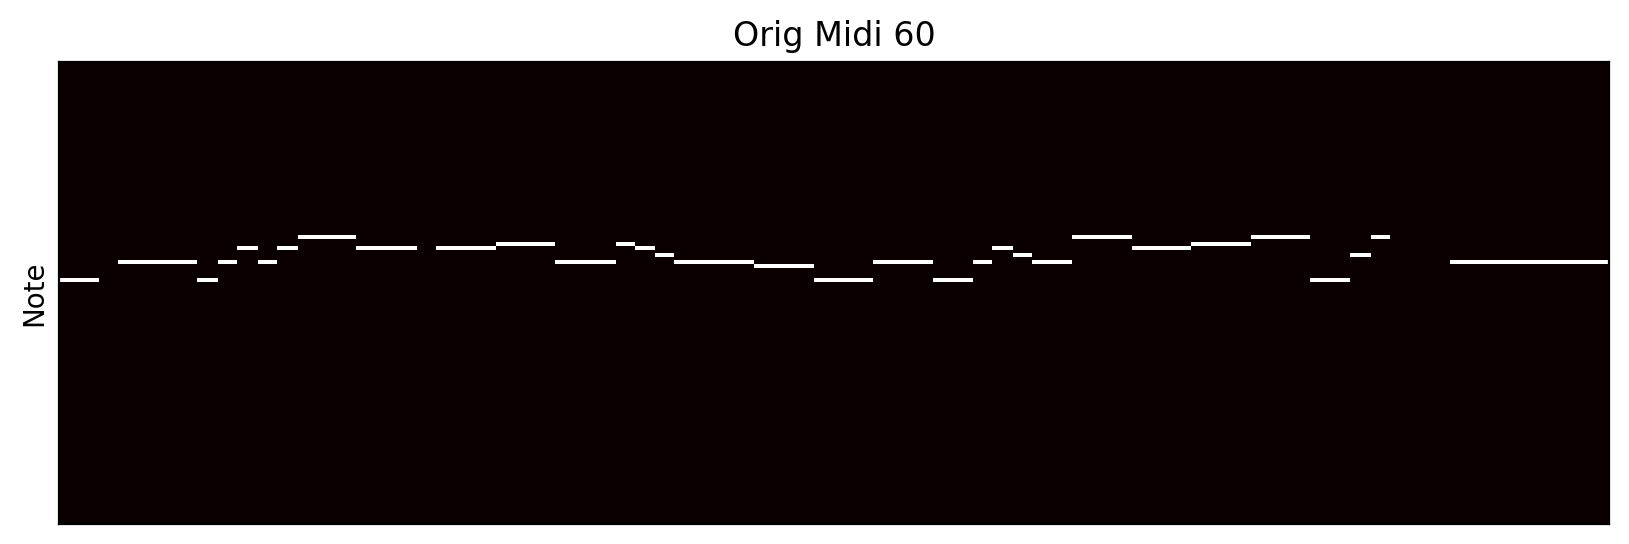

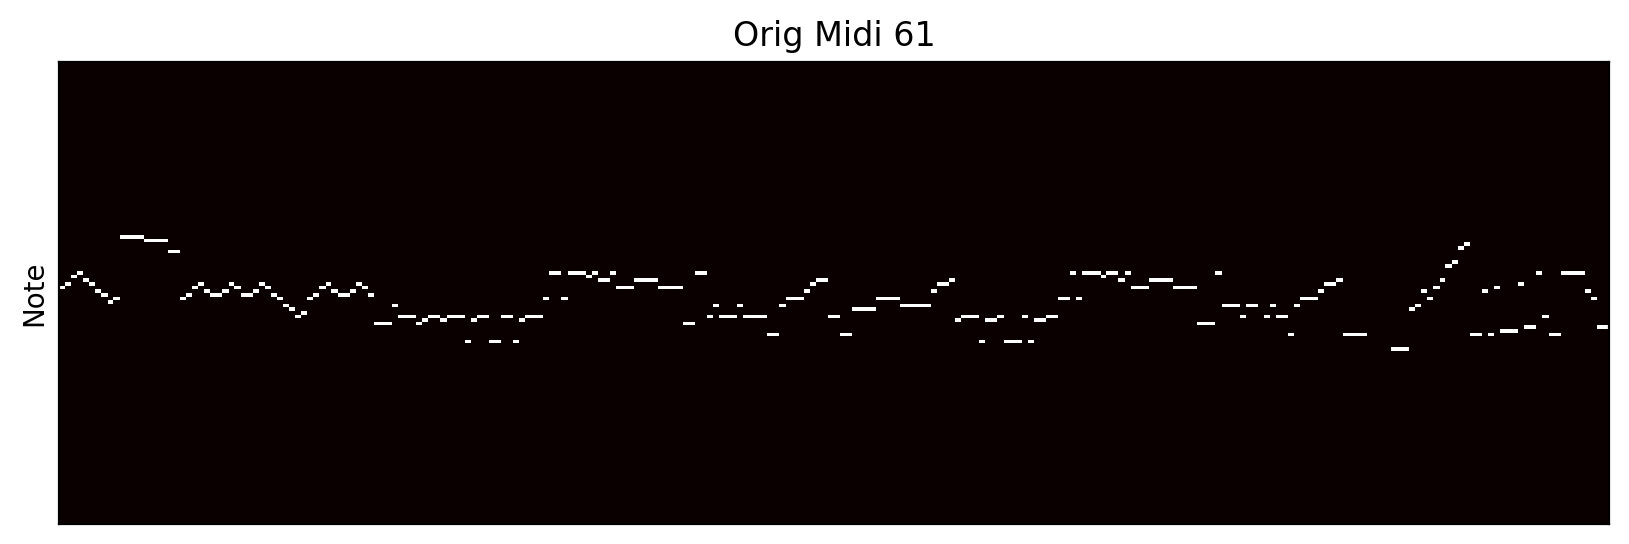

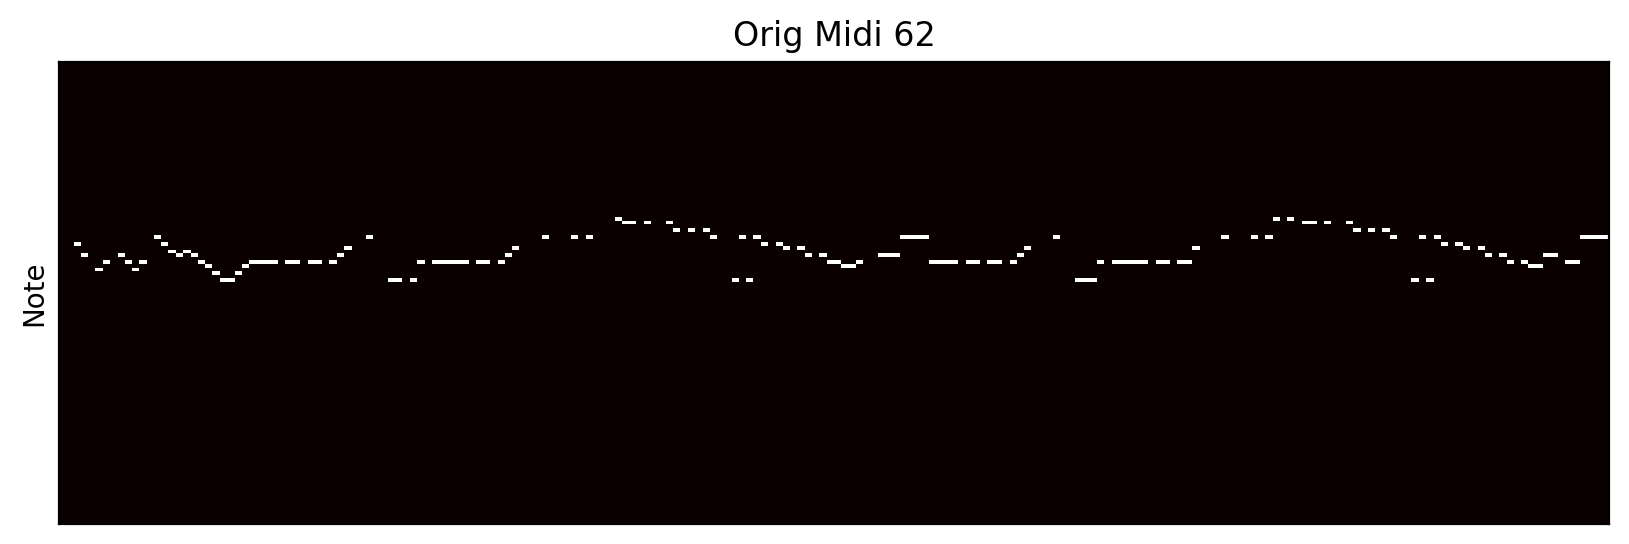

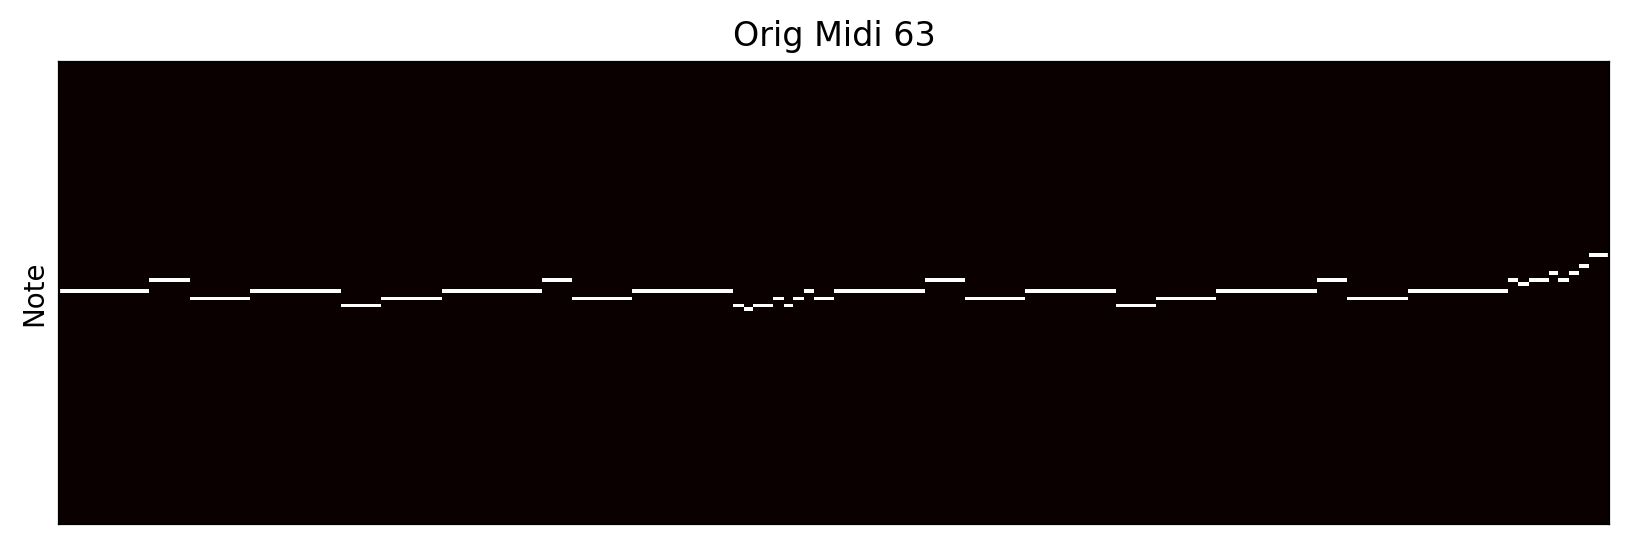

In [189]:
x_np = x.detach().numpy()
x_np.shape
for i, seq in enumerate(x_np):
    midi_out = seq

    if np.all(midi_out[:,-1]):
        print("Midi: {} is all silent".format(i))
        continue

    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Orig Midi {}".format(i))

    builder.plot_midi(midi)
    plt.savefig("midi/img_midi_{}_orig.png".format(i))

    midi.write('midi/{}_orig.mid'.format(i))

    #synth, rate = builder.play_midi(midi)
    #Audio(synth, rate=rate)

#### Generate from latent space

In [192]:
gen_batch = 10
z_gen = torch.randn(gen_batch, 256, 32).cuda()

# Sample from latent space
h_gen,c_gen,hconductor_gen,cconductor_gen = net.init_hidden(gen_batch)
conductor_hidden_gen = (hconductor_gen,cconductor_gen)


notes_gen = torch.zeros(gen_batch,TOTAL_NOTES,NUM_PITCHES,device=device)

# For the first timestep the note is the embedding
note_gen = torch.zeros(gen_batch, 1 , NUM_PITCHES,device=device)


decoder_hidden_gen = (torch.randn(1,gen_batch, decoders_initial_size,device=device), torch.randn(1,gen_batch, decoders_initial_size,device=device))

counter=0

print(sequence_length)
print(notes_gen.shape)
for i in range(totalbars):
    decoder_hidden_gen = (torch.randn(1,gen_batch, decoders_initial_size,device=device), torch.randn(1,gen_batch, decoders_initial_size,device=device))
    embedding_gen, conductor_hidden_gen = net.conductor(z_gen[:,i,:].view(gen_batch,1, -1), conductor_hidden_gen)

    for _ in range(sequence_length):
        # Concat embedding with previous note

        e_gen = torch.cat([embedding_gen, note_gen], dim=-1)
        e_gen = e_gen.view(gen_batch, 1, -1)

        # Generate a single note (for each batch)
        note_gen, decoder_hidden_gen = net.decoder(e_gen, decoder_hidden_gen)

        aux_gen = net.linear(note_gen)

        aux_gen=torch.softmax(aux_gen, dim=2);
        #notes_gen[:,range(i*16,i*16+16),:]=aux_gen;
        notes_gen[:,counter,:]=aux_gen.squeeze();

        note_gen=aux_gen
        counter = counter+1

notes_gen

16
torch.Size([10, 256, 61])


tensor([[[8.2350e-03, 1.0366e-03, 7.2034e-03,  ..., 1.0596e-03,
          1.0713e-03, 3.7301e-02],
         [3.3302e-03, 5.2368e-04, 3.8194e-03,  ..., 1.0388e-04,
          1.8700e-04, 7.5858e-03],
         [1.9051e-03, 3.1374e-04, 2.1855e-03,  ..., 3.4390e-05,
          8.0823e-05, 5.5721e-03],
         ...,
         [1.9741e-06, 9.8329e-07, 5.4251e-07,  ..., 3.2877e-07,
          1.4909e-06, 9.9993e-01],
         [1.9710e-06, 9.8585e-07, 5.4263e-07,  ..., 3.2788e-07,
          1.4880e-06, 9.9993e-01],
         [1.9687e-06, 9.8771e-07, 5.4280e-07,  ..., 3.2711e-07,
          1.4853e-06, 9.9993e-01]],

        [[6.3447e-03, 2.9306e-03, 1.1553e-02,  ..., 2.0321e-03,
          3.8847e-03, 3.7408e-02],
         [2.7775e-03, 8.2677e-04, 3.9526e-03,  ..., 1.2336e-04,
          5.5140e-04, 5.8322e-02],
         [9.4763e-04, 2.3975e-04, 1.1182e-03,  ..., 3.5195e-05,
          1.6707e-04, 2.5749e-02],
         ...,
         [5.9527e-07, 1.2347e-07, 1.4232e-07,  ..., 4.1424e-08,
          1.462

<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  display.specshow(midi_sample.get_piano_roll(), y_axis='cqt_note', cmap=plt.cm.hot)
<ipython-input-140-d6d6d637dda6>:58: UserWarning: Frequency axis exceeds Nyq

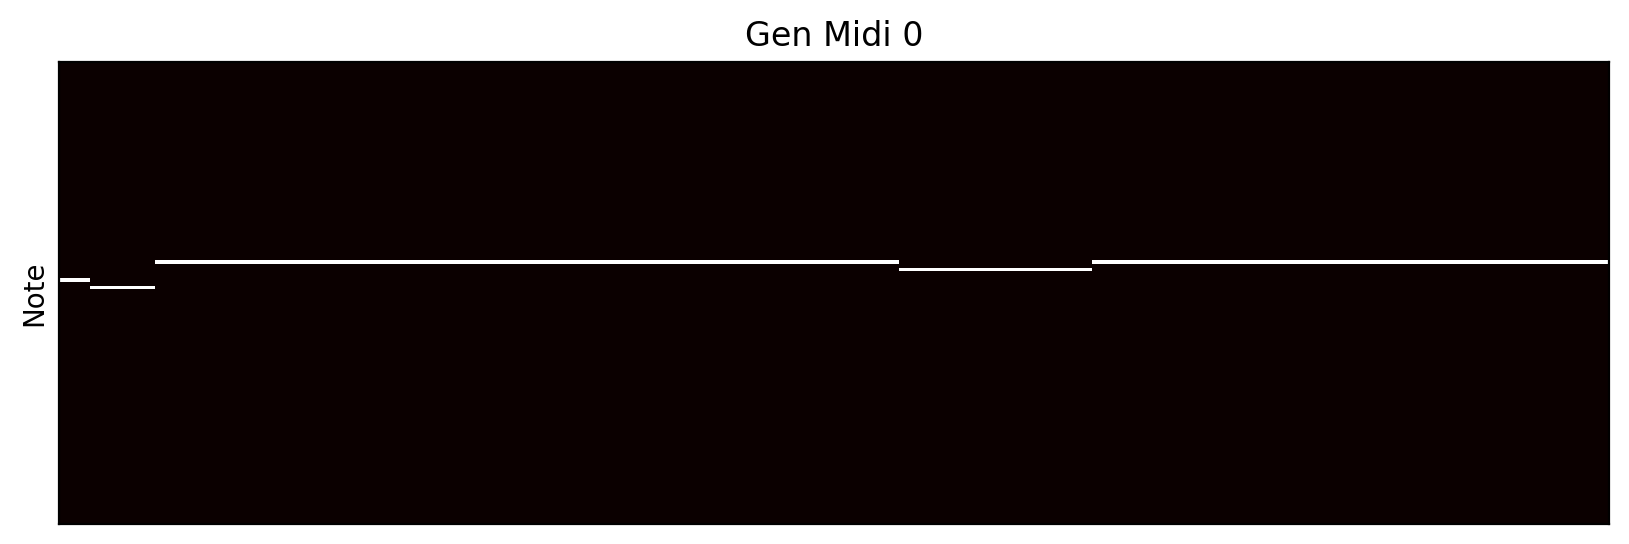

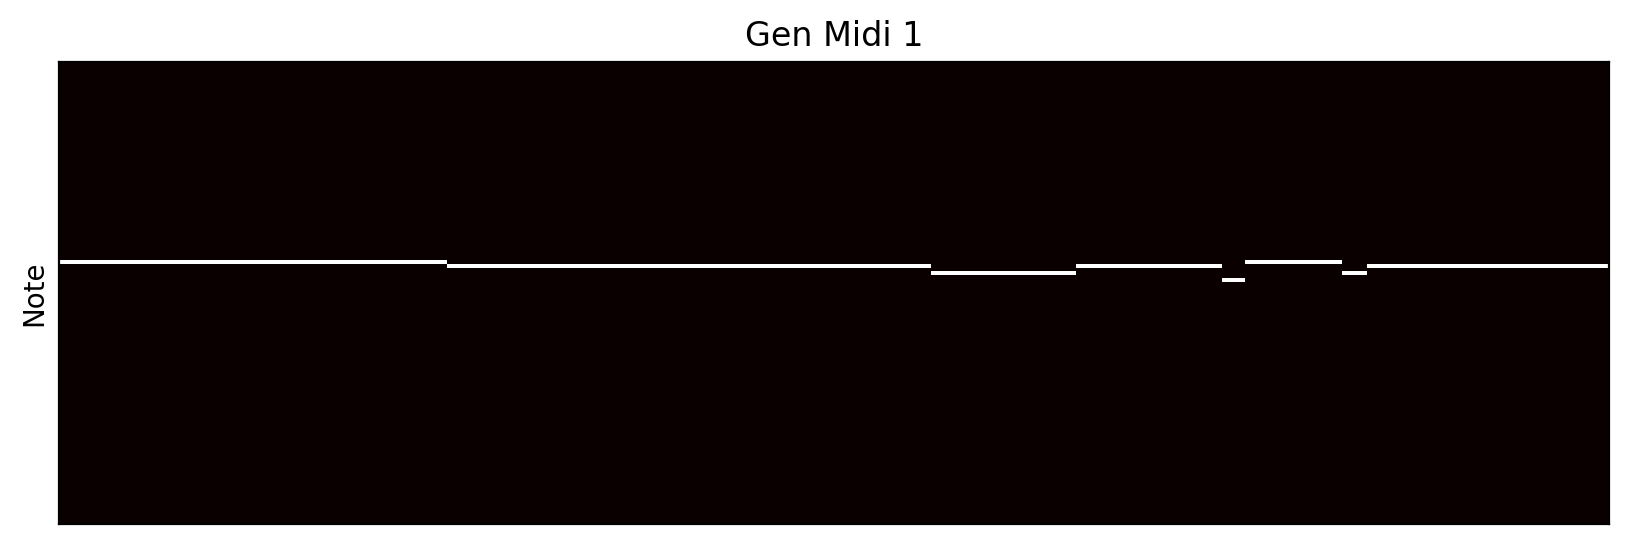

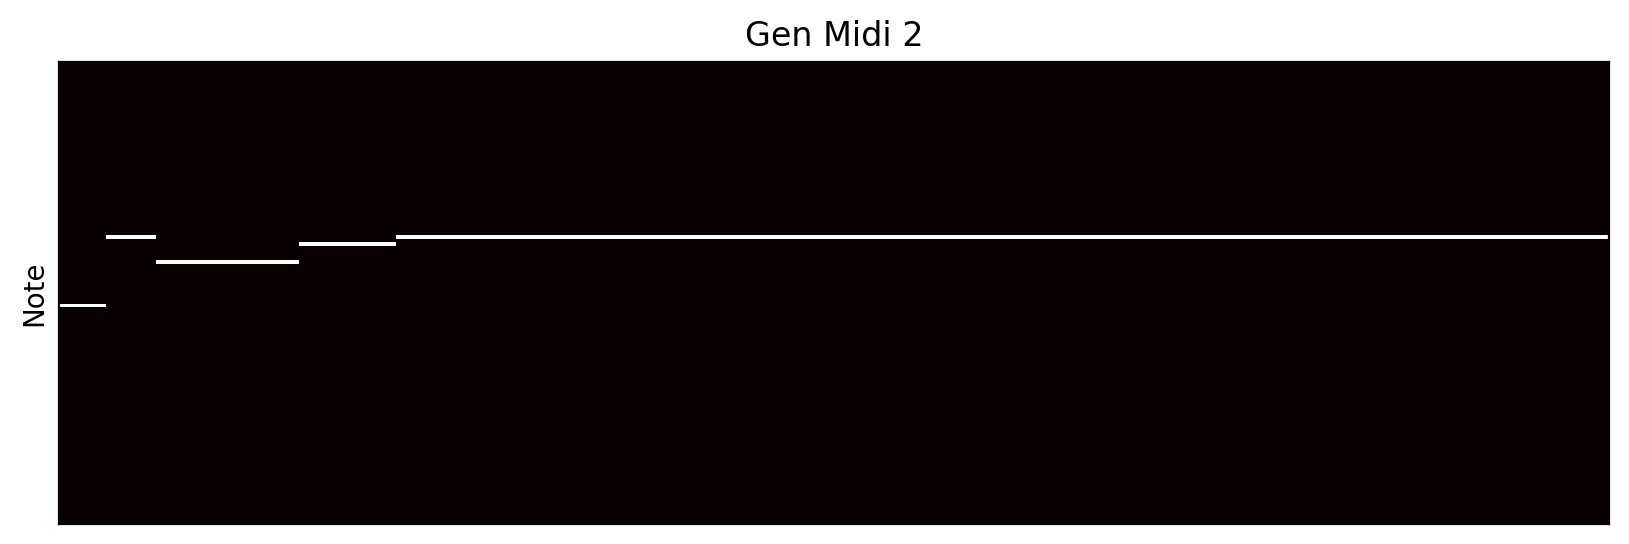

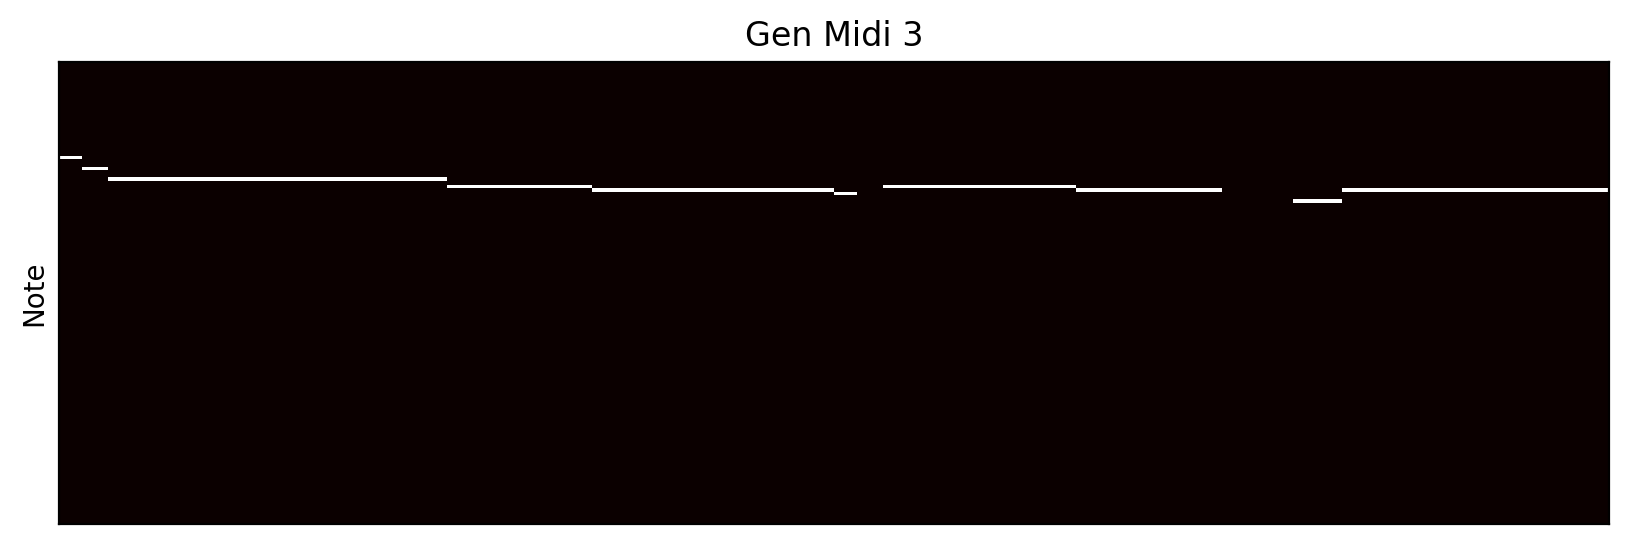

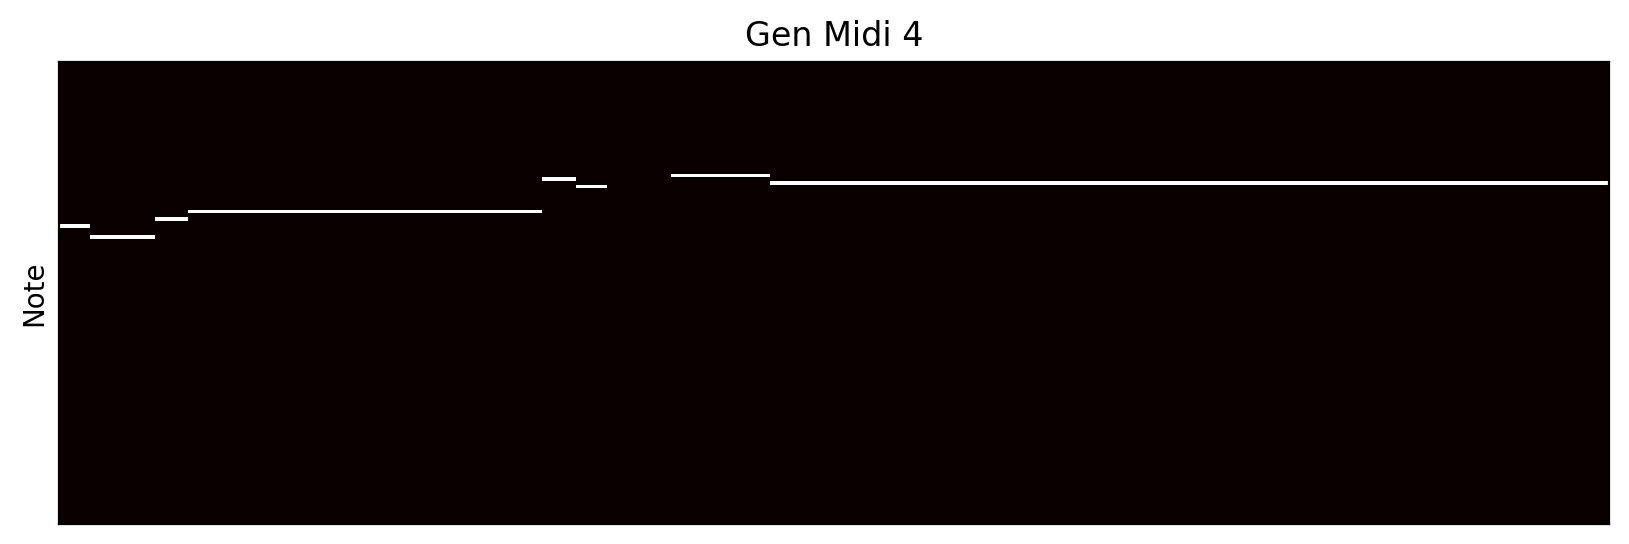

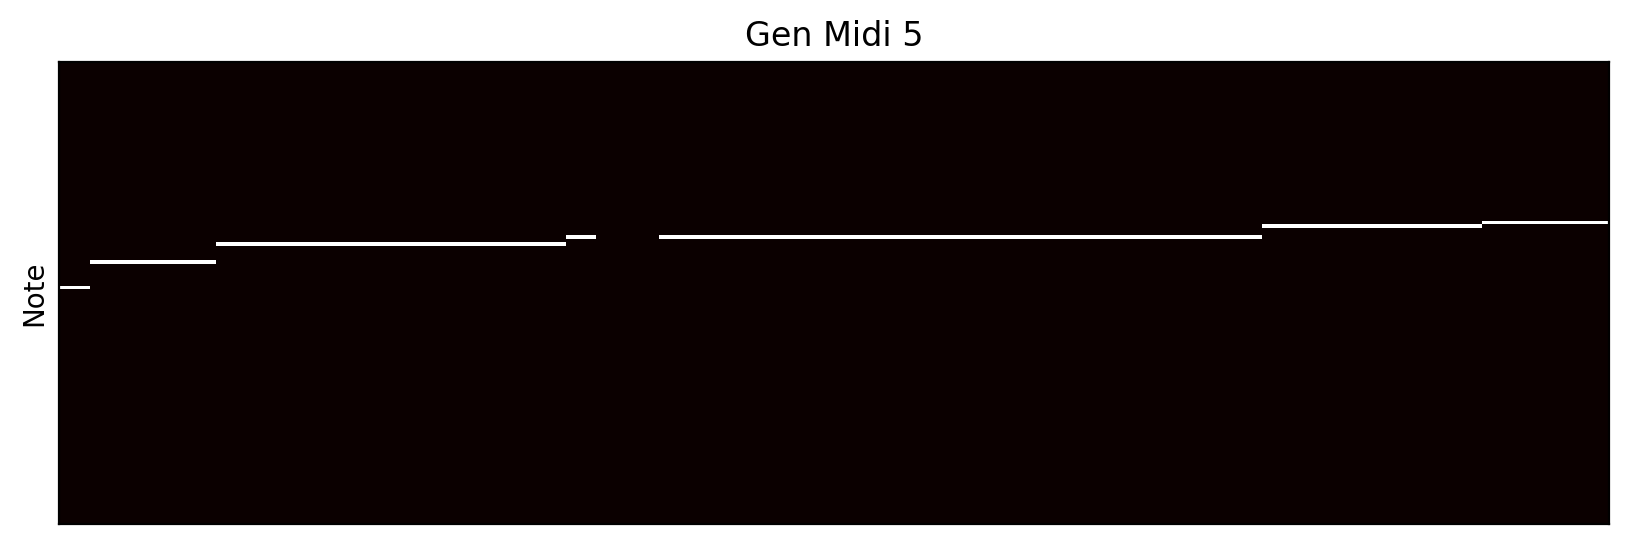

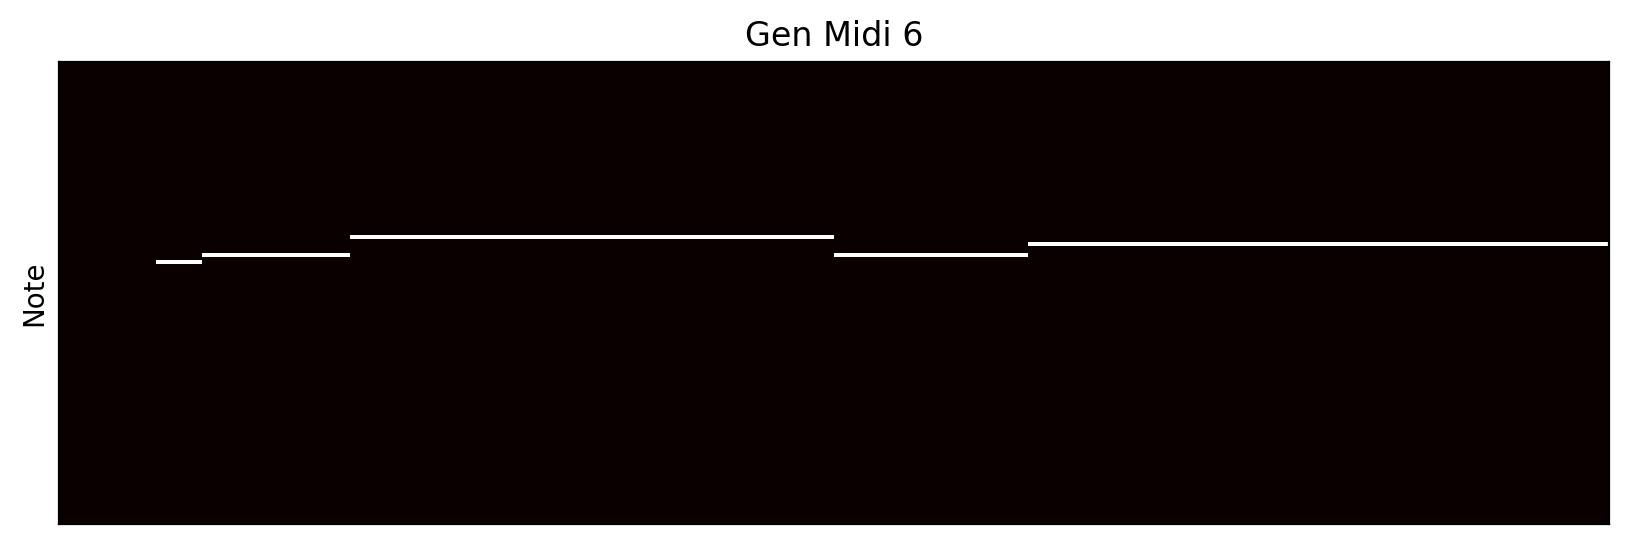

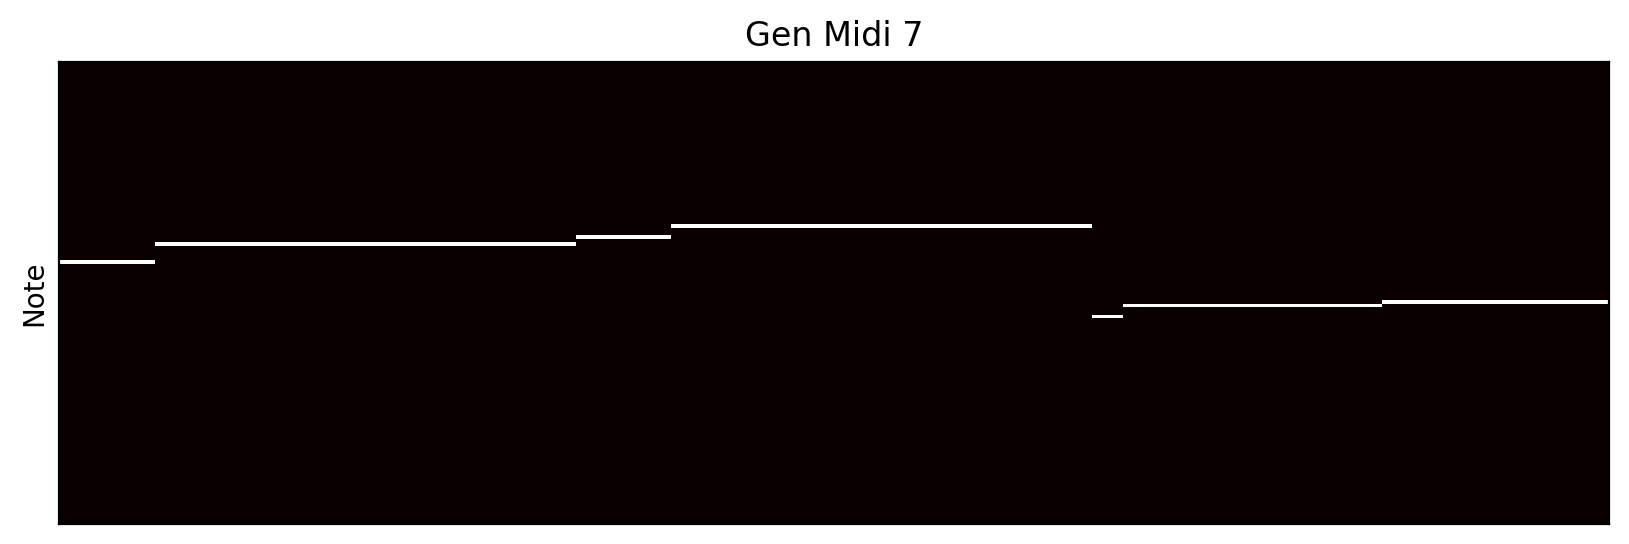

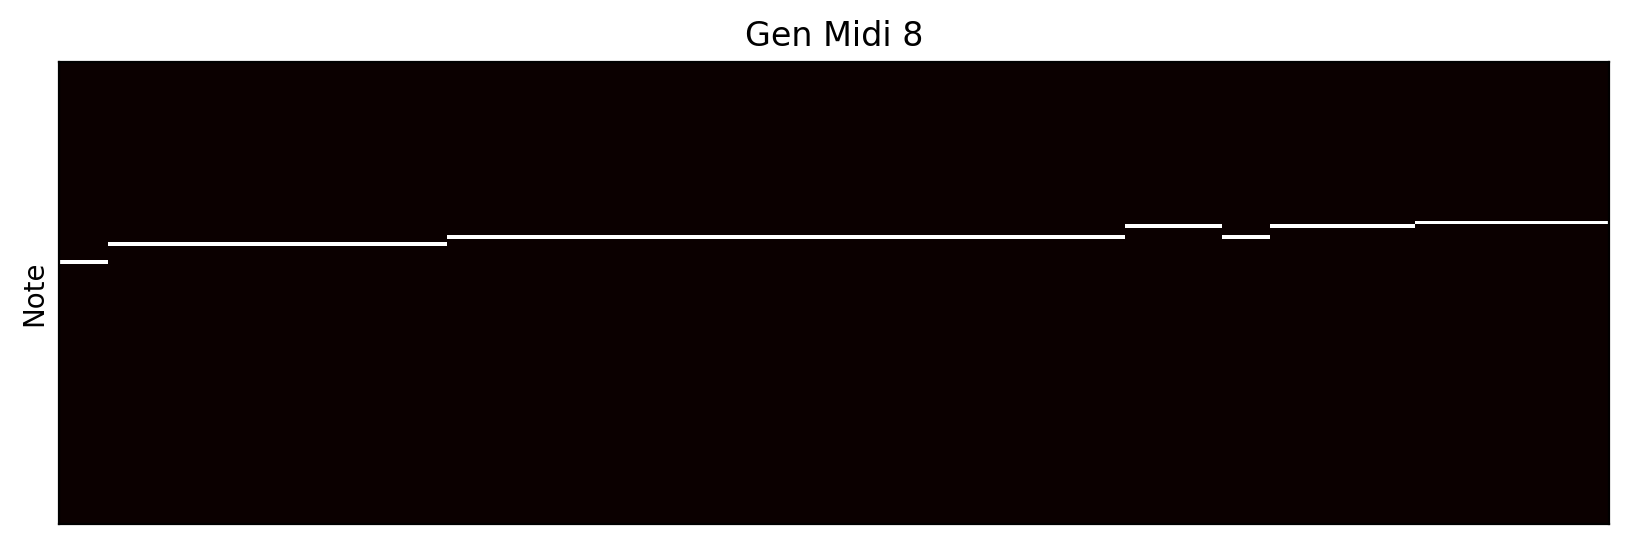

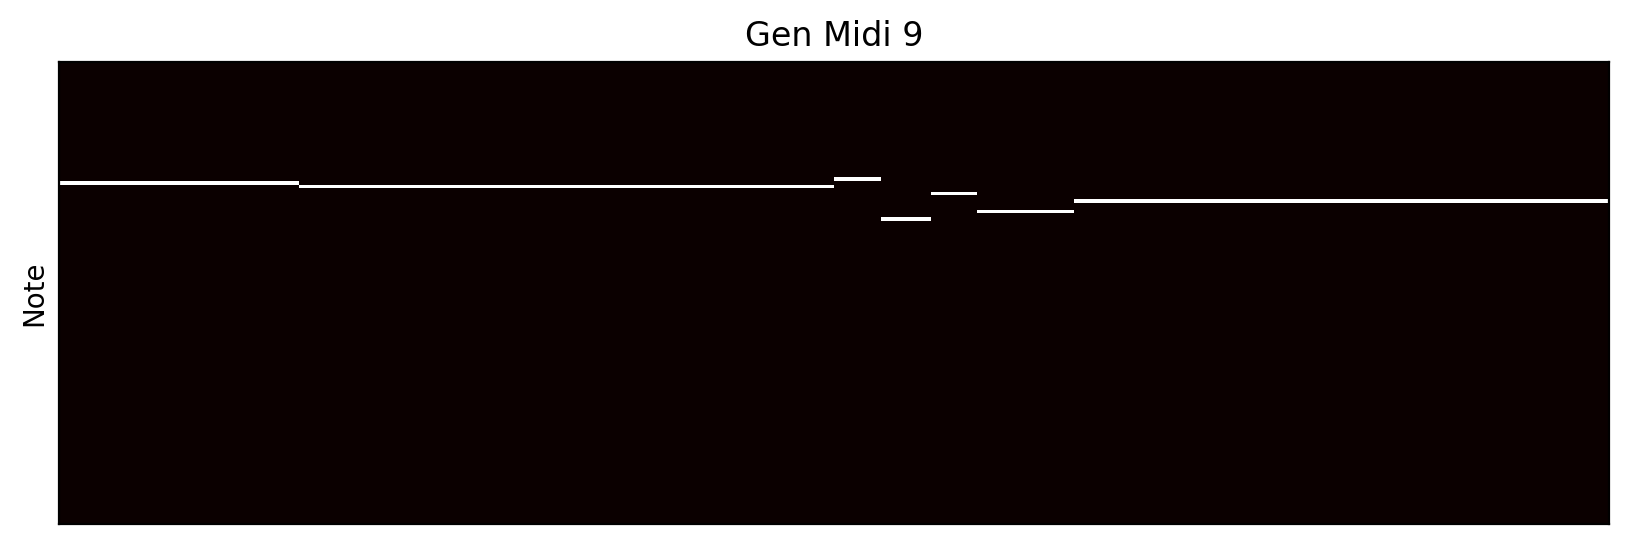

In [193]:
notes_np = notes_gen.cpu().detach().numpy()
notes_np.shape
for i, seq in enumerate(notes_np):
    row_maxes = seq.max(axis=1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)
    if np.all(midi_out[:,-1]):
        print("Midi: {} is all silent".format(i))
        continue

    np.savetxt("midi/gen_csv_midi_out_{}.csv".format(i), midi_out, delimiter=";")

    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Gen Midi {}".format(i))

    builder.plot_midi(midi)
    plt.savefig("midi/gen_img_midi_{}.png".format(i))

    midi.write('midi/gen_{}.mid'.format(i))

#### Play original, reconstruction and generated

In [208]:
def playMidi(path):
  mf = music21.midi.MidiFile()
  mf.open(path) # path='abc.midi'
  mf.read()
  mf.close()
  s = music21.midi.translate.midiFileToStream(mf)
  s.show('midi')

In [213]:
# Play original
path_or = "midi/20_orig.mid"
playMidi(path_or)


In [214]:
# Play reconstruction
path_recons = "midi/20.mid"
playMidi(path_recons)

In [215]:
# Play generated
for i in range(notes_np.shape[0]):
    path_gen = f"midi/gen_{i}.mid"
    playMidi(path_gen)

### Store model

In [216]:
# Save model
#torch.save(net.state_dict(), 'model_MusicVAE_200epochs.pth')